In [1]:
import numpy as np
import pandas as pd
import tensorflow as tf
import heapq
from math import log
from sklearn import metrics
from tensorflow import keras
from tensorflow.keras import layers
from sklearn.utils import shuffle
from tensorflow.keras.utils import to_categorical
from sklearn.model_selection import train_test_split,cross_val_score
from sklearn.preprocessing import StandardScaler,MinMaxScaler
from keras.models import Sequential, Model
from keras.layers import Input,Dense,Reshape,Flatten,Concatenate,Conv1D,MaxPool1D,Dropout,BatchNormalization
from keras.layers.advanced_activations import LeakyReLU
from tensorflow.keras.optimizers import Adam
from keras.utils.vis_utils import plot_model
from sklearn.metrics import r2_score,mean_squared_error,precision_score,recall_score,f1_score,accuracy_score,roc_curve,auc
import matplotlib.pyplot as plt
%matplotlib inline
from keras import backend as K
from keras.layers import Activation
import os
import time
import json
import pickle
import random
import math
from decimal import Decimal
import matplotlib.mlab as mlab
from scipy import stats
from pylab import rcParams
from sklearn.utils import check_random_state
from sklearn.datasets import load_digits
from sklearn.decomposition import PCA
from sklearn.preprocessing import scale
from sklearn.cluster import KMeans
from sklearn.mixture import GaussianMixture
from sklearn.svm import LinearSVC, SVC
from sklearn.linear_model import LinearRegression
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import pairwise_distances_argmin_min
from sklearn.metrics import confusion_matrix
from sklearn.metrics import precision_recall_curve
from sklearn.metrics import average_precision_score
from sklearn.ensemble import RandomForestClassifier,GradientBoostingClassifier
from keras.callbacks import EarlyStopping

In [2]:
# Core layers
from keras.layers import Activation, Dropout, Flatten, Dense, Input, LeakyReLU

# Normalization layers
from keras.layers import BatchNormalization

# Merge layers
from keras.layers import concatenate, multiply

# Embedding Layers
from keras.layers import Embedding

# Keras models
from keras.models import Model, Sequential

# Keras optimizers
from tensorflow.keras.optimizers import Adam, RMSprop, SGD

# AOA

## 定义损失函数公式

In [3]:
# Function: 损失函数
def target_function(w1,w2,w3,x,y):
    loss=np.zeros((len(x), 1))
    for i in range(len(x)):
        z1=np.matmul(w1[:,:-1],x[i].reshape(-1,1))+w1[:,-1].reshape(-1,1)
        z1[z1<0]=0 
        
        z2=np.matmul(w2[:,:-1],z1)+w2[:,-1].reshape(-1,1)
        z2[z2<0]=0
        
        z3=np.matmul(w3[:,:-1],z2)+w3[:,-1].reshape(-1,1) #(3,1)  
        z3=z3.flatten()
        
        s=0
        for j in range(len(z3)):
            a=Decimal(z3[j])#将z3中的数据转变为Decimal
            e=Decimal.from_float(math.e)
            s=s+e**a
            
        pred=np.zeros(3)    
        for k in range(len(z3)):
            a=Decimal(z3[k])#将z3中的数据转变为Decimal
            if float((e**a)/s)==0:
                pred[k]=float((e**a)/s)+0.000001
            else:
                pred[k]=float((e**a)/s)

        l=sum(-y[i]*np.log(pred))
        loss[i]=l
    return loss

## 初始化变量

In [4]:
# Function: 初始化变量
def initial_population(x,y,target_function = target_function):
    w_1 = np.zeros((128, 10))
    b1 = np.zeros((128,1))
    for i in range(0, 128):
        for j in range(0, 10):
            w_1[i,j] = random.uniform(-1, 1)
        b1[i]=random.uniform(-0.5,0.5)
    w1=np.hstack((w_1,b1))
            
    w_2 = np.zeros((128, 128))
    b2 = np.zeros((128,1))
    for m in range(0, 128):
        for n in range(0, 128):
            w_2[m,n] = random.uniform(-1, 1)
        b2[m]=random.uniform(-0.5,0.5)
    w2=np.hstack((w_2,b2))
            
    w_3 = np.zeros((3, 128))
    b3 = np.zeros((3,1))
    for p in range(0, 3):
        for q in range(0, 128):
            w_3[p,q] = random.uniform(-1, 1)
        b3[p]=random.uniform(-0.5,0.5)
    w3=np.hstack((w_3,b3))
            
    loss=target_function(w1,w2,w3,x,y)

    return w1,w2,w3,loss

## 更新变量

In [195]:
# Function: 更新w1,w2,w3
def update_population(w1,w2,w3,loss,x,y, elite1, elite2, elite3, mu, moa, mop,target_function = target_function):
    e = 2.2204e-16
    c_w1 = np.copy(w1)
    c_w2 = np.copy(w2)
    c_w3 = np.copy(w3)
    for i in range(0, w1.shape[0]):
        for j in range(0, w1.shape[1]):
            r1 = int.from_bytes(os.urandom(8), byteorder = "big") / ((1 << 64) - 1) # 生成的字符串转换为大整型，除以((1 << 64) - 1)得到1个数
            r2 = int.from_bytes(os.urandom(8), byteorder = "big") / ((1 << 64) - 1) #生成[0,1]的一个数
            r3 = int.from_bytes(os.urandom(8), byteorder = "big") / ((1 << 64) - 1)
            # 加减乘除更新p值
            if j==(w1.shape[1]-1):
                if (r1 > moa and r2 > 0.5):
                    c_w1[i, j] = np.clip(elite1[i,j] / (mop + e) * ( (0.5 - (-0.5)) * mu + (-0.5)), -0.5, 0.5)
                elif (r1 > moa and r2 <= 0.5):
                    c_w1[i, j] = np.clip(elite1[i,j] * (  mop  ) * ( (0.5 - (-0.5)) * mu + (-0.5)), -0.5, 0.5)
                elif (r1 <= moa and r3 > 0.5):
                    c_w1[i, j] = np.clip(elite1[i,j] - (  mop  ) * ( (0.5 - (-0.5)) * mu + (-0.5)), -0.5, 0.5)
                elif (r1 <= moa and r3 <= 0.5):
                    c_w1[i, j] = np.clip(elite1[i,j] + (  mop  ) * ( (0.5 - (-0.5)) * mu + (-0.5)), -0.5, 0.5)
            else:
                if (r1 > moa and r2 > 0.5):
                    c_w1[i, j] = np.clip(elite1[i,j] / (mop + e) * ( (1 - (-1)) * mu + (-1)), -1, 1)
                elif (r1 > moa and r2 <= 0.5):
                    c_w1[i, j] = np.clip(elite1[i,j] * (  mop  ) * ( (1 - (-1)) * mu + (-1)), -1, 1)
                elif (r1 <= moa and r3 > 0.5):
                    c_w1[i, j] = np.clip(elite1[i,j] - (  mop  ) * ( (1 - (-1)) * mu + (-1)), -1, 1)
                elif (r1 <= moa and r3 <= 0.5):
                    c_w1[i, j] = np.clip(elite1[i,j] + (  mop  ) * ( (1 - (-1)) * mu + (-1)), -1, 1)
           # if (r1 > moa and r2 > 0.5):
          #      c_w1[i, j] = np.clip(elite1[i,j] / (mop + e) * ( (1 - (-1)) * mu + -1), -1, 1)
          #  elif (r1 > moa and r2 <= 0.5):
          #      c_w1[i, j] = np.clip(elite1[i,j] * (  mop  ) * ( (1 - (-1)) * mu + -1), -1, 1)
          #  elif (r1 <= moa and r3 > 0.5):
          #      c_w1[i, j] = np.clip(elite1[i,j] - (  mop  ) * ( (1 - (-1)) * mu + -1), -1, 1)
          #  elif (r1 <= moa and r3 <= 0.5):
          #      c_w1[i, j] = np.clip(elite1[i,j] + (  mop  ) * ( (1 - (-1)) * mu + -1), -1, 1)
                
    for m in range(0, w2.shape[0]):
        for n in range(0, w2.shape[1]):
            r1 = int.from_bytes(os.urandom(8), byteorder = "big") / ((1 << 64) - 1) # 生成的字符串转换为大整型，除以((1 << 64) - 1)得到1个数
            r2 = int.from_bytes(os.urandom(8), byteorder = "big") / ((1 << 64) - 1) #生成[0,1]的一个数
            r3 = int.from_bytes(os.urandom(8), byteorder = "big") / ((1 << 64) - 1)
            # 加减乘除更新p值
            if j==(w2.shape[1]-1):
                if (r1 > moa and r2 > 0.5):
                    c_w2[m, n] = np.clip(elite2[m,n] / (mop + e) * ( (0.5 - (-0.5)) * mu + (-0.5)), -0.5, 0.5)
                elif (r1 > moa and r2 <= 0.5):
                    c_w2[m, n] = np.clip(elite2[m,n] * (  mop  ) * ( (0.5 - (-0.5)) * mu + (-0.5)), -0.5, 0.5)
                elif (r1 <= moa and r3 > 0.5):
                    c_w2[m, n] = np.clip(elite2[m,n] - (  mop  ) * ( (0.5 - (-0.5)) * mu + (-0.5)), -0.5, 0.5)
                elif (r1 <= moa and r3 <= 0.5):
                    c_w2[m, n] = np.clip(elite2[m,n] + (  mop  ) * ( (0.5 - (-0.5)) * mu + (-0.5)), -0.5, 0.5)
            else:
                if (r1 > moa and r2 > 0.5):
                    c_w2[m, n] = np.clip(elite2[m,n] / (mop + e) * ( (1 - (-1)) * mu + (-1)), -1, 1)
                elif (r1 > moa and r2 <= 0.5):
                    c_w2[m, n] = np.clip(elite2[m,n] * (  mop  ) * ( (1 - (-1)) * mu + (-1)), -1, 1)
                elif (r1 <= moa and r3 > 0.5):
                    c_w2[m, n] = np.clip(elite2[m,n] - (  mop  ) * ( (1 - (-1)) * mu + (-1)), -1, 1)
                elif (r1 <= moa and r3 <= 0.5):
                    c_w2[m, n] = np.clip(elite2[m,n] + (  mop  ) * ( (1 - (-1)) * mu + (-1)), -1, 1)
                
    for p in range(0, w3.shape[0]):
        for q in range(0, w3.shape[1]):
            r1 = int.from_bytes(os.urandom(8), byteorder = "big") / ((1 << 64) - 1) # 生成的字符串转换为大整型，除以((1 << 64) - 1)得到1个数
            r2 = int.from_bytes(os.urandom(8), byteorder = "big") / ((1 << 64) - 1) #生成[0,1]的一个数
            r3 = int.from_bytes(os.urandom(8), byteorder = "big") / ((1 << 64) - 1)
            # 加减乘除更新p值
            if j==(w3.shape[1]-1):
                if (r1 > moa and r2 > 0.5):
                    c_w3[p, q] = np.clip(elite3[p,q] / (mop + e) * ( (0.5 - (-0.5)) * mu + (-0.5)), -0.5, 0.5)
                elif (r1 > moa and r2 <= 0.5):
                    c_w3[p, q] = np.clip(elite3[p,q] * (  mop  ) * ( (0.5 - (-0.5)) * mu + (-0.5)), -0.5, 0.5)
                elif (r1 <= moa and r3 > 0.5):
                    c_w3[p, q] = np.clip(elite3[p,q] - (  mop  ) * ( (0.5 - (-0.5)) * mu + (-0.5)), -0.5, 0.5)
                elif (r1 <= moa and r3 <= 0.5):
                    c_w3[p, q] = np.clip(elite3[p,q] + (  mop  ) * ( (0.5 - (-0.5)) * mu + (-0.5)), -0.5, 0.5)
            else:
                if (r1 > moa and r2 > 0.5):
                    c_w3[p, q] = np.clip(elite3[p,q] / (mop + e) * ( (1 - (-1)) * mu + (-1)), -1, 1)
                elif (r1 > moa and r2 <= 0.5):
                    c_w3[p, q] = np.clip(elite3[p,q] * (  mop  ) * ( (1 - (-1)) * mu + (-1)), -1, 1)
                elif (r1 <= moa and r3 > 0.5):
                    c_w3[p, q] = np.clip(elite3[p,q] - (  mop  ) * ( (1 - (-1)) * mu + (-1)), -1, 1)
                elif (r1 <= moa and r3 <= 0.5):
                    c_w3[p, q] = np.clip(elite3[p,q] + (  mop  ) * ( (1 - (-1)) * mu + (-1)), -1, 1)

    c_loss=target_function(c_w1,c_w2,c_w3,x,y)
    s_=0
    for k in range(len(c_loss)):
        if (c_loss[k] < loss[k]):
            #loss[k] = c_loss[k]
            s_=s_+1
    if s_/len(c_loss)>0.4:
        print('更新')
        w1=c_w1
        w2=c_w2
        w3=c_w3
        loss=c_loss
    else:
        print('未更新')
            
    return w1,w2,w3,loss

## AOA

In [6]:
# AOA
def arithmetic_optimization_algorithm(x,y,iterations = 50, alpha=5, mu=0.5, target_function = target_function, verbose = True):    
    count      = 0  
    w1,w2,w3,loss = initial_population(x,y,target_function) #初始化     loss(865,1)
    elite1      = np.copy(w1) #(128,11)
    elite2      = np.copy(w2) #(128,129)
    elite3      = np.copy(w3) #(3,129)

    while (count <= iterations): 
        if (verbose == True):    
            print('Iteration = ', count, ' loss = ', loss) 
        moa        = 0.2 + count*((1 - 0.2)/iterations) #moa公式--count：当前迭代次数，iterations：总迭代次数，mop最小值0.2，最大值1
        mop        = 1 - ( (count**(1/alpha)) / (iterations**(1/alpha))) #mop公式
        w1,w2,w3,loss = update_population(w1,w2,w3,loss,x,y, elite1, elite2, elite3, mu, moa, mop,target_function = target_function) #更新population
        count=count+1
        
    return w1,w2,w3

# 机器学习

## 数据集

In [7]:
X = pd.read_excel('X.xlsx')
y = pd.read_excel('y.xlsx')

X_test = pd.read_excel('X_test.xlsx')
y_test = pd.read_excel('y_test.xlsx')

In [8]:
X=X.iloc[:,1:]
y=y.iloc[:,-1]

In [9]:
X_test=X_test.iloc[:,1:]
y_test=y_test.iloc[:,-1]

In [10]:
bcc=0
fcc=0
bcc_fcc=0
for i in range(len(y)):
    if y.iloc[i]==0:
        bcc=bcc+1
    elif y.iloc[i]==1:
        fcc=fcc+1
    else:
        bcc_fcc=bcc_fcc+1
bcc,fcc,bcc_fcc

(522, 458, 483)

## 归一化

In [11]:
sc3 = MinMaxScaler()
X_sc = sc3.fit_transform(X)
x_test_sc = sc3.transform(X_test)

## svm

In [12]:
from sklearn import svm
svc = svm.SVC(probability=True)
scores = cross_val_score(svc,X_sc,y.ravel(),cv=10)
print("交叉验证得分:{}".format(scores))
print("平均交叉验证得分:{:2f}".format(scores.mean()))
print("%.2f%% (+/- %.2f%%)" % (scores.mean(), scores.std()))
svc.fit(X_sc,y.ravel())
print("测试集精度:",svc.score(x_test_sc,y_test))

交叉验证得分:[0.95918367 0.91836735 0.93197279 0.93835616 0.95890411 0.89726027
 0.94520548 0.9109589  0.88356164 0.8630137 ]
平均交叉验证得分:0.920678
0.92% (+/- 0.03%)
测试集精度: 0.8758169934640523


## dt

In [26]:
from sklearn import tree
dt = tree.DecisionTreeClassifier()
scores = cross_val_score(dt,X_sc,y.ravel(),cv=10)
print("交叉验证得分:{}".format(scores))
print("平均交叉验证得分:{:2f}".format(scores.mean()))
print("%.2f%% (+/- %.2f%%)" % (scores.mean(), scores.std()))
dt.fit(X_sc,y.ravel())
print("测试集精度:",dt.score(x_test_sc,y_test))

交叉验证得分:[0.97278912 0.93197279 0.91836735 0.94520548 0.93835616 0.9109589
 0.94520548 0.93150685 0.93835616 0.93835616]
平均交叉验证得分:0.937107
0.94% (+/- 0.02%)
测试集精度: 0.9215686274509803


## rf

In [60]:
from sklearn.ensemble import RandomForestClassifier
rf = RandomForestClassifier()
scores = cross_val_score(rf,X_sc,y.ravel(),cv=10)
print("交叉验证得分:{}".format(scores))
print("平均交叉验证得分:{:2f}".format(scores.mean()))
print("%.2f%% (+/- %.2f%%)" % (scores.mean(), scores.std()))
rf.fit(X_sc,y.ravel())
print("测试集精度:",rf.score(x_test_sc,y_test))

交叉验证得分:[0.97959184 0.92517007 0.95238095 0.95890411 0.96575342 0.94520548
 0.98630137 0.95890411 0.94520548 0.93835616]
平均交叉验证得分:0.955577
0.96% (+/- 0.02%)
测试集精度: 0.9281045751633987


## ann

In [28]:
y_c=keras.utils.to_categorical(y)
y_test_c=keras.utils.to_categorical(y_test)

Epoch 1/500


C:\ProgramData\Anaconda3\lib\site-packages\keras\optimizer_v2\rmsprop.py:130: UserWarning: The `lr` argument is deprecated, use `learning_rate` instead.
  super(RMSprop, self).__init__(name, **kwargs)


23/23 - 1s - loss: 0.8971 - accuracy: 0.6712 - val_loss: 0.7868 - val_accuracy: 0.7255 - 643ms/epoch - 28ms/step
Epoch 2/500
23/23 - 0s - loss: 0.5949 - accuracy: 0.8209 - val_loss: 0.6001 - val_accuracy: 0.7778 - 86ms/epoch - 4ms/step
Epoch 3/500
23/23 - 0s - loss: 0.4550 - accuracy: 0.8496 - val_loss: 0.5321 - val_accuracy: 0.7843 - 85ms/epoch - 4ms/step
Epoch 4/500
23/23 - 0s - loss: 0.3940 - accuracy: 0.8544 - val_loss: 0.4794 - val_accuracy: 0.8170 - 80ms/epoch - 3ms/step
Epoch 5/500
23/23 - 0s - loss: 0.3593 - accuracy: 0.8558 - val_loss: 0.4633 - val_accuracy: 0.8105 - 99ms/epoch - 4ms/step
Epoch 6/500
23/23 - 0s - loss: 0.3439 - accuracy: 0.8708 - val_loss: 0.4317 - val_accuracy: 0.8105 - 83ms/epoch - 4ms/step
Epoch 7/500
23/23 - 0s - loss: 0.3351 - accuracy: 0.8626 - val_loss: 0.4137 - val_accuracy: 0.8497 - 87ms/epoch - 4ms/step
Epoch 8/500
23/23 - 0s - loss: 0.3189 - accuracy: 0.8804 - val_loss: 0.3971 - val_accuracy: 0.8562 - 82ms/epoch - 4ms/step
Epoch 9/500
23/23 - 0s - l

Epoch 68/500
23/23 - 0s - loss: 0.1908 - accuracy: 0.9269 - val_loss: 0.2232 - val_accuracy: 0.9281 - 125ms/epoch - 5ms/step
Epoch 69/500
23/23 - 0s - loss: 0.1982 - accuracy: 0.9262 - val_loss: 0.2285 - val_accuracy: 0.9085 - 109ms/epoch - 5ms/step
Epoch 70/500
23/23 - 0s - loss: 0.1848 - accuracy: 0.9275 - val_loss: 0.2243 - val_accuracy: 0.9020 - 109ms/epoch - 5ms/step
Epoch 71/500
23/23 - 0s - loss: 0.1907 - accuracy: 0.9289 - val_loss: 0.2311 - val_accuracy: 0.9085 - 125ms/epoch - 5ms/step
Epoch 72/500
23/23 - 0s - loss: 0.1804 - accuracy: 0.9275 - val_loss: 0.2233 - val_accuracy: 0.9020 - 109ms/epoch - 5ms/step
Epoch 73/500
23/23 - 0s - loss: 0.1908 - accuracy: 0.9234 - val_loss: 0.2298 - val_accuracy: 0.9085 - 78ms/epoch - 3ms/step
Epoch 74/500
23/23 - 0s - loss: 0.1862 - accuracy: 0.9255 - val_loss: 0.2264 - val_accuracy: 0.9085 - 62ms/epoch - 3ms/step
Epoch 75/500
23/23 - 0s - loss: 0.1835 - accuracy: 0.9303 - val_loss: 0.2241 - val_accuracy: 0.9085 - 47ms/epoch - 2ms/step
Epo

Epoch 134/500
23/23 - 0s - loss: 0.1753 - accuracy: 0.9310 - val_loss: 0.2133 - val_accuracy: 0.9281 - 63ms/epoch - 3ms/step
Epoch 135/500
23/23 - 0s - loss: 0.1662 - accuracy: 0.9351 - val_loss: 0.2057 - val_accuracy: 0.9346 - 63ms/epoch - 3ms/step
Epoch 136/500
23/23 - 0s - loss: 0.1618 - accuracy: 0.9351 - val_loss: 0.2080 - val_accuracy: 0.9281 - 58ms/epoch - 3ms/step
Epoch 137/500
23/23 - 0s - loss: 0.1635 - accuracy: 0.9440 - val_loss: 0.2040 - val_accuracy: 0.9281 - 62ms/epoch - 3ms/step
Epoch 138/500
23/23 - 0s - loss: 0.1660 - accuracy: 0.9344 - val_loss: 0.2047 - val_accuracy: 0.9281 - 47ms/epoch - 2ms/step
Epoch 139/500
23/23 - 0s - loss: 0.1582 - accuracy: 0.9405 - val_loss: 0.2084 - val_accuracy: 0.9281 - 62ms/epoch - 3ms/step
Epoch 140/500
23/23 - 0s - loss: 0.1623 - accuracy: 0.9364 - val_loss: 0.2070 - val_accuracy: 0.9346 - 62ms/epoch - 3ms/step
Epoch 141/500
23/23 - 0s - loss: 0.1618 - accuracy: 0.9398 - val_loss: 0.2124 - val_accuracy: 0.9346 - 47ms/epoch - 2ms/step


Epoch 200/500
23/23 - 0s - loss: 0.1490 - accuracy: 0.9433 - val_loss: 0.2014 - val_accuracy: 0.9281 - 67ms/epoch - 3ms/step
Epoch 201/500
23/23 - 0s - loss: 0.1543 - accuracy: 0.9351 - val_loss: 0.2028 - val_accuracy: 0.9346 - 131ms/epoch - 6ms/step
Epoch 202/500
23/23 - 0s - loss: 0.1434 - accuracy: 0.9440 - val_loss: 0.2064 - val_accuracy: 0.9346 - 73ms/epoch - 3ms/step
Epoch 203/500
23/23 - 0s - loss: 0.1488 - accuracy: 0.9392 - val_loss: 0.2064 - val_accuracy: 0.9346 - 146ms/epoch - 6ms/step
Epoch 204/500
23/23 - 0s - loss: 0.1530 - accuracy: 0.9364 - val_loss: 0.2076 - val_accuracy: 0.9216 - 61ms/epoch - 3ms/step
Epoch 205/500
23/23 - 0s - loss: 0.1517 - accuracy: 0.9474 - val_loss: 0.2047 - val_accuracy: 0.9281 - 65ms/epoch - 3ms/step
Epoch 206/500
23/23 - 0s - loss: 0.1500 - accuracy: 0.9392 - val_loss: 0.2118 - val_accuracy: 0.9281 - 58ms/epoch - 3ms/step
Epoch 207/500
23/23 - 0s - loss: 0.1487 - accuracy: 0.9419 - val_loss: 0.2044 - val_accuracy: 0.9346 - 56ms/epoch - 2ms/ste

Epoch 266/500
23/23 - 0s - loss: 0.1439 - accuracy: 0.9474 - val_loss: 0.2114 - val_accuracy: 0.9216 - 58ms/epoch - 3ms/step
Epoch 267/500
23/23 - 0s - loss: 0.1391 - accuracy: 0.9487 - val_loss: 0.2055 - val_accuracy: 0.9346 - 58ms/epoch - 3ms/step
Epoch 268/500
23/23 - 0s - loss: 0.1409 - accuracy: 0.9487 - val_loss: 0.2065 - val_accuracy: 0.9346 - 56ms/epoch - 2ms/step
Epoch 269/500
23/23 - 0s - loss: 0.1418 - accuracy: 0.9460 - val_loss: 0.2106 - val_accuracy: 0.9346 - 59ms/epoch - 3ms/step
Epoch 270/500
23/23 - 0s - loss: 0.1478 - accuracy: 0.9426 - val_loss: 0.2159 - val_accuracy: 0.9216 - 59ms/epoch - 3ms/step
Epoch 271/500
23/23 - 0s - loss: 0.1476 - accuracy: 0.9487 - val_loss: 0.2147 - val_accuracy: 0.9281 - 58ms/epoch - 3ms/step
Epoch 272/500
23/23 - 0s - loss: 0.1454 - accuracy: 0.9440 - val_loss: 0.2050 - val_accuracy: 0.9346 - 57ms/epoch - 2ms/step
Epoch 273/500
23/23 - 0s - loss: 0.1420 - accuracy: 0.9460 - val_loss: 0.2131 - val_accuracy: 0.9216 - 56ms/epoch - 2ms/step


Epoch 332/500
23/23 - 0s - loss: 0.1374 - accuracy: 0.9494 - val_loss: 0.2130 - val_accuracy: 0.9281 - 78ms/epoch - 3ms/step
Epoch 333/500
23/23 - 0s - loss: 0.1301 - accuracy: 0.9474 - val_loss: 0.2073 - val_accuracy: 0.9281 - 78ms/epoch - 3ms/step
Epoch 334/500
23/23 - 0s - loss: 0.1363 - accuracy: 0.9487 - val_loss: 0.2078 - val_accuracy: 0.9346 - 62ms/epoch - 3ms/step
Epoch 335/500
23/23 - 0s - loss: 0.1450 - accuracy: 0.9440 - val_loss: 0.2189 - val_accuracy: 0.9216 - 78ms/epoch - 3ms/step
Epoch 336/500
23/23 - 0s - loss: 0.1294 - accuracy: 0.9501 - val_loss: 0.2222 - val_accuracy: 0.9216 - 78ms/epoch - 3ms/step
Epoch 337/500
23/23 - 0s - loss: 0.1464 - accuracy: 0.9453 - val_loss: 0.2231 - val_accuracy: 0.9346 - 62ms/epoch - 3ms/step
Epoch 338/500
23/23 - 0s - loss: 0.1289 - accuracy: 0.9460 - val_loss: 0.2172 - val_accuracy: 0.9216 - 78ms/epoch - 3ms/step
Epoch 339/500
23/23 - 0s - loss: 0.1329 - accuracy: 0.9494 - val_loss: 0.2177 - val_accuracy: 0.9216 - 78ms/epoch - 3ms/step


Epoch 398/500
23/23 - 0s - loss: 0.1300 - accuracy: 0.9487 - val_loss: 0.2168 - val_accuracy: 0.9281 - 54ms/epoch - 2ms/step
Epoch 399/500
23/23 - 0s - loss: 0.1379 - accuracy: 0.9515 - val_loss: 0.2152 - val_accuracy: 0.9412 - 68ms/epoch - 3ms/step
Epoch 400/500
23/23 - 0s - loss: 0.1287 - accuracy: 0.9481 - val_loss: 0.2252 - val_accuracy: 0.9216 - 72ms/epoch - 3ms/step
Epoch 401/500
23/23 - 0s - loss: 0.1293 - accuracy: 0.9501 - val_loss: 0.2245 - val_accuracy: 0.9216 - 70ms/epoch - 3ms/step
Epoch 402/500
23/23 - 0s - loss: 0.1279 - accuracy: 0.9501 - val_loss: 0.2223 - val_accuracy: 0.9412 - 65ms/epoch - 3ms/step
Epoch 403/500
23/23 - 0s - loss: 0.1481 - accuracy: 0.9453 - val_loss: 0.2268 - val_accuracy: 0.9346 - 63ms/epoch - 3ms/step
Epoch 404/500
23/23 - 0s - loss: 0.1295 - accuracy: 0.9481 - val_loss: 0.2279 - val_accuracy: 0.9346 - 62ms/epoch - 3ms/step
Epoch 405/500
23/23 - 0s - loss: 0.1339 - accuracy: 0.9460 - val_loss: 0.2225 - val_accuracy: 0.9346 - 78ms/epoch - 3ms/step


Epoch 464/500
23/23 - 0s - loss: 0.1334 - accuracy: 0.9494 - val_loss: 0.2237 - val_accuracy: 0.9281 - 74ms/epoch - 3ms/step
Epoch 465/500
23/23 - 0s - loss: 0.1223 - accuracy: 0.9508 - val_loss: 0.2303 - val_accuracy: 0.9412 - 70ms/epoch - 3ms/step
Epoch 466/500
23/23 - 0s - loss: 0.1277 - accuracy: 0.9474 - val_loss: 0.2244 - val_accuracy: 0.9281 - 71ms/epoch - 3ms/step
Epoch 467/500
23/23 - 0s - loss: 0.1299 - accuracy: 0.9528 - val_loss: 0.2260 - val_accuracy: 0.9216 - 72ms/epoch - 3ms/step
Epoch 468/500
23/23 - 0s - loss: 0.1245 - accuracy: 0.9494 - val_loss: 0.2256 - val_accuracy: 0.9346 - 72ms/epoch - 3ms/step
Epoch 469/500
23/23 - 0s - loss: 0.1299 - accuracy: 0.9528 - val_loss: 0.2218 - val_accuracy: 0.9346 - 70ms/epoch - 3ms/step
Epoch 470/500
23/23 - 0s - loss: 0.1248 - accuracy: 0.9508 - val_loss: 0.2221 - val_accuracy: 0.9281 - 69ms/epoch - 3ms/step
Epoch 471/500
23/23 - 0s - loss: 0.1289 - accuracy: 0.9522 - val_loss: 0.2367 - val_accuracy: 0.9281 - 66ms/epoch - 3ms/step


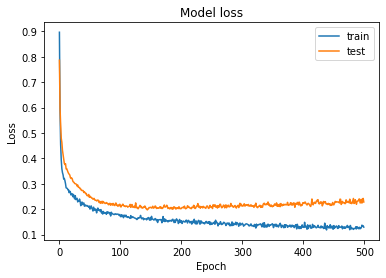

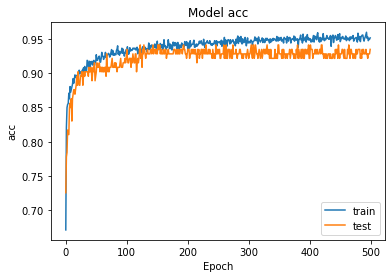

In [61]:
model = Sequential()  # 初始化
input = X_sc.shape[1]
# 隐藏层128
model.add(Dense(128, input_shape=(input,)))  #
model.add(Activation('relu'))
# Dropout层用于防止过拟合
model.add(Dropout(0.5))
# 隐藏层128
model.add(Dense(128))
model.add(Activation('relu'))

model.add(Dense(3))
model.add(Activation('softmax'))
# 使用高效的ADAM优化算法
rmsprop = keras.optimizers.RMSprop(lr=0.001, rho=0.9, epsilon=1e-08, decay=0.0)
model.compile(loss='categorical_crossentropy', optimizer='rmsprop',metrics=['accuracy'])

early_stopping = EarlyStopping(monitor='val_loss', patience=500, verbose=2)

# 训练
history = model.fit(X_sc, y_c, epochs=500, batch_size=64,shuffle=False,verbose=2,
                   validation_data=(x_test_sc,y_test_c),callbacks=[early_stopping])

# loss曲线
plt.plot(history.history['loss'], label='train')
plt.plot(history.history['val_loss'], label='test')
plt.title('Model loss')
plt.ylabel('Loss')
plt.xlabel('Epoch')
plt.legend()
plt.show()

# acc曲线
plt.plot(history.history['accuracy'], label='train')
plt.plot(history.history['val_accuracy'], label='test')
plt.title('Model acc')
plt.ylabel('acc')
plt.xlabel('Epoch')
plt.legend()
plt.show()

Epoch 1/500
11/11 - 1s - loss: 0.5483 - accuracy: 0.7713 - auc: 0.9222 - val_loss: 0.9540 - val_accuracy: 0.5229 - val_auc: 0.7069 - 1s/epoch - 112ms/step
Epoch 2/500
11/11 - 0s - loss: 0.3226 - accuracy: 0.8799 - auc: 0.9724 - val_loss: 0.5136 - val_accuracy: 0.7712 - val_auc: 0.9323 - 74ms/epoch - 7ms/step
Epoch 3/500
11/11 - 0s - loss: 0.2833 - accuracy: 0.8845 - auc: 0.9788 - val_loss: 0.3310 - val_accuracy: 0.9020 - val_auc: 0.9732 - 71ms/epoch - 6ms/step
Epoch 4/500
11/11 - 0s - loss: 0.2768 - accuracy: 0.8898 - auc: 0.9796 - val_loss: 0.2929 - val_accuracy: 0.9085 - val_auc: 0.9774 - 56ms/epoch - 5ms/step
Epoch 5/500
11/11 - 0s - loss: 0.2551 - accuracy: 0.8974 - auc: 0.9821 - val_loss: 0.2962 - val_accuracy: 0.9085 - val_auc: 0.9774 - 59ms/epoch - 5ms/step
Epoch 6/500
11/11 - 0s - loss: 0.2429 - accuracy: 0.9065 - auc: 0.9835 - val_loss: 0.2845 - val_accuracy: 0.8954 - val_auc: 0.9790 - 66ms/epoch - 6ms/step
Epoch 7/500
11/11 - 0s - loss: 0.2313 - accuracy: 0.9126 - auc: 0.9848

Epoch 54/500
11/11 - 0s - loss: 0.1530 - accuracy: 0.9400 - auc: 0.9931 - val_loss: 0.2222 - val_accuracy: 0.9216 - val_auc: 0.9865 - 62ms/epoch - 6ms/step
Epoch 55/500
11/11 - 0s - loss: 0.1621 - accuracy: 0.9392 - auc: 0.9923 - val_loss: 0.2103 - val_accuracy: 0.9281 - val_auc: 0.9883 - 57ms/epoch - 5ms/step
Epoch 56/500
11/11 - 0s - loss: 0.1510 - accuracy: 0.9407 - auc: 0.9934 - val_loss: 0.2246 - val_accuracy: 0.9085 - val_auc: 0.9863 - 52ms/epoch - 5ms/step
Epoch 57/500
11/11 - 0s - loss: 0.1592 - accuracy: 0.9400 - auc: 0.9924 - val_loss: 0.2181 - val_accuracy: 0.9216 - val_auc: 0.9875 - 61ms/epoch - 6ms/step
Epoch 58/500
11/11 - 0s - loss: 0.1743 - accuracy: 0.9362 - auc: 0.9909 - val_loss: 0.2118 - val_accuracy: 0.9346 - val_auc: 0.9876 - 65ms/epoch - 6ms/step
Epoch 59/500
11/11 - 0s - loss: 0.1519 - accuracy: 0.9460 - auc: 0.9931 - val_loss: 0.2211 - val_accuracy: 0.9281 - val_auc: 0.9850 - 54ms/epoch - 5ms/step
Epoch 60/500
11/11 - 0s - loss: 0.1456 - accuracy: 0.9415 - auc:

Epoch 107/500
11/11 - 0s - loss: 0.1392 - accuracy: 0.9521 - auc: 0.9940 - val_loss: 0.2137 - val_accuracy: 0.9346 - val_auc: 0.9851 - 52ms/epoch - 5ms/step
Epoch 108/500
11/11 - 0s - loss: 0.1380 - accuracy: 0.9521 - auc: 0.9943 - val_loss: 0.2199 - val_accuracy: 0.9281 - val_auc: 0.9867 - 53ms/epoch - 5ms/step
Epoch 109/500
11/11 - 0s - loss: 0.1307 - accuracy: 0.9559 - auc: 0.9947 - val_loss: 0.2316 - val_accuracy: 0.9216 - val_auc: 0.9831 - 53ms/epoch - 5ms/step
Epoch 110/500
11/11 - 0s - loss: 0.1314 - accuracy: 0.9514 - auc: 0.9952 - val_loss: 0.2107 - val_accuracy: 0.9281 - val_auc: 0.9854 - 53ms/epoch - 5ms/step
Epoch 111/500
11/11 - 0s - loss: 0.1289 - accuracy: 0.9529 - auc: 0.9948 - val_loss: 0.2121 - val_accuracy: 0.9281 - val_auc: 0.9877 - 52ms/epoch - 5ms/step
Epoch 112/500
11/11 - 0s - loss: 0.1305 - accuracy: 0.9552 - auc: 0.9944 - val_loss: 0.2182 - val_accuracy: 0.9150 - val_auc: 0.9842 - 52ms/epoch - 5ms/step
Epoch 113/500
11/11 - 0s - loss: 0.1422 - accuracy: 0.9407

Epoch 160/500
11/11 - 0s - loss: 0.1150 - accuracy: 0.9567 - auc: 0.9957 - val_loss: 0.2130 - val_accuracy: 0.9412 - val_auc: 0.9849 - 51ms/epoch - 5ms/step
Epoch 161/500
11/11 - 0s - loss: 0.1142 - accuracy: 0.9597 - auc: 0.9960 - val_loss: 0.2091 - val_accuracy: 0.9412 - val_auc: 0.9858 - 53ms/epoch - 5ms/step
Epoch 162/500
11/11 - 0s - loss: 0.1134 - accuracy: 0.9643 - auc: 0.9954 - val_loss: 0.2194 - val_accuracy: 0.9346 - val_auc: 0.9844 - 54ms/epoch - 5ms/step
Epoch 163/500
11/11 - 0s - loss: 0.1230 - accuracy: 0.9552 - auc: 0.9948 - val_loss: 0.2239 - val_accuracy: 0.9216 - val_auc: 0.9841 - 55ms/epoch - 5ms/step
Epoch 164/500
11/11 - 0s - loss: 0.1114 - accuracy: 0.9612 - auc: 0.9960 - val_loss: 0.2164 - val_accuracy: 0.9346 - val_auc: 0.9850 - 54ms/epoch - 5ms/step
Epoch 165/500
11/11 - 0s - loss: 0.1108 - accuracy: 0.9582 - auc: 0.9956 - val_loss: 0.2069 - val_accuracy: 0.9346 - val_auc: 0.9859 - 58ms/epoch - 5ms/step
Epoch 166/500
11/11 - 0s - loss: 0.1178 - accuracy: 0.9597

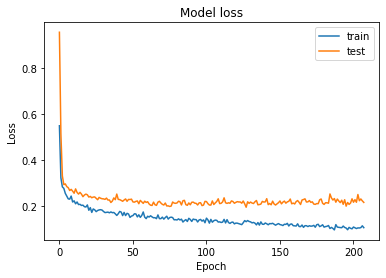

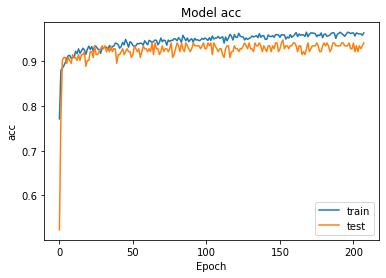

accuracy: 96.60%
Epoch 1/500
11/11 - 2s - loss: 0.6189 - accuracy: 0.7530 - auc: 0.9009 - val_loss: 1.0446 - val_accuracy: 0.3072 - val_auc: 0.6353 - 2s/epoch - 153ms/step
Epoch 2/500
11/11 - 0s - loss: 0.3410 - accuracy: 0.8678 - auc: 0.9698 - val_loss: 0.4699 - val_accuracy: 0.8497 - val_auc: 0.9495 - 61ms/epoch - 6ms/step
Epoch 3/500
11/11 - 0s - loss: 0.2957 - accuracy: 0.8936 - auc: 0.9766 - val_loss: 0.3499 - val_accuracy: 0.8824 - val_auc: 0.9668 - 52ms/epoch - 5ms/step
Epoch 4/500
11/11 - 0s - loss: 0.2948 - accuracy: 0.8875 - auc: 0.9764 - val_loss: 0.3252 - val_accuracy: 0.8824 - val_auc: 0.9713 - 51ms/epoch - 5ms/step
Epoch 5/500
11/11 - 0s - loss: 0.2766 - accuracy: 0.8913 - auc: 0.9787 - val_loss: 0.3119 - val_accuracy: 0.8954 - val_auc: 0.9733 - 46ms/epoch - 4ms/step
Epoch 6/500
11/11 - 0s - loss: 0.2737 - accuracy: 0.8906 - auc: 0.9793 - val_loss: 0.3022 - val_accuracy: 0.8954 - val_auc: 0.9754 - 68ms/epoch - 6ms/step
Epoch 7/500
11/11 - 0s - loss: 0.2618 - accuracy: 0.8

Epoch 54/500
11/11 - 0s - loss: 0.1583 - accuracy: 0.9422 - auc: 0.9926 - val_loss: 0.2255 - val_accuracy: 0.9150 - val_auc: 0.9866 - 68ms/epoch - 6ms/step
Epoch 55/500
11/11 - 0s - loss: 0.1672 - accuracy: 0.9347 - auc: 0.9919 - val_loss: 0.2199 - val_accuracy: 0.9216 - val_auc: 0.9864 - 66ms/epoch - 6ms/step
Epoch 56/500
11/11 - 0s - loss: 0.1616 - accuracy: 0.9415 - auc: 0.9919 - val_loss: 0.2089 - val_accuracy: 0.9150 - val_auc: 0.9878 - 65ms/epoch - 6ms/step
Epoch 57/500
11/11 - 0s - loss: 0.1614 - accuracy: 0.9407 - auc: 0.9921 - val_loss: 0.2164 - val_accuracy: 0.9216 - val_auc: 0.9873 - 56ms/epoch - 5ms/step
Epoch 58/500
11/11 - 0s - loss: 0.1560 - accuracy: 0.9384 - auc: 0.9929 - val_loss: 0.2162 - val_accuracy: 0.9216 - val_auc: 0.9873 - 56ms/epoch - 5ms/step
Epoch 59/500
11/11 - 0s - loss: 0.1525 - accuracy: 0.9438 - auc: 0.9929 - val_loss: 0.2226 - val_accuracy: 0.9216 - val_auc: 0.9865 - 50ms/epoch - 5ms/step
Epoch 60/500
11/11 - 0s - loss: 0.1701 - accuracy: 0.9301 - auc:

Epoch 107/500
11/11 - 0s - loss: 0.1359 - accuracy: 0.9498 - auc: 0.9943 - val_loss: 0.2233 - val_accuracy: 0.9281 - val_auc: 0.9864 - 62ms/epoch - 6ms/step
Epoch 108/500
11/11 - 0s - loss: 0.1436 - accuracy: 0.9468 - auc: 0.9941 - val_loss: 0.2257 - val_accuracy: 0.9281 - val_auc: 0.9858 - 47ms/epoch - 4ms/step
Epoch 109/500
11/11 - 0s - loss: 0.1220 - accuracy: 0.9559 - auc: 0.9955 - val_loss: 0.2154 - val_accuracy: 0.9216 - val_auc: 0.9853 - 74ms/epoch - 7ms/step
Epoch 110/500
11/11 - 0s - loss: 0.1373 - accuracy: 0.9453 - auc: 0.9945 - val_loss: 0.2176 - val_accuracy: 0.9281 - val_auc: 0.9869 - 102ms/epoch - 9ms/step
Epoch 111/500
11/11 - 0s - loss: 0.1320 - accuracy: 0.9552 - auc: 0.9948 - val_loss: 0.2157 - val_accuracy: 0.9216 - val_auc: 0.9875 - 71ms/epoch - 6ms/step
Epoch 112/500
11/11 - 0s - loss: 0.1268 - accuracy: 0.9559 - auc: 0.9951 - val_loss: 0.2130 - val_accuracy: 0.9281 - val_auc: 0.9874 - 47ms/epoch - 4ms/step
Epoch 113/500
11/11 - 0s - loss: 0.1290 - accuracy: 0.951

Epoch 160/500
11/11 - 0s - loss: 0.1240 - accuracy: 0.9544 - auc: 0.9953 - val_loss: 0.2215 - val_accuracy: 0.9281 - val_auc: 0.9837 - 47ms/epoch - 4ms/step
Epoch 161/500
11/11 - 0s - loss: 0.1167 - accuracy: 0.9529 - auc: 0.9962 - val_loss: 0.2231 - val_accuracy: 0.9281 - val_auc: 0.9844 - 62ms/epoch - 6ms/step
Epoch 162/500
11/11 - 0s - loss: 0.0996 - accuracy: 0.9620 - auc: 0.9972 - val_loss: 0.2090 - val_accuracy: 0.9346 - val_auc: 0.9853 - 47ms/epoch - 4ms/step
Epoch 163/500
11/11 - 0s - loss: 0.1124 - accuracy: 0.9559 - auc: 0.9958 - val_loss: 0.2133 - val_accuracy: 0.9281 - val_auc: 0.9852 - 47ms/epoch - 4ms/step
Epoch 164/500
11/11 - 0s - loss: 0.1081 - accuracy: 0.9590 - auc: 0.9964 - val_loss: 0.2065 - val_accuracy: 0.9412 - val_auc: 0.9882 - 62ms/epoch - 6ms/step
Epoch 165/500
11/11 - 0s - loss: 0.1071 - accuracy: 0.9597 - auc: 0.9964 - val_loss: 0.2179 - val_accuracy: 0.9281 - val_auc: 0.9855 - 62ms/epoch - 6ms/step
Epoch 166/500
11/11 - 0s - loss: 0.1078 - accuracy: 0.9612

Epoch 213/500
11/11 - 0s - loss: 0.1069 - accuracy: 0.9635 - auc: 0.9962 - val_loss: 0.2189 - val_accuracy: 0.9412 - val_auc: 0.9846 - 52ms/epoch - 5ms/step
Epoch 214/500
11/11 - 0s - loss: 0.1123 - accuracy: 0.9529 - auc: 0.9962 - val_loss: 0.2206 - val_accuracy: 0.9412 - val_auc: 0.9845 - 55ms/epoch - 5ms/step
Epoch 215/500
11/11 - 0s - loss: 0.1079 - accuracy: 0.9620 - auc: 0.9964 - val_loss: 0.2311 - val_accuracy: 0.9412 - val_auc: 0.9807 - 53ms/epoch - 5ms/step
Epoch 216/500
11/11 - 0s - loss: 0.0966 - accuracy: 0.9650 - auc: 0.9970 - val_loss: 0.2314 - val_accuracy: 0.9412 - val_auc: 0.9807 - 55ms/epoch - 5ms/step
Epoch 216: early stopping


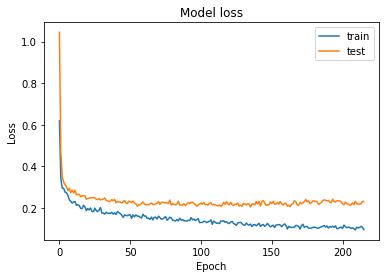

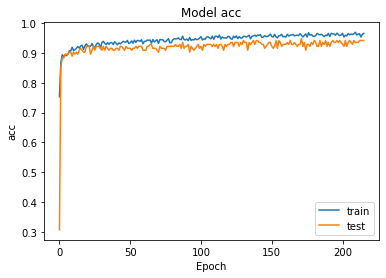

accuracy: 93.88%
Epoch 1/500
11/11 - 1s - loss: 0.6610 - accuracy: 0.7325 - auc: 0.8878 - val_loss: 0.7460 - val_accuracy: 0.7255 - val_auc: 0.9071 - 1s/epoch - 121ms/step
Epoch 2/500
11/11 - 0s - loss: 0.3460 - accuracy: 0.8594 - auc: 0.9681 - val_loss: 0.4139 - val_accuracy: 0.8693 - val_auc: 0.9708 - 62ms/epoch - 6ms/step
Epoch 3/500
11/11 - 0s - loss: 0.3061 - accuracy: 0.8769 - auc: 0.9745 - val_loss: 0.3070 - val_accuracy: 0.8758 - val_auc: 0.9769 - 47ms/epoch - 4ms/step
Epoch 4/500
11/11 - 0s - loss: 0.2889 - accuracy: 0.8792 - auc: 0.9773 - val_loss: 0.2974 - val_accuracy: 0.8889 - val_auc: 0.9771 - 47ms/epoch - 4ms/step
Epoch 5/500
11/11 - 0s - loss: 0.2730 - accuracy: 0.8860 - auc: 0.9798 - val_loss: 0.2854 - val_accuracy: 0.8758 - val_auc: 0.9784 - 47ms/epoch - 4ms/step
Epoch 6/500
11/11 - 0s - loss: 0.2653 - accuracy: 0.8921 - auc: 0.9805 - val_loss: 0.2718 - val_accuracy: 0.9020 - val_auc: 0.9812 - 47ms/epoch - 4ms/step
Epoch 7/500
11/11 - 0s - loss: 0.2502 - accuracy: 0.9

Epoch 54/500
11/11 - 0s - loss: 0.1655 - accuracy: 0.9400 - auc: 0.9921 - val_loss: 0.1946 - val_accuracy: 0.9281 - val_auc: 0.9891 - 60ms/epoch - 5ms/step
Epoch 55/500
11/11 - 0s - loss: 0.1751 - accuracy: 0.9392 - auc: 0.9907 - val_loss: 0.1977 - val_accuracy: 0.9281 - val_auc: 0.9891 - 44ms/epoch - 4ms/step
Epoch 56/500
11/11 - 0s - loss: 0.1677 - accuracy: 0.9316 - auc: 0.9916 - val_loss: 0.1947 - val_accuracy: 0.9346 - val_auc: 0.9894 - 72ms/epoch - 7ms/step
Epoch 57/500
11/11 - 0s - loss: 0.1632 - accuracy: 0.9430 - auc: 0.9919 - val_loss: 0.1946 - val_accuracy: 0.9346 - val_auc: 0.9898 - 51ms/epoch - 5ms/step
Epoch 58/500
11/11 - 0s - loss: 0.1663 - accuracy: 0.9384 - auc: 0.9920 - val_loss: 0.1900 - val_accuracy: 0.9346 - val_auc: 0.9901 - 47ms/epoch - 4ms/step
Epoch 59/500
11/11 - 0s - loss: 0.1610 - accuracy: 0.9377 - auc: 0.9918 - val_loss: 0.1850 - val_accuracy: 0.9412 - val_auc: 0.9908 - 47ms/epoch - 4ms/step
Epoch 60/500
11/11 - 0s - loss: 0.1596 - accuracy: 0.9445 - auc:

Epoch 107/500
11/11 - 0s - loss: 0.1443 - accuracy: 0.9491 - auc: 0.9938 - val_loss: 0.2020 - val_accuracy: 0.9150 - val_auc: 0.9885 - 63ms/epoch - 6ms/step
Epoch 108/500
11/11 - 0s - loss: 0.1367 - accuracy: 0.9476 - auc: 0.9947 - val_loss: 0.1993 - val_accuracy: 0.9281 - val_auc: 0.9885 - 51ms/epoch - 5ms/step
Epoch 109/500
11/11 - 0s - loss: 0.1315 - accuracy: 0.9559 - auc: 0.9950 - val_loss: 0.2002 - val_accuracy: 0.9346 - val_auc: 0.9886 - 64ms/epoch - 6ms/step
Epoch 110/500
11/11 - 0s - loss: 0.1397 - accuracy: 0.9514 - auc: 0.9940 - val_loss: 0.2038 - val_accuracy: 0.9346 - val_auc: 0.9880 - 60ms/epoch - 5ms/step
Epoch 111/500
11/11 - 0s - loss: 0.1281 - accuracy: 0.9544 - auc: 0.9949 - val_loss: 0.1898 - val_accuracy: 0.9281 - val_auc: 0.9894 - 62ms/epoch - 6ms/step
Epoch 112/500
11/11 - 0s - loss: 0.1379 - accuracy: 0.9514 - auc: 0.9936 - val_loss: 0.1966 - val_accuracy: 0.9346 - val_auc: 0.9887 - 66ms/epoch - 6ms/step
Epoch 113/500
11/11 - 0s - loss: 0.1146 - accuracy: 0.9567

Epoch 160/500
11/11 - 0s - loss: 0.1200 - accuracy: 0.9590 - auc: 0.9950 - val_loss: 0.2129 - val_accuracy: 0.9477 - val_auc: 0.9861 - 58ms/epoch - 5ms/step
Epoch 161/500
11/11 - 0s - loss: 0.1075 - accuracy: 0.9582 - auc: 0.9964 - val_loss: 0.2152 - val_accuracy: 0.9412 - val_auc: 0.9867 - 55ms/epoch - 5ms/step
Epoch 162/500
11/11 - 0s - loss: 0.1236 - accuracy: 0.9476 - auc: 0.9954 - val_loss: 0.2487 - val_accuracy: 0.9281 - val_auc: 0.9804 - 55ms/epoch - 5ms/step
Epoch 163/500
11/11 - 0s - loss: 0.1151 - accuracy: 0.9597 - auc: 0.9959 - val_loss: 0.2283 - val_accuracy: 0.9281 - val_auc: 0.9850 - 56ms/epoch - 5ms/step
Epoch 164/500
11/11 - 0s - loss: 0.1186 - accuracy: 0.9559 - auc: 0.9955 - val_loss: 0.2535 - val_accuracy: 0.9216 - val_auc: 0.9771 - 60ms/epoch - 5ms/step
Epoch 165/500
11/11 - 0s - loss: 0.1141 - accuracy: 0.9643 - auc: 0.9951 - val_loss: 0.2146 - val_accuracy: 0.9412 - val_auc: 0.9858 - 57ms/epoch - 5ms/step
Epoch 166/500
11/11 - 0s - loss: 0.1114 - accuracy: 0.9643

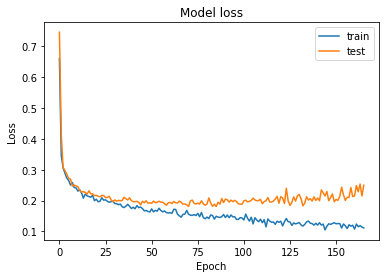

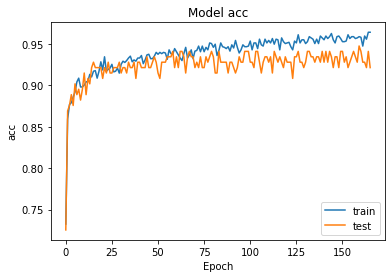

accuracy: 95.24%
Epoch 1/500
11/11 - 1s - loss: 0.5768 - accuracy: 0.7692 - auc: 0.9149 - val_loss: 0.7481 - val_accuracy: 0.8627 - val_auc: 0.9523 - 1s/epoch - 110ms/step
Epoch 2/500
11/11 - 0s - loss: 0.3218 - accuracy: 0.8778 - auc: 0.9727 - val_loss: 0.4210 - val_accuracy: 0.8758 - val_auc: 0.9627 - 38ms/epoch - 3ms/step
Epoch 3/500
11/11 - 0s - loss: 0.3160 - accuracy: 0.8770 - auc: 0.9734 - val_loss: 0.3312 - val_accuracy: 0.8824 - val_auc: 0.9707 - 64ms/epoch - 6ms/step
Epoch 4/500
11/11 - 0s - loss: 0.2818 - accuracy: 0.8869 - auc: 0.9787 - val_loss: 0.3068 - val_accuracy: 0.8954 - val_auc: 0.9749 - 47ms/epoch - 4ms/step
Epoch 5/500
11/11 - 0s - loss: 0.2576 - accuracy: 0.9028 - auc: 0.9824 - val_loss: 0.3031 - val_accuracy: 0.8758 - val_auc: 0.9758 - 46ms/epoch - 4ms/step
Epoch 6/500
11/11 - 0s - loss: 0.2603 - accuracy: 0.9021 - auc: 0.9813 - val_loss: 0.2942 - val_accuracy: 0.8954 - val_auc: 0.9773 - 47ms/epoch - 4ms/step
Epoch 7/500
11/11 - 0s - loss: 0.2576 - accuracy: 0.8

Epoch 54/500
11/11 - 0s - loss: 0.1580 - accuracy: 0.9339 - auc: 0.9929 - val_loss: 0.2276 - val_accuracy: 0.9216 - val_auc: 0.9860 - 50ms/epoch - 5ms/step
Epoch 55/500
11/11 - 0s - loss: 0.1608 - accuracy: 0.9385 - auc: 0.9926 - val_loss: 0.2258 - val_accuracy: 0.9150 - val_auc: 0.9859 - 49ms/epoch - 4ms/step
Epoch 56/500
11/11 - 0s - loss: 0.1601 - accuracy: 0.9468 - auc: 0.9923 - val_loss: 0.2383 - val_accuracy: 0.9085 - val_auc: 0.9840 - 49ms/epoch - 4ms/step
Epoch 57/500
11/11 - 0s - loss: 0.1694 - accuracy: 0.9362 - auc: 0.9917 - val_loss: 0.2219 - val_accuracy: 0.9216 - val_auc: 0.9865 - 57ms/epoch - 5ms/step
Epoch 58/500
11/11 - 0s - loss: 0.1641 - accuracy: 0.9309 - auc: 0.9919 - val_loss: 0.2086 - val_accuracy: 0.9216 - val_auc: 0.9874 - 52ms/epoch - 5ms/step
Epoch 59/500
11/11 - 0s - loss: 0.1591 - accuracy: 0.9355 - auc: 0.9923 - val_loss: 0.2176 - val_accuracy: 0.9216 - val_auc: 0.9863 - 53ms/epoch - 5ms/step
Epoch 60/500
11/11 - 0s - loss: 0.1599 - accuracy: 0.9377 - auc:

Epoch 107/500
11/11 - 0s - loss: 0.1381 - accuracy: 0.9423 - auc: 0.9944 - val_loss: 0.2049 - val_accuracy: 0.9085 - val_auc: 0.9884 - 68ms/epoch - 6ms/step
Epoch 108/500
11/11 - 0s - loss: 0.1456 - accuracy: 0.9484 - auc: 0.9929 - val_loss: 0.2062 - val_accuracy: 0.9346 - val_auc: 0.9883 - 140ms/epoch - 13ms/step
Epoch 109/500
11/11 - 0s - loss: 0.1366 - accuracy: 0.9438 - auc: 0.9942 - val_loss: 0.2143 - val_accuracy: 0.9281 - val_auc: 0.9871 - 109ms/epoch - 10ms/step
Epoch 110/500
11/11 - 0s - loss: 0.1356 - accuracy: 0.9522 - auc: 0.9942 - val_loss: 0.2012 - val_accuracy: 0.9281 - val_auc: 0.9886 - 62ms/epoch - 6ms/step
Epoch 111/500
11/11 - 0s - loss: 0.1384 - accuracy: 0.9484 - auc: 0.9942 - val_loss: 0.1935 - val_accuracy: 0.9281 - val_auc: 0.9894 - 79ms/epoch - 7ms/step
Epoch 112/500
11/11 - 0s - loss: 0.1509 - accuracy: 0.9431 - auc: 0.9929 - val_loss: 0.2007 - val_accuracy: 0.9281 - val_auc: 0.9886 - 62ms/epoch - 6ms/step
Epoch 113/500
11/11 - 0s - loss: 0.1336 - accuracy: 0.

Epoch 160/500
11/11 - 0s - loss: 0.1232 - accuracy: 0.9552 - auc: 0.9948 - val_loss: 0.2090 - val_accuracy: 0.9281 - val_auc: 0.9874 - 62ms/epoch - 6ms/step
Epoch 161/500
11/11 - 0s - loss: 0.1306 - accuracy: 0.9484 - auc: 0.9948 - val_loss: 0.1968 - val_accuracy: 0.9346 - val_auc: 0.9885 - 62ms/epoch - 6ms/step
Epoch 162/500
11/11 - 0s - loss: 0.1300 - accuracy: 0.9438 - auc: 0.9949 - val_loss: 0.2275 - val_accuracy: 0.9216 - val_auc: 0.9861 - 62ms/epoch - 6ms/step
Epoch 163/500
11/11 - 0s - loss: 0.1299 - accuracy: 0.9552 - auc: 0.9943 - val_loss: 0.2097 - val_accuracy: 0.9281 - val_auc: 0.9872 - 62ms/epoch - 6ms/step
Epoch 164/500
11/11 - 0s - loss: 0.1307 - accuracy: 0.9529 - auc: 0.9946 - val_loss: 0.2109 - val_accuracy: 0.9281 - val_auc: 0.9869 - 47ms/epoch - 4ms/step
Epoch 165/500
11/11 - 0s - loss: 0.1164 - accuracy: 0.9590 - auc: 0.9962 - val_loss: 0.2259 - val_accuracy: 0.9216 - val_auc: 0.9857 - 47ms/epoch - 4ms/step
Epoch 166/500
11/11 - 0s - loss: 0.1238 - accuracy: 0.9537

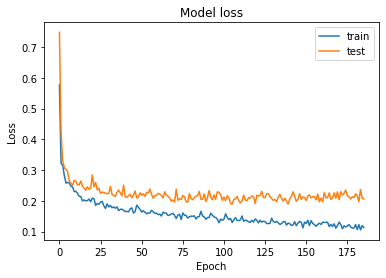

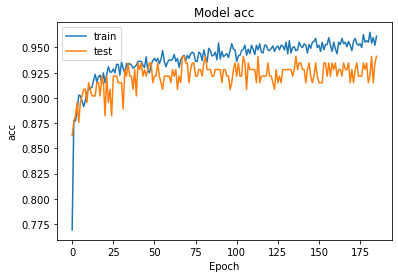

accuracy: 97.26%
Epoch 1/500
11/11 - 1s - loss: 0.6310 - accuracy: 0.7692 - auc: 0.9024 - val_loss: 0.9098 - val_accuracy: 0.5163 - val_auc: 0.7444 - 1s/epoch - 110ms/step
Epoch 2/500
11/11 - 0s - loss: 0.3224 - accuracy: 0.8694 - auc: 0.9722 - val_loss: 0.4857 - val_accuracy: 0.8039 - val_auc: 0.9465 - 47ms/epoch - 4ms/step
Epoch 3/500
11/11 - 0s - loss: 0.2740 - accuracy: 0.8922 - auc: 0.9794 - val_loss: 0.3789 - val_accuracy: 0.8889 - val_auc: 0.9625 - 47ms/epoch - 4ms/step
Epoch 4/500
11/11 - 0s - loss: 0.2725 - accuracy: 0.8891 - auc: 0.9799 - val_loss: 0.3254 - val_accuracy: 0.8954 - val_auc: 0.9708 - 36ms/epoch - 3ms/step
Epoch 5/500
11/11 - 0s - loss: 0.2474 - accuracy: 0.8937 - auc: 0.9832 - val_loss: 0.2950 - val_accuracy: 0.9150 - val_auc: 0.9765 - 31ms/epoch - 3ms/step
Epoch 6/500
11/11 - 0s - loss: 0.2364 - accuracy: 0.9028 - auc: 0.9848 - val_loss: 0.2756 - val_accuracy: 0.9216 - val_auc: 0.9798 - 47ms/epoch - 4ms/step
Epoch 7/500
11/11 - 0s - loss: 0.2290 - accuracy: 0.9

Epoch 54/500
11/11 - 0s - loss: 0.1502 - accuracy: 0.9423 - auc: 0.9935 - val_loss: 0.2023 - val_accuracy: 0.9281 - val_auc: 0.9891 - 47ms/epoch - 4ms/step
Epoch 55/500
11/11 - 0s - loss: 0.1457 - accuracy: 0.9408 - auc: 0.9936 - val_loss: 0.1970 - val_accuracy: 0.9216 - val_auc: 0.9900 - 62ms/epoch - 6ms/step
Epoch 56/500
11/11 - 0s - loss: 0.1470 - accuracy: 0.9446 - auc: 0.9935 - val_loss: 0.2010 - val_accuracy: 0.9150 - val_auc: 0.9892 - 47ms/epoch - 4ms/step
Epoch 57/500
11/11 - 0s - loss: 0.1465 - accuracy: 0.9415 - auc: 0.9941 - val_loss: 0.2094 - val_accuracy: 0.9216 - val_auc: 0.9879 - 62ms/epoch - 6ms/step
Epoch 58/500
11/11 - 0s - loss: 0.1528 - accuracy: 0.9476 - auc: 0.9927 - val_loss: 0.1991 - val_accuracy: 0.9216 - val_auc: 0.9900 - 60ms/epoch - 5ms/step
Epoch 59/500
11/11 - 0s - loss: 0.1667 - accuracy: 0.9355 - auc: 0.9922 - val_loss: 0.1984 - val_accuracy: 0.9216 - val_auc: 0.9894 - 45ms/epoch - 4ms/step
Epoch 60/500
11/11 - 0s - loss: 0.1528 - accuracy: 0.9393 - auc:

Epoch 107/500
11/11 - 0s - loss: 0.1250 - accuracy: 0.9544 - auc: 0.9947 - val_loss: 0.1998 - val_accuracy: 0.9216 - val_auc: 0.9890 - 54ms/epoch - 5ms/step
Epoch 108/500
11/11 - 0s - loss: 0.1328 - accuracy: 0.9499 - auc: 0.9937 - val_loss: 0.2078 - val_accuracy: 0.9085 - val_auc: 0.9878 - 47ms/epoch - 4ms/step
Epoch 109/500
11/11 - 0s - loss: 0.1263 - accuracy: 0.9560 - auc: 0.9950 - val_loss: 0.2107 - val_accuracy: 0.9150 - val_auc: 0.9880 - 47ms/epoch - 4ms/step
Epoch 110/500
11/11 - 0s - loss: 0.1315 - accuracy: 0.9514 - auc: 0.9949 - val_loss: 0.1949 - val_accuracy: 0.9150 - val_auc: 0.9899 - 62ms/epoch - 6ms/step
Epoch 111/500
11/11 - 0s - loss: 0.1363 - accuracy: 0.9446 - auc: 0.9941 - val_loss: 0.2087 - val_accuracy: 0.9150 - val_auc: 0.9865 - 47ms/epoch - 4ms/step
Epoch 112/500
11/11 - 0s - loss: 0.1319 - accuracy: 0.9537 - auc: 0.9942 - val_loss: 0.1865 - val_accuracy: 0.9346 - val_auc: 0.9904 - 62ms/epoch - 6ms/step
Epoch 113/500
11/11 - 0s - loss: 0.1365 - accuracy: 0.9544

Epoch 160/500
11/11 - 0s - loss: 0.1137 - accuracy: 0.9567 - auc: 0.9958 - val_loss: 0.1825 - val_accuracy: 0.9281 - val_auc: 0.9902 - 57ms/epoch - 5ms/step
Epoch 161/500
11/11 - 0s - loss: 0.1102 - accuracy: 0.9575 - auc: 0.9963 - val_loss: 0.1988 - val_accuracy: 0.9477 - val_auc: 0.9889 - 53ms/epoch - 5ms/step
Epoch 162/500
11/11 - 0s - loss: 0.1071 - accuracy: 0.9613 - auc: 0.9966 - val_loss: 0.2082 - val_accuracy: 0.9216 - val_auc: 0.9860 - 40ms/epoch - 4ms/step
Epoch 163/500
11/11 - 0s - loss: 0.1065 - accuracy: 0.9575 - auc: 0.9962 - val_loss: 0.2272 - val_accuracy: 0.9281 - val_auc: 0.9849 - 62ms/epoch - 6ms/step
Epoch 164/500
11/11 - 0s - loss: 0.1011 - accuracy: 0.9636 - auc: 0.9968 - val_loss: 0.2231 - val_accuracy: 0.9281 - val_auc: 0.9850 - 57ms/epoch - 5ms/step
Epoch 165/500
11/11 - 0s - loss: 0.1081 - accuracy: 0.9567 - auc: 0.9961 - val_loss: 0.2212 - val_accuracy: 0.9281 - val_auc: 0.9850 - 47ms/epoch - 4ms/step
Epoch 166/500
11/11 - 0s - loss: 0.1111 - accuracy: 0.9605

Epoch 213/500
11/11 - 0s - loss: 0.0973 - accuracy: 0.9590 - auc: 0.9972 - val_loss: 0.2288 - val_accuracy: 0.9216 - val_auc: 0.9819 - 46ms/epoch - 4ms/step
Epoch 214/500
11/11 - 0s - loss: 0.0987 - accuracy: 0.9666 - auc: 0.9966 - val_loss: 0.2013 - val_accuracy: 0.9412 - val_auc: 0.9867 - 60ms/epoch - 5ms/step
Epoch 215/500
11/11 - 0s - loss: 0.0980 - accuracy: 0.9613 - auc: 0.9966 - val_loss: 0.2064 - val_accuracy: 0.9477 - val_auc: 0.9865 - 55ms/epoch - 5ms/step
Epoch 216/500
11/11 - 0s - loss: 0.0993 - accuracy: 0.9636 - auc: 0.9966 - val_loss: 0.2082 - val_accuracy: 0.9412 - val_auc: 0.9859 - 53ms/epoch - 5ms/step
Epoch 217/500
11/11 - 0s - loss: 0.1004 - accuracy: 0.9613 - auc: 0.9961 - val_loss: 0.2519 - val_accuracy: 0.9150 - val_auc: 0.9798 - 54ms/epoch - 5ms/step
Epoch 218/500
11/11 - 0s - loss: 0.1021 - accuracy: 0.9590 - auc: 0.9968 - val_loss: 0.2137 - val_accuracy: 0.9281 - val_auc: 0.9825 - 53ms/epoch - 5ms/step
Epoch 219/500
11/11 - 0s - loss: 0.1101 - accuracy: 0.9598

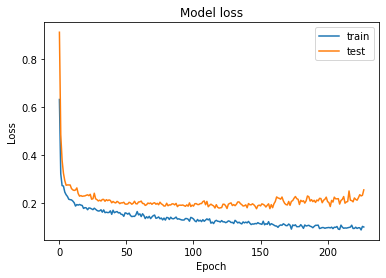

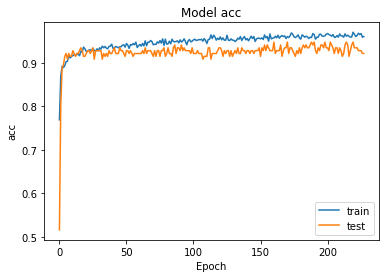

accuracy: 91.10%
Epoch 1/500
11/11 - 1s - loss: 0.5825 - accuracy: 0.7623 - auc: 0.9102 - val_loss: 0.6969 - val_accuracy: 0.8105 - val_auc: 0.9457 - 1s/epoch - 113ms/step
Epoch 2/500
11/11 - 0s - loss: 0.3306 - accuracy: 0.8648 - auc: 0.9712 - val_loss: 0.3941 - val_accuracy: 0.8693 - val_auc: 0.9715 - 48ms/epoch - 4ms/step
Epoch 3/500
11/11 - 0s - loss: 0.2892 - accuracy: 0.8914 - auc: 0.9777 - val_loss: 0.3099 - val_accuracy: 0.8824 - val_auc: 0.9750 - 50ms/epoch - 5ms/step
Epoch 4/500
11/11 - 0s - loss: 0.2539 - accuracy: 0.8960 - auc: 0.9822 - val_loss: 0.2863 - val_accuracy: 0.8889 - val_auc: 0.9787 - 51ms/epoch - 5ms/step
Epoch 5/500
11/11 - 0s - loss: 0.2555 - accuracy: 0.9021 - auc: 0.9821 - val_loss: 0.2838 - val_accuracy: 0.8889 - val_auc: 0.9787 - 50ms/epoch - 5ms/step
Epoch 6/500
11/11 - 0s - loss: 0.2424 - accuracy: 0.9005 - auc: 0.9837 - val_loss: 0.2680 - val_accuracy: 0.8954 - val_auc: 0.9813 - 52ms/epoch - 5ms/step
Epoch 7/500
11/11 - 0s - loss: 0.2437 - accuracy: 0.9

Epoch 54/500
11/11 - 0s - loss: 0.1640 - accuracy: 0.9385 - auc: 0.9918 - val_loss: 0.2157 - val_accuracy: 0.9281 - val_auc: 0.9870 - 50ms/epoch - 5ms/step
Epoch 55/500
11/11 - 0s - loss: 0.1542 - accuracy: 0.9461 - auc: 0.9928 - val_loss: 0.2137 - val_accuracy: 0.9281 - val_auc: 0.9876 - 54ms/epoch - 5ms/step
Epoch 56/500
11/11 - 0s - loss: 0.1546 - accuracy: 0.9332 - auc: 0.9930 - val_loss: 0.2028 - val_accuracy: 0.9281 - val_auc: 0.9882 - 50ms/epoch - 5ms/step
Epoch 57/500
11/11 - 0s - loss: 0.1577 - accuracy: 0.9370 - auc: 0.9925 - val_loss: 0.2044 - val_accuracy: 0.9281 - val_auc: 0.9884 - 51ms/epoch - 5ms/step
Epoch 58/500
11/11 - 0s - loss: 0.1637 - accuracy: 0.9332 - auc: 0.9922 - val_loss: 0.2171 - val_accuracy: 0.9216 - val_auc: 0.9872 - 60ms/epoch - 5ms/step
Epoch 59/500
11/11 - 0s - loss: 0.1606 - accuracy: 0.9339 - auc: 0.9923 - val_loss: 0.2173 - val_accuracy: 0.9281 - val_auc: 0.9867 - 57ms/epoch - 5ms/step
Epoch 60/500
11/11 - 0s - loss: 0.1551 - accuracy: 0.9370 - auc:

Epoch 107/500
11/11 - 0s - loss: 0.1241 - accuracy: 0.9484 - auc: 0.9953 - val_loss: 0.2437 - val_accuracy: 0.9085 - val_auc: 0.9841 - 62ms/epoch - 6ms/step
Epoch 108/500
11/11 - 0s - loss: 0.1263 - accuracy: 0.9506 - auc: 0.9949 - val_loss: 0.2328 - val_accuracy: 0.9281 - val_auc: 0.9824 - 47ms/epoch - 4ms/step
Epoch 109/500
11/11 - 0s - loss: 0.1317 - accuracy: 0.9506 - auc: 0.9943 - val_loss: 0.2279 - val_accuracy: 0.9216 - val_auc: 0.9861 - 62ms/epoch - 6ms/step
Epoch 110/500
11/11 - 0s - loss: 0.1287 - accuracy: 0.9560 - auc: 0.9949 - val_loss: 0.2057 - val_accuracy: 0.9412 - val_auc: 0.9880 - 62ms/epoch - 6ms/step
Epoch 111/500
11/11 - 0s - loss: 0.1197 - accuracy: 0.9529 - auc: 0.9955 - val_loss: 0.2072 - val_accuracy: 0.9477 - val_auc: 0.9878 - 62ms/epoch - 6ms/step
Epoch 112/500
11/11 - 0s - loss: 0.1328 - accuracy: 0.9484 - auc: 0.9941 - val_loss: 0.2055 - val_accuracy: 0.9281 - val_auc: 0.9882 - 47ms/epoch - 4ms/step
Epoch 113/500
11/11 - 0s - loss: 0.1240 - accuracy: 0.9506

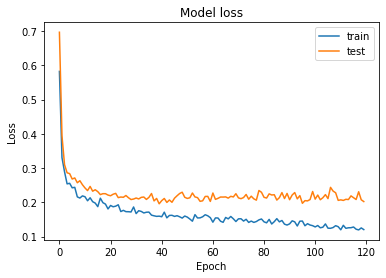

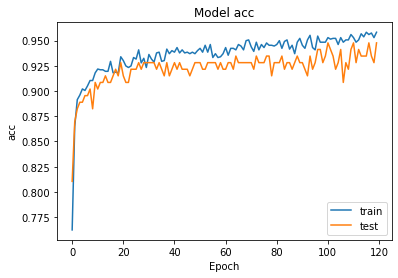

accuracy: 93.84%
Epoch 1/500
11/11 - 1s - loss: 0.5428 - accuracy: 0.7760 - auc: 0.9218 - val_loss: 0.7665 - val_accuracy: 0.7255 - val_auc: 0.9063 - 1s/epoch - 119ms/step
Epoch 2/500
11/11 - 0s - loss: 0.3100 - accuracy: 0.8686 - auc: 0.9749 - val_loss: 0.4268 - val_accuracy: 0.8693 - val_auc: 0.9650 - 62ms/epoch - 6ms/step
Epoch 3/500
11/11 - 0s - loss: 0.2845 - accuracy: 0.8891 - auc: 0.9781 - val_loss: 0.3236 - val_accuracy: 0.8758 - val_auc: 0.9733 - 47ms/epoch - 4ms/step
Epoch 4/500
11/11 - 0s - loss: 0.2658 - accuracy: 0.8861 - auc: 0.9805 - val_loss: 0.3101 - val_accuracy: 0.8824 - val_auc: 0.9741 - 47ms/epoch - 4ms/step
Epoch 5/500
11/11 - 0s - loss: 0.2445 - accuracy: 0.8983 - auc: 0.9839 - val_loss: 0.2825 - val_accuracy: 0.8889 - val_auc: 0.9785 - 62ms/epoch - 6ms/step
Epoch 6/500
11/11 - 0s - loss: 0.2478 - accuracy: 0.9051 - auc: 0.9826 - val_loss: 0.2737 - val_accuracy: 0.8824 - val_auc: 0.9795 - 47ms/epoch - 4ms/step
Epoch 7/500
11/11 - 0s - loss: 0.2287 - accuracy: 0.9

Epoch 54/500
11/11 - 0s - loss: 0.1625 - accuracy: 0.9446 - auc: 0.9920 - val_loss: 0.2200 - val_accuracy: 0.9150 - val_auc: 0.9862 - 58ms/epoch - 5ms/step
Epoch 55/500
11/11 - 0s - loss: 0.1600 - accuracy: 0.9339 - auc: 0.9926 - val_loss: 0.2092 - val_accuracy: 0.9216 - val_auc: 0.9876 - 53ms/epoch - 5ms/step
Epoch 56/500
11/11 - 0s - loss: 0.1594 - accuracy: 0.9347 - auc: 0.9923 - val_loss: 0.2109 - val_accuracy: 0.9281 - val_auc: 0.9876 - 58ms/epoch - 5ms/step
Epoch 57/500
11/11 - 0s - loss: 0.1596 - accuracy: 0.9377 - auc: 0.9928 - val_loss: 0.2111 - val_accuracy: 0.9085 - val_auc: 0.9871 - 57ms/epoch - 5ms/step
Epoch 58/500
11/11 - 0s - loss: 0.1687 - accuracy: 0.9347 - auc: 0.9912 - val_loss: 0.1960 - val_accuracy: 0.9281 - val_auc: 0.9893 - 59ms/epoch - 5ms/step
Epoch 59/500
11/11 - 0s - loss: 0.1510 - accuracy: 0.9461 - auc: 0.9934 - val_loss: 0.1949 - val_accuracy: 0.9281 - val_auc: 0.9896 - 60ms/epoch - 5ms/step
Epoch 60/500
11/11 - 0s - loss: 0.1600 - accuracy: 0.9355 - auc:

Epoch 107/500
11/11 - 0s - loss: 0.1426 - accuracy: 0.9491 - auc: 0.9937 - val_loss: 0.2185 - val_accuracy: 0.9216 - val_auc: 0.9866 - 58ms/epoch - 5ms/step
Epoch 108/500
11/11 - 0s - loss: 0.1488 - accuracy: 0.9377 - auc: 0.9932 - val_loss: 0.2264 - val_accuracy: 0.9216 - val_auc: 0.9838 - 52ms/epoch - 5ms/step
Epoch 109/500
11/11 - 0s - loss: 0.1373 - accuracy: 0.9522 - auc: 0.9946 - val_loss: 0.2135 - val_accuracy: 0.9346 - val_auc: 0.9850 - 47ms/epoch - 4ms/step
Epoch 110/500
11/11 - 0s - loss: 0.1345 - accuracy: 0.9499 - auc: 0.9945 - val_loss: 0.2153 - val_accuracy: 0.9346 - val_auc: 0.9864 - 47ms/epoch - 4ms/step
Epoch 111/500
11/11 - 0s - loss: 0.1412 - accuracy: 0.9506 - auc: 0.9936 - val_loss: 0.2031 - val_accuracy: 0.9281 - val_auc: 0.9859 - 74ms/epoch - 7ms/step
Epoch 112/500
11/11 - 0s - loss: 0.1386 - accuracy: 0.9468 - auc: 0.9942 - val_loss: 0.2063 - val_accuracy: 0.9281 - val_auc: 0.9856 - 64ms/epoch - 6ms/step
Epoch 113/500
11/11 - 0s - loss: 0.1398 - accuracy: 0.9476

Epoch 160/500
11/11 - 0s - loss: 0.1280 - accuracy: 0.9537 - auc: 0.9949 - val_loss: 0.2314 - val_accuracy: 0.9412 - val_auc: 0.9838 - 57ms/epoch - 5ms/step
Epoch 161/500
11/11 - 0s - loss: 0.1208 - accuracy: 0.9605 - auc: 0.9946 - val_loss: 0.2334 - val_accuracy: 0.9281 - val_auc: 0.9804 - 57ms/epoch - 5ms/step
Epoch 162/500
11/11 - 0s - loss: 0.1268 - accuracy: 0.9522 - auc: 0.9949 - val_loss: 0.2439 - val_accuracy: 0.9412 - val_auc: 0.9797 - 60ms/epoch - 5ms/step
Epoch 163/500
11/11 - 0s - loss: 0.1160 - accuracy: 0.9598 - auc: 0.9959 - val_loss: 0.2631 - val_accuracy: 0.9020 - val_auc: 0.9762 - 53ms/epoch - 5ms/step
Epoch 164/500
11/11 - 0s - loss: 0.1154 - accuracy: 0.9582 - auc: 0.9957 - val_loss: 0.2233 - val_accuracy: 0.9346 - val_auc: 0.9845 - 60ms/epoch - 5ms/step
Epoch 165/500
11/11 - 0s - loss: 0.1248 - accuracy: 0.9560 - auc: 0.9944 - val_loss: 0.2476 - val_accuracy: 0.9216 - val_auc: 0.9786 - 56ms/epoch - 5ms/step
Epoch 166/500
11/11 - 0s - loss: 0.1354 - accuracy: 0.9453

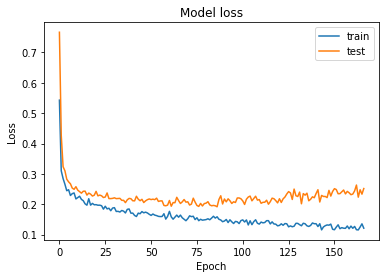

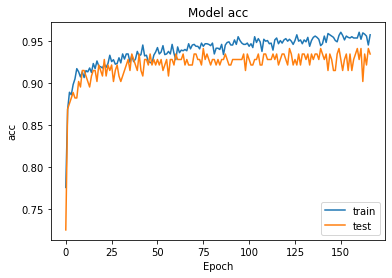

accuracy: 96.58%
Epoch 1/500
11/11 - 1s - loss: 0.5624 - accuracy: 0.7692 - auc: 0.9194 - val_loss: 0.7083 - val_accuracy: 0.8301 - val_auc: 0.9429 - 1s/epoch - 115ms/step
Epoch 2/500
11/11 - 0s - loss: 0.3367 - accuracy: 0.8679 - auc: 0.9705 - val_loss: 0.3982 - val_accuracy: 0.8758 - val_auc: 0.9680 - 53ms/epoch - 5ms/step
Epoch 3/500
11/11 - 0s - loss: 0.2700 - accuracy: 0.9058 - auc: 0.9807 - val_loss: 0.3357 - val_accuracy: 0.8889 - val_auc: 0.9698 - 51ms/epoch - 5ms/step
Epoch 4/500
11/11 - 0s - loss: 0.2608 - accuracy: 0.9021 - auc: 0.9813 - val_loss: 0.3139 - val_accuracy: 0.8954 - val_auc: 0.9737 - 53ms/epoch - 5ms/step
Epoch 5/500
11/11 - 0s - loss: 0.2631 - accuracy: 0.9005 - auc: 0.9814 - val_loss: 0.3049 - val_accuracy: 0.9020 - val_auc: 0.9743 - 41ms/epoch - 4ms/step
Epoch 6/500
11/11 - 0s - loss: 0.2369 - accuracy: 0.9096 - auc: 0.9848 - val_loss: 0.2896 - val_accuracy: 0.8954 - val_auc: 0.9774 - 62ms/epoch - 6ms/step
Epoch 7/500
11/11 - 0s - loss: 0.2431 - accuracy: 0.9

Epoch 54/500
11/11 - 0s - loss: 0.1616 - accuracy: 0.9423 - auc: 0.9921 - val_loss: 0.2132 - val_accuracy: 0.9216 - val_auc: 0.9875 - 57ms/epoch - 5ms/step
Epoch 55/500
11/11 - 0s - loss: 0.1651 - accuracy: 0.9385 - auc: 0.9917 - val_loss: 0.2036 - val_accuracy: 0.9216 - val_auc: 0.9889 - 57ms/epoch - 5ms/step
Epoch 56/500
11/11 - 0s - loss: 0.1619 - accuracy: 0.9377 - auc: 0.9921 - val_loss: 0.2107 - val_accuracy: 0.9281 - val_auc: 0.9876 - 59ms/epoch - 5ms/step
Epoch 57/500
11/11 - 0s - loss: 0.1581 - accuracy: 0.9446 - auc: 0.9928 - val_loss: 0.2209 - val_accuracy: 0.9216 - val_auc: 0.9861 - 57ms/epoch - 5ms/step
Epoch 58/500
11/11 - 0s - loss: 0.1637 - accuracy: 0.9347 - auc: 0.9921 - val_loss: 0.2019 - val_accuracy: 0.9216 - val_auc: 0.9891 - 57ms/epoch - 5ms/step
Epoch 59/500
11/11 - 0s - loss: 0.1513 - accuracy: 0.9468 - auc: 0.9928 - val_loss: 0.2273 - val_accuracy: 0.9150 - val_auc: 0.9858 - 55ms/epoch - 5ms/step
Epoch 60/500
11/11 - 0s - loss: 0.1607 - accuracy: 0.9431 - auc:

Epoch 107/500
11/11 - 0s - loss: 0.1388 - accuracy: 0.9514 - auc: 0.9935 - val_loss: 0.2104 - val_accuracy: 0.9216 - val_auc: 0.9876 - 62ms/epoch - 6ms/step
Epoch 108/500
11/11 - 0s - loss: 0.1406 - accuracy: 0.9506 - auc: 0.9940 - val_loss: 0.1977 - val_accuracy: 0.9281 - val_auc: 0.9890 - 47ms/epoch - 4ms/step
Epoch 109/500
11/11 - 0s - loss: 0.1448 - accuracy: 0.9476 - auc: 0.9935 - val_loss: 0.2110 - val_accuracy: 0.9216 - val_auc: 0.9877 - 47ms/epoch - 4ms/step
Epoch 110/500
11/11 - 0s - loss: 0.1429 - accuracy: 0.9446 - auc: 0.9939 - val_loss: 0.2325 - val_accuracy: 0.9150 - val_auc: 0.9858 - 62ms/epoch - 6ms/step
Epoch 111/500
11/11 - 0s - loss: 0.1370 - accuracy: 0.9476 - auc: 0.9941 - val_loss: 0.2154 - val_accuracy: 0.9281 - val_auc: 0.9870 - 47ms/epoch - 4ms/step
Epoch 112/500
11/11 - 0s - loss: 0.1306 - accuracy: 0.9544 - auc: 0.9941 - val_loss: 0.1996 - val_accuracy: 0.9216 - val_auc: 0.9890 - 62ms/epoch - 6ms/step
Epoch 113/500
11/11 - 0s - loss: 0.1258 - accuracy: 0.9514

Epoch 160/500
11/11 - 0s - loss: 0.1219 - accuracy: 0.9590 - auc: 0.9954 - val_loss: 0.2073 - val_accuracy: 0.9281 - val_auc: 0.9881 - 62ms/epoch - 6ms/step
Epoch 161/500
11/11 - 0s - loss: 0.1229 - accuracy: 0.9598 - auc: 0.9950 - val_loss: 0.2086 - val_accuracy: 0.9085 - val_auc: 0.9855 - 47ms/epoch - 4ms/step
Epoch 162/500
11/11 - 0s - loss: 0.1222 - accuracy: 0.9522 - auc: 0.9948 - val_loss: 0.1988 - val_accuracy: 0.9346 - val_auc: 0.9867 - 62ms/epoch - 6ms/step
Epoch 163/500
11/11 - 0s - loss: 0.1105 - accuracy: 0.9582 - auc: 0.9962 - val_loss: 0.2124 - val_accuracy: 0.9216 - val_auc: 0.9857 - 47ms/epoch - 4ms/step
Epoch 164/500
11/11 - 0s - loss: 0.1222 - accuracy: 0.9590 - auc: 0.9949 - val_loss: 0.2038 - val_accuracy: 0.9281 - val_auc: 0.9864 - 47ms/epoch - 4ms/step
Epoch 165/500
11/11 - 0s - loss: 0.1122 - accuracy: 0.9537 - auc: 0.9961 - val_loss: 0.2061 - val_accuracy: 0.9216 - val_auc: 0.9859 - 62ms/epoch - 6ms/step
Epoch 166/500
11/11 - 0s - loss: 0.1190 - accuracy: 0.9544

Epoch 213/500
11/11 - 0s - loss: 0.1048 - accuracy: 0.9689 - auc: 0.9962 - val_loss: 0.2499 - val_accuracy: 0.9216 - val_auc: 0.9817 - 47ms/epoch - 4ms/step
Epoch 214/500
11/11 - 0s - loss: 0.1068 - accuracy: 0.9552 - auc: 0.9960 - val_loss: 0.2211 - val_accuracy: 0.9346 - val_auc: 0.9865 - 62ms/epoch - 6ms/step
Epoch 215/500
11/11 - 0s - loss: 0.1074 - accuracy: 0.9605 - auc: 0.9966 - val_loss: 0.2561 - val_accuracy: 0.9150 - val_auc: 0.9820 - 47ms/epoch - 4ms/step
Epoch 216/500
11/11 - 0s - loss: 0.1105 - accuracy: 0.9613 - auc: 0.9950 - val_loss: 0.2113 - val_accuracy: 0.9346 - val_auc: 0.9853 - 47ms/epoch - 4ms/step
Epoch 217/500
11/11 - 0s - loss: 0.1077 - accuracy: 0.9575 - auc: 0.9960 - val_loss: 0.2276 - val_accuracy: 0.9281 - val_auc: 0.9838 - 47ms/epoch - 4ms/step
Epoch 218/500
11/11 - 0s - loss: 0.1004 - accuracy: 0.9658 - auc: 0.9969 - val_loss: 0.2200 - val_accuracy: 0.9412 - val_auc: 0.9841 - 47ms/epoch - 4ms/step
Epoch 219/500
11/11 - 0s - loss: 0.1165 - accuracy: 0.9598

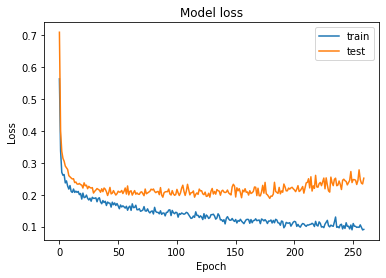

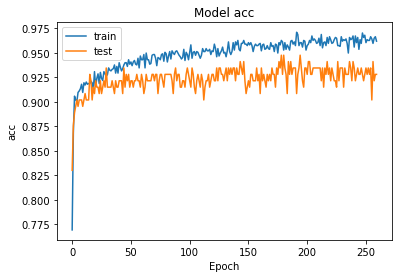

accuracy: 95.89%
Epoch 1/500
11/11 - 2s - loss: 0.5683 - accuracy: 0.7790 - auc: 0.9162 - val_loss: 0.8519 - val_accuracy: 0.6732 - val_auc: 0.8289 - 2s/epoch - 140ms/step
Epoch 2/500
11/11 - 0s - loss: 0.3083 - accuracy: 0.8884 - auc: 0.9748 - val_loss: 0.4397 - val_accuracy: 0.8235 - val_auc: 0.9558 - 53ms/epoch - 5ms/step
Epoch 3/500
11/11 - 0s - loss: 0.2890 - accuracy: 0.8899 - auc: 0.9775 - val_loss: 0.3415 - val_accuracy: 0.8431 - val_auc: 0.9687 - 54ms/epoch - 5ms/step
Epoch 4/500
11/11 - 0s - loss: 0.2729 - accuracy: 0.8891 - auc: 0.9795 - val_loss: 0.3282 - val_accuracy: 0.9020 - val_auc: 0.9711 - 60ms/epoch - 5ms/step
Epoch 5/500
11/11 - 0s - loss: 0.2661 - accuracy: 0.8983 - auc: 0.9804 - val_loss: 0.3210 - val_accuracy: 0.8497 - val_auc: 0.9710 - 50ms/epoch - 5ms/step
Epoch 6/500
11/11 - 0s - loss: 0.2455 - accuracy: 0.9005 - auc: 0.9831 - val_loss: 0.2971 - val_accuracy: 0.9020 - val_auc: 0.9767 - 61ms/epoch - 6ms/step
Epoch 7/500
11/11 - 0s - loss: 0.2434 - accuracy: 0.9

Epoch 54/500
11/11 - 0s - loss: 0.1624 - accuracy: 0.9446 - auc: 0.9927 - val_loss: 0.2221 - val_accuracy: 0.9150 - val_auc: 0.9868 - 47ms/epoch - 4ms/step
Epoch 55/500
11/11 - 0s - loss: 0.1574 - accuracy: 0.9370 - auc: 0.9926 - val_loss: 0.2215 - val_accuracy: 0.9085 - val_auc: 0.9867 - 47ms/epoch - 4ms/step
Epoch 56/500
11/11 - 0s - loss: 0.1569 - accuracy: 0.9408 - auc: 0.9925 - val_loss: 0.2341 - val_accuracy: 0.9020 - val_auc: 0.9852 - 47ms/epoch - 4ms/step
Epoch 57/500
11/11 - 0s - loss: 0.1737 - accuracy: 0.9332 - auc: 0.9911 - val_loss: 0.2223 - val_accuracy: 0.9281 - val_auc: 0.9862 - 62ms/epoch - 6ms/step
Epoch 58/500
11/11 - 0s - loss: 0.1603 - accuracy: 0.9415 - auc: 0.9921 - val_loss: 0.2300 - val_accuracy: 0.9020 - val_auc: 0.9856 - 62ms/epoch - 6ms/step
Epoch 59/500
11/11 - 0s - loss: 0.1523 - accuracy: 0.9446 - auc: 0.9928 - val_loss: 0.2178 - val_accuracy: 0.9020 - val_auc: 0.9871 - 47ms/epoch - 4ms/step
Epoch 60/500
11/11 - 0s - loss: 0.1547 - accuracy: 0.9393 - auc:

Epoch 107/500
11/11 - 0s - loss: 0.1328 - accuracy: 0.9499 - auc: 0.9946 - val_loss: 0.2306 - val_accuracy: 0.9150 - val_auc: 0.9854 - 47ms/epoch - 4ms/step
Epoch 108/500
11/11 - 0s - loss: 0.1366 - accuracy: 0.9484 - auc: 0.9944 - val_loss: 0.2136 - val_accuracy: 0.9281 - val_auc: 0.9875 - 62ms/epoch - 6ms/step
Epoch 109/500
11/11 - 0s - loss: 0.1432 - accuracy: 0.9476 - auc: 0.9935 - val_loss: 0.2384 - val_accuracy: 0.9150 - val_auc: 0.9839 - 47ms/epoch - 4ms/step
Epoch 110/500
11/11 - 0s - loss: 0.1370 - accuracy: 0.9499 - auc: 0.9940 - val_loss: 0.2267 - val_accuracy: 0.9281 - val_auc: 0.9828 - 47ms/epoch - 4ms/step
Epoch 111/500
11/11 - 0s - loss: 0.1360 - accuracy: 0.9529 - auc: 0.9941 - val_loss: 0.2171 - val_accuracy: 0.9346 - val_auc: 0.9865 - 62ms/epoch - 6ms/step
Epoch 112/500
11/11 - 0s - loss: 0.1321 - accuracy: 0.9552 - auc: 0.9945 - val_loss: 0.2267 - val_accuracy: 0.9281 - val_auc: 0.9829 - 47ms/epoch - 4ms/step
Epoch 113/500
11/11 - 0s - loss: 0.1251 - accuracy: 0.9605

Epoch 160/500
11/11 - 0s - loss: 0.1164 - accuracy: 0.9560 - auc: 0.9959 - val_loss: 0.2327 - val_accuracy: 0.9412 - val_auc: 0.9825 - 58ms/epoch - 5ms/step
Epoch 161/500
11/11 - 0s - loss: 0.1155 - accuracy: 0.9522 - auc: 0.9956 - val_loss: 0.2297 - val_accuracy: 0.9281 - val_auc: 0.9831 - 50ms/epoch - 5ms/step
Epoch 162/500
11/11 - 0s - loss: 0.1230 - accuracy: 0.9537 - auc: 0.9949 - val_loss: 0.2481 - val_accuracy: 0.9346 - val_auc: 0.9794 - 62ms/epoch - 6ms/step
Epoch 163/500
11/11 - 0s - loss: 0.1242 - accuracy: 0.9529 - auc: 0.9951 - val_loss: 0.2518 - val_accuracy: 0.9412 - val_auc: 0.9789 - 47ms/epoch - 4ms/step
Epoch 164/500
11/11 - 0s - loss: 0.1195 - accuracy: 0.9537 - auc: 0.9953 - val_loss: 0.2485 - val_accuracy: 0.9346 - val_auc: 0.9788 - 70ms/epoch - 6ms/step
Epoch 165/500
11/11 - 0s - loss: 0.1221 - accuracy: 0.9567 - auc: 0.9949 - val_loss: 0.2277 - val_accuracy: 0.9281 - val_auc: 0.9817 - 47ms/epoch - 4ms/step
Epoch 166/500
11/11 - 0s - loss: 0.1126 - accuracy: 0.9605

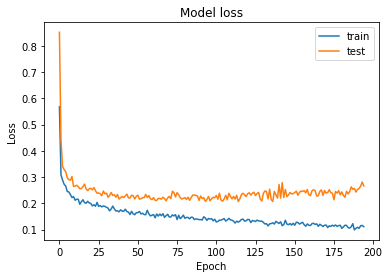

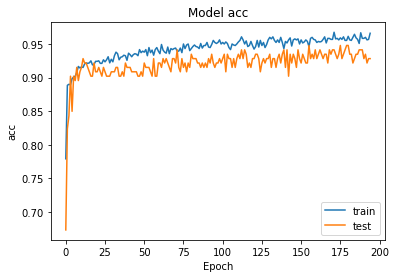

accuracy: 93.84%
Epoch 1/500
11/11 - 1s - loss: 0.6885 - accuracy: 0.7099 - auc: 0.8815 - val_loss: 1.3146 - val_accuracy: 0.1765 - val_auc: 0.5973 - 1s/epoch - 128ms/step
Epoch 2/500
11/11 - 0s - loss: 0.3654 - accuracy: 0.8542 - auc: 0.9654 - val_loss: 0.5000 - val_accuracy: 0.8105 - val_auc: 0.9425 - 47ms/epoch - 4ms/step
Epoch 3/500
11/11 - 0s - loss: 0.2804 - accuracy: 0.8884 - auc: 0.9790 - val_loss: 0.3251 - val_accuracy: 0.8693 - val_auc: 0.9733 - 62ms/epoch - 6ms/step
Epoch 4/500
11/11 - 0s - loss: 0.2716 - accuracy: 0.8922 - auc: 0.9804 - val_loss: 0.3123 - val_accuracy: 0.8824 - val_auc: 0.9747 - 47ms/epoch - 4ms/step
Epoch 5/500
11/11 - 0s - loss: 0.2651 - accuracy: 0.9021 - auc: 0.9810 - val_loss: 0.2995 - val_accuracy: 0.8954 - val_auc: 0.9775 - 62ms/epoch - 6ms/step
Epoch 6/500
11/11 - 0s - loss: 0.2543 - accuracy: 0.9021 - auc: 0.9817 - val_loss: 0.2809 - val_accuracy: 0.9085 - val_auc: 0.9801 - 47ms/epoch - 4ms/step
Epoch 7/500
11/11 - 0s - loss: 0.2399 - accuracy: 0.9

Epoch 54/500
11/11 - 0s - loss: 0.1604 - accuracy: 0.9400 - auc: 0.9926 - val_loss: 0.2111 - val_accuracy: 0.9150 - val_auc: 0.9888 - 58ms/epoch - 5ms/step
Epoch 55/500
11/11 - 0s - loss: 0.1518 - accuracy: 0.9461 - auc: 0.9935 - val_loss: 0.2243 - val_accuracy: 0.9150 - val_auc: 0.9859 - 58ms/epoch - 5ms/step
Epoch 56/500
11/11 - 0s - loss: 0.1643 - accuracy: 0.9415 - auc: 0.9921 - val_loss: 0.2083 - val_accuracy: 0.9216 - val_auc: 0.9889 - 56ms/epoch - 5ms/step
Epoch 57/500
11/11 - 0s - loss: 0.1573 - accuracy: 0.9423 - auc: 0.9930 - val_loss: 0.2128 - val_accuracy: 0.9281 - val_auc: 0.9876 - 59ms/epoch - 5ms/step
Epoch 58/500
11/11 - 0s - loss: 0.1603 - accuracy: 0.9431 - auc: 0.9921 - val_loss: 0.2032 - val_accuracy: 0.9346 - val_auc: 0.9887 - 59ms/epoch - 5ms/step
Epoch 59/500
11/11 - 0s - loss: 0.1591 - accuracy: 0.9385 - auc: 0.9924 - val_loss: 0.2094 - val_accuracy: 0.9216 - val_auc: 0.9878 - 59ms/epoch - 5ms/step
Epoch 60/500
11/11 - 0s - loss: 0.1540 - accuracy: 0.9385 - auc:

Epoch 107/500
11/11 - 0s - loss: 0.1300 - accuracy: 0.9537 - auc: 0.9945 - val_loss: 0.2223 - val_accuracy: 0.9150 - val_auc: 0.9867 - 71ms/epoch - 6ms/step
Epoch 108/500
11/11 - 0s - loss: 0.1309 - accuracy: 0.9506 - auc: 0.9945 - val_loss: 0.1961 - val_accuracy: 0.9346 - val_auc: 0.9893 - 47ms/epoch - 4ms/step
Epoch 109/500
11/11 - 0s - loss: 0.1280 - accuracy: 0.9522 - auc: 0.9946 - val_loss: 0.1946 - val_accuracy: 0.9150 - val_auc: 0.9879 - 47ms/epoch - 4ms/step
Epoch 110/500
11/11 - 0s - loss: 0.1340 - accuracy: 0.9484 - auc: 0.9945 - val_loss: 0.1904 - val_accuracy: 0.9216 - val_auc: 0.9896 - 47ms/epoch - 4ms/step
Epoch 111/500
11/11 - 0s - loss: 0.1274 - accuracy: 0.9514 - auc: 0.9946 - val_loss: 0.2111 - val_accuracy: 0.9150 - val_auc: 0.9864 - 63ms/epoch - 6ms/step
Epoch 112/500
11/11 - 0s - loss: 0.1342 - accuracy: 0.9499 - auc: 0.9946 - val_loss: 0.2126 - val_accuracy: 0.9216 - val_auc: 0.9878 - 62ms/epoch - 6ms/step
Epoch 113/500
11/11 - 0s - loss: 0.1171 - accuracy: 0.9575

Epoch 160/500
11/11 - 0s - loss: 0.1050 - accuracy: 0.9567 - auc: 0.9969 - val_loss: 0.1965 - val_accuracy: 0.9281 - val_auc: 0.9889 - 60ms/epoch - 5ms/step
Epoch 161/500
11/11 - 0s - loss: 0.1130 - accuracy: 0.9605 - auc: 0.9954 - val_loss: 0.2099 - val_accuracy: 0.9281 - val_auc: 0.9876 - 57ms/epoch - 5ms/step
Epoch 162/500
11/11 - 0s - loss: 0.1152 - accuracy: 0.9544 - auc: 0.9961 - val_loss: 0.2035 - val_accuracy: 0.9216 - val_auc: 0.9882 - 65ms/epoch - 6ms/step
Epoch 163/500
11/11 - 0s - loss: 0.1118 - accuracy: 0.9643 - auc: 0.9962 - val_loss: 0.2315 - val_accuracy: 0.9281 - val_auc: 0.9809 - 60ms/epoch - 5ms/step
Epoch 164/500
11/11 - 0s - loss: 0.1207 - accuracy: 0.9552 - auc: 0.9956 - val_loss: 0.2766 - val_accuracy: 0.9085 - val_auc: 0.9796 - 47ms/epoch - 4ms/step
Epoch 165/500
11/11 - 0s - loss: 0.1253 - accuracy: 0.9514 - auc: 0.9944 - val_loss: 0.2145 - val_accuracy: 0.9216 - val_auc: 0.9871 - 62ms/epoch - 6ms/step
Epoch 166/500
11/11 - 0s - loss: 0.1094 - accuracy: 0.9651

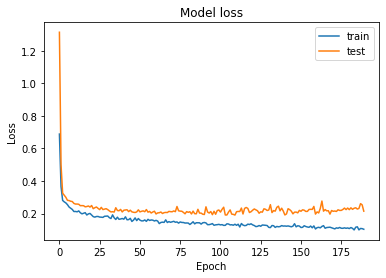

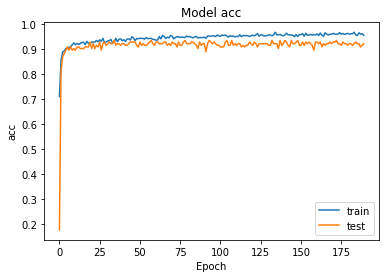

accuracy: 91.10%
[96.59863710403442, 93.87755393981934, 95.23809552192688, 97.26027250289917, 91.09588861465454, 93.83561611175537, 96.5753436088562, 95.89040875434875, 93.83561611175537, 91.09588861465454]
94.53% (+/- 2.08%)


In [62]:
from sklearn.model_selection import KFold
kfold = KFold(n_splits=10, shuffle=True, random_state=7)
cvscores = []
for train, test in kfold.split(X_sc, y_c):
  # create model
    model = Sequential()
    model.add(Dense(128, input_dim=input, activation='relu'))
    model.add(BatchNormalization(momentum=0.8))
    model.add(Dropout(0.5))
    model.add(Dense(128, activation='relu'))
    model.add(BatchNormalization(momentum=0.8))
    model.add(Dense(3, activation='softmax'))
    # Compile model
    rmsprop = keras.optimizers.RMSprop(lr=0.001, rho=0.9, epsilon=1e-08, decay=0.0)
    model.compile(loss='categorical_crossentropy', optimizer='rmsprop',metrics=['accuracy','AUC'])
    # Fit the model
    early_stopping = EarlyStopping(monitor='val_loss', patience=80, verbose=2)
    
    # 训练
    history = model.fit(X_sc[train], y_c[train], epochs=500, batch_size=128,shuffle=False,verbose=2,
                   validation_data=(x_test_sc,y_test_c),callbacks=[early_stopping])
    
    # loss曲线
    plt.plot(history.history['loss'], label='train')
    plt.plot(history.history['val_loss'], label='test')
    plt.title('Model loss')
    plt.ylabel('Loss')
    plt.xlabel('Epoch')
    plt.legend()
    plt.show()
    
    # acc曲线
    plt.plot(history.history['accuracy'], label='train')
    plt.plot(history.history['val_accuracy'], label='test')
    plt.title('Model acc')
    plt.ylabel('acc')
    plt.xlabel('Epoch')
    plt.legend()
    plt.show()
    
    #model.fit(X_sc[train], y_c[train], epochs=500, batch_size=64, verbose=2)
    # evaluate the model
    scores = model.evaluate(X_sc[test], y_c[test], verbose=0)
    print("%s: %.2f%%" % (model.metrics_names[1], scores[1]*100))
    cvscores.append(scores[1] * 100)
print(cvscores)
print("%.2f%% (+/- %.2f%%)" % (np.mean(cvscores), np.std(cvscores)))

## ann+aoa

In [63]:
w1,w2,w3=arithmetic_optimization_algorithm(X_sc, y_c,iterations = 50, alpha = 5, mu = 0.5, target_function = target_function, verbose = True)

Iteration =  0  loss =  [[8.19189554e+00]
 [4.79901018e+01]
 [4.33767380e-02]
 ...
 [4.01687308e+01]
 [3.60549299e+01]
 [1.11218165e+01]]
更新
Iteration =  1  loss =  [[0.98131897]
 [0.62954422]
 [1.95861245]
 ...
 [0.15797066]
 [0.22877981]
 [1.57005641]]
未更新
Iteration =  2  loss =  [[0.98131897]
 [0.62954422]
 [1.95861245]
 ...
 [0.15797066]
 [0.22877981]
 [1.57005641]]
更新
Iteration =  3  loss =  [[0.04454223]
 [3.64836035]
 [0.70448876]
 ...
 [3.00339569]
 [2.79326628]
 [2.11936502]]
未更新
Iteration =  4  loss =  [[0.04454223]
 [3.64836035]
 [0.70448876]
 ...
 [3.00339569]
 [2.79326628]
 [2.11936502]]
未更新
Iteration =  5  loss =  [[0.04454223]
 [3.64836035]
 [0.70448876]
 ...
 [3.00339569]
 [2.79326628]
 [2.11936502]]
更新
Iteration =  6  loss =  [[3.30905294]
 [2.45105725]
 [1.88829526]
 ...
 [1.88374847]
 [1.56564952]
 [1.00582426]]
未更新
Iteration =  7  loss =  [[3.30905294]
 [2.45105725]
 [1.88829526]
 ...
 [1.88374847]
 [1.56564952]
 [1.00582426]]
更新
Iteration =  8  loss =  [[5.45211535

In [64]:
b1=w1[:,-1]
w1=w1[:,:-1].T

b2=w2[:,-1]
w2=w2[:,:-1].T

b3=w3[:,-1]
w3=w3[:,:-1].T

In [65]:
def w1_my_init(shape,dtype):
    return w1

def w2_my_init(shape,dtype):
    return w2

def w3_my_init(shape,dtype):
    return w3

def b1_my_init(shape,dtype):
    return b1

def b2_my_init(shape,dtype):
    return b2

def b3_my_init(shape,dtype):
    return b3

Epoch 1/500
23/23 - 1s - loss: 1.8042 - accuracy: 0.5229 - val_loss: 0.6368 - val_accuracy: 0.7451 - 610ms/epoch - 27ms/step
Epoch 2/500
23/23 - 0s - loss: 0.8084 - accuracy: 0.7327 - val_loss: 0.4938 - val_accuracy: 0.8366 - 62ms/epoch - 3ms/step
Epoch 3/500
23/23 - 0s - loss: 0.5847 - accuracy: 0.7977 - val_loss: 0.4321 - val_accuracy: 0.8366 - 67ms/epoch - 3ms/step
Epoch 4/500
23/23 - 0s - loss: 0.5049 - accuracy: 0.8168 - val_loss: 0.4170 - val_accuracy: 0.8235 - 63ms/epoch - 3ms/step
Epoch 5/500
23/23 - 0s - loss: 0.4273 - accuracy: 0.8483 - val_loss: 0.3866 - val_accuracy: 0.8235 - 62ms/epoch - 3ms/step
Epoch 6/500
23/23 - 0s - loss: 0.3807 - accuracy: 0.8626 - val_loss: 0.3538 - val_accuracy: 0.8758 - 63ms/epoch - 3ms/step
Epoch 7/500
23/23 - 0s - loss: 0.3682 - accuracy: 0.8681 - val_loss: 0.3475 - val_accuracy: 0.8824 - 62ms/epoch - 3ms/step
Epoch 8/500
23/23 - 0s - loss: 0.3392 - accuracy: 0.8783 - val_loss: 0.3380 - val_accuracy: 0.8758 - 62ms/epoch - 3ms/step
Epoch 9/500
23

Epoch 68/500
23/23 - 0s - loss: 0.1550 - accuracy: 0.9433 - val_loss: 0.2149 - val_accuracy: 0.9281 - 62ms/epoch - 3ms/step
Epoch 69/500
23/23 - 0s - loss: 0.1601 - accuracy: 0.9351 - val_loss: 0.2125 - val_accuracy: 0.9216 - 62ms/epoch - 3ms/step
Epoch 70/500
23/23 - 0s - loss: 0.1601 - accuracy: 0.9419 - val_loss: 0.2156 - val_accuracy: 0.9216 - 63ms/epoch - 3ms/step
Epoch 71/500
23/23 - 0s - loss: 0.1569 - accuracy: 0.9433 - val_loss: 0.2188 - val_accuracy: 0.9216 - 60ms/epoch - 3ms/step
Epoch 72/500
23/23 - 0s - loss: 0.1581 - accuracy: 0.9474 - val_loss: 0.2196 - val_accuracy: 0.9281 - 62ms/epoch - 3ms/step
Epoch 73/500
23/23 - 0s - loss: 0.1542 - accuracy: 0.9419 - val_loss: 0.2129 - val_accuracy: 0.9216 - 74ms/epoch - 3ms/step
Epoch 74/500
23/23 - 0s - loss: 0.1562 - accuracy: 0.9426 - val_loss: 0.2208 - val_accuracy: 0.9412 - 78ms/epoch - 3ms/step
Epoch 75/500
23/23 - 0s - loss: 0.1539 - accuracy: 0.9426 - val_loss: 0.2208 - val_accuracy: 0.9281 - 78ms/epoch - 3ms/step
Epoch 76

Epoch 134/500
23/23 - 0s - loss: 0.1336 - accuracy: 0.9515 - val_loss: 0.2195 - val_accuracy: 0.9412 - 72ms/epoch - 3ms/step
Epoch 135/500
23/23 - 0s - loss: 0.1263 - accuracy: 0.9604 - val_loss: 0.2217 - val_accuracy: 0.9412 - 61ms/epoch - 3ms/step
Epoch 136/500
23/23 - 0s - loss: 0.1220 - accuracy: 0.9576 - val_loss: 0.2260 - val_accuracy: 0.9346 - 58ms/epoch - 3ms/step
Epoch 137/500
23/23 - 0s - loss: 0.1329 - accuracy: 0.9515 - val_loss: 0.2133 - val_accuracy: 0.9412 - 63ms/epoch - 3ms/step
Epoch 138/500
23/23 - 0s - loss: 0.1264 - accuracy: 0.9522 - val_loss: 0.2230 - val_accuracy: 0.9346 - 62ms/epoch - 3ms/step
Epoch 139/500
23/23 - 0s - loss: 0.1207 - accuracy: 0.9569 - val_loss: 0.2106 - val_accuracy: 0.9412 - 62ms/epoch - 3ms/step
Epoch 140/500
23/23 - 0s - loss: 0.1159 - accuracy: 0.9617 - val_loss: 0.2130 - val_accuracy: 0.9412 - 62ms/epoch - 3ms/step
Epoch 141/500
23/23 - 0s - loss: 0.1225 - accuracy: 0.9590 - val_loss: 0.2125 - val_accuracy: 0.9412 - 62ms/epoch - 3ms/step


Epoch 200/500
23/23 - 0s - loss: 0.1125 - accuracy: 0.9604 - val_loss: 0.2326 - val_accuracy: 0.9412 - 80ms/epoch - 3ms/step
Epoch 201/500
23/23 - 0s - loss: 0.1157 - accuracy: 0.9617 - val_loss: 0.2241 - val_accuracy: 0.9412 - 63ms/epoch - 3ms/step
Epoch 202/500
23/23 - 0s - loss: 0.1043 - accuracy: 0.9624 - val_loss: 0.2201 - val_accuracy: 0.9412 - 80ms/epoch - 3ms/step
Epoch 203/500
23/23 - 0s - loss: 0.1117 - accuracy: 0.9563 - val_loss: 0.2272 - val_accuracy: 0.9412 - 71ms/epoch - 3ms/step
Epoch 204/500
23/23 - 0s - loss: 0.1181 - accuracy: 0.9610 - val_loss: 0.2261 - val_accuracy: 0.9412 - 71ms/epoch - 3ms/step
Epoch 205/500
23/23 - 0s - loss: 0.1150 - accuracy: 0.9535 - val_loss: 0.2175 - val_accuracy: 0.9412 - 58ms/epoch - 3ms/step
Epoch 206/500
23/23 - 0s - loss: 0.1070 - accuracy: 0.9610 - val_loss: 0.2278 - val_accuracy: 0.9346 - 81ms/epoch - 4ms/step
Epoch 207/500
23/23 - 0s - loss: 0.1113 - accuracy: 0.9590 - val_loss: 0.2186 - val_accuracy: 0.9412 - 51ms/epoch - 2ms/step


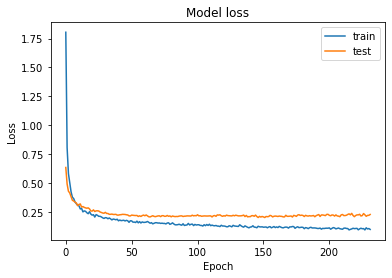

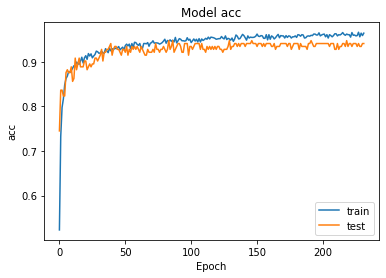

In [66]:
model = Sequential()  # 初始化
input = X_sc.shape[1]
# 隐藏层128
model.add(Dense(128, input_shape=(input,),kernel_initializer=w1_my_init,bias_initializer=b1_my_init))  #
model.add(Activation('relu'))
# Dropout层用于防止过拟合
model.add(Dropout(0.2))
# 隐藏层128
model.add(Dense(128,kernel_initializer=w2_my_init,bias_initializer=b2_my_init))
model.add(Activation('relu'))

model.add(Dense(3,kernel_initializer=w3_my_init,bias_initializer=b3_my_init))
model.add(Activation('softmax'))
# 使用高效的ADAM优化算法
#rmsprop = keras.optimizers.RMSprop(lr=0.001, rho=0.9, epsilon=1e-08, decay=0.0)
model.compile(loss='categorical_crossentropy', optimizer='rmsprop',metrics=['accuracy'])

early_stopping = EarlyStopping(monitor='val_loss', patience=80, verbose=2)

# 训练
history = model.fit(X_sc, y_c, epochs=500, batch_size=64,shuffle=False,verbose=2,
                   validation_data=(x_test_sc,y_test_c),callbacks=[early_stopping])

# loss曲线
plt.plot(history.history['loss'], label='train')
plt.plot(history.history['val_loss'], label='test')
plt.title('Model loss')
plt.ylabel('Loss')
plt.xlabel('Epoch')
plt.legend()
plt.show()

# acc曲线
plt.plot(history.history['accuracy'], label='train')
plt.plot(history.history['val_accuracy'], label='test')
plt.title('Model acc')
plt.ylabel('acc')
plt.xlabel('Epoch')
plt.legend()
plt.show()

Epoch 1/500
11/11 - 1s - loss: 2.3067 - accuracy: 0.4233 - auc: 0.6044 - val_loss: 0.9379 - val_accuracy: 0.4771 - val_auc: 0.7386 - 805ms/epoch - 73ms/step
Epoch 2/500
11/11 - 0s - loss: 1.1735 - accuracy: 0.6261 - auc: 0.7982 - val_loss: 0.5447 - val_accuracy: 0.8039 - val_auc: 0.9212 - 51ms/epoch - 5ms/step
Epoch 3/500
11/11 - 0s - loss: 0.8485 - accuracy: 0.7059 - auc: 0.8755 - val_loss: 0.4788 - val_accuracy: 0.8170 - val_auc: 0.9361 - 48ms/epoch - 4ms/step
Epoch 4/500
11/11 - 0s - loss: 0.6939 - accuracy: 0.7743 - auc: 0.9114 - val_loss: 0.4562 - val_accuracy: 0.8366 - val_auc: 0.9452 - 50ms/epoch - 5ms/step
Epoch 5/500
11/11 - 0s - loss: 0.6141 - accuracy: 0.8032 - auc: 0.9286 - val_loss: 0.4095 - val_accuracy: 0.8235 - val_auc: 0.9561 - 50ms/epoch - 5ms/step
Epoch 6/500
11/11 - 0s - loss: 0.5353 - accuracy: 0.8153 - auc: 0.9412 - val_loss: 0.4009 - val_accuracy: 0.8627 - val_auc: 0.9571 - 54ms/epoch - 5ms/step
Epoch 7/500
11/11 - 0s - loss: 0.4488 - accuracy: 0.8397 - auc: 0.95

Epoch 54/500
11/11 - 0s - loss: 0.1884 - accuracy: 0.9240 - auc: 0.9895 - val_loss: 0.2461 - val_accuracy: 0.8954 - val_auc: 0.9828 - 51ms/epoch - 5ms/step
Epoch 55/500
11/11 - 0s - loss: 0.1873 - accuracy: 0.9271 - auc: 0.9897 - val_loss: 0.2438 - val_accuracy: 0.8954 - val_auc: 0.9830 - 68ms/epoch - 6ms/step
Epoch 56/500
11/11 - 0s - loss: 0.2034 - accuracy: 0.9240 - auc: 0.9881 - val_loss: 0.2467 - val_accuracy: 0.8889 - val_auc: 0.9831 - 48ms/epoch - 4ms/step
Epoch 57/500
11/11 - 0s - loss: 0.1940 - accuracy: 0.9225 - auc: 0.9894 - val_loss: 0.2346 - val_accuracy: 0.9085 - val_auc: 0.9847 - 71ms/epoch - 6ms/step
Epoch 58/500
11/11 - 0s - loss: 0.1891 - accuracy: 0.9354 - auc: 0.9896 - val_loss: 0.2327 - val_accuracy: 0.9085 - val_auc: 0.9848 - 63ms/epoch - 6ms/step
Epoch 59/500
11/11 - 0s - loss: 0.1841 - accuracy: 0.9316 - auc: 0.9902 - val_loss: 0.2487 - val_accuracy: 0.8824 - val_auc: 0.9827 - 49ms/epoch - 4ms/step
Epoch 60/500
11/11 - 0s - loss: 0.1838 - accuracy: 0.9217 - auc:

Epoch 107/500
11/11 - 0s - loss: 0.1559 - accuracy: 0.9369 - auc: 0.9927 - val_loss: 0.2181 - val_accuracy: 0.9346 - val_auc: 0.9875 - 50ms/epoch - 5ms/step
Epoch 108/500
11/11 - 0s - loss: 0.1659 - accuracy: 0.9339 - auc: 0.9920 - val_loss: 0.2102 - val_accuracy: 0.9412 - val_auc: 0.9881 - 33ms/epoch - 3ms/step
Epoch 109/500
11/11 - 0s - loss: 0.1573 - accuracy: 0.9430 - auc: 0.9926 - val_loss: 0.2164 - val_accuracy: 0.9216 - val_auc: 0.9876 - 52ms/epoch - 5ms/step
Epoch 110/500
11/11 - 0s - loss: 0.1562 - accuracy: 0.9362 - auc: 0.9932 - val_loss: 0.2095 - val_accuracy: 0.9346 - val_auc: 0.9881 - 52ms/epoch - 5ms/step
Epoch 111/500
11/11 - 0s - loss: 0.1531 - accuracy: 0.9430 - auc: 0.9930 - val_loss: 0.2089 - val_accuracy: 0.9412 - val_auc: 0.9885 - 56ms/epoch - 5ms/step
Epoch 112/500
11/11 - 0s - loss: 0.1555 - accuracy: 0.9407 - auc: 0.9926 - val_loss: 0.2126 - val_accuracy: 0.9281 - val_auc: 0.9877 - 66ms/epoch - 6ms/step
Epoch 113/500
11/11 - 0s - loss: 0.1647 - accuracy: 0.9248

Epoch 160/500
11/11 - 0s - loss: 0.1397 - accuracy: 0.9536 - auc: 0.9940 - val_loss: 0.2217 - val_accuracy: 0.9281 - val_auc: 0.9841 - 50ms/epoch - 5ms/step
Epoch 161/500
11/11 - 0s - loss: 0.1301 - accuracy: 0.9567 - auc: 0.9951 - val_loss: 0.2207 - val_accuracy: 0.9412 - val_auc: 0.9838 - 50ms/epoch - 5ms/step
Epoch 162/500
11/11 - 0s - loss: 0.1395 - accuracy: 0.9491 - auc: 0.9934 - val_loss: 0.2178 - val_accuracy: 0.9346 - val_auc: 0.9841 - 50ms/epoch - 5ms/step
Epoch 163/500
11/11 - 0s - loss: 0.1380 - accuracy: 0.9460 - auc: 0.9939 - val_loss: 0.2262 - val_accuracy: 0.9412 - val_auc: 0.9828 - 50ms/epoch - 5ms/step
Epoch 164/500
11/11 - 0s - loss: 0.1326 - accuracy: 0.9521 - auc: 0.9941 - val_loss: 0.2228 - val_accuracy: 0.9346 - val_auc: 0.9838 - 51ms/epoch - 5ms/step
Epoch 165/500
11/11 - 0s - loss: 0.1405 - accuracy: 0.9460 - auc: 0.9943 - val_loss: 0.2236 - val_accuracy: 0.9412 - val_auc: 0.9828 - 66ms/epoch - 6ms/step
Epoch 166/500
11/11 - 0s - loss: 0.1331 - accuracy: 0.9438

Epoch 213/500
11/11 - 0s - loss: 0.1286 - accuracy: 0.9506 - auc: 0.9950 - val_loss: 0.2228 - val_accuracy: 0.9281 - val_auc: 0.9841 - 52ms/epoch - 5ms/step
Epoch 214/500
11/11 - 0s - loss: 0.1274 - accuracy: 0.9536 - auc: 0.9943 - val_loss: 0.2274 - val_accuracy: 0.9346 - val_auc: 0.9834 - 45ms/epoch - 4ms/step
Epoch 215/500
11/11 - 0s - loss: 0.1257 - accuracy: 0.9574 - auc: 0.9948 - val_loss: 0.2276 - val_accuracy: 0.9281 - val_auc: 0.9837 - 56ms/epoch - 5ms/step
Epoch 216/500
11/11 - 0s - loss: 0.1175 - accuracy: 0.9605 - auc: 0.9955 - val_loss: 0.2324 - val_accuracy: 0.9281 - val_auc: 0.9829 - 64ms/epoch - 6ms/step
Epoch 217/500
11/11 - 0s - loss: 0.1180 - accuracy: 0.9559 - auc: 0.9955 - val_loss: 0.2320 - val_accuracy: 0.9346 - val_auc: 0.9831 - 50ms/epoch - 5ms/step
Epoch 218/500
11/11 - 0s - loss: 0.1310 - accuracy: 0.9544 - auc: 0.9943 - val_loss: 0.2318 - val_accuracy: 0.9281 - val_auc: 0.9834 - 65ms/epoch - 6ms/step
Epoch 218: early stopping


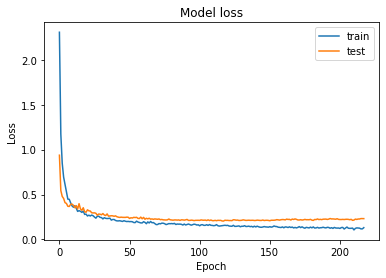

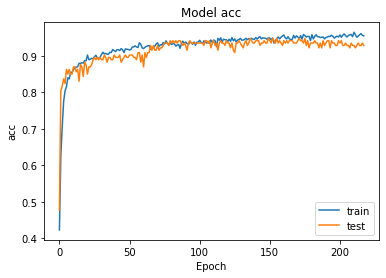

accuracy: 95.92%
Epoch 1/500
11/11 - 1s - loss: 2.4916 - accuracy: 0.4027 - auc: 0.5664 - val_loss: 0.9277 - val_accuracy: 0.4575 - val_auc: 0.7389 - 940ms/epoch - 85ms/step
Epoch 2/500
11/11 - 0s - loss: 1.2367 - accuracy: 0.6011 - auc: 0.7824 - val_loss: 0.5848 - val_accuracy: 0.7582 - val_auc: 0.9102 - 42ms/epoch - 4ms/step
Epoch 3/500
11/11 - 0s - loss: 0.9160 - accuracy: 0.6938 - auc: 0.8588 - val_loss: 0.4526 - val_accuracy: 0.8170 - val_auc: 0.9440 - 69ms/epoch - 6ms/step
Epoch 4/500
11/11 - 0s - loss: 0.7279 - accuracy: 0.7584 - auc: 0.9056 - val_loss: 0.4432 - val_accuracy: 0.8170 - val_auc: 0.9505 - 48ms/epoch - 4ms/step
Epoch 5/500
11/11 - 0s - loss: 0.5832 - accuracy: 0.7956 - auc: 0.9320 - val_loss: 0.3866 - val_accuracy: 0.8431 - val_auc: 0.9602 - 100ms/epoch - 9ms/step
Epoch 6/500
11/11 - 0s - loss: 0.5132 - accuracy: 0.8207 - auc: 0.9447 - val_loss: 0.3999 - val_accuracy: 0.8497 - val_auc: 0.9593 - 53ms/epoch - 5ms/step
Epoch 7/500
11/11 - 0s - loss: 0.4847 - accuracy: 

Epoch 54/500
11/11 - 0s - loss: 0.1842 - accuracy: 0.9271 - auc: 0.9904 - val_loss: 0.2688 - val_accuracy: 0.8824 - val_auc: 0.9798 - 39ms/epoch - 4ms/step
Epoch 55/500
11/11 - 0s - loss: 0.1874 - accuracy: 0.9240 - auc: 0.9900 - val_loss: 0.2564 - val_accuracy: 0.9020 - val_auc: 0.9814 - 34ms/epoch - 3ms/step
Epoch 56/500
11/11 - 0s - loss: 0.1842 - accuracy: 0.9210 - auc: 0.9905 - val_loss: 0.2423 - val_accuracy: 0.9085 - val_auc: 0.9835 - 34ms/epoch - 3ms/step
Epoch 57/500
11/11 - 0s - loss: 0.1761 - accuracy: 0.9354 - auc: 0.9914 - val_loss: 0.2538 - val_accuracy: 0.8824 - val_auc: 0.9819 - 33ms/epoch - 3ms/step
Epoch 58/500
11/11 - 0s - loss: 0.1855 - accuracy: 0.9233 - auc: 0.9897 - val_loss: 0.2478 - val_accuracy: 0.9020 - val_auc: 0.9826 - 34ms/epoch - 3ms/step
Epoch 59/500
11/11 - 0s - loss: 0.1884 - accuracy: 0.9248 - auc: 0.9895 - val_loss: 0.2534 - val_accuracy: 0.8954 - val_auc: 0.9821 - 33ms/epoch - 3ms/step
Epoch 60/500
11/11 - 0s - loss: 0.1880 - accuracy: 0.9248 - auc:

Epoch 107/500
11/11 - 0s - loss: 0.1524 - accuracy: 0.9400 - auc: 0.9934 - val_loss: 0.2331 - val_accuracy: 0.9216 - val_auc: 0.9850 - 56ms/epoch - 5ms/step
Epoch 108/500
11/11 - 0s - loss: 0.1520 - accuracy: 0.9400 - auc: 0.9928 - val_loss: 0.2318 - val_accuracy: 0.9281 - val_auc: 0.9825 - 54ms/epoch - 5ms/step
Epoch 109/500
11/11 - 0s - loss: 0.1496 - accuracy: 0.9445 - auc: 0.9934 - val_loss: 0.2232 - val_accuracy: 0.9281 - val_auc: 0.9863 - 59ms/epoch - 5ms/step
Epoch 110/500
11/11 - 0s - loss: 0.1397 - accuracy: 0.9430 - auc: 0.9945 - val_loss: 0.2263 - val_accuracy: 0.9281 - val_auc: 0.9858 - 54ms/epoch - 5ms/step
Epoch 111/500
11/11 - 0s - loss: 0.1498 - accuracy: 0.9369 - auc: 0.9932 - val_loss: 0.2251 - val_accuracy: 0.9281 - val_auc: 0.9860 - 54ms/epoch - 5ms/step
Epoch 112/500
11/11 - 0s - loss: 0.1431 - accuracy: 0.9430 - auc: 0.9938 - val_loss: 0.2257 - val_accuracy: 0.9216 - val_auc: 0.9859 - 52ms/epoch - 5ms/step
Epoch 113/500
11/11 - 0s - loss: 0.1459 - accuracy: 0.9415

Epoch 160/500
11/11 - 0s - loss: 0.1264 - accuracy: 0.9498 - auc: 0.9953 - val_loss: 0.2416 - val_accuracy: 0.9346 - val_auc: 0.9829 - 67ms/epoch - 6ms/step
Epoch 161/500
11/11 - 0s - loss: 0.1229 - accuracy: 0.9536 - auc: 0.9953 - val_loss: 0.2446 - val_accuracy: 0.9216 - val_auc: 0.9826 - 67ms/epoch - 6ms/step
Epoch 162/500
11/11 - 0s - loss: 0.1360 - accuracy: 0.9453 - auc: 0.9945 - val_loss: 0.2423 - val_accuracy: 0.9216 - val_auc: 0.9826 - 52ms/epoch - 5ms/step
Epoch 163/500
11/11 - 0s - loss: 0.1249 - accuracy: 0.9552 - auc: 0.9956 - val_loss: 0.2410 - val_accuracy: 0.9412 - val_auc: 0.9827 - 65ms/epoch - 6ms/step
Epoch 164/500
11/11 - 0s - loss: 0.1340 - accuracy: 0.9536 - auc: 0.9943 - val_loss: 0.2457 - val_accuracy: 0.9346 - val_auc: 0.9827 - 50ms/epoch - 5ms/step
Epoch 165/500
11/11 - 0s - loss: 0.1243 - accuracy: 0.9514 - auc: 0.9953 - val_loss: 0.2463 - val_accuracy: 0.9346 - val_auc: 0.9827 - 51ms/epoch - 5ms/step
Epoch 166/500
11/11 - 0s - loss: 0.1340 - accuracy: 0.9506

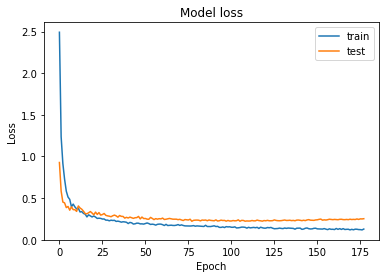

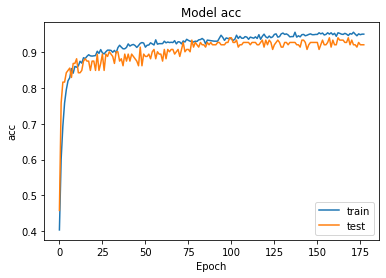

accuracy: 93.20%
Epoch 1/500
11/11 - 1s - loss: 2.3405 - accuracy: 0.4225 - auc: 0.5879 - val_loss: 0.9269 - val_accuracy: 0.5294 - val_auc: 0.7394 - 905ms/epoch - 82ms/step
Epoch 2/500
11/11 - 0s - loss: 1.2896 - accuracy: 0.5935 - auc: 0.7759 - val_loss: 0.6251 - val_accuracy: 0.6928 - val_auc: 0.8915 - 43ms/epoch - 4ms/step
Epoch 3/500
11/11 - 0s - loss: 0.9013 - accuracy: 0.7135 - auc: 0.8656 - val_loss: 0.4986 - val_accuracy: 0.8301 - val_auc: 0.9377 - 48ms/epoch - 4ms/step
Epoch 4/500
11/11 - 0s - loss: 0.7049 - accuracy: 0.7606 - auc: 0.9074 - val_loss: 0.4580 - val_accuracy: 0.8235 - val_auc: 0.9427 - 51ms/epoch - 5ms/step
Epoch 5/500
11/11 - 0s - loss: 0.6408 - accuracy: 0.7842 - auc: 0.9220 - val_loss: 0.4227 - val_accuracy: 0.8497 - val_auc: 0.9530 - 46ms/epoch - 4ms/step
Epoch 6/500
11/11 - 0s - loss: 0.5416 - accuracy: 0.8108 - auc: 0.9404 - val_loss: 0.4126 - val_accuracy: 0.8301 - val_auc: 0.9543 - 52ms/epoch - 5ms/step
Epoch 7/500
11/11 - 0s - loss: 0.5164 - accuracy: 0

Epoch 54/500
11/11 - 0s - loss: 0.2023 - accuracy: 0.9255 - auc: 0.9885 - val_loss: 0.2473 - val_accuracy: 0.9085 - val_auc: 0.9840 - 55ms/epoch - 5ms/step
Epoch 55/500
11/11 - 0s - loss: 0.2006 - accuracy: 0.9217 - auc: 0.9886 - val_loss: 0.2354 - val_accuracy: 0.9085 - val_auc: 0.9858 - 54ms/epoch - 5ms/step
Epoch 56/500
11/11 - 0s - loss: 0.1964 - accuracy: 0.9233 - auc: 0.9892 - val_loss: 0.2334 - val_accuracy: 0.9020 - val_auc: 0.9851 - 63ms/epoch - 6ms/step
Epoch 57/500
11/11 - 0s - loss: 0.1942 - accuracy: 0.9278 - auc: 0.9894 - val_loss: 0.2376 - val_accuracy: 0.9216 - val_auc: 0.9859 - 58ms/epoch - 5ms/step
Epoch 58/500
11/11 - 0s - loss: 0.1969 - accuracy: 0.9187 - auc: 0.9892 - val_loss: 0.2372 - val_accuracy: 0.9020 - val_auc: 0.9852 - 71ms/epoch - 6ms/step
Epoch 59/500
11/11 - 0s - loss: 0.1989 - accuracy: 0.9255 - auc: 0.9888 - val_loss: 0.2337 - val_accuracy: 0.8954 - val_auc: 0.9851 - 62ms/epoch - 6ms/step
Epoch 60/500
11/11 - 0s - loss: 0.1864 - accuracy: 0.9240 - auc:

Epoch 107/500
11/11 - 0s - loss: 0.1582 - accuracy: 0.9354 - auc: 0.9925 - val_loss: 0.2173 - val_accuracy: 0.9346 - val_auc: 0.9868 - 48ms/epoch - 4ms/step
Epoch 108/500
11/11 - 0s - loss: 0.1682 - accuracy: 0.9377 - auc: 0.9914 - val_loss: 0.2109 - val_accuracy: 0.9346 - val_auc: 0.9883 - 47ms/epoch - 4ms/step
Epoch 109/500
11/11 - 0s - loss: 0.1645 - accuracy: 0.9415 - auc: 0.9917 - val_loss: 0.2031 - val_accuracy: 0.9412 - val_auc: 0.9889 - 47ms/epoch - 4ms/step
Epoch 110/500
11/11 - 0s - loss: 0.1583 - accuracy: 0.9369 - auc: 0.9927 - val_loss: 0.2223 - val_accuracy: 0.9281 - val_auc: 0.9870 - 31ms/epoch - 3ms/step
Epoch 111/500
11/11 - 0s - loss: 0.1656 - accuracy: 0.9384 - auc: 0.9913 - val_loss: 0.2183 - val_accuracy: 0.9346 - val_auc: 0.9870 - 44ms/epoch - 4ms/step
Epoch 112/500
11/11 - 0s - loss: 0.1515 - accuracy: 0.9422 - auc: 0.9932 - val_loss: 0.2190 - val_accuracy: 0.9281 - val_auc: 0.9873 - 29ms/epoch - 3ms/step
Epoch 113/500
11/11 - 0s - loss: 0.1710 - accuracy: 0.9347

Epoch 160/500
11/11 - 0s - loss: 0.1471 - accuracy: 0.9498 - auc: 0.9931 - val_loss: 0.2094 - val_accuracy: 0.9346 - val_auc: 0.9875 - 65ms/epoch - 6ms/step
Epoch 161/500
11/11 - 0s - loss: 0.1338 - accuracy: 0.9536 - auc: 0.9945 - val_loss: 0.2047 - val_accuracy: 0.9412 - val_auc: 0.9879 - 67ms/epoch - 6ms/step
Epoch 162/500
11/11 - 0s - loss: 0.1431 - accuracy: 0.9483 - auc: 0.9937 - val_loss: 0.2055 - val_accuracy: 0.9281 - val_auc: 0.9878 - 49ms/epoch - 4ms/step
Epoch 163/500
11/11 - 0s - loss: 0.1450 - accuracy: 0.9498 - auc: 0.9929 - val_loss: 0.2190 - val_accuracy: 0.9346 - val_auc: 0.9866 - 61ms/epoch - 6ms/step
Epoch 164/500
11/11 - 0s - loss: 0.1419 - accuracy: 0.9521 - auc: 0.9933 - val_loss: 0.2157 - val_accuracy: 0.9346 - val_auc: 0.9869 - 93ms/epoch - 8ms/step
Epoch 165/500
11/11 - 0s - loss: 0.1440 - accuracy: 0.9491 - auc: 0.9937 - val_loss: 0.2114 - val_accuracy: 0.9412 - val_auc: 0.9840 - 70ms/epoch - 6ms/step
Epoch 166/500
11/11 - 0s - loss: 0.1385 - accuracy: 0.9498

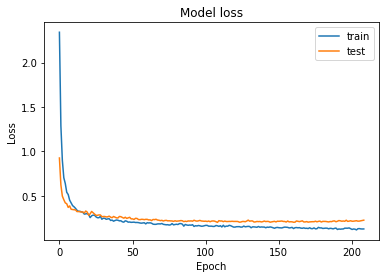

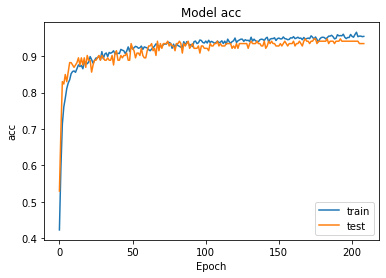

accuracy: 95.92%
Epoch 1/500
11/11 - 1s - loss: 2.3820 - accuracy: 0.4085 - auc: 0.5768 - val_loss: 0.9717 - val_accuracy: 0.4444 - val_auc: 0.7228 - 947ms/epoch - 86ms/step
Epoch 2/500
11/11 - 0s - loss: 1.2432 - accuracy: 0.6021 - auc: 0.7876 - val_loss: 0.6458 - val_accuracy: 0.6928 - val_auc: 0.8827 - 47ms/epoch - 4ms/step
Epoch 3/500
11/11 - 0s - loss: 0.8459 - accuracy: 0.6986 - auc: 0.8742 - val_loss: 0.4940 - val_accuracy: 0.8301 - val_auc: 0.9333 - 47ms/epoch - 4ms/step
Epoch 4/500
11/11 - 0s - loss: 0.7018 - accuracy: 0.7661 - auc: 0.9097 - val_loss: 0.4371 - val_accuracy: 0.8301 - val_auc: 0.9483 - 47ms/epoch - 4ms/step
Epoch 5/500
11/11 - 0s - loss: 0.5835 - accuracy: 0.7920 - auc: 0.9313 - val_loss: 0.4208 - val_accuracy: 0.8301 - val_auc: 0.9540 - 47ms/epoch - 4ms/step
Epoch 6/500
11/11 - 0s - loss: 0.5617 - accuracy: 0.8102 - auc: 0.9370 - val_loss: 0.3946 - val_accuracy: 0.8562 - val_auc: 0.9564 - 47ms/epoch - 4ms/step
Epoch 7/500
11/11 - 0s - loss: 0.4953 - accuracy: 0

Epoch 54/500
11/11 - 0s - loss: 0.1901 - accuracy: 0.9210 - auc: 0.9900 - val_loss: 0.2470 - val_accuracy: 0.9085 - val_auc: 0.9830 - 47ms/epoch - 4ms/step
Epoch 55/500
11/11 - 0s - loss: 0.1882 - accuracy: 0.9218 - auc: 0.9899 - val_loss: 0.2347 - val_accuracy: 0.9020 - val_auc: 0.9847 - 47ms/epoch - 4ms/step
Epoch 56/500
11/11 - 0s - loss: 0.1858 - accuracy: 0.9195 - auc: 0.9902 - val_loss: 0.2370 - val_accuracy: 0.9150 - val_auc: 0.9846 - 47ms/epoch - 4ms/step
Epoch 57/500
11/11 - 0s - loss: 0.1915 - accuracy: 0.9180 - auc: 0.9895 - val_loss: 0.2361 - val_accuracy: 0.9150 - val_auc: 0.9846 - 47ms/epoch - 4ms/step
Epoch 58/500
11/11 - 0s - loss: 0.1812 - accuracy: 0.9301 - auc: 0.9908 - val_loss: 0.2245 - val_accuracy: 0.9085 - val_auc: 0.9860 - 47ms/epoch - 4ms/step
Epoch 59/500
11/11 - 0s - loss: 0.1843 - accuracy: 0.9301 - auc: 0.9908 - val_loss: 0.2325 - val_accuracy: 0.9085 - val_auc: 0.9851 - 47ms/epoch - 4ms/step
Epoch 60/500
11/11 - 0s - loss: 0.2055 - accuracy: 0.9157 - auc:

Epoch 107/500
11/11 - 0s - loss: 0.1693 - accuracy: 0.9339 - auc: 0.9913 - val_loss: 0.2011 - val_accuracy: 0.9412 - val_auc: 0.9886 - 47ms/epoch - 4ms/step
Epoch 108/500
11/11 - 0s - loss: 0.1601 - accuracy: 0.9393 - auc: 0.9925 - val_loss: 0.2031 - val_accuracy: 0.9412 - val_auc: 0.9885 - 47ms/epoch - 4ms/step
Epoch 109/500
11/11 - 0s - loss: 0.1555 - accuracy: 0.9423 - auc: 0.9930 - val_loss: 0.2097 - val_accuracy: 0.9346 - val_auc: 0.9878 - 47ms/epoch - 4ms/step
Epoch 110/500
11/11 - 0s - loss: 0.1594 - accuracy: 0.9370 - auc: 0.9926 - val_loss: 0.2048 - val_accuracy: 0.9412 - val_auc: 0.9879 - 47ms/epoch - 4ms/step
Epoch 111/500
11/11 - 0s - loss: 0.1529 - accuracy: 0.9393 - auc: 0.9929 - val_loss: 0.2086 - val_accuracy: 0.9346 - val_auc: 0.9882 - 47ms/epoch - 4ms/step
Epoch 112/500
11/11 - 0s - loss: 0.1625 - accuracy: 0.9332 - auc: 0.9922 - val_loss: 0.2104 - val_accuracy: 0.9346 - val_auc: 0.9873 - 47ms/epoch - 4ms/step
Epoch 113/500
11/11 - 0s - loss: 0.1521 - accuracy: 0.9423

Epoch 160/500
11/11 - 0s - loss: 0.1381 - accuracy: 0.9491 - auc: 0.9940 - val_loss: 0.2053 - val_accuracy: 0.9412 - val_auc: 0.9880 - 50ms/epoch - 5ms/step
Epoch 161/500
11/11 - 0s - loss: 0.1408 - accuracy: 0.9453 - auc: 0.9934 - val_loss: 0.2039 - val_accuracy: 0.9346 - val_auc: 0.9886 - 31ms/epoch - 3ms/step
Epoch 162/500
11/11 - 0s - loss: 0.1379 - accuracy: 0.9461 - auc: 0.9938 - val_loss: 0.2010 - val_accuracy: 0.9346 - val_auc: 0.9883 - 31ms/epoch - 3ms/step
Epoch 163/500
11/11 - 0s - loss: 0.1347 - accuracy: 0.9529 - auc: 0.9942 - val_loss: 0.1987 - val_accuracy: 0.9346 - val_auc: 0.9887 - 47ms/epoch - 4ms/step
Epoch 164/500
11/11 - 0s - loss: 0.1433 - accuracy: 0.9461 - auc: 0.9939 - val_loss: 0.2056 - val_accuracy: 0.9346 - val_auc: 0.9879 - 47ms/epoch - 4ms/step
Epoch 165/500
11/11 - 0s - loss: 0.1328 - accuracy: 0.9438 - auc: 0.9947 - val_loss: 0.2077 - val_accuracy: 0.9346 - val_auc: 0.9872 - 47ms/epoch - 4ms/step
Epoch 166/500
11/11 - 0s - loss: 0.1428 - accuracy: 0.9476

Epoch 213/500
11/11 - 0s - loss: 0.1236 - accuracy: 0.9544 - auc: 0.9950 - val_loss: 0.2042 - val_accuracy: 0.9281 - val_auc: 0.9875 - 47ms/epoch - 4ms/step
Epoch 214/500
11/11 - 0s - loss: 0.1330 - accuracy: 0.9476 - auc: 0.9940 - val_loss: 0.2033 - val_accuracy: 0.9346 - val_auc: 0.9880 - 47ms/epoch - 4ms/step
Epoch 215/500
11/11 - 0s - loss: 0.1210 - accuracy: 0.9537 - auc: 0.9951 - val_loss: 0.2005 - val_accuracy: 0.9281 - val_auc: 0.9859 - 47ms/epoch - 4ms/step
Epoch 216/500
11/11 - 0s - loss: 0.1234 - accuracy: 0.9514 - auc: 0.9953 - val_loss: 0.2061 - val_accuracy: 0.9346 - val_auc: 0.9852 - 62ms/epoch - 6ms/step
Epoch 217/500
11/11 - 0s - loss: 0.1253 - accuracy: 0.9522 - auc: 0.9950 - val_loss: 0.2068 - val_accuracy: 0.9346 - val_auc: 0.9854 - 47ms/epoch - 4ms/step
Epoch 218/500
11/11 - 0s - loss: 0.1245 - accuracy: 0.9514 - auc: 0.9947 - val_loss: 0.2048 - val_accuracy: 0.9281 - val_auc: 0.9850 - 47ms/epoch - 4ms/step
Epoch 219/500
11/11 - 0s - loss: 0.1237 - accuracy: 0.9552

Epoch 266/500
11/11 - 0s - loss: 0.1103 - accuracy: 0.9560 - auc: 0.9963 - val_loss: 0.1971 - val_accuracy: 0.9281 - val_auc: 0.9878 - 31ms/epoch - 3ms/step
Epoch 267/500
11/11 - 0s - loss: 0.1113 - accuracy: 0.9529 - auc: 0.9965 - val_loss: 0.2073 - val_accuracy: 0.9281 - val_auc: 0.9846 - 47ms/epoch - 4ms/step
Epoch 268/500
11/11 - 0s - loss: 0.1144 - accuracy: 0.9506 - auc: 0.9960 - val_loss: 0.2058 - val_accuracy: 0.9281 - val_auc: 0.9853 - 47ms/epoch - 4ms/step
Epoch 269/500
11/11 - 0s - loss: 0.1142 - accuracy: 0.9575 - auc: 0.9958 - val_loss: 0.2009 - val_accuracy: 0.9346 - val_auc: 0.9855 - 47ms/epoch - 4ms/step
Epoch 270/500
11/11 - 0s - loss: 0.1150 - accuracy: 0.9552 - auc: 0.9957 - val_loss: 0.2115 - val_accuracy: 0.9281 - val_auc: 0.9852 - 47ms/epoch - 4ms/step
Epoch 270: early stopping


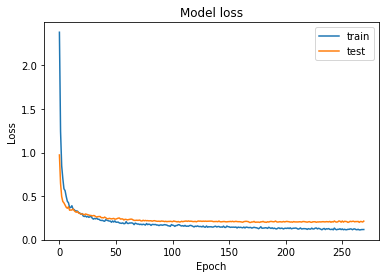

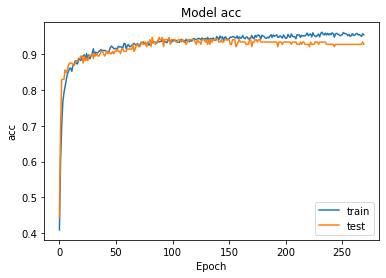

accuracy: 97.26%
Epoch 1/500
11/11 - 1s - loss: 2.4069 - accuracy: 0.4191 - auc: 0.5800 - val_loss: 0.9114 - val_accuracy: 0.5098 - val_auc: 0.7451 - 874ms/epoch - 79ms/step
Epoch 2/500
11/11 - 0s - loss: 1.2195 - accuracy: 0.6082 - auc: 0.7860 - val_loss: 0.6221 - val_accuracy: 0.7124 - val_auc: 0.8896 - 47ms/epoch - 4ms/step
Epoch 3/500
11/11 - 0s - loss: 0.7961 - accuracy: 0.7289 - auc: 0.8824 - val_loss: 0.5019 - val_accuracy: 0.7778 - val_auc: 0.9294 - 47ms/epoch - 4ms/step
Epoch 4/500
11/11 - 0s - loss: 0.6724 - accuracy: 0.7715 - auc: 0.9163 - val_loss: 0.4314 - val_accuracy: 0.8235 - val_auc: 0.9512 - 47ms/epoch - 4ms/step
Epoch 5/500
11/11 - 0s - loss: 0.5579 - accuracy: 0.8102 - auc: 0.9354 - val_loss: 0.4223 - val_accuracy: 0.8235 - val_auc: 0.9544 - 47ms/epoch - 4ms/step
Epoch 6/500
11/11 - 0s - loss: 0.5214 - accuracy: 0.8269 - auc: 0.9462 - val_loss: 0.3892 - val_accuracy: 0.8431 - val_auc: 0.9597 - 47ms/epoch - 4ms/step
Epoch 7/500
11/11 - 0s - loss: 0.4692 - accuracy: 0

Epoch 54/500
11/11 - 0s - loss: 0.1860 - accuracy: 0.9248 - auc: 0.9905 - val_loss: 0.2336 - val_accuracy: 0.9085 - val_auc: 0.9847 - 47ms/epoch - 4ms/step
Epoch 55/500
11/11 - 0s - loss: 0.1885 - accuracy: 0.9248 - auc: 0.9898 - val_loss: 0.2235 - val_accuracy: 0.9150 - val_auc: 0.9868 - 47ms/epoch - 4ms/step
Epoch 56/500
11/11 - 0s - loss: 0.1795 - accuracy: 0.9286 - auc: 0.9910 - val_loss: 0.2309 - val_accuracy: 0.9020 - val_auc: 0.9857 - 47ms/epoch - 4ms/step
Epoch 57/500
11/11 - 0s - loss: 0.1974 - accuracy: 0.9248 - auc: 0.9893 - val_loss: 0.2272 - val_accuracy: 0.9085 - val_auc: 0.9858 - 47ms/epoch - 4ms/step
Epoch 58/500
11/11 - 0s - loss: 0.1857 - accuracy: 0.9195 - auc: 0.9901 - val_loss: 0.2310 - val_accuracy: 0.9020 - val_auc: 0.9854 - 47ms/epoch - 4ms/step
Epoch 59/500
11/11 - 0s - loss: 0.1660 - accuracy: 0.9339 - auc: 0.9923 - val_loss: 0.2182 - val_accuracy: 0.9346 - val_auc: 0.9872 - 47ms/epoch - 4ms/step
Epoch 60/500
11/11 - 0s - loss: 0.1803 - accuracy: 0.9301 - auc:

Epoch 107/500
11/11 - 0s - loss: 0.1475 - accuracy: 0.9468 - auc: 0.9935 - val_loss: 0.2068 - val_accuracy: 0.9281 - val_auc: 0.9885 - 47ms/epoch - 4ms/step
Epoch 108/500
11/11 - 0s - loss: 0.1558 - accuracy: 0.9400 - auc: 0.9930 - val_loss: 0.2099 - val_accuracy: 0.9216 - val_auc: 0.9882 - 47ms/epoch - 4ms/step
Epoch 109/500
11/11 - 0s - loss: 0.1386 - accuracy: 0.9446 - auc: 0.9947 - val_loss: 0.2070 - val_accuracy: 0.9281 - val_auc: 0.9883 - 47ms/epoch - 4ms/step
Epoch 110/500
11/11 - 0s - loss: 0.1519 - accuracy: 0.9446 - auc: 0.9928 - val_loss: 0.2052 - val_accuracy: 0.9281 - val_auc: 0.9885 - 47ms/epoch - 4ms/step
Epoch 111/500
11/11 - 0s - loss: 0.1518 - accuracy: 0.9400 - auc: 0.9928 - val_loss: 0.2038 - val_accuracy: 0.9281 - val_auc: 0.9890 - 48ms/epoch - 4ms/step
Epoch 112/500
11/11 - 0s - loss: 0.1401 - accuracy: 0.9476 - auc: 0.9940 - val_loss: 0.2058 - val_accuracy: 0.9281 - val_auc: 0.9888 - 47ms/epoch - 4ms/step
Epoch 113/500
11/11 - 0s - loss: 0.1486 - accuracy: 0.9453

Epoch 160/500
11/11 - 0s - loss: 0.1268 - accuracy: 0.9582 - auc: 0.9940 - val_loss: 0.2063 - val_accuracy: 0.9412 - val_auc: 0.9854 - 31ms/epoch - 3ms/step
Epoch 161/500
11/11 - 0s - loss: 0.1187 - accuracy: 0.9552 - auc: 0.9953 - val_loss: 0.2023 - val_accuracy: 0.9412 - val_auc: 0.9889 - 47ms/epoch - 4ms/step
Epoch 162/500
11/11 - 0s - loss: 0.1327 - accuracy: 0.9506 - auc: 0.9938 - val_loss: 0.2045 - val_accuracy: 0.9281 - val_auc: 0.9856 - 47ms/epoch - 4ms/step
Epoch 163/500
11/11 - 0s - loss: 0.1298 - accuracy: 0.9476 - auc: 0.9946 - val_loss: 0.2126 - val_accuracy: 0.9346 - val_auc: 0.9848 - 47ms/epoch - 4ms/step
Epoch 164/500
11/11 - 0s - loss: 0.1326 - accuracy: 0.9506 - auc: 0.9949 - val_loss: 0.2044 - val_accuracy: 0.9346 - val_auc: 0.9854 - 47ms/epoch - 4ms/step
Epoch 165/500
11/11 - 0s - loss: 0.1197 - accuracy: 0.9552 - auc: 0.9955 - val_loss: 0.2102 - val_accuracy: 0.9346 - val_auc: 0.9877 - 47ms/epoch - 4ms/step
Epoch 166/500
11/11 - 0s - loss: 0.1249 - accuracy: 0.9552

Epoch 213/500
11/11 - 0s - loss: 0.1188 - accuracy: 0.9567 - auc: 0.9954 - val_loss: 0.2123 - val_accuracy: 0.9281 - val_auc: 0.9853 - 62ms/epoch - 6ms/step
Epoch 214/500
11/11 - 0s - loss: 0.1095 - accuracy: 0.9590 - auc: 0.9966 - val_loss: 0.2097 - val_accuracy: 0.9281 - val_auc: 0.9855 - 47ms/epoch - 4ms/step
Epoch 215/500
11/11 - 0s - loss: 0.1309 - accuracy: 0.9522 - auc: 0.9945 - val_loss: 0.2157 - val_accuracy: 0.9346 - val_auc: 0.9848 - 47ms/epoch - 4ms/step
Epoch 216/500
11/11 - 0s - loss: 0.1199 - accuracy: 0.9567 - auc: 0.9950 - val_loss: 0.2144 - val_accuracy: 0.9281 - val_auc: 0.9849 - 49ms/epoch - 4ms/step
Epoch 217/500
11/11 - 0s - loss: 0.1181 - accuracy: 0.9544 - auc: 0.9952 - val_loss: 0.2218 - val_accuracy: 0.9346 - val_auc: 0.9841 - 62ms/epoch - 6ms/step
Epoch 218/500
11/11 - 0s - loss: 0.1120 - accuracy: 0.9651 - auc: 0.9959 - val_loss: 0.2122 - val_accuracy: 0.9346 - val_auc: 0.9849 - 47ms/epoch - 4ms/step
Epoch 219/500
11/11 - 0s - loss: 0.1118 - accuracy: 0.9582

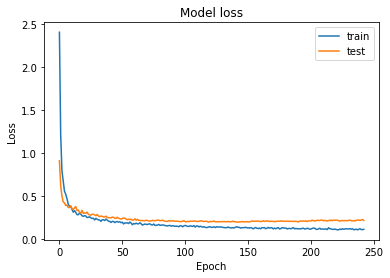

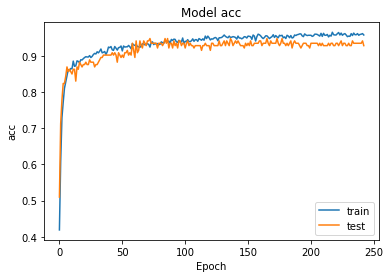

accuracy: 93.15%
Epoch 1/500
11/11 - 1s - loss: 2.4247 - accuracy: 0.4017 - auc: 0.5814 - val_loss: 0.9961 - val_accuracy: 0.4641 - val_auc: 0.7169 - 828ms/epoch - 75ms/step
Epoch 2/500
11/11 - 0s - loss: 1.2148 - accuracy: 0.6128 - auc: 0.7907 - val_loss: 0.6755 - val_accuracy: 0.6536 - val_auc: 0.8684 - 47ms/epoch - 4ms/step
Epoch 3/500
11/11 - 0s - loss: 0.8390 - accuracy: 0.7122 - auc: 0.8757 - val_loss: 0.4552 - val_accuracy: 0.8170 - val_auc: 0.9438 - 47ms/epoch - 4ms/step
Epoch 4/500
11/11 - 0s - loss: 0.6834 - accuracy: 0.7715 - auc: 0.9121 - val_loss: 0.4910 - val_accuracy: 0.7908 - val_auc: 0.9336 - 47ms/epoch - 4ms/step
Epoch 5/500
11/11 - 0s - loss: 0.5685 - accuracy: 0.8064 - auc: 0.9352 - val_loss: 0.4056 - val_accuracy: 0.8431 - val_auc: 0.9567 - 31ms/epoch - 3ms/step
Epoch 6/500
11/11 - 0s - loss: 0.4793 - accuracy: 0.8421 - auc: 0.9503 - val_loss: 0.3945 - val_accuracy: 0.8497 - val_auc: 0.9567 - 31ms/epoch - 3ms/step
Epoch 7/500
11/11 - 0s - loss: 0.4904 - accuracy: 0

Epoch 54/500
11/11 - 0s - loss: 0.1996 - accuracy: 0.9218 - auc: 0.9885 - val_loss: 0.2469 - val_accuracy: 0.9216 - val_auc: 0.9841 - 47ms/epoch - 4ms/step
Epoch 55/500
11/11 - 0s - loss: 0.1813 - accuracy: 0.9301 - auc: 0.9906 - val_loss: 0.2440 - val_accuracy: 0.9281 - val_auc: 0.9834 - 47ms/epoch - 4ms/step
Epoch 56/500
11/11 - 0s - loss: 0.1867 - accuracy: 0.9256 - auc: 0.9897 - val_loss: 0.2357 - val_accuracy: 0.9085 - val_auc: 0.9853 - 47ms/epoch - 4ms/step
Epoch 57/500
11/11 - 0s - loss: 0.1927 - accuracy: 0.9263 - auc: 0.9893 - val_loss: 0.2417 - val_accuracy: 0.9150 - val_auc: 0.9846 - 47ms/epoch - 4ms/step
Epoch 58/500
11/11 - 0s - loss: 0.1806 - accuracy: 0.9279 - auc: 0.9906 - val_loss: 0.2382 - val_accuracy: 0.9150 - val_auc: 0.9851 - 47ms/epoch - 4ms/step
Epoch 59/500
11/11 - 0s - loss: 0.1792 - accuracy: 0.9301 - auc: 0.9910 - val_loss: 0.2337 - val_accuracy: 0.9346 - val_auc: 0.9857 - 47ms/epoch - 4ms/step
Epoch 60/500
11/11 - 0s - loss: 0.1691 - accuracy: 0.9271 - auc:

Epoch 107/500
11/11 - 0s - loss: 0.1427 - accuracy: 0.9499 - auc: 0.9936 - val_loss: 0.2205 - val_accuracy: 0.9346 - val_auc: 0.9863 - 78ms/epoch - 7ms/step
Epoch 108/500
11/11 - 0s - loss: 0.1509 - accuracy: 0.9423 - auc: 0.9924 - val_loss: 0.2112 - val_accuracy: 0.9216 - val_auc: 0.9875 - 78ms/epoch - 7ms/step
Epoch 109/500
11/11 - 0s - loss: 0.1377 - accuracy: 0.9468 - auc: 0.9943 - val_loss: 0.2164 - val_accuracy: 0.9216 - val_auc: 0.9870 - 62ms/epoch - 6ms/step
Epoch 110/500
11/11 - 0s - loss: 0.1404 - accuracy: 0.9453 - auc: 0.9940 - val_loss: 0.2113 - val_accuracy: 0.9281 - val_auc: 0.9878 - 94ms/epoch - 9ms/step
Epoch 111/500
11/11 - 0s - loss: 0.1444 - accuracy: 0.9453 - auc: 0.9934 - val_loss: 0.2177 - val_accuracy: 0.9346 - val_auc: 0.9867 - 78ms/epoch - 7ms/step
Epoch 112/500
11/11 - 0s - loss: 0.1352 - accuracy: 0.9491 - auc: 0.9946 - val_loss: 0.2210 - val_accuracy: 0.9216 - val_auc: 0.9868 - 62ms/epoch - 6ms/step
Epoch 113/500
11/11 - 0s - loss: 0.1427 - accuracy: 0.9446

Epoch 160/500
11/11 - 0s - loss: 0.1344 - accuracy: 0.9499 - auc: 0.9945 - val_loss: 0.2212 - val_accuracy: 0.9412 - val_auc: 0.9845 - 47ms/epoch - 4ms/step
Epoch 161/500
11/11 - 0s - loss: 0.1365 - accuracy: 0.9484 - auc: 0.9944 - val_loss: 0.2135 - val_accuracy: 0.9346 - val_auc: 0.9842 - 47ms/epoch - 4ms/step
Epoch 162/500
11/11 - 0s - loss: 0.1221 - accuracy: 0.9529 - auc: 0.9955 - val_loss: 0.2195 - val_accuracy: 0.9346 - val_auc: 0.9841 - 47ms/epoch - 4ms/step
Epoch 163/500
11/11 - 0s - loss: 0.1285 - accuracy: 0.9499 - auc: 0.9950 - val_loss: 0.2171 - val_accuracy: 0.9281 - val_auc: 0.9844 - 47ms/epoch - 4ms/step
Epoch 164/500
11/11 - 0s - loss: 0.1236 - accuracy: 0.9522 - auc: 0.9949 - val_loss: 0.2243 - val_accuracy: 0.9281 - val_auc: 0.9834 - 47ms/epoch - 4ms/step
Epoch 165/500
11/11 - 0s - loss: 0.1291 - accuracy: 0.9522 - auc: 0.9952 - val_loss: 0.2258 - val_accuracy: 0.9346 - val_auc: 0.9833 - 47ms/epoch - 4ms/step
Epoch 166/500
11/11 - 0s - loss: 0.1254 - accuracy: 0.9476

Epoch 213/500
11/11 - 0s - loss: 0.1096 - accuracy: 0.9575 - auc: 0.9961 - val_loss: 0.2231 - val_accuracy: 0.9281 - val_auc: 0.9832 - 31ms/epoch - 3ms/step
Epoch 214/500
11/11 - 0s - loss: 0.1163 - accuracy: 0.9567 - auc: 0.9957 - val_loss: 0.2188 - val_accuracy: 0.9346 - val_auc: 0.9837 - 31ms/epoch - 3ms/step
Epoch 215/500
11/11 - 0s - loss: 0.1081 - accuracy: 0.9613 - auc: 0.9958 - val_loss: 0.2206 - val_accuracy: 0.9346 - val_auc: 0.9837 - 31ms/epoch - 3ms/step
Epoch 216/500
11/11 - 0s - loss: 0.1106 - accuracy: 0.9560 - auc: 0.9964 - val_loss: 0.2256 - val_accuracy: 0.9346 - val_auc: 0.9833 - 31ms/epoch - 3ms/step
Epoch 217/500
11/11 - 0s - loss: 0.1152 - accuracy: 0.9552 - auc: 0.9956 - val_loss: 0.2155 - val_accuracy: 0.9346 - val_auc: 0.9841 - 47ms/epoch - 4ms/step
Epoch 218/500
11/11 - 0s - loss: 0.1140 - accuracy: 0.9499 - auc: 0.9963 - val_loss: 0.2236 - val_accuracy: 0.9346 - val_auc: 0.9835 - 47ms/epoch - 4ms/step
Epoch 219/500
11/11 - 0s - loss: 0.1101 - accuracy: 0.9605

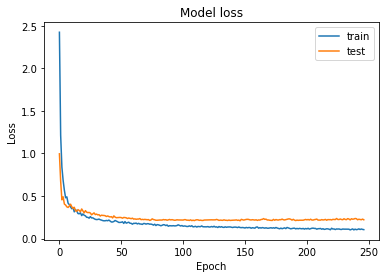

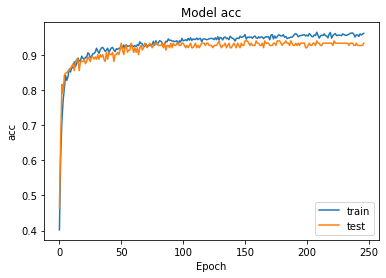

accuracy: 95.21%
Epoch 1/500
11/11 - 1s - loss: 2.4501 - accuracy: 0.4002 - auc: 0.5761 - val_loss: 1.0812 - val_accuracy: 0.4444 - val_auc: 0.6909 - 819ms/epoch - 74ms/step
Epoch 2/500
11/11 - 0s - loss: 1.2484 - accuracy: 0.6059 - auc: 0.7849 - val_loss: 0.6503 - val_accuracy: 0.6928 - val_auc: 0.8788 - 31ms/epoch - 3ms/step
Epoch 3/500
11/11 - 0s - loss: 0.8899 - accuracy: 0.7062 - auc: 0.8680 - val_loss: 0.4795 - val_accuracy: 0.8039 - val_auc: 0.9387 - 47ms/epoch - 4ms/step
Epoch 4/500
11/11 - 0s - loss: 0.7104 - accuracy: 0.7775 - auc: 0.9093 - val_loss: 0.4740 - val_accuracy: 0.7843 - val_auc: 0.9442 - 47ms/epoch - 4ms/step
Epoch 5/500
11/11 - 0s - loss: 0.6023 - accuracy: 0.7935 - auc: 0.9305 - val_loss: 0.4305 - val_accuracy: 0.8431 - val_auc: 0.9522 - 31ms/epoch - 3ms/step
Epoch 6/500
11/11 - 0s - loss: 0.5209 - accuracy: 0.8223 - auc: 0.9442 - val_loss: 0.3943 - val_accuracy: 0.8497 - val_auc: 0.9573 - 39ms/epoch - 4ms/step
Epoch 7/500
11/11 - 0s - loss: 0.5076 - accuracy: 0

Epoch 54/500
11/11 - 0s - loss: 0.1934 - accuracy: 0.9195 - auc: 0.9895 - val_loss: 0.2463 - val_accuracy: 0.9085 - val_auc: 0.9838 - 49ms/epoch - 4ms/step
Epoch 55/500
11/11 - 0s - loss: 0.1991 - accuracy: 0.9195 - auc: 0.9891 - val_loss: 0.2533 - val_accuracy: 0.9085 - val_auc: 0.9830 - 55ms/epoch - 5ms/step
Epoch 56/500
11/11 - 0s - loss: 0.1994 - accuracy: 0.9172 - auc: 0.9886 - val_loss: 0.2460 - val_accuracy: 0.9216 - val_auc: 0.9837 - 47ms/epoch - 4ms/step
Epoch 57/500
11/11 - 0s - loss: 0.2060 - accuracy: 0.9172 - auc: 0.9882 - val_loss: 0.2455 - val_accuracy: 0.9085 - val_auc: 0.9834 - 47ms/epoch - 4ms/step
Epoch 58/500
11/11 - 0s - loss: 0.1965 - accuracy: 0.9195 - auc: 0.9891 - val_loss: 0.2569 - val_accuracy: 0.8954 - val_auc: 0.9817 - 47ms/epoch - 4ms/step
Epoch 59/500
11/11 - 0s - loss: 0.1890 - accuracy: 0.9271 - auc: 0.9896 - val_loss: 0.2442 - val_accuracy: 0.9085 - val_auc: 0.9844 - 47ms/epoch - 4ms/step
Epoch 60/500
11/11 - 0s - loss: 0.1906 - accuracy: 0.9241 - auc:

Epoch 107/500
11/11 - 0s - loss: 0.1627 - accuracy: 0.9370 - auc: 0.9922 - val_loss: 0.2103 - val_accuracy: 0.9346 - val_auc: 0.9883 - 31ms/epoch - 3ms/step
Epoch 108/500
11/11 - 0s - loss: 0.1574 - accuracy: 0.9400 - auc: 0.9922 - val_loss: 0.2131 - val_accuracy: 0.9216 - val_auc: 0.9882 - 31ms/epoch - 3ms/step
Epoch 109/500
11/11 - 0s - loss: 0.1575 - accuracy: 0.9393 - auc: 0.9928 - val_loss: 0.2078 - val_accuracy: 0.9346 - val_auc: 0.9885 - 31ms/epoch - 3ms/step
Epoch 110/500
11/11 - 0s - loss: 0.1520 - accuracy: 0.9423 - auc: 0.9933 - val_loss: 0.2086 - val_accuracy: 0.9216 - val_auc: 0.9887 - 45ms/epoch - 4ms/step
Epoch 111/500
11/11 - 0s - loss: 0.1655 - accuracy: 0.9393 - auc: 0.9921 - val_loss: 0.2094 - val_accuracy: 0.9281 - val_auc: 0.9885 - 48ms/epoch - 4ms/step
Epoch 112/500
11/11 - 0s - loss: 0.1535 - accuracy: 0.9393 - auc: 0.9931 - val_loss: 0.2083 - val_accuracy: 0.9346 - val_auc: 0.9883 - 47ms/epoch - 4ms/step
Epoch 113/500
11/11 - 0s - loss: 0.1613 - accuracy: 0.9324

Epoch 160/500
11/11 - 0s - loss: 0.1372 - accuracy: 0.9453 - auc: 0.9940 - val_loss: 0.2097 - val_accuracy: 0.9412 - val_auc: 0.9852 - 55ms/epoch - 5ms/step
Epoch 161/500
11/11 - 0s - loss: 0.1315 - accuracy: 0.9544 - auc: 0.9946 - val_loss: 0.2093 - val_accuracy: 0.9412 - val_auc: 0.9859 - 49ms/epoch - 4ms/step
Epoch 162/500
11/11 - 0s - loss: 0.1374 - accuracy: 0.9446 - auc: 0.9941 - val_loss: 0.2097 - val_accuracy: 0.9346 - val_auc: 0.9851 - 48ms/epoch - 4ms/step
Epoch 163/500
11/11 - 0s - loss: 0.1296 - accuracy: 0.9537 - auc: 0.9944 - val_loss: 0.2066 - val_accuracy: 0.9477 - val_auc: 0.9856 - 45ms/epoch - 4ms/step
Epoch 164/500
11/11 - 0s - loss: 0.1381 - accuracy: 0.9468 - auc: 0.9941 - val_loss: 0.2089 - val_accuracy: 0.9346 - val_auc: 0.9849 - 46ms/epoch - 4ms/step
Epoch 165/500
11/11 - 0s - loss: 0.1333 - accuracy: 0.9461 - auc: 0.9944 - val_loss: 0.2104 - val_accuracy: 0.9412 - val_auc: 0.9850 - 42ms/epoch - 4ms/step
Epoch 166/500
11/11 - 0s - loss: 0.1366 - accuracy: 0.9522

Epoch 213/500
11/11 - 0s - loss: 0.1179 - accuracy: 0.9560 - auc: 0.9958 - val_loss: 0.2072 - val_accuracy: 0.9346 - val_auc: 0.9860 - 52ms/epoch - 5ms/step
Epoch 214/500
11/11 - 0s - loss: 0.1296 - accuracy: 0.9537 - auc: 0.9942 - val_loss: 0.2085 - val_accuracy: 0.9346 - val_auc: 0.9857 - 49ms/epoch - 4ms/step
Epoch 215/500
11/11 - 0s - loss: 0.1253 - accuracy: 0.9529 - auc: 0.9951 - val_loss: 0.2015 - val_accuracy: 0.9346 - val_auc: 0.9861 - 44ms/epoch - 4ms/step
Epoch 216/500
11/11 - 0s - loss: 0.1154 - accuracy: 0.9643 - auc: 0.9954 - val_loss: 0.2068 - val_accuracy: 0.9346 - val_auc: 0.9856 - 56ms/epoch - 5ms/step
Epoch 217/500
11/11 - 0s - loss: 0.1189 - accuracy: 0.9529 - auc: 0.9952 - val_loss: 0.2005 - val_accuracy: 0.9346 - val_auc: 0.9853 - 49ms/epoch - 4ms/step
Epoch 218/500
11/11 - 0s - loss: 0.1137 - accuracy: 0.9636 - auc: 0.9957 - val_loss: 0.2050 - val_accuracy: 0.9412 - val_auc: 0.9849 - 47ms/epoch - 4ms/step
Epoch 219/500
11/11 - 0s - loss: 0.1156 - accuracy: 0.9544

Epoch 266/500
11/11 - 0s - loss: 0.1045 - accuracy: 0.9628 - auc: 0.9969 - val_loss: 0.2146 - val_accuracy: 0.9346 - val_auc: 0.9845 - 47ms/epoch - 4ms/step
Epoch 267/500
11/11 - 0s - loss: 0.1059 - accuracy: 0.9605 - auc: 0.9963 - val_loss: 0.2238 - val_accuracy: 0.9346 - val_auc: 0.9840 - 47ms/epoch - 4ms/step
Epoch 268/500
11/11 - 0s - loss: 0.1180 - accuracy: 0.9605 - auc: 0.9951 - val_loss: 0.2172 - val_accuracy: 0.9412 - val_auc: 0.9846 - 47ms/epoch - 4ms/step
Epoch 269/500
11/11 - 0s - loss: 0.1108 - accuracy: 0.9613 - auc: 0.9959 - val_loss: 0.2238 - val_accuracy: 0.9346 - val_auc: 0.9834 - 47ms/epoch - 4ms/step
Epoch 270/500
11/11 - 0s - loss: 0.1096 - accuracy: 0.9620 - auc: 0.9956 - val_loss: 0.2164 - val_accuracy: 0.9346 - val_auc: 0.9843 - 47ms/epoch - 4ms/step
Epoch 271/500
11/11 - 0s - loss: 0.1086 - accuracy: 0.9636 - auc: 0.9960 - val_loss: 0.2141 - val_accuracy: 0.9346 - val_auc: 0.9843 - 47ms/epoch - 4ms/step
Epoch 272/500
11/11 - 0s - loss: 0.1079 - accuracy: 0.9643

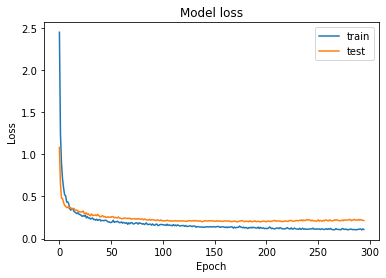

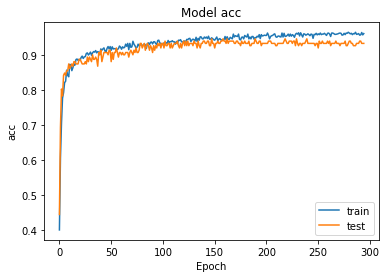

accuracy: 97.26%
Epoch 1/500
11/11 - 1s - loss: 2.4316 - accuracy: 0.4252 - auc: 0.5821 - val_loss: 1.0429 - val_accuracy: 0.4641 - val_auc: 0.7061 - 837ms/epoch - 76ms/step
Epoch 2/500
11/11 - 0s - loss: 1.2567 - accuracy: 0.6052 - auc: 0.7857 - val_loss: 0.6635 - val_accuracy: 0.6797 - val_auc: 0.8743 - 43ms/epoch - 4ms/step
Epoch 3/500
11/11 - 0s - loss: 0.8274 - accuracy: 0.7168 - auc: 0.8800 - val_loss: 0.5213 - val_accuracy: 0.8105 - val_auc: 0.9316 - 44ms/epoch - 4ms/step
Epoch 4/500
11/11 - 0s - loss: 0.6615 - accuracy: 0.7677 - auc: 0.9157 - val_loss: 0.4418 - val_accuracy: 0.8235 - val_auc: 0.9475 - 49ms/epoch - 4ms/step
Epoch 5/500
11/11 - 0s - loss: 0.6730 - accuracy: 0.7722 - auc: 0.9216 - val_loss: 0.4598 - val_accuracy: 0.8431 - val_auc: 0.9472 - 47ms/epoch - 4ms/step
Epoch 6/500
11/11 - 0s - loss: 0.5469 - accuracy: 0.8231 - auc: 0.9395 - val_loss: 0.3901 - val_accuracy: 0.8497 - val_auc: 0.9577 - 45ms/epoch - 4ms/step
Epoch 7/500
11/11 - 0s - loss: 0.4929 - accuracy: 0

Epoch 54/500
11/11 - 0s - loss: 0.1961 - accuracy: 0.9210 - auc: 0.9889 - val_loss: 0.2410 - val_accuracy: 0.8954 - val_auc: 0.9838 - 52ms/epoch - 5ms/step
Epoch 55/500
11/11 - 0s - loss: 0.1924 - accuracy: 0.9188 - auc: 0.9898 - val_loss: 0.2327 - val_accuracy: 0.9020 - val_auc: 0.9847 - 49ms/epoch - 4ms/step
Epoch 56/500
11/11 - 0s - loss: 0.1900 - accuracy: 0.9263 - auc: 0.9899 - val_loss: 0.2336 - val_accuracy: 0.9085 - val_auc: 0.9850 - 45ms/epoch - 4ms/step
Epoch 57/500
11/11 - 0s - loss: 0.1898 - accuracy: 0.9203 - auc: 0.9898 - val_loss: 0.2385 - val_accuracy: 0.9020 - val_auc: 0.9846 - 49ms/epoch - 4ms/step
Epoch 58/500
11/11 - 0s - loss: 0.1860 - accuracy: 0.9195 - auc: 0.9900 - val_loss: 0.2320 - val_accuracy: 0.9150 - val_auc: 0.9858 - 41ms/epoch - 4ms/step
Epoch 59/500
11/11 - 0s - loss: 0.1885 - accuracy: 0.9226 - auc: 0.9901 - val_loss: 0.2335 - val_accuracy: 0.9216 - val_auc: 0.9856 - 54ms/epoch - 5ms/step
Epoch 60/500
11/11 - 0s - loss: 0.1977 - accuracy: 0.9218 - auc:

Epoch 107/500
11/11 - 0s - loss: 0.1654 - accuracy: 0.9362 - auc: 0.9916 - val_loss: 0.2112 - val_accuracy: 0.9150 - val_auc: 0.9880 - 47ms/epoch - 4ms/step
Epoch 108/500
11/11 - 0s - loss: 0.1556 - accuracy: 0.9415 - auc: 0.9924 - val_loss: 0.2151 - val_accuracy: 0.9085 - val_auc: 0.9874 - 56ms/epoch - 5ms/step
Epoch 109/500
11/11 - 0s - loss: 0.1587 - accuracy: 0.9362 - auc: 0.9926 - val_loss: 0.2150 - val_accuracy: 0.9216 - val_auc: 0.9876 - 48ms/epoch - 4ms/step
Epoch 110/500
11/11 - 0s - loss: 0.1532 - accuracy: 0.9400 - auc: 0.9931 - val_loss: 0.2253 - val_accuracy: 0.9150 - val_auc: 0.9864 - 48ms/epoch - 4ms/step
Epoch 111/500
11/11 - 0s - loss: 0.1539 - accuracy: 0.9362 - auc: 0.9931 - val_loss: 0.2148 - val_accuracy: 0.9216 - val_auc: 0.9874 - 51ms/epoch - 5ms/step
Epoch 112/500
11/11 - 0s - loss: 0.1618 - accuracy: 0.9377 - auc: 0.9925 - val_loss: 0.2070 - val_accuracy: 0.9216 - val_auc: 0.9884 - 45ms/epoch - 4ms/step
Epoch 113/500
11/11 - 0s - loss: 0.1563 - accuracy: 0.9423

Epoch 160/500
11/11 - 0s - loss: 0.1440 - accuracy: 0.9484 - auc: 0.9934 - val_loss: 0.2095 - val_accuracy: 0.9346 - val_auc: 0.9876 - 47ms/epoch - 4ms/step
Epoch 161/500
11/11 - 0s - loss: 0.1332 - accuracy: 0.9506 - auc: 0.9946 - val_loss: 0.2146 - val_accuracy: 0.9346 - val_auc: 0.9849 - 48ms/epoch - 4ms/step
Epoch 162/500
11/11 - 0s - loss: 0.1331 - accuracy: 0.9499 - auc: 0.9944 - val_loss: 0.2067 - val_accuracy: 0.9412 - val_auc: 0.9878 - 47ms/epoch - 4ms/step
Epoch 163/500
11/11 - 0s - loss: 0.1323 - accuracy: 0.9499 - auc: 0.9950 - val_loss: 0.2137 - val_accuracy: 0.9281 - val_auc: 0.9843 - 47ms/epoch - 4ms/step
Epoch 164/500
11/11 - 0s - loss: 0.1348 - accuracy: 0.9514 - auc: 0.9942 - val_loss: 0.2067 - val_accuracy: 0.9346 - val_auc: 0.9873 - 58ms/epoch - 5ms/step
Epoch 165/500
11/11 - 0s - loss: 0.1334 - accuracy: 0.9506 - auc: 0.9941 - val_loss: 0.2061 - val_accuracy: 0.9281 - val_auc: 0.9878 - 43ms/epoch - 4ms/step
Epoch 166/500
11/11 - 0s - loss: 0.1389 - accuracy: 0.9522

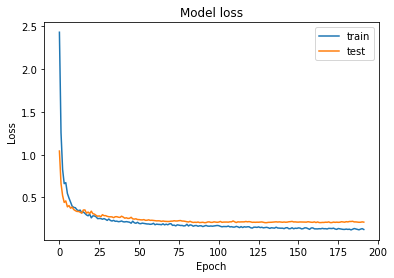

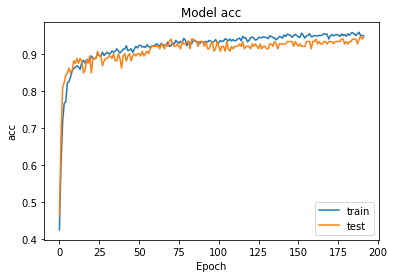

accuracy: 93.84%
Epoch 1/500
11/11 - 1s - loss: 2.4841 - accuracy: 0.4252 - auc: 0.5809 - val_loss: 1.1055 - val_accuracy: 0.4706 - val_auc: 0.6983 - 820ms/epoch - 75ms/step
Epoch 2/500
11/11 - 0s - loss: 1.2344 - accuracy: 0.6112 - auc: 0.7838 - val_loss: 0.6414 - val_accuracy: 0.6863 - val_auc: 0.8823 - 31ms/epoch - 3ms/step
Epoch 3/500
11/11 - 0s - loss: 0.8348 - accuracy: 0.7160 - auc: 0.8781 - val_loss: 0.4937 - val_accuracy: 0.8170 - val_auc: 0.9315 - 47ms/epoch - 4ms/step
Epoch 4/500
11/11 - 0s - loss: 0.6994 - accuracy: 0.7585 - auc: 0.9080 - val_loss: 0.4948 - val_accuracy: 0.7908 - val_auc: 0.9355 - 47ms/epoch - 4ms/step
Epoch 5/500
11/11 - 0s - loss: 0.5586 - accuracy: 0.8003 - auc: 0.9367 - val_loss: 0.4041 - val_accuracy: 0.8431 - val_auc: 0.9551 - 47ms/epoch - 4ms/step
Epoch 6/500
11/11 - 0s - loss: 0.5365 - accuracy: 0.8314 - auc: 0.9439 - val_loss: 0.4076 - val_accuracy: 0.8562 - val_auc: 0.9544 - 47ms/epoch - 4ms/step
Epoch 7/500
11/11 - 0s - loss: 0.4406 - accuracy: 0

Epoch 54/500
11/11 - 0s - loss: 0.2033 - accuracy: 0.9248 - auc: 0.9883 - val_loss: 0.2273 - val_accuracy: 0.9216 - val_auc: 0.9865 - 47ms/epoch - 4ms/step
Epoch 55/500
11/11 - 0s - loss: 0.1802 - accuracy: 0.9271 - auc: 0.9909 - val_loss: 0.2318 - val_accuracy: 0.9216 - val_auc: 0.9860 - 47ms/epoch - 4ms/step
Epoch 56/500
11/11 - 0s - loss: 0.1774 - accuracy: 0.9339 - auc: 0.9910 - val_loss: 0.2288 - val_accuracy: 0.9085 - val_auc: 0.9860 - 47ms/epoch - 4ms/step
Epoch 57/500
11/11 - 0s - loss: 0.1947 - accuracy: 0.9172 - auc: 0.9890 - val_loss: 0.2260 - val_accuracy: 0.9216 - val_auc: 0.9868 - 47ms/epoch - 4ms/step
Epoch 58/500
11/11 - 0s - loss: 0.1927 - accuracy: 0.9195 - auc: 0.9896 - val_loss: 0.2347 - val_accuracy: 0.9216 - val_auc: 0.9852 - 47ms/epoch - 4ms/step
Epoch 59/500
11/11 - 0s - loss: 0.1822 - accuracy: 0.9294 - auc: 0.9906 - val_loss: 0.2295 - val_accuracy: 0.9281 - val_auc: 0.9858 - 31ms/epoch - 3ms/step
Epoch 60/500
11/11 - 0s - loss: 0.1871 - accuracy: 0.9263 - auc:

Epoch 107/500
11/11 - 0s - loss: 0.1615 - accuracy: 0.9377 - auc: 0.9919 - val_loss: 0.2005 - val_accuracy: 0.9346 - val_auc: 0.9893 - 47ms/epoch - 4ms/step
Epoch 108/500
11/11 - 0s - loss: 0.1572 - accuracy: 0.9431 - auc: 0.9926 - val_loss: 0.2051 - val_accuracy: 0.9281 - val_auc: 0.9886 - 47ms/epoch - 4ms/step
Epoch 109/500
11/11 - 0s - loss: 0.1539 - accuracy: 0.9377 - auc: 0.9928 - val_loss: 0.2209 - val_accuracy: 0.9216 - val_auc: 0.9867 - 47ms/epoch - 4ms/step
Epoch 110/500
11/11 - 0s - loss: 0.1548 - accuracy: 0.9438 - auc: 0.9930 - val_loss: 0.2057 - val_accuracy: 0.9216 - val_auc: 0.9883 - 47ms/epoch - 4ms/step
Epoch 111/500
11/11 - 0s - loss: 0.1545 - accuracy: 0.9408 - auc: 0.9931 - val_loss: 0.2009 - val_accuracy: 0.9346 - val_auc: 0.9889 - 47ms/epoch - 4ms/step
Epoch 112/500
11/11 - 0s - loss: 0.1552 - accuracy: 0.9423 - auc: 0.9930 - val_loss: 0.2024 - val_accuracy: 0.9281 - val_auc: 0.9890 - 47ms/epoch - 4ms/step
Epoch 113/500
11/11 - 0s - loss: 0.1483 - accuracy: 0.9461

Epoch 160/500
11/11 - 0s - loss: 0.1309 - accuracy: 0.9514 - auc: 0.9948 - val_loss: 0.2076 - val_accuracy: 0.9346 - val_auc: 0.9878 - 47ms/epoch - 4ms/step
Epoch 161/500
11/11 - 0s - loss: 0.1373 - accuracy: 0.9491 - auc: 0.9941 - val_loss: 0.2082 - val_accuracy: 0.9346 - val_auc: 0.9875 - 54ms/epoch - 5ms/step
Epoch 162/500
11/11 - 0s - loss: 0.1373 - accuracy: 0.9552 - auc: 0.9942 - val_loss: 0.2065 - val_accuracy: 0.9346 - val_auc: 0.9872 - 44ms/epoch - 4ms/step
Epoch 163/500
11/11 - 0s - loss: 0.1345 - accuracy: 0.9522 - auc: 0.9941 - val_loss: 0.2106 - val_accuracy: 0.9346 - val_auc: 0.9867 - 50ms/epoch - 5ms/step
Epoch 164/500
11/11 - 0s - loss: 0.1236 - accuracy: 0.9605 - auc: 0.9949 - val_loss: 0.2047 - val_accuracy: 0.9412 - val_auc: 0.9874 - 47ms/epoch - 4ms/step
Epoch 165/500
11/11 - 0s - loss: 0.1324 - accuracy: 0.9499 - auc: 0.9947 - val_loss: 0.2072 - val_accuracy: 0.9412 - val_auc: 0.9877 - 47ms/epoch - 4ms/step
Epoch 166/500
11/11 - 0s - loss: 0.1302 - accuracy: 0.9544

Epoch 213/500
11/11 - 0s - loss: 0.1199 - accuracy: 0.9590 - auc: 0.9949 - val_loss: 0.2118 - val_accuracy: 0.9412 - val_auc: 0.9843 - 51ms/epoch - 5ms/step
Epoch 214/500
11/11 - 0s - loss: 0.1172 - accuracy: 0.9605 - auc: 0.9949 - val_loss: 0.2135 - val_accuracy: 0.9346 - val_auc: 0.9869 - 63ms/epoch - 6ms/step
Epoch 215/500
11/11 - 0s - loss: 0.1211 - accuracy: 0.9537 - auc: 0.9950 - val_loss: 0.2079 - val_accuracy: 0.9346 - val_auc: 0.9877 - 62ms/epoch - 6ms/step
Epoch 216/500
11/11 - 0s - loss: 0.1170 - accuracy: 0.9613 - auc: 0.9952 - val_loss: 0.2149 - val_accuracy: 0.9346 - val_auc: 0.9842 - 63ms/epoch - 6ms/step
Epoch 217/500
11/11 - 0s - loss: 0.1253 - accuracy: 0.9567 - auc: 0.9948 - val_loss: 0.2128 - val_accuracy: 0.9346 - val_auc: 0.9845 - 62ms/epoch - 6ms/step
Epoch 218/500
11/11 - 0s - loss: 0.1213 - accuracy: 0.9643 - auc: 0.9954 - val_loss: 0.2109 - val_accuracy: 0.9412 - val_auc: 0.9875 - 62ms/epoch - 6ms/step
Epoch 219/500
11/11 - 0s - loss: 0.1213 - accuracy: 0.9628

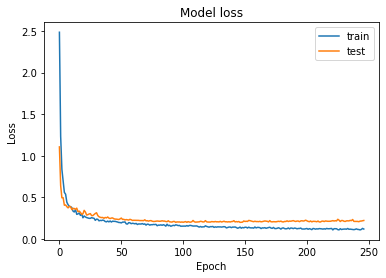

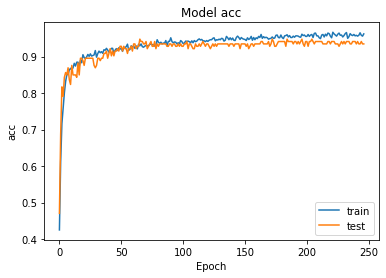

accuracy: 95.89%
Epoch 1/500
11/11 - 1s - loss: 2.3297 - accuracy: 0.4138 - auc: 0.5920 - val_loss: 1.0040 - val_accuracy: 0.4510 - val_auc: 0.7215 - 1s/epoch - 102ms/step
Epoch 2/500
11/11 - 0s - loss: 1.1930 - accuracy: 0.6249 - auc: 0.7982 - val_loss: 0.7162 - val_accuracy: 0.6405 - val_auc: 0.8569 - 43ms/epoch - 4ms/step
Epoch 3/500
11/11 - 0s - loss: 0.9129 - accuracy: 0.7137 - auc: 0.8670 - val_loss: 0.4984 - val_accuracy: 0.8301 - val_auc: 0.9347 - 52ms/epoch - 5ms/step
Epoch 4/500
11/11 - 0s - loss: 0.6474 - accuracy: 0.7904 - auc: 0.9200 - val_loss: 0.4596 - val_accuracy: 0.8170 - val_auc: 0.9459 - 65ms/epoch - 6ms/step
Epoch 5/500
11/11 - 0s - loss: 0.5188 - accuracy: 0.8162 - auc: 0.9419 - val_loss: 0.4227 - val_accuracy: 0.8431 - val_auc: 0.9515 - 60ms/epoch - 5ms/step
Epoch 6/500
11/11 - 0s - loss: 0.4787 - accuracy: 0.8337 - auc: 0.9516 - val_loss: 0.3990 - val_accuracy: 0.8366 - val_auc: 0.9582 - 63ms/epoch - 6ms/step
Epoch 7/500
11/11 - 0s - loss: 0.4557 - accuracy: 0.8

Epoch 54/500
11/11 - 0s - loss: 0.1829 - accuracy: 0.9286 - auc: 0.9904 - val_loss: 0.2549 - val_accuracy: 0.8824 - val_auc: 0.9819 - 49ms/epoch - 4ms/step
Epoch 55/500
11/11 - 0s - loss: 0.1892 - accuracy: 0.9263 - auc: 0.9896 - val_loss: 0.2304 - val_accuracy: 0.9085 - val_auc: 0.9856 - 50ms/epoch - 5ms/step
Epoch 56/500
11/11 - 0s - loss: 0.1834 - accuracy: 0.9286 - auc: 0.9907 - val_loss: 0.2292 - val_accuracy: 0.9150 - val_auc: 0.9865 - 53ms/epoch - 5ms/step
Epoch 57/500
11/11 - 0s - loss: 0.1830 - accuracy: 0.9248 - auc: 0.9905 - val_loss: 0.2241 - val_accuracy: 0.9216 - val_auc: 0.9869 - 50ms/epoch - 5ms/step
Epoch 58/500
11/11 - 0s - loss: 0.1842 - accuracy: 0.9309 - auc: 0.9904 - val_loss: 0.2369 - val_accuracy: 0.8889 - val_auc: 0.9844 - 49ms/epoch - 4ms/step
Epoch 59/500
11/11 - 0s - loss: 0.1786 - accuracy: 0.9355 - auc: 0.9913 - val_loss: 0.2233 - val_accuracy: 0.9216 - val_auc: 0.9870 - 49ms/epoch - 4ms/step
Epoch 60/500
11/11 - 0s - loss: 0.1917 - accuracy: 0.9226 - auc:

Epoch 107/500
11/11 - 0s - loss: 0.1478 - accuracy: 0.9461 - auc: 0.9932 - val_loss: 0.2032 - val_accuracy: 0.9346 - val_auc: 0.9885 - 47ms/epoch - 4ms/step
Epoch 108/500
11/11 - 0s - loss: 0.1441 - accuracy: 0.9438 - auc: 0.9940 - val_loss: 0.1991 - val_accuracy: 0.9281 - val_auc: 0.9891 - 47ms/epoch - 4ms/step
Epoch 109/500
11/11 - 0s - loss: 0.1492 - accuracy: 0.9468 - auc: 0.9931 - val_loss: 0.2005 - val_accuracy: 0.9281 - val_auc: 0.9889 - 47ms/epoch - 4ms/step
Epoch 110/500
11/11 - 0s - loss: 0.1494 - accuracy: 0.9491 - auc: 0.9925 - val_loss: 0.1998 - val_accuracy: 0.9412 - val_auc: 0.9889 - 62ms/epoch - 6ms/step
Epoch 111/500
11/11 - 0s - loss: 0.1413 - accuracy: 0.9499 - auc: 0.9941 - val_loss: 0.2022 - val_accuracy: 0.9281 - val_auc: 0.9888 - 62ms/epoch - 6ms/step
Epoch 112/500
11/11 - 0s - loss: 0.1391 - accuracy: 0.9514 - auc: 0.9939 - val_loss: 0.1996 - val_accuracy: 0.9346 - val_auc: 0.9887 - 47ms/epoch - 4ms/step
Epoch 113/500
11/11 - 0s - loss: 0.1474 - accuracy: 0.9468

Epoch 160/500
11/11 - 0s - loss: 0.1380 - accuracy: 0.9522 - auc: 0.9935 - val_loss: 0.2045 - val_accuracy: 0.9281 - val_auc: 0.9879 - 50ms/epoch - 5ms/step
Epoch 161/500
11/11 - 0s - loss: 0.1244 - accuracy: 0.9506 - auc: 0.9952 - val_loss: 0.2027 - val_accuracy: 0.9281 - val_auc: 0.9881 - 35ms/epoch - 3ms/step
Epoch 162/500
11/11 - 0s - loss: 0.1256 - accuracy: 0.9598 - auc: 0.9952 - val_loss: 0.2013 - val_accuracy: 0.9346 - val_auc: 0.9882 - 60ms/epoch - 5ms/step
Epoch 163/500
11/11 - 0s - loss: 0.1287 - accuracy: 0.9529 - auc: 0.9941 - val_loss: 0.2006 - val_accuracy: 0.9281 - val_auc: 0.9881 - 31ms/epoch - 3ms/step
Epoch 164/500
11/11 - 0s - loss: 0.1216 - accuracy: 0.9582 - auc: 0.9956 - val_loss: 0.2075 - val_accuracy: 0.9281 - val_auc: 0.9873 - 47ms/epoch - 4ms/step
Epoch 165/500
11/11 - 0s - loss: 0.1249 - accuracy: 0.9506 - auc: 0.9948 - val_loss: 0.2031 - val_accuracy: 0.9346 - val_auc: 0.9881 - 62ms/epoch - 6ms/step
Epoch 166/500
11/11 - 0s - loss: 0.1281 - accuracy: 0.9567

Epoch 213/500
11/11 - 0s - loss: 0.1154 - accuracy: 0.9582 - auc: 0.9951 - val_loss: 0.2041 - val_accuracy: 0.9412 - val_auc: 0.9874 - 48ms/epoch - 4ms/step
Epoch 214/500
11/11 - 0s - loss: 0.1167 - accuracy: 0.9575 - auc: 0.9956 - val_loss: 0.2029 - val_accuracy: 0.9477 - val_auc: 0.9873 - 54ms/epoch - 5ms/step
Epoch 215/500
11/11 - 0s - loss: 0.1115 - accuracy: 0.9598 - auc: 0.9962 - val_loss: 0.2039 - val_accuracy: 0.9346 - val_auc: 0.9872 - 47ms/epoch - 4ms/step
Epoch 216/500
11/11 - 0s - loss: 0.1196 - accuracy: 0.9651 - auc: 0.9949 - val_loss: 0.1936 - val_accuracy: 0.9412 - val_auc: 0.9884 - 47ms/epoch - 4ms/step
Epoch 217/500
11/11 - 0s - loss: 0.1141 - accuracy: 0.9582 - auc: 0.9954 - val_loss: 0.2058 - val_accuracy: 0.9412 - val_auc: 0.9867 - 47ms/epoch - 4ms/step
Epoch 218/500
11/11 - 0s - loss: 0.1217 - accuracy: 0.9590 - auc: 0.9948 - val_loss: 0.1931 - val_accuracy: 0.9412 - val_auc: 0.9886 - 47ms/epoch - 4ms/step
Epoch 219/500
11/11 - 0s - loss: 0.1111 - accuracy: 0.9598

Epoch 266/500
11/11 - 0s - loss: 0.1145 - accuracy: 0.9620 - auc: 0.9961 - val_loss: 0.2099 - val_accuracy: 0.9412 - val_auc: 0.9859 - 47ms/epoch - 4ms/step
Epoch 267/500
11/11 - 0s - loss: 0.1100 - accuracy: 0.9636 - auc: 0.9959 - val_loss: 0.2051 - val_accuracy: 0.9477 - val_auc: 0.9869 - 47ms/epoch - 4ms/step
Epoch 268/500
11/11 - 0s - loss: 0.1055 - accuracy: 0.9598 - auc: 0.9968 - val_loss: 0.2139 - val_accuracy: 0.9542 - val_auc: 0.9861 - 47ms/epoch - 4ms/step
Epoch 269/500
11/11 - 0s - loss: 0.1120 - accuracy: 0.9567 - auc: 0.9958 - val_loss: 0.2142 - val_accuracy: 0.9346 - val_auc: 0.9860 - 47ms/epoch - 4ms/step
Epoch 270/500
11/11 - 0s - loss: 0.1099 - accuracy: 0.9651 - auc: 0.9958 - val_loss: 0.2105 - val_accuracy: 0.9477 - val_auc: 0.9864 - 47ms/epoch - 4ms/step
Epoch 271/500
11/11 - 0s - loss: 0.1070 - accuracy: 0.9605 - auc: 0.9964 - val_loss: 0.2189 - val_accuracy: 0.9477 - val_auc: 0.9828 - 31ms/epoch - 3ms/step
Epoch 272/500
11/11 - 0s - loss: 0.1058 - accuracy: 0.9696

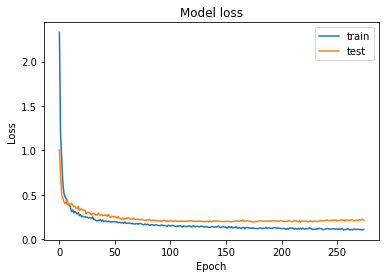

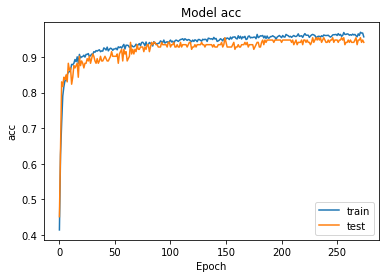

accuracy: 93.15%
[95.91836929321289, 93.19728016853333, 95.91836929321289, 97.26027250289917, 93.1506872177124, 95.20547986030579, 97.26027250289917, 93.83561611175537, 95.89040875434875, 93.1506872177124]
95.08% (+/- 1.55%)


In [67]:
from sklearn.model_selection import KFold
kfold = KFold(n_splits=10, shuffle=True, random_state=7)
cvscores = []
for train, test in kfold.split(X_sc, y_c):
  # create model
    model = Sequential()
    model.add(Dense(128, input_shape=(input,),kernel_initializer=w1_my_init,bias_initializer=b1_my_init))  #
    model.add(Activation('relu'))
    # Dropout层用于防止过拟合
    model.add(Dropout(0.2))
    # 隐藏层128
    model.add(Dense(128,kernel_initializer=w2_my_init,bias_initializer=b2_my_init))
    model.add(Activation('relu'))

    model.add(Dense(3,kernel_initializer=w3_my_init,bias_initializer=b3_my_init))
    model.add(Activation('softmax'))
    # Compile model
    rmsprop = keras.optimizers.RMSprop(lr=0.001, rho=0.9, epsilon=1e-08, decay=0.0)
    model.compile(loss='categorical_crossentropy', optimizer='rmsprop',metrics=['accuracy','AUC'])
    # Fit the model
    early_stopping = EarlyStopping(monitor='val_loss', patience=100, verbose=2)
    
    # 训练
    history = model.fit(X_sc[train], y_c[train], epochs=500, batch_size=128,shuffle=False,verbose=2,
                   validation_data=(x_test_sc,y_test_c),callbacks=[early_stopping])
    
    # loss曲线
    plt.plot(history.history['loss'], label='train')
    plt.plot(history.history['val_loss'], label='test')
    plt.title('Model loss')
    plt.ylabel('Loss')
    plt.xlabel('Epoch')
    plt.legend()
    plt.show()
    
    # acc曲线
    plt.plot(history.history['accuracy'], label='train')
    plt.plot(history.history['val_accuracy'], label='test')
    plt.title('Model acc')
    plt.ylabel('acc')
    plt.xlabel('Epoch')
    plt.legend()
    plt.show()
    
    #model.fit(X_sc[train], y_c[train], epochs=500, batch_size=64, verbose=2)
    # evaluate the model
    scores = model.evaluate(X_sc[test], y_c[test], verbose=0)
    print("%s: %.2f%%" % (model.metrics_names[1], scores[1]*100))
    cvscores.append(scores[1] * 100)
print(cvscores)
print("%.2f%% (+/- %.2f%%)" % (np.mean(cvscores), np.std(cvscores)))

# 主动学习数据预处理

## 划分训练集测试集

In [146]:
X_train, X_val, y_train, y_val = train_test_split(np.array(X),np.array(y),test_size=0.5,random_state= 150)

In [147]:
X_train.shape,X_val.shape,X_test.shape

((731, 10), (732, 10), (153, 10))

In [148]:
y_train_c=keras.utils.to_categorical(y_train)
y_test_c=keras.utils.to_categorical(y_test)
y_val_c=keras.utils.to_categorical(y_val)

## 归一化

In [149]:
def normalize(X_train, X_val, X_test):
    scaler = MinMaxScaler()
    X_train = scaler.fit_transform(X_train)
    X_val   = scaler.transform(X_val)
    X_test  = scaler.transform(X_test)
    return (X_train, X_val, X_test) 
    
def inverse(X_train, X_val, X_test):
    X_train = scaler.inverse_transform(X_train)
    X_val   = scaler.inverse_transform(X_val)
    X_test  = scaler.inverse_transform(X_test)
    return (X_train, X_val, X_test) 

In [150]:
X_train_sc,X_val_sc,X_test_sc = normalize(X_train,X_val, X_test)

C:\Users\fairy粥粥粥\AppData\Roaming\Python\Python39\site-packages\sklearn\base.py:443: UserWarning: X has feature names, but MinMaxScaler was fitted without feature names
  warnings.warn(


# AL+ANN+AOA

## 样本选择策略

In [151]:
#随机选择
def RandomSelection(probas_val, initial_labeled_samples):
    random_state = check_random_state(0)
    selection = np.random.choice(probas_val.shape[0], initial_labeled_samples, replace=False)
    return selection

#熵选择
def EntropySelection(probas_val, initial_labeled_samples):
    e = (-probas_val * np.log2(probas_val)).sum(axis=1)
    selection = (np.argsort(e)[::-1])[:initial_labeled_samples]
    return selection

#边距选择
def MarginSamplingSelection(probas_val, initial_labeled_samples):
    rev = np.sort(probas_val, axis=1)[:, ::-1]
    values = rev[:, 0] - rev[:, 1]
    selection = np.argsort(values)[:initial_labeled_samples]
    return selection

## 更新W，b

In [152]:
w1,w2,w3=arithmetic_optimization_algorithm(X_train_sc,y_train_c,iterations = 50, alpha = 5, mu = 0.5, target_function = target_function, verbose = True)

Iteration =  0  loss =  [[1.29163051e+01]
 [9.10576389e-04]
 [9.60288859e+00]
 [2.08060514e-02]
 [8.10299136e+00]
 [4.08940797e-02]
 [9.46502842e+00]
 [6.04893923e-03]
 [3.95746346e-03]
 [8.35401156e+00]
 [1.27645874e-02]
 [4.48541458e-02]
 [9.07089976e-06]
 [8.24304989e-04]
 [4.07393702e+00]
 [6.29123314e+00]
 [3.07647673e+00]
 [2.05290864e-03]
 [7.24428991e-04]
 [2.50820921e+01]
 [1.43369651e-01]
 [5.96328975e-03]
 [2.26492828e-03]
 [1.06929443e+01]
 [9.65201249e+00]
 [1.75936361e-03]
 [5.34932126e-02]
 [4.37419128e-03]
 [1.66385479e-03]
 [1.29690310e-03]
 [5.24904693e+00]
 [5.77078523e+00]
 [7.53807062e+00]
 [1.49311934e+01]
 [6.46799330e-03]
 [5.17185445e+00]
 [1.83434034e-04]
 [2.03965004e+00]
 [1.53524523e+01]
 [1.79995752e-04]
 [8.51244526e+00]
 [3.05008391e-05]
 [7.29518260e-03]
 [3.84228336e-03]
 [1.73780765e+01]
 [1.84652772e-05]
 [3.84539504e+01]
 [8.20591022e-03]
 [4.35029214e-03]
 [2.70234381e+00]
 [8.43041187e+00]
 [1.20728347e+01]
 [3.29713481e+00]
 [8.94523035e+00]
 [2.

更新
Iteration =  1  loss =  [[2.58501115]
 [2.29669564]
 [0.42024253]
 [1.10511314]
 [2.61756422]
 [0.34806844]
 [2.06587189]
 [2.19819391]
 [2.20391742]
 [0.39926021]
 [2.11774955]
 [1.83354517]
 [0.41023108]
 [2.26360545]
 [0.41136819]
 [0.41667154]
 [0.58187304]
 [2.20683609]
 [2.23223665]
 [1.54302724]
 [1.86046744]
 [2.22417977]
 [1.17081634]
 [2.02073717]
 [2.22987513]
 [2.19888401]
 [1.74530462]
 [2.18486747]
 [0.59817534]
 [1.59768171]
 [0.51157477]
 [0.45732604]
 [0.44008518]
 [1.51072667]
 [2.28908001]
 [0.53167293]
 [0.57304685]
 [0.6724793 ]
 [2.49867399]
 [1.45849028]
 [2.07241656]
 [0.33966069]
 [2.12568331]
 [2.31233659]
 [1.64951642]
 [1.56473199]
 [2.34404648]
 [2.14781773]
 [2.21228708]
 [0.56649628]
 [1.45532276]
 [1.47083543]
 [0.64721966]
 [1.47609872]
 [0.57720798]
 [2.22993048]
 [0.69786488]
 [1.6907732 ]
 [2.22197038]
 [2.2938782 ]
 [0.48662168]
 [2.24721624]
 [2.32707707]
 [0.61759034]
 [2.21002941]
 [0.47269458]
 [0.66194349]
 [0.46132632]
 [2.70492169]
 [2.260

未更新
Iteration =  2  loss =  [[2.58501115]
 [2.29669564]
 [0.42024253]
 [1.10511314]
 [2.61756422]
 [0.34806844]
 [2.06587189]
 [2.19819391]
 [2.20391742]
 [0.39926021]
 [2.11774955]
 [1.83354517]
 [0.41023108]
 [2.26360545]
 [0.41136819]
 [0.41667154]
 [0.58187304]
 [2.20683609]
 [2.23223665]
 [1.54302724]
 [1.86046744]
 [2.22417977]
 [1.17081634]
 [2.02073717]
 [2.22987513]
 [2.19888401]
 [1.74530462]
 [2.18486747]
 [0.59817534]
 [1.59768171]
 [0.51157477]
 [0.45732604]
 [0.44008518]
 [1.51072667]
 [2.28908001]
 [0.53167293]
 [0.57304685]
 [0.6724793 ]
 [2.49867399]
 [1.45849028]
 [2.07241656]
 [0.33966069]
 [2.12568331]
 [2.31233659]
 [1.64951642]
 [1.56473199]
 [2.34404648]
 [2.14781773]
 [2.21228708]
 [0.56649628]
 [1.45532276]
 [1.47083543]
 [0.64721966]
 [1.47609872]
 [0.57720798]
 [2.22993048]
 [0.69786488]
 [1.6907732 ]
 [2.22197038]
 [2.2938782 ]
 [0.48662168]
 [2.24721624]
 [2.32707707]
 [0.61759034]
 [2.21002941]
 [0.47269458]
 [0.66194349]
 [0.46132632]
 [2.70492169]
 [2.26

更新
Iteration =  3  loss =  [[2.51940314]
 [0.06032308]
 [2.58038391]
 [0.12194425]
 [2.52576182]
 [3.4512615 ]
 [1.96258203]
 [0.05431835]
 [0.0525423 ]
 [3.04456062]
 [0.04326292]
 [0.12570021]
 [2.38622485]
 [0.05399016]
 [3.27149389]
 [3.16956624]
 [1.96330834]
 [0.05352358]
 [0.06353695]
 [2.61668426]
 [0.09620561]
 [0.05415784]
 [0.14864183]
 [1.86820588]
 [1.80517166]
 [0.05838416]
 [0.09814223]
 [0.05262405]
 [1.93166968]
 [0.13921752]
 [2.25530877]
 [2.86885975]
 [3.10613163]
 [2.47757211]
 [0.05614237]
 [3.10474272]
 [2.00251816]
 [1.38756338]
 [2.47602974]
 [0.20373318]
 [1.85245394]
 [3.07186265]
 [0.04830978]
 [0.06408233]
 [1.91229264]
 [0.14052374]
 [2.1371728 ]
 [0.05083064]
 [0.05617009]
 [1.94428878]
 [2.39744187]
 [2.04783472]
 [1.51964359]
 [2.01924907]
 [1.86907722]
 [0.06319878]
 [1.31668702]
 [0.10986987]
 [0.06129705]
 [0.06281794]
 [2.52578117]
 [0.05377506]
 [2.075419  ]
 [3.15652952]
 [0.04640075]
 [2.84758858]
 [1.50978675]
 [2.85256827]
 [1.44304113]
 [0.052

未更新
Iteration =  4  loss =  [[2.51940314]
 [0.06032308]
 [2.58038391]
 [0.12194425]
 [2.52576182]
 [3.4512615 ]
 [1.96258203]
 [0.05431835]
 [0.0525423 ]
 [3.04456062]
 [0.04326292]
 [0.12570021]
 [2.38622485]
 [0.05399016]
 [3.27149389]
 [3.16956624]
 [1.96330834]
 [0.05352358]
 [0.06353695]
 [2.61668426]
 [0.09620561]
 [0.05415784]
 [0.14864183]
 [1.86820588]
 [1.80517166]
 [0.05838416]
 [0.09814223]
 [0.05262405]
 [1.93166968]
 [0.13921752]
 [2.25530877]
 [2.86885975]
 [3.10613163]
 [2.47757211]
 [0.05614237]
 [3.10474272]
 [2.00251816]
 [1.38756338]
 [2.47602974]
 [0.20373318]
 [1.85245394]
 [3.07186265]
 [0.04830978]
 [0.06408233]
 [1.91229264]
 [0.14052374]
 [2.1371728 ]
 [0.05083064]
 [0.05617009]
 [1.94428878]
 [2.39744187]
 [2.04783472]
 [1.51964359]
 [2.01924907]
 [1.86907722]
 [0.06319878]
 [1.31668702]
 [0.10986987]
 [0.06129705]
 [0.06281794]
 [2.52578117]
 [0.05377506]
 [2.075419  ]
 [3.15652952]
 [0.04640075]
 [2.84758858]
 [1.50978675]
 [2.85256827]
 [1.44304113]
 [0.05

更新
Iteration =  5  loss =  [[4.77285852e-01]
 [4.45681167e+00]
 [3.40758484e+00]
 [2.78809031e+00]
 [3.32657082e-01]
 [1.49667372e+00]
 [4.01795480e-02]
 [4.04550763e+00]
 [4.11737852e+00]
 [9.52848218e-01]
 [4.06140540e+00]
 [2.67245175e+00]
 [1.04862347e+00]
 [4.46197745e+00]
 [8.96353902e-01]
 [1.00110916e+00]
 [4.79358295e-01]
 [4.13897670e+00]
 [4.21335344e+00]
 [6.84187485e-02]
 [3.00461844e+00]
 [4.06939171e+00]
 [2.93477118e+00]
 [5.87158251e-02]
 [5.74246294e-02]
 [4.08893277e+00]
 [2.95529350e+00]
 [4.04324199e+00]
 [8.98410156e-01]
 [2.95386868e+00]
 [4.43809609e-01]
 [8.17370991e-01]
 [9.73435563e-01]
 [3.25040462e-02]
 [4.23005079e+00]
 [1.15519006e+00]
 [1.10220878e+00]
 [3.90808371e-01]
 [6.70351063e-01]
 [2.80556161e+00]
 [4.93501984e-02]
 [7.33956694e-01]
 [3.92185069e+00]
 [4.14893976e+00]
 [9.78816274e-02]
 [3.36473675e+00]
 [2.37335895e-01]
 [3.89614307e+00]
 [4.09234418e+00]
 [4.56454176e-01]
 [2.32340041e-02]
 [2.71253543e-02]
 [3.94151659e-01]
 [1.79511470e-02]
 

未更新
Iteration =  6  loss =  [[4.77285852e-01]
 [4.45681167e+00]
 [3.40758484e+00]
 [2.78809031e+00]
 [3.32657082e-01]
 [1.49667372e+00]
 [4.01795480e-02]
 [4.04550763e+00]
 [4.11737852e+00]
 [9.52848218e-01]
 [4.06140540e+00]
 [2.67245175e+00]
 [1.04862347e+00]
 [4.46197745e+00]
 [8.96353902e-01]
 [1.00110916e+00]
 [4.79358295e-01]
 [4.13897670e+00]
 [4.21335344e+00]
 [6.84187485e-02]
 [3.00461844e+00]
 [4.06939171e+00]
 [2.93477118e+00]
 [5.87158251e-02]
 [5.74246294e-02]
 [4.08893277e+00]
 [2.95529350e+00]
 [4.04324199e+00]
 [8.98410156e-01]
 [2.95386868e+00]
 [4.43809609e-01]
 [8.17370991e-01]
 [9.73435563e-01]
 [3.25040462e-02]
 [4.23005079e+00]
 [1.15519006e+00]
 [1.10220878e+00]
 [3.90808371e-01]
 [6.70351063e-01]
 [2.80556161e+00]
 [4.93501984e-02]
 [7.33956694e-01]
 [3.92185069e+00]
 [4.14893976e+00]
 [9.78816274e-02]
 [3.36473675e+00]
 [2.37335895e-01]
 [3.89614307e+00]
 [4.09234418e+00]
 [4.56454176e-01]
 [2.32340041e-02]
 [2.71253543e-02]
 [3.94151659e-01]
 [1.79511470e-02]


未更新
Iteration =  7  loss =  [[4.77285852e-01]
 [4.45681167e+00]
 [3.40758484e+00]
 [2.78809031e+00]
 [3.32657082e-01]
 [1.49667372e+00]
 [4.01795480e-02]
 [4.04550763e+00]
 [4.11737852e+00]
 [9.52848218e-01]
 [4.06140540e+00]
 [2.67245175e+00]
 [1.04862347e+00]
 [4.46197745e+00]
 [8.96353902e-01]
 [1.00110916e+00]
 [4.79358295e-01]
 [4.13897670e+00]
 [4.21335344e+00]
 [6.84187485e-02]
 [3.00461844e+00]
 [4.06939171e+00]
 [2.93477118e+00]
 [5.87158251e-02]
 [5.74246294e-02]
 [4.08893277e+00]
 [2.95529350e+00]
 [4.04324199e+00]
 [8.98410156e-01]
 [2.95386868e+00]
 [4.43809609e-01]
 [8.17370991e-01]
 [9.73435563e-01]
 [3.25040462e-02]
 [4.23005079e+00]
 [1.15519006e+00]
 [1.10220878e+00]
 [3.90808371e-01]
 [6.70351063e-01]
 [2.80556161e+00]
 [4.93501984e-02]
 [7.33956694e-01]
 [3.92185069e+00]
 [4.14893976e+00]
 [9.78816274e-02]
 [3.36473675e+00]
 [2.37335895e-01]
 [3.89614307e+00]
 [4.09234418e+00]
 [4.56454176e-01]
 [2.32340041e-02]
 [2.71253543e-02]
 [3.94151659e-01]
 [1.79511470e-02]


未更新
Iteration =  8  loss =  [[4.77285852e-01]
 [4.45681167e+00]
 [3.40758484e+00]
 [2.78809031e+00]
 [3.32657082e-01]
 [1.49667372e+00]
 [4.01795480e-02]
 [4.04550763e+00]
 [4.11737852e+00]
 [9.52848218e-01]
 [4.06140540e+00]
 [2.67245175e+00]
 [1.04862347e+00]
 [4.46197745e+00]
 [8.96353902e-01]
 [1.00110916e+00]
 [4.79358295e-01]
 [4.13897670e+00]
 [4.21335344e+00]
 [6.84187485e-02]
 [3.00461844e+00]
 [4.06939171e+00]
 [2.93477118e+00]
 [5.87158251e-02]
 [5.74246294e-02]
 [4.08893277e+00]
 [2.95529350e+00]
 [4.04324199e+00]
 [8.98410156e-01]
 [2.95386868e+00]
 [4.43809609e-01]
 [8.17370991e-01]
 [9.73435563e-01]
 [3.25040462e-02]
 [4.23005079e+00]
 [1.15519006e+00]
 [1.10220878e+00]
 [3.90808371e-01]
 [6.70351063e-01]
 [2.80556161e+00]
 [4.93501984e-02]
 [7.33956694e-01]
 [3.92185069e+00]
 [4.14893976e+00]
 [9.78816274e-02]
 [3.36473675e+00]
 [2.37335895e-01]
 [3.89614307e+00]
 [4.09234418e+00]
 [4.56454176e-01]
 [2.32340041e-02]
 [2.71253543e-02]
 [3.94151659e-01]
 [1.79511470e-02]


未更新
Iteration =  9  loss =  [[4.77285852e-01]
 [4.45681167e+00]
 [3.40758484e+00]
 [2.78809031e+00]
 [3.32657082e-01]
 [1.49667372e+00]
 [4.01795480e-02]
 [4.04550763e+00]
 [4.11737852e+00]
 [9.52848218e-01]
 [4.06140540e+00]
 [2.67245175e+00]
 [1.04862347e+00]
 [4.46197745e+00]
 [8.96353902e-01]
 [1.00110916e+00]
 [4.79358295e-01]
 [4.13897670e+00]
 [4.21335344e+00]
 [6.84187485e-02]
 [3.00461844e+00]
 [4.06939171e+00]
 [2.93477118e+00]
 [5.87158251e-02]
 [5.74246294e-02]
 [4.08893277e+00]
 [2.95529350e+00]
 [4.04324199e+00]
 [8.98410156e-01]
 [2.95386868e+00]
 [4.43809609e-01]
 [8.17370991e-01]
 [9.73435563e-01]
 [3.25040462e-02]
 [4.23005079e+00]
 [1.15519006e+00]
 [1.10220878e+00]
 [3.90808371e-01]
 [6.70351063e-01]
 [2.80556161e+00]
 [4.93501984e-02]
 [7.33956694e-01]
 [3.92185069e+00]
 [4.14893976e+00]
 [9.78816274e-02]
 [3.36473675e+00]
 [2.37335895e-01]
 [3.89614307e+00]
 [4.09234418e+00]
 [4.56454176e-01]
 [2.32340041e-02]
 [2.71253543e-02]
 [3.94151659e-01]
 [1.79511470e-02]


未更新
Iteration =  10  loss =  [[4.77285852e-01]
 [4.45681167e+00]
 [3.40758484e+00]
 [2.78809031e+00]
 [3.32657082e-01]
 [1.49667372e+00]
 [4.01795480e-02]
 [4.04550763e+00]
 [4.11737852e+00]
 [9.52848218e-01]
 [4.06140540e+00]
 [2.67245175e+00]
 [1.04862347e+00]
 [4.46197745e+00]
 [8.96353902e-01]
 [1.00110916e+00]
 [4.79358295e-01]
 [4.13897670e+00]
 [4.21335344e+00]
 [6.84187485e-02]
 [3.00461844e+00]
 [4.06939171e+00]
 [2.93477118e+00]
 [5.87158251e-02]
 [5.74246294e-02]
 [4.08893277e+00]
 [2.95529350e+00]
 [4.04324199e+00]
 [8.98410156e-01]
 [2.95386868e+00]
 [4.43809609e-01]
 [8.17370991e-01]
 [9.73435563e-01]
 [3.25040462e-02]
 [4.23005079e+00]
 [1.15519006e+00]
 [1.10220878e+00]
 [3.90808371e-01]
 [6.70351063e-01]
 [2.80556161e+00]
 [4.93501984e-02]
 [7.33956694e-01]
 [3.92185069e+00]
 [4.14893976e+00]
 [9.78816274e-02]
 [3.36473675e+00]
 [2.37335895e-01]
 [3.89614307e+00]
 [4.09234418e+00]
 [4.56454176e-01]
 [2.32340041e-02]
 [2.71253543e-02]
 [3.94151659e-01]
 [1.79511470e-02]

未更新
Iteration =  11  loss =  [[4.77285852e-01]
 [4.45681167e+00]
 [3.40758484e+00]
 [2.78809031e+00]
 [3.32657082e-01]
 [1.49667372e+00]
 [4.01795480e-02]
 [4.04550763e+00]
 [4.11737852e+00]
 [9.52848218e-01]
 [4.06140540e+00]
 [2.67245175e+00]
 [1.04862347e+00]
 [4.46197745e+00]
 [8.96353902e-01]
 [1.00110916e+00]
 [4.79358295e-01]
 [4.13897670e+00]
 [4.21335344e+00]
 [6.84187485e-02]
 [3.00461844e+00]
 [4.06939171e+00]
 [2.93477118e+00]
 [5.87158251e-02]
 [5.74246294e-02]
 [4.08893277e+00]
 [2.95529350e+00]
 [4.04324199e+00]
 [8.98410156e-01]
 [2.95386868e+00]
 [4.43809609e-01]
 [8.17370991e-01]
 [9.73435563e-01]
 [3.25040462e-02]
 [4.23005079e+00]
 [1.15519006e+00]
 [1.10220878e+00]
 [3.90808371e-01]
 [6.70351063e-01]
 [2.80556161e+00]
 [4.93501984e-02]
 [7.33956694e-01]
 [3.92185069e+00]
 [4.14893976e+00]
 [9.78816274e-02]
 [3.36473675e+00]
 [2.37335895e-01]
 [3.89614307e+00]
 [4.09234418e+00]
 [4.56454176e-01]
 [2.32340041e-02]
 [2.71253543e-02]
 [3.94151659e-01]
 [1.79511470e-02]

未更新
Iteration =  12  loss =  [[4.77285852e-01]
 [4.45681167e+00]
 [3.40758484e+00]
 [2.78809031e+00]
 [3.32657082e-01]
 [1.49667372e+00]
 [4.01795480e-02]
 [4.04550763e+00]
 [4.11737852e+00]
 [9.52848218e-01]
 [4.06140540e+00]
 [2.67245175e+00]
 [1.04862347e+00]
 [4.46197745e+00]
 [8.96353902e-01]
 [1.00110916e+00]
 [4.79358295e-01]
 [4.13897670e+00]
 [4.21335344e+00]
 [6.84187485e-02]
 [3.00461844e+00]
 [4.06939171e+00]
 [2.93477118e+00]
 [5.87158251e-02]
 [5.74246294e-02]
 [4.08893277e+00]
 [2.95529350e+00]
 [4.04324199e+00]
 [8.98410156e-01]
 [2.95386868e+00]
 [4.43809609e-01]
 [8.17370991e-01]
 [9.73435563e-01]
 [3.25040462e-02]
 [4.23005079e+00]
 [1.15519006e+00]
 [1.10220878e+00]
 [3.90808371e-01]
 [6.70351063e-01]
 [2.80556161e+00]
 [4.93501984e-02]
 [7.33956694e-01]
 [3.92185069e+00]
 [4.14893976e+00]
 [9.78816274e-02]
 [3.36473675e+00]
 [2.37335895e-01]
 [3.89614307e+00]
 [4.09234418e+00]
 [4.56454176e-01]
 [2.32340041e-02]
 [2.71253543e-02]
 [3.94151659e-01]
 [1.79511470e-02]

未更新
Iteration =  13  loss =  [[4.77285852e-01]
 [4.45681167e+00]
 [3.40758484e+00]
 [2.78809031e+00]
 [3.32657082e-01]
 [1.49667372e+00]
 [4.01795480e-02]
 [4.04550763e+00]
 [4.11737852e+00]
 [9.52848218e-01]
 [4.06140540e+00]
 [2.67245175e+00]
 [1.04862347e+00]
 [4.46197745e+00]
 [8.96353902e-01]
 [1.00110916e+00]
 [4.79358295e-01]
 [4.13897670e+00]
 [4.21335344e+00]
 [6.84187485e-02]
 [3.00461844e+00]
 [4.06939171e+00]
 [2.93477118e+00]
 [5.87158251e-02]
 [5.74246294e-02]
 [4.08893277e+00]
 [2.95529350e+00]
 [4.04324199e+00]
 [8.98410156e-01]
 [2.95386868e+00]
 [4.43809609e-01]
 [8.17370991e-01]
 [9.73435563e-01]
 [3.25040462e-02]
 [4.23005079e+00]
 [1.15519006e+00]
 [1.10220878e+00]
 [3.90808371e-01]
 [6.70351063e-01]
 [2.80556161e+00]
 [4.93501984e-02]
 [7.33956694e-01]
 [3.92185069e+00]
 [4.14893976e+00]
 [9.78816274e-02]
 [3.36473675e+00]
 [2.37335895e-01]
 [3.89614307e+00]
 [4.09234418e+00]
 [4.56454176e-01]
 [2.32340041e-02]
 [2.71253543e-02]
 [3.94151659e-01]
 [1.79511470e-02]

未更新
Iteration =  14  loss =  [[4.77285852e-01]
 [4.45681167e+00]
 [3.40758484e+00]
 [2.78809031e+00]
 [3.32657082e-01]
 [1.49667372e+00]
 [4.01795480e-02]
 [4.04550763e+00]
 [4.11737852e+00]
 [9.52848218e-01]
 [4.06140540e+00]
 [2.67245175e+00]
 [1.04862347e+00]
 [4.46197745e+00]
 [8.96353902e-01]
 [1.00110916e+00]
 [4.79358295e-01]
 [4.13897670e+00]
 [4.21335344e+00]
 [6.84187485e-02]
 [3.00461844e+00]
 [4.06939171e+00]
 [2.93477118e+00]
 [5.87158251e-02]
 [5.74246294e-02]
 [4.08893277e+00]
 [2.95529350e+00]
 [4.04324199e+00]
 [8.98410156e-01]
 [2.95386868e+00]
 [4.43809609e-01]
 [8.17370991e-01]
 [9.73435563e-01]
 [3.25040462e-02]
 [4.23005079e+00]
 [1.15519006e+00]
 [1.10220878e+00]
 [3.90808371e-01]
 [6.70351063e-01]
 [2.80556161e+00]
 [4.93501984e-02]
 [7.33956694e-01]
 [3.92185069e+00]
 [4.14893976e+00]
 [9.78816274e-02]
 [3.36473675e+00]
 [2.37335895e-01]
 [3.89614307e+00]
 [4.09234418e+00]
 [4.56454176e-01]
 [2.32340041e-02]
 [2.71253543e-02]
 [3.94151659e-01]
 [1.79511470e-02]

更新
Iteration =  15  loss =  [[1.59859275e+01]
 [1.96969580e-02]
 [6.41752118e+00]
 [5.84337174e-01]
 [1.53599611e+01]
 [4.59470159e+00]
 [1.99903386e+01]
 [1.12719206e-02]
 [1.46023408e-02]
 [1.66123498e+00]
 [1.00604220e-02]
 [2.31618731e-02]
 [1.82940637e+00]
 [2.02246046e-02]
 [5.13697254e-01]
 [1.58408765e+00]
 [4.70166611e-02]
 [1.31287176e-02]
 [1.70774474e-02]
 [1.61936481e+01]
 [1.22780242e-01]
 [1.12557069e-02]
 [7.47078111e-01]
 [1.91518058e+01]
 [1.91004504e+01]
 [1.57000435e-02]
 [8.14962219e-02]
 [1.08522469e-02]
 [1.25177674e+00]
 [9.12837548e-02]
 [7.23277526e-02]
 [2.28736708e-01]
 [5.36147056e-01]
 [1.62395438e+01]
 [1.06551762e-02]
 [1.12429724e+00]
 [1.44986468e+00]
 [2.77180795e-02]
 [1.60523089e+01]
 [4.56371256e-02]
 [1.97398553e+01]
 [3.73872362e-01]
 [1.00790253e-02]
 [1.26812588e-02]
 [1.71191263e+01]
 [2.22758039e-01]
 [1.33673103e+01]
 [1.01062500e-02]
 [1.09393257e-02]
 [5.36579302e-02]
 [1.48654407e+01]
 [1.78813128e+01]
 [2.75029114e-02]
 [1.82956221e+01]


更新
Iteration =  16  loss =  [[1.25291814e+01]
 [2.25627141e+01]
 [3.45627578e-04]
 [2.16282210e+01]
 [1.18691542e+01]
 [1.43583684e-05]
 [7.89713220e+00]
 [2.39578952e+01]
 [2.39247028e+01]
 [4.11742631e-07]
 [2.54635847e+01]
 [1.97872672e+01]
 [3.44703042e-07]
 [2.31994591e+01]
 [8.22176309e-07]
 [5.34438288e-07]
 [6.43652377e-05]
 [2.38121259e+01]
 [2.28193226e+01]
 [1.06315715e+01]
 [2.21327096e+01]
 [2.38511680e+01]
 [2.12236775e+01]
 [7.90836408e+00]
 [8.24947077e+00]
 [2.34353233e+01]
 [2.00182080e+01]
 [2.41716219e+01]
 [1.09319780e-06]
 [2.13038010e+01]
 [9.14977527e-05]
 [6.16650726e-07]
 [3.77390112e-07]
 [1.15409210e+01]
 [2.35831081e+01]
 [3.29239037e-06]
 [2.14747277e-07]
 [1.02156254e-04]
 [1.29844248e+01]
 [1.83180596e+01]
 [7.75883691e+00]
 [2.23603455e-06]
 [2.49450110e+01]
 [2.28087476e+01]
 [1.01204792e+01]
 [2.23807682e+01]
 [1.46177746e+01]
 [2.48443988e+01]
 [2.37595547e+01]
 [1.03059861e-04]
 [9.68442829e+00]
 [9.72205513e+00]
 [1.09899579e-04]
 [9.26327613e+00]


未更新
Iteration =  17  loss =  [[1.25291814e+01]
 [2.25627141e+01]
 [3.45627578e-04]
 [2.16282210e+01]
 [1.18691542e+01]
 [1.43583684e-05]
 [7.89713220e+00]
 [2.39578952e+01]
 [2.39247028e+01]
 [4.11742631e-07]
 [2.54635847e+01]
 [1.97872672e+01]
 [3.44703042e-07]
 [2.31994591e+01]
 [8.22176309e-07]
 [5.34438288e-07]
 [6.43652377e-05]
 [2.38121259e+01]
 [2.28193226e+01]
 [1.06315715e+01]
 [2.21327096e+01]
 [2.38511680e+01]
 [2.12236775e+01]
 [7.90836408e+00]
 [8.24947077e+00]
 [2.34353233e+01]
 [2.00182080e+01]
 [2.41716219e+01]
 [1.09319780e-06]
 [2.13038010e+01]
 [9.14977527e-05]
 [6.16650726e-07]
 [3.77390112e-07]
 [1.15409210e+01]
 [2.35831081e+01]
 [3.29239037e-06]
 [2.14747277e-07]
 [1.02156254e-04]
 [1.29844248e+01]
 [1.83180596e+01]
 [7.75883691e+00]
 [2.23603455e-06]
 [2.49450110e+01]
 [2.28087476e+01]
 [1.01204792e+01]
 [2.23807682e+01]
 [1.46177746e+01]
 [2.48443988e+01]
 [2.37595547e+01]
 [1.03059861e-04]
 [9.68442829e+00]
 [9.72205513e+00]
 [1.09899579e-04]
 [9.26327613e+00]

未更新
Iteration =  18  loss =  [[1.25291814e+01]
 [2.25627141e+01]
 [3.45627578e-04]
 [2.16282210e+01]
 [1.18691542e+01]
 [1.43583684e-05]
 [7.89713220e+00]
 [2.39578952e+01]
 [2.39247028e+01]
 [4.11742631e-07]
 [2.54635847e+01]
 [1.97872672e+01]
 [3.44703042e-07]
 [2.31994591e+01]
 [8.22176309e-07]
 [5.34438288e-07]
 [6.43652377e-05]
 [2.38121259e+01]
 [2.28193226e+01]
 [1.06315715e+01]
 [2.21327096e+01]
 [2.38511680e+01]
 [2.12236775e+01]
 [7.90836408e+00]
 [8.24947077e+00]
 [2.34353233e+01]
 [2.00182080e+01]
 [2.41716219e+01]
 [1.09319780e-06]
 [2.13038010e+01]
 [9.14977527e-05]
 [6.16650726e-07]
 [3.77390112e-07]
 [1.15409210e+01]
 [2.35831081e+01]
 [3.29239037e-06]
 [2.14747277e-07]
 [1.02156254e-04]
 [1.29844248e+01]
 [1.83180596e+01]
 [7.75883691e+00]
 [2.23603455e-06]
 [2.49450110e+01]
 [2.28087476e+01]
 [1.01204792e+01]
 [2.23807682e+01]
 [1.46177746e+01]
 [2.48443988e+01]
 [2.37595547e+01]
 [1.03059861e-04]
 [9.68442829e+00]
 [9.72205513e+00]
 [1.09899579e-04]
 [9.26327613e+00]

未更新
Iteration =  19  loss =  [[1.25291814e+01]
 [2.25627141e+01]
 [3.45627578e-04]
 [2.16282210e+01]
 [1.18691542e+01]
 [1.43583684e-05]
 [7.89713220e+00]
 [2.39578952e+01]
 [2.39247028e+01]
 [4.11742631e-07]
 [2.54635847e+01]
 [1.97872672e+01]
 [3.44703042e-07]
 [2.31994591e+01]
 [8.22176309e-07]
 [5.34438288e-07]
 [6.43652377e-05]
 [2.38121259e+01]
 [2.28193226e+01]
 [1.06315715e+01]
 [2.21327096e+01]
 [2.38511680e+01]
 [2.12236775e+01]
 [7.90836408e+00]
 [8.24947077e+00]
 [2.34353233e+01]
 [2.00182080e+01]
 [2.41716219e+01]
 [1.09319780e-06]
 [2.13038010e+01]
 [9.14977527e-05]
 [6.16650726e-07]
 [3.77390112e-07]
 [1.15409210e+01]
 [2.35831081e+01]
 [3.29239037e-06]
 [2.14747277e-07]
 [1.02156254e-04]
 [1.29844248e+01]
 [1.83180596e+01]
 [7.75883691e+00]
 [2.23603455e-06]
 [2.49450110e+01]
 [2.28087476e+01]
 [1.01204792e+01]
 [2.23807682e+01]
 [1.46177746e+01]
 [2.48443988e+01]
 [2.37595547e+01]
 [1.03059861e-04]
 [9.68442829e+00]
 [9.72205513e+00]
 [1.09899579e-04]
 [9.26327613e+00]

未更新
Iteration =  20  loss =  [[1.25291814e+01]
 [2.25627141e+01]
 [3.45627578e-04]
 [2.16282210e+01]
 [1.18691542e+01]
 [1.43583684e-05]
 [7.89713220e+00]
 [2.39578952e+01]
 [2.39247028e+01]
 [4.11742631e-07]
 [2.54635847e+01]
 [1.97872672e+01]
 [3.44703042e-07]
 [2.31994591e+01]
 [8.22176309e-07]
 [5.34438288e-07]
 [6.43652377e-05]
 [2.38121259e+01]
 [2.28193226e+01]
 [1.06315715e+01]
 [2.21327096e+01]
 [2.38511680e+01]
 [2.12236775e+01]
 [7.90836408e+00]
 [8.24947077e+00]
 [2.34353233e+01]
 [2.00182080e+01]
 [2.41716219e+01]
 [1.09319780e-06]
 [2.13038010e+01]
 [9.14977527e-05]
 [6.16650726e-07]
 [3.77390112e-07]
 [1.15409210e+01]
 [2.35831081e+01]
 [3.29239037e-06]
 [2.14747277e-07]
 [1.02156254e-04]
 [1.29844248e+01]
 [1.83180596e+01]
 [7.75883691e+00]
 [2.23603455e-06]
 [2.49450110e+01]
 [2.28087476e+01]
 [1.01204792e+01]
 [2.23807682e+01]
 [1.46177746e+01]
 [2.48443988e+01]
 [2.37595547e+01]
 [1.03059861e-04]
 [9.68442829e+00]
 [9.72205513e+00]
 [1.09899579e-04]
 [9.26327613e+00]

未更新
Iteration =  21  loss =  [[1.25291814e+01]
 [2.25627141e+01]
 [3.45627578e-04]
 [2.16282210e+01]
 [1.18691542e+01]
 [1.43583684e-05]
 [7.89713220e+00]
 [2.39578952e+01]
 [2.39247028e+01]
 [4.11742631e-07]
 [2.54635847e+01]
 [1.97872672e+01]
 [3.44703042e-07]
 [2.31994591e+01]
 [8.22176309e-07]
 [5.34438288e-07]
 [6.43652377e-05]
 [2.38121259e+01]
 [2.28193226e+01]
 [1.06315715e+01]
 [2.21327096e+01]
 [2.38511680e+01]
 [2.12236775e+01]
 [7.90836408e+00]
 [8.24947077e+00]
 [2.34353233e+01]
 [2.00182080e+01]
 [2.41716219e+01]
 [1.09319780e-06]
 [2.13038010e+01]
 [9.14977527e-05]
 [6.16650726e-07]
 [3.77390112e-07]
 [1.15409210e+01]
 [2.35831081e+01]
 [3.29239037e-06]
 [2.14747277e-07]
 [1.02156254e-04]
 [1.29844248e+01]
 [1.83180596e+01]
 [7.75883691e+00]
 [2.23603455e-06]
 [2.49450110e+01]
 [2.28087476e+01]
 [1.01204792e+01]
 [2.23807682e+01]
 [1.46177746e+01]
 [2.48443988e+01]
 [2.37595547e+01]
 [1.03059861e-04]
 [9.68442829e+00]
 [9.72205513e+00]
 [1.09899579e-04]
 [9.26327613e+00]

未更新
Iteration =  22  loss =  [[1.25291814e+01]
 [2.25627141e+01]
 [3.45627578e-04]
 [2.16282210e+01]
 [1.18691542e+01]
 [1.43583684e-05]
 [7.89713220e+00]
 [2.39578952e+01]
 [2.39247028e+01]
 [4.11742631e-07]
 [2.54635847e+01]
 [1.97872672e+01]
 [3.44703042e-07]
 [2.31994591e+01]
 [8.22176309e-07]
 [5.34438288e-07]
 [6.43652377e-05]
 [2.38121259e+01]
 [2.28193226e+01]
 [1.06315715e+01]
 [2.21327096e+01]
 [2.38511680e+01]
 [2.12236775e+01]
 [7.90836408e+00]
 [8.24947077e+00]
 [2.34353233e+01]
 [2.00182080e+01]
 [2.41716219e+01]
 [1.09319780e-06]
 [2.13038010e+01]
 [9.14977527e-05]
 [6.16650726e-07]
 [3.77390112e-07]
 [1.15409210e+01]
 [2.35831081e+01]
 [3.29239037e-06]
 [2.14747277e-07]
 [1.02156254e-04]
 [1.29844248e+01]
 [1.83180596e+01]
 [7.75883691e+00]
 [2.23603455e-06]
 [2.49450110e+01]
 [2.28087476e+01]
 [1.01204792e+01]
 [2.23807682e+01]
 [1.46177746e+01]
 [2.48443988e+01]
 [2.37595547e+01]
 [1.03059861e-04]
 [9.68442829e+00]
 [9.72205513e+00]
 [1.09899579e-04]
 [9.26327613e+00]

未更新
Iteration =  23  loss =  [[1.25291814e+01]
 [2.25627141e+01]
 [3.45627578e-04]
 [2.16282210e+01]
 [1.18691542e+01]
 [1.43583684e-05]
 [7.89713220e+00]
 [2.39578952e+01]
 [2.39247028e+01]
 [4.11742631e-07]
 [2.54635847e+01]
 [1.97872672e+01]
 [3.44703042e-07]
 [2.31994591e+01]
 [8.22176309e-07]
 [5.34438288e-07]
 [6.43652377e-05]
 [2.38121259e+01]
 [2.28193226e+01]
 [1.06315715e+01]
 [2.21327096e+01]
 [2.38511680e+01]
 [2.12236775e+01]
 [7.90836408e+00]
 [8.24947077e+00]
 [2.34353233e+01]
 [2.00182080e+01]
 [2.41716219e+01]
 [1.09319780e-06]
 [2.13038010e+01]
 [9.14977527e-05]
 [6.16650726e-07]
 [3.77390112e-07]
 [1.15409210e+01]
 [2.35831081e+01]
 [3.29239037e-06]
 [2.14747277e-07]
 [1.02156254e-04]
 [1.29844248e+01]
 [1.83180596e+01]
 [7.75883691e+00]
 [2.23603455e-06]
 [2.49450110e+01]
 [2.28087476e+01]
 [1.01204792e+01]
 [2.23807682e+01]
 [1.46177746e+01]
 [2.48443988e+01]
 [2.37595547e+01]
 [1.03059861e-04]
 [9.68442829e+00]
 [9.72205513e+00]
 [1.09899579e-04]
 [9.26327613e+00]

更新
Iteration =  24  loss =  [[1.00295275e+01]
 [8.55705056e-02]
 [6.30013870e+00]
 [1.84494642e+00]
 [8.15158366e+00]
 [1.39480606e+00]
 [4.20945230e+00]
 [1.23072881e-01]
 [1.36323339e-01]
 [1.54153666e-01]
 [3.69330998e-01]
 [6.26706128e-01]
 [4.80590198e-01]
 [1.27462694e-01]
 [8.90409070e-02]
 [1.51407772e-01]
 [3.38037411e-01]
 [1.08739648e-01]
 [7.11446328e-02]
 [5.52077993e+00]
 [2.79583900e+00]
 [1.22986269e-01]
 [1.78614993e+00]
 [3.79523522e+00]
 [2.95495286e+00]
 [9.56362622e-02]
 [1.37093238e+00]
 [1.28526881e-01]
 [7.83569561e-01]
 [1.53070339e+00]
 [4.28968555e-01]
 [4.46365767e-02]
 [7.13298776e-02]
 [7.24142005e+00]
 [1.34136201e-01]
 [2.59832876e-01]
 [3.20547067e-01]
 [2.36149230e-01]
 [9.06275181e+00]
 [3.91305034e-01]
 [3.79739251e+00]
 [2.06308281e-01]
 [1.71211879e-01]
 [9.38989272e-02]
 [4.42646194e+00]
 [1.67956926e+00]
 [6.39907342e+00]
 [1.68332699e-01]
 [1.07115319e-01]
 [3.28620659e-01]
 [7.64995064e+00]
 [6.92938264e+00]
 [2.80534498e-01]
 [6.75705840e+00]


未更新
Iteration =  25  loss =  [[1.00295275e+01]
 [8.55705056e-02]
 [6.30013870e+00]
 [1.84494642e+00]
 [8.15158366e+00]
 [1.39480606e+00]
 [4.20945230e+00]
 [1.23072881e-01]
 [1.36323339e-01]
 [1.54153666e-01]
 [3.69330998e-01]
 [6.26706128e-01]
 [4.80590198e-01]
 [1.27462694e-01]
 [8.90409070e-02]
 [1.51407772e-01]
 [3.38037411e-01]
 [1.08739648e-01]
 [7.11446328e-02]
 [5.52077993e+00]
 [2.79583900e+00]
 [1.22986269e-01]
 [1.78614993e+00]
 [3.79523522e+00]
 [2.95495286e+00]
 [9.56362622e-02]
 [1.37093238e+00]
 [1.28526881e-01]
 [7.83569561e-01]
 [1.53070339e+00]
 [4.28968555e-01]
 [4.46365767e-02]
 [7.13298776e-02]
 [7.24142005e+00]
 [1.34136201e-01]
 [2.59832876e-01]
 [3.20547067e-01]
 [2.36149230e-01]
 [9.06275181e+00]
 [3.91305034e-01]
 [3.79739251e+00]
 [2.06308281e-01]
 [1.71211879e-01]
 [9.38989272e-02]
 [4.42646194e+00]
 [1.67956926e+00]
 [6.39907342e+00]
 [1.68332699e-01]
 [1.07115319e-01]
 [3.28620659e-01]
 [7.64995064e+00]
 [6.92938264e+00]
 [2.80534498e-01]
 [6.75705840e+00]

未更新
Iteration =  26  loss =  [[1.00295275e+01]
 [8.55705056e-02]
 [6.30013870e+00]
 [1.84494642e+00]
 [8.15158366e+00]
 [1.39480606e+00]
 [4.20945230e+00]
 [1.23072881e-01]
 [1.36323339e-01]
 [1.54153666e-01]
 [3.69330998e-01]
 [6.26706128e-01]
 [4.80590198e-01]
 [1.27462694e-01]
 [8.90409070e-02]
 [1.51407772e-01]
 [3.38037411e-01]
 [1.08739648e-01]
 [7.11446328e-02]
 [5.52077993e+00]
 [2.79583900e+00]
 [1.22986269e-01]
 [1.78614993e+00]
 [3.79523522e+00]
 [2.95495286e+00]
 [9.56362622e-02]
 [1.37093238e+00]
 [1.28526881e-01]
 [7.83569561e-01]
 [1.53070339e+00]
 [4.28968555e-01]
 [4.46365767e-02]
 [7.13298776e-02]
 [7.24142005e+00]
 [1.34136201e-01]
 [2.59832876e-01]
 [3.20547067e-01]
 [2.36149230e-01]
 [9.06275181e+00]
 [3.91305034e-01]
 [3.79739251e+00]
 [2.06308281e-01]
 [1.71211879e-01]
 [9.38989272e-02]
 [4.42646194e+00]
 [1.67956926e+00]
 [6.39907342e+00]
 [1.68332699e-01]
 [1.07115319e-01]
 [3.28620659e-01]
 [7.64995064e+00]
 [6.92938264e+00]
 [2.80534498e-01]
 [6.75705840e+00]

未更新
Iteration =  27  loss =  [[1.00295275e+01]
 [8.55705056e-02]
 [6.30013870e+00]
 [1.84494642e+00]
 [8.15158366e+00]
 [1.39480606e+00]
 [4.20945230e+00]
 [1.23072881e-01]
 [1.36323339e-01]
 [1.54153666e-01]
 [3.69330998e-01]
 [6.26706128e-01]
 [4.80590198e-01]
 [1.27462694e-01]
 [8.90409070e-02]
 [1.51407772e-01]
 [3.38037411e-01]
 [1.08739648e-01]
 [7.11446328e-02]
 [5.52077993e+00]
 [2.79583900e+00]
 [1.22986269e-01]
 [1.78614993e+00]
 [3.79523522e+00]
 [2.95495286e+00]
 [9.56362622e-02]
 [1.37093238e+00]
 [1.28526881e-01]
 [7.83569561e-01]
 [1.53070339e+00]
 [4.28968555e-01]
 [4.46365767e-02]
 [7.13298776e-02]
 [7.24142005e+00]
 [1.34136201e-01]
 [2.59832876e-01]
 [3.20547067e-01]
 [2.36149230e-01]
 [9.06275181e+00]
 [3.91305034e-01]
 [3.79739251e+00]
 [2.06308281e-01]
 [1.71211879e-01]
 [9.38989272e-02]
 [4.42646194e+00]
 [1.67956926e+00]
 [6.39907342e+00]
 [1.68332699e-01]
 [1.07115319e-01]
 [3.28620659e-01]
 [7.64995064e+00]
 [6.92938264e+00]
 [2.80534498e-01]
 [6.75705840e+00]

未更新
Iteration =  28  loss =  [[1.00295275e+01]
 [8.55705056e-02]
 [6.30013870e+00]
 [1.84494642e+00]
 [8.15158366e+00]
 [1.39480606e+00]
 [4.20945230e+00]
 [1.23072881e-01]
 [1.36323339e-01]
 [1.54153666e-01]
 [3.69330998e-01]
 [6.26706128e-01]
 [4.80590198e-01]
 [1.27462694e-01]
 [8.90409070e-02]
 [1.51407772e-01]
 [3.38037411e-01]
 [1.08739648e-01]
 [7.11446328e-02]
 [5.52077993e+00]
 [2.79583900e+00]
 [1.22986269e-01]
 [1.78614993e+00]
 [3.79523522e+00]
 [2.95495286e+00]
 [9.56362622e-02]
 [1.37093238e+00]
 [1.28526881e-01]
 [7.83569561e-01]
 [1.53070339e+00]
 [4.28968555e-01]
 [4.46365767e-02]
 [7.13298776e-02]
 [7.24142005e+00]
 [1.34136201e-01]
 [2.59832876e-01]
 [3.20547067e-01]
 [2.36149230e-01]
 [9.06275181e+00]
 [3.91305034e-01]
 [3.79739251e+00]
 [2.06308281e-01]
 [1.71211879e-01]
 [9.38989272e-02]
 [4.42646194e+00]
 [1.67956926e+00]
 [6.39907342e+00]
 [1.68332699e-01]
 [1.07115319e-01]
 [3.28620659e-01]
 [7.64995064e+00]
 [6.92938264e+00]
 [2.80534498e-01]
 [6.75705840e+00]

未更新
Iteration =  29  loss =  [[1.00295275e+01]
 [8.55705056e-02]
 [6.30013870e+00]
 [1.84494642e+00]
 [8.15158366e+00]
 [1.39480606e+00]
 [4.20945230e+00]
 [1.23072881e-01]
 [1.36323339e-01]
 [1.54153666e-01]
 [3.69330998e-01]
 [6.26706128e-01]
 [4.80590198e-01]
 [1.27462694e-01]
 [8.90409070e-02]
 [1.51407772e-01]
 [3.38037411e-01]
 [1.08739648e-01]
 [7.11446328e-02]
 [5.52077993e+00]
 [2.79583900e+00]
 [1.22986269e-01]
 [1.78614993e+00]
 [3.79523522e+00]
 [2.95495286e+00]
 [9.56362622e-02]
 [1.37093238e+00]
 [1.28526881e-01]
 [7.83569561e-01]
 [1.53070339e+00]
 [4.28968555e-01]
 [4.46365767e-02]
 [7.13298776e-02]
 [7.24142005e+00]
 [1.34136201e-01]
 [2.59832876e-01]
 [3.20547067e-01]
 [2.36149230e-01]
 [9.06275181e+00]
 [3.91305034e-01]
 [3.79739251e+00]
 [2.06308281e-01]
 [1.71211879e-01]
 [9.38989272e-02]
 [4.42646194e+00]
 [1.67956926e+00]
 [6.39907342e+00]
 [1.68332699e-01]
 [1.07115319e-01]
 [3.28620659e-01]
 [7.64995064e+00]
 [6.92938264e+00]
 [2.80534498e-01]
 [6.75705840e+00]

未更新
Iteration =  30  loss =  [[1.00295275e+01]
 [8.55705056e-02]
 [6.30013870e+00]
 [1.84494642e+00]
 [8.15158366e+00]
 [1.39480606e+00]
 [4.20945230e+00]
 [1.23072881e-01]
 [1.36323339e-01]
 [1.54153666e-01]
 [3.69330998e-01]
 [6.26706128e-01]
 [4.80590198e-01]
 [1.27462694e-01]
 [8.90409070e-02]
 [1.51407772e-01]
 [3.38037411e-01]
 [1.08739648e-01]
 [7.11446328e-02]
 [5.52077993e+00]
 [2.79583900e+00]
 [1.22986269e-01]
 [1.78614993e+00]
 [3.79523522e+00]
 [2.95495286e+00]
 [9.56362622e-02]
 [1.37093238e+00]
 [1.28526881e-01]
 [7.83569561e-01]
 [1.53070339e+00]
 [4.28968555e-01]
 [4.46365767e-02]
 [7.13298776e-02]
 [7.24142005e+00]
 [1.34136201e-01]
 [2.59832876e-01]
 [3.20547067e-01]
 [2.36149230e-01]
 [9.06275181e+00]
 [3.91305034e-01]
 [3.79739251e+00]
 [2.06308281e-01]
 [1.71211879e-01]
 [9.38989272e-02]
 [4.42646194e+00]
 [1.67956926e+00]
 [6.39907342e+00]
 [1.68332699e-01]
 [1.07115319e-01]
 [3.28620659e-01]
 [7.64995064e+00]
 [6.92938264e+00]
 [2.80534498e-01]
 [6.75705840e+00]

未更新
Iteration =  31  loss =  [[1.00295275e+01]
 [8.55705056e-02]
 [6.30013870e+00]
 [1.84494642e+00]
 [8.15158366e+00]
 [1.39480606e+00]
 [4.20945230e+00]
 [1.23072881e-01]
 [1.36323339e-01]
 [1.54153666e-01]
 [3.69330998e-01]
 [6.26706128e-01]
 [4.80590198e-01]
 [1.27462694e-01]
 [8.90409070e-02]
 [1.51407772e-01]
 [3.38037411e-01]
 [1.08739648e-01]
 [7.11446328e-02]
 [5.52077993e+00]
 [2.79583900e+00]
 [1.22986269e-01]
 [1.78614993e+00]
 [3.79523522e+00]
 [2.95495286e+00]
 [9.56362622e-02]
 [1.37093238e+00]
 [1.28526881e-01]
 [7.83569561e-01]
 [1.53070339e+00]
 [4.28968555e-01]
 [4.46365767e-02]
 [7.13298776e-02]
 [7.24142005e+00]
 [1.34136201e-01]
 [2.59832876e-01]
 [3.20547067e-01]
 [2.36149230e-01]
 [9.06275181e+00]
 [3.91305034e-01]
 [3.79739251e+00]
 [2.06308281e-01]
 [1.71211879e-01]
 [9.38989272e-02]
 [4.42646194e+00]
 [1.67956926e+00]
 [6.39907342e+00]
 [1.68332699e-01]
 [1.07115319e-01]
 [3.28620659e-01]
 [7.64995064e+00]
 [6.92938264e+00]
 [2.80534498e-01]
 [6.75705840e+00]

未更新
Iteration =  32  loss =  [[1.00295275e+01]
 [8.55705056e-02]
 [6.30013870e+00]
 [1.84494642e+00]
 [8.15158366e+00]
 [1.39480606e+00]
 [4.20945230e+00]
 [1.23072881e-01]
 [1.36323339e-01]
 [1.54153666e-01]
 [3.69330998e-01]
 [6.26706128e-01]
 [4.80590198e-01]
 [1.27462694e-01]
 [8.90409070e-02]
 [1.51407772e-01]
 [3.38037411e-01]
 [1.08739648e-01]
 [7.11446328e-02]
 [5.52077993e+00]
 [2.79583900e+00]
 [1.22986269e-01]
 [1.78614993e+00]
 [3.79523522e+00]
 [2.95495286e+00]
 [9.56362622e-02]
 [1.37093238e+00]
 [1.28526881e-01]
 [7.83569561e-01]
 [1.53070339e+00]
 [4.28968555e-01]
 [4.46365767e-02]
 [7.13298776e-02]
 [7.24142005e+00]
 [1.34136201e-01]
 [2.59832876e-01]
 [3.20547067e-01]
 [2.36149230e-01]
 [9.06275181e+00]
 [3.91305034e-01]
 [3.79739251e+00]
 [2.06308281e-01]
 [1.71211879e-01]
 [9.38989272e-02]
 [4.42646194e+00]
 [1.67956926e+00]
 [6.39907342e+00]
 [1.68332699e-01]
 [1.07115319e-01]
 [3.28620659e-01]
 [7.64995064e+00]
 [6.92938264e+00]
 [2.80534498e-01]
 [6.75705840e+00]

更新
Iteration =  33  loss =  [[6.62234663e+00]
 [1.24568008e-01]
 [1.80219392e+00]
 [2.38156687e-02]
 [5.51395697e+00]
 [5.61861825e+00]
 [8.83692976e+00]
 [3.80434455e-02]
 [6.35621560e-02]
 [1.37621218e+00]
 [4.31753443e-02]
 [2.05883850e-02]
 [4.40149872e+00]
 [1.43968811e-01]
 [2.82899656e-01]
 [7.85833231e-01]
 [1.48898287e-02]
 [6.71766498e-02]
 [8.44719417e-02]
 [2.06068416e+01]
 [2.61654128e-01]
 [4.58688039e-02]
 [1.19644799e-01]
 [8.85173112e+00]
 [7.59752358e+00]
 [5.85415093e-02]
 [3.42248172e-01]
 [3.82272957e-02]
 [2.10624480e+00]
 [5.25882590e-02]
 [1.12460067e-02]
 [1.65262863e-01]
 [3.88268237e-01]
 [1.32336802e+01]
 [6.48934552e-02]
 [1.45978385e+00]
 [2.22718057e+00]
 [1.23161463e-02]
 [6.65296487e+00]
 [5.54074498e-02]
 [8.17255899e+00]
 [1.00651523e+00]
 [2.98461964e-02]
 [6.68041254e-02]
 [1.38603231e+01]
 [2.48116543e-01]
 [2.00568594e+01]
 [2.43208476e-02]
 [4.73394566e-02]
 [1.54448054e-02]
 [1.03771768e+01]
 [1.12255524e+01]
 [9.23535547e-03]
 [9.85870629e+00]


未更新
Iteration =  34  loss =  [[6.62234663e+00]
 [1.24568008e-01]
 [1.80219392e+00]
 [2.38156687e-02]
 [5.51395697e+00]
 [5.61861825e+00]
 [8.83692976e+00]
 [3.80434455e-02]
 [6.35621560e-02]
 [1.37621218e+00]
 [4.31753443e-02]
 [2.05883850e-02]
 [4.40149872e+00]
 [1.43968811e-01]
 [2.82899656e-01]
 [7.85833231e-01]
 [1.48898287e-02]
 [6.71766498e-02]
 [8.44719417e-02]
 [2.06068416e+01]
 [2.61654128e-01]
 [4.58688039e-02]
 [1.19644799e-01]
 [8.85173112e+00]
 [7.59752358e+00]
 [5.85415093e-02]
 [3.42248172e-01]
 [3.82272957e-02]
 [2.10624480e+00]
 [5.25882590e-02]
 [1.12460067e-02]
 [1.65262863e-01]
 [3.88268237e-01]
 [1.32336802e+01]
 [6.48934552e-02]
 [1.45978385e+00]
 [2.22718057e+00]
 [1.23161463e-02]
 [6.65296487e+00]
 [5.54074498e-02]
 [8.17255899e+00]
 [1.00651523e+00]
 [2.98461964e-02]
 [6.68041254e-02]
 [1.38603231e+01]
 [2.48116543e-01]
 [2.00568594e+01]
 [2.43208476e-02]
 [4.73394566e-02]
 [1.54448054e-02]
 [1.03771768e+01]
 [1.12255524e+01]
 [9.23535547e-03]
 [9.85870629e+00]

未更新
Iteration =  35  loss =  [[6.62234663e+00]
 [1.24568008e-01]
 [1.80219392e+00]
 [2.38156687e-02]
 [5.51395697e+00]
 [5.61861825e+00]
 [8.83692976e+00]
 [3.80434455e-02]
 [6.35621560e-02]
 [1.37621218e+00]
 [4.31753443e-02]
 [2.05883850e-02]
 [4.40149872e+00]
 [1.43968811e-01]
 [2.82899656e-01]
 [7.85833231e-01]
 [1.48898287e-02]
 [6.71766498e-02]
 [8.44719417e-02]
 [2.06068416e+01]
 [2.61654128e-01]
 [4.58688039e-02]
 [1.19644799e-01]
 [8.85173112e+00]
 [7.59752358e+00]
 [5.85415093e-02]
 [3.42248172e-01]
 [3.82272957e-02]
 [2.10624480e+00]
 [5.25882590e-02]
 [1.12460067e-02]
 [1.65262863e-01]
 [3.88268237e-01]
 [1.32336802e+01]
 [6.48934552e-02]
 [1.45978385e+00]
 [2.22718057e+00]
 [1.23161463e-02]
 [6.65296487e+00]
 [5.54074498e-02]
 [8.17255899e+00]
 [1.00651523e+00]
 [2.98461964e-02]
 [6.68041254e-02]
 [1.38603231e+01]
 [2.48116543e-01]
 [2.00568594e+01]
 [2.43208476e-02]
 [4.73394566e-02]
 [1.54448054e-02]
 [1.03771768e+01]
 [1.12255524e+01]
 [9.23535547e-03]
 [9.85870629e+00]

未更新
Iteration =  36  loss =  [[6.62234663e+00]
 [1.24568008e-01]
 [1.80219392e+00]
 [2.38156687e-02]
 [5.51395697e+00]
 [5.61861825e+00]
 [8.83692976e+00]
 [3.80434455e-02]
 [6.35621560e-02]
 [1.37621218e+00]
 [4.31753443e-02]
 [2.05883850e-02]
 [4.40149872e+00]
 [1.43968811e-01]
 [2.82899656e-01]
 [7.85833231e-01]
 [1.48898287e-02]
 [6.71766498e-02]
 [8.44719417e-02]
 [2.06068416e+01]
 [2.61654128e-01]
 [4.58688039e-02]
 [1.19644799e-01]
 [8.85173112e+00]
 [7.59752358e+00]
 [5.85415093e-02]
 [3.42248172e-01]
 [3.82272957e-02]
 [2.10624480e+00]
 [5.25882590e-02]
 [1.12460067e-02]
 [1.65262863e-01]
 [3.88268237e-01]
 [1.32336802e+01]
 [6.48934552e-02]
 [1.45978385e+00]
 [2.22718057e+00]
 [1.23161463e-02]
 [6.65296487e+00]
 [5.54074498e-02]
 [8.17255899e+00]
 [1.00651523e+00]
 [2.98461964e-02]
 [6.68041254e-02]
 [1.38603231e+01]
 [2.48116543e-01]
 [2.00568594e+01]
 [2.43208476e-02]
 [4.73394566e-02]
 [1.54448054e-02]
 [1.03771768e+01]
 [1.12255524e+01]
 [9.23535547e-03]
 [9.85870629e+00]

更新
Iteration =  37  loss =  [[9.34095190e+00]
 [3.89531959e-02]
 [7.94984532e-01]
 [8.13913227e-02]
 [7.07225466e+00]
 [1.72725618e-01]
 [5.62166953e-03]
 [1.11695468e-02]
 [9.75485441e-03]
 [5.31057275e+00]
 [4.81602087e-03]
 [1.48335503e-01]
 [2.90980936e-03]
 [2.28969065e-02]
 [1.46594183e+00]
 [2.96124684e+00]
 [4.86150868e-01]
 [1.40620797e-02]
 [3.83080514e-02]
 [9.71858243e-03]
 [5.41226637e-02]
 [1.35967580e-02]
 [5.93710242e-02]
 [6.93084384e-03]
 [7.89922546e-03]
 [1.54500384e-02]
 [1.98294878e-01]
 [1.21305137e-02]
 [4.35886878e-03]
 [4.27284044e-03]
 [1.15179951e+00]
 [2.11589136e+00]
 [4.30775846e+00]
 [1.03271733e-02]
 [2.48181822e-02]
 [1.63938886e+00]
 [6.40452745e-03]
 [3.73897589e-01]
 [8.21200636e+00]
 [2.37484546e-02]
 [7.55226577e-03]
 [1.40350588e-01]
 [5.35465572e-03]
 [3.31568465e-02]
 [8.53389214e-03]
 [1.20517722e-03]
 [8.75870183e+00]
 [5.86949568e-03]
 [1.85913471e-02]
 [6.67855419e-01]
 [9.52731596e-02]
 [9.44493357e-03]
 [6.19448667e-01]
 [4.01076473e-03]


未更新
Iteration =  38  loss =  [[9.34095190e+00]
 [3.89531959e-02]
 [7.94984532e-01]
 [8.13913227e-02]
 [7.07225466e+00]
 [1.72725618e-01]
 [5.62166953e-03]
 [1.11695468e-02]
 [9.75485441e-03]
 [5.31057275e+00]
 [4.81602087e-03]
 [1.48335503e-01]
 [2.90980936e-03]
 [2.28969065e-02]
 [1.46594183e+00]
 [2.96124684e+00]
 [4.86150868e-01]
 [1.40620797e-02]
 [3.83080514e-02]
 [9.71858243e-03]
 [5.41226637e-02]
 [1.35967580e-02]
 [5.93710242e-02]
 [6.93084384e-03]
 [7.89922546e-03]
 [1.54500384e-02]
 [1.98294878e-01]
 [1.21305137e-02]
 [4.35886878e-03]
 [4.27284044e-03]
 [1.15179951e+00]
 [2.11589136e+00]
 [4.30775846e+00]
 [1.03271733e-02]
 [2.48181822e-02]
 [1.63938886e+00]
 [6.40452745e-03]
 [3.73897589e-01]
 [8.21200636e+00]
 [2.37484546e-02]
 [7.55226577e-03]
 [1.40350588e-01]
 [5.35465572e-03]
 [3.31568465e-02]
 [8.53389214e-03]
 [1.20517722e-03]
 [8.75870183e+00]
 [5.86949568e-03]
 [1.85913471e-02]
 [6.67855419e-01]
 [9.52731596e-02]
 [9.44493357e-03]
 [6.19448667e-01]
 [4.01076473e-03]

未更新
Iteration =  39  loss =  [[9.34095190e+00]
 [3.89531959e-02]
 [7.94984532e-01]
 [8.13913227e-02]
 [7.07225466e+00]
 [1.72725618e-01]
 [5.62166953e-03]
 [1.11695468e-02]
 [9.75485441e-03]
 [5.31057275e+00]
 [4.81602087e-03]
 [1.48335503e-01]
 [2.90980936e-03]
 [2.28969065e-02]
 [1.46594183e+00]
 [2.96124684e+00]
 [4.86150868e-01]
 [1.40620797e-02]
 [3.83080514e-02]
 [9.71858243e-03]
 [5.41226637e-02]
 [1.35967580e-02]
 [5.93710242e-02]
 [6.93084384e-03]
 [7.89922546e-03]
 [1.54500384e-02]
 [1.98294878e-01]
 [1.21305137e-02]
 [4.35886878e-03]
 [4.27284044e-03]
 [1.15179951e+00]
 [2.11589136e+00]
 [4.30775846e+00]
 [1.03271733e-02]
 [2.48181822e-02]
 [1.63938886e+00]
 [6.40452745e-03]
 [3.73897589e-01]
 [8.21200636e+00]
 [2.37484546e-02]
 [7.55226577e-03]
 [1.40350588e-01]
 [5.35465572e-03]
 [3.31568465e-02]
 [8.53389214e-03]
 [1.20517722e-03]
 [8.75870183e+00]
 [5.86949568e-03]
 [1.85913471e-02]
 [6.67855419e-01]
 [9.52731596e-02]
 [9.44493357e-03]
 [6.19448667e-01]
 [4.01076473e-03]

未更新
Iteration =  40  loss =  [[9.34095190e+00]
 [3.89531959e-02]
 [7.94984532e-01]
 [8.13913227e-02]
 [7.07225466e+00]
 [1.72725618e-01]
 [5.62166953e-03]
 [1.11695468e-02]
 [9.75485441e-03]
 [5.31057275e+00]
 [4.81602087e-03]
 [1.48335503e-01]
 [2.90980936e-03]
 [2.28969065e-02]
 [1.46594183e+00]
 [2.96124684e+00]
 [4.86150868e-01]
 [1.40620797e-02]
 [3.83080514e-02]
 [9.71858243e-03]
 [5.41226637e-02]
 [1.35967580e-02]
 [5.93710242e-02]
 [6.93084384e-03]
 [7.89922546e-03]
 [1.54500384e-02]
 [1.98294878e-01]
 [1.21305137e-02]
 [4.35886878e-03]
 [4.27284044e-03]
 [1.15179951e+00]
 [2.11589136e+00]
 [4.30775846e+00]
 [1.03271733e-02]
 [2.48181822e-02]
 [1.63938886e+00]
 [6.40452745e-03]
 [3.73897589e-01]
 [8.21200636e+00]
 [2.37484546e-02]
 [7.55226577e-03]
 [1.40350588e-01]
 [5.35465572e-03]
 [3.31568465e-02]
 [8.53389214e-03]
 [1.20517722e-03]
 [8.75870183e+00]
 [5.86949568e-03]
 [1.85913471e-02]
 [6.67855419e-01]
 [9.52731596e-02]
 [9.44493357e-03]
 [6.19448667e-01]
 [4.01076473e-03]

未更新
Iteration =  41  loss =  [[9.34095190e+00]
 [3.89531959e-02]
 [7.94984532e-01]
 [8.13913227e-02]
 [7.07225466e+00]
 [1.72725618e-01]
 [5.62166953e-03]
 [1.11695468e-02]
 [9.75485441e-03]
 [5.31057275e+00]
 [4.81602087e-03]
 [1.48335503e-01]
 [2.90980936e-03]
 [2.28969065e-02]
 [1.46594183e+00]
 [2.96124684e+00]
 [4.86150868e-01]
 [1.40620797e-02]
 [3.83080514e-02]
 [9.71858243e-03]
 [5.41226637e-02]
 [1.35967580e-02]
 [5.93710242e-02]
 [6.93084384e-03]
 [7.89922546e-03]
 [1.54500384e-02]
 [1.98294878e-01]
 [1.21305137e-02]
 [4.35886878e-03]
 [4.27284044e-03]
 [1.15179951e+00]
 [2.11589136e+00]
 [4.30775846e+00]
 [1.03271733e-02]
 [2.48181822e-02]
 [1.63938886e+00]
 [6.40452745e-03]
 [3.73897589e-01]
 [8.21200636e+00]
 [2.37484546e-02]
 [7.55226577e-03]
 [1.40350588e-01]
 [5.35465572e-03]
 [3.31568465e-02]
 [8.53389214e-03]
 [1.20517722e-03]
 [8.75870183e+00]
 [5.86949568e-03]
 [1.85913471e-02]
 [6.67855419e-01]
 [9.52731596e-02]
 [9.44493357e-03]
 [6.19448667e-01]
 [4.01076473e-03]

未更新
Iteration =  42  loss =  [[9.34095190e+00]
 [3.89531959e-02]
 [7.94984532e-01]
 [8.13913227e-02]
 [7.07225466e+00]
 [1.72725618e-01]
 [5.62166953e-03]
 [1.11695468e-02]
 [9.75485441e-03]
 [5.31057275e+00]
 [4.81602087e-03]
 [1.48335503e-01]
 [2.90980936e-03]
 [2.28969065e-02]
 [1.46594183e+00]
 [2.96124684e+00]
 [4.86150868e-01]
 [1.40620797e-02]
 [3.83080514e-02]
 [9.71858243e-03]
 [5.41226637e-02]
 [1.35967580e-02]
 [5.93710242e-02]
 [6.93084384e-03]
 [7.89922546e-03]
 [1.54500384e-02]
 [1.98294878e-01]
 [1.21305137e-02]
 [4.35886878e-03]
 [4.27284044e-03]
 [1.15179951e+00]
 [2.11589136e+00]
 [4.30775846e+00]
 [1.03271733e-02]
 [2.48181822e-02]
 [1.63938886e+00]
 [6.40452745e-03]
 [3.73897589e-01]
 [8.21200636e+00]
 [2.37484546e-02]
 [7.55226577e-03]
 [1.40350588e-01]
 [5.35465572e-03]
 [3.31568465e-02]
 [8.53389214e-03]
 [1.20517722e-03]
 [8.75870183e+00]
 [5.86949568e-03]
 [1.85913471e-02]
 [6.67855419e-01]
 [9.52731596e-02]
 [9.44493357e-03]
 [6.19448667e-01]
 [4.01076473e-03]

未更新
Iteration =  43  loss =  [[9.34095190e+00]
 [3.89531959e-02]
 [7.94984532e-01]
 [8.13913227e-02]
 [7.07225466e+00]
 [1.72725618e-01]
 [5.62166953e-03]
 [1.11695468e-02]
 [9.75485441e-03]
 [5.31057275e+00]
 [4.81602087e-03]
 [1.48335503e-01]
 [2.90980936e-03]
 [2.28969065e-02]
 [1.46594183e+00]
 [2.96124684e+00]
 [4.86150868e-01]
 [1.40620797e-02]
 [3.83080514e-02]
 [9.71858243e-03]
 [5.41226637e-02]
 [1.35967580e-02]
 [5.93710242e-02]
 [6.93084384e-03]
 [7.89922546e-03]
 [1.54500384e-02]
 [1.98294878e-01]
 [1.21305137e-02]
 [4.35886878e-03]
 [4.27284044e-03]
 [1.15179951e+00]
 [2.11589136e+00]
 [4.30775846e+00]
 [1.03271733e-02]
 [2.48181822e-02]
 [1.63938886e+00]
 [6.40452745e-03]
 [3.73897589e-01]
 [8.21200636e+00]
 [2.37484546e-02]
 [7.55226577e-03]
 [1.40350588e-01]
 [5.35465572e-03]
 [3.31568465e-02]
 [8.53389214e-03]
 [1.20517722e-03]
 [8.75870183e+00]
 [5.86949568e-03]
 [1.85913471e-02]
 [6.67855419e-01]
 [9.52731596e-02]
 [9.44493357e-03]
 [6.19448667e-01]
 [4.01076473e-03]

未更新
Iteration =  44  loss =  [[9.34095190e+00]
 [3.89531959e-02]
 [7.94984532e-01]
 [8.13913227e-02]
 [7.07225466e+00]
 [1.72725618e-01]
 [5.62166953e-03]
 [1.11695468e-02]
 [9.75485441e-03]
 [5.31057275e+00]
 [4.81602087e-03]
 [1.48335503e-01]
 [2.90980936e-03]
 [2.28969065e-02]
 [1.46594183e+00]
 [2.96124684e+00]
 [4.86150868e-01]
 [1.40620797e-02]
 [3.83080514e-02]
 [9.71858243e-03]
 [5.41226637e-02]
 [1.35967580e-02]
 [5.93710242e-02]
 [6.93084384e-03]
 [7.89922546e-03]
 [1.54500384e-02]
 [1.98294878e-01]
 [1.21305137e-02]
 [4.35886878e-03]
 [4.27284044e-03]
 [1.15179951e+00]
 [2.11589136e+00]
 [4.30775846e+00]
 [1.03271733e-02]
 [2.48181822e-02]
 [1.63938886e+00]
 [6.40452745e-03]
 [3.73897589e-01]
 [8.21200636e+00]
 [2.37484546e-02]
 [7.55226577e-03]
 [1.40350588e-01]
 [5.35465572e-03]
 [3.31568465e-02]
 [8.53389214e-03]
 [1.20517722e-03]
 [8.75870183e+00]
 [5.86949568e-03]
 [1.85913471e-02]
 [6.67855419e-01]
 [9.52731596e-02]
 [9.44493357e-03]
 [6.19448667e-01]
 [4.01076473e-03]

未更新
Iteration =  45  loss =  [[9.34095190e+00]
 [3.89531959e-02]
 [7.94984532e-01]
 [8.13913227e-02]
 [7.07225466e+00]
 [1.72725618e-01]
 [5.62166953e-03]
 [1.11695468e-02]
 [9.75485441e-03]
 [5.31057275e+00]
 [4.81602087e-03]
 [1.48335503e-01]
 [2.90980936e-03]
 [2.28969065e-02]
 [1.46594183e+00]
 [2.96124684e+00]
 [4.86150868e-01]
 [1.40620797e-02]
 [3.83080514e-02]
 [9.71858243e-03]
 [5.41226637e-02]
 [1.35967580e-02]
 [5.93710242e-02]
 [6.93084384e-03]
 [7.89922546e-03]
 [1.54500384e-02]
 [1.98294878e-01]
 [1.21305137e-02]
 [4.35886878e-03]
 [4.27284044e-03]
 [1.15179951e+00]
 [2.11589136e+00]
 [4.30775846e+00]
 [1.03271733e-02]
 [2.48181822e-02]
 [1.63938886e+00]
 [6.40452745e-03]
 [3.73897589e-01]
 [8.21200636e+00]
 [2.37484546e-02]
 [7.55226577e-03]
 [1.40350588e-01]
 [5.35465572e-03]
 [3.31568465e-02]
 [8.53389214e-03]
 [1.20517722e-03]
 [8.75870183e+00]
 [5.86949568e-03]
 [1.85913471e-02]
 [6.67855419e-01]
 [9.52731596e-02]
 [9.44493357e-03]
 [6.19448667e-01]
 [4.01076473e-03]

未更新
Iteration =  46  loss =  [[9.34095190e+00]
 [3.89531959e-02]
 [7.94984532e-01]
 [8.13913227e-02]
 [7.07225466e+00]
 [1.72725618e-01]
 [5.62166953e-03]
 [1.11695468e-02]
 [9.75485441e-03]
 [5.31057275e+00]
 [4.81602087e-03]
 [1.48335503e-01]
 [2.90980936e-03]
 [2.28969065e-02]
 [1.46594183e+00]
 [2.96124684e+00]
 [4.86150868e-01]
 [1.40620797e-02]
 [3.83080514e-02]
 [9.71858243e-03]
 [5.41226637e-02]
 [1.35967580e-02]
 [5.93710242e-02]
 [6.93084384e-03]
 [7.89922546e-03]
 [1.54500384e-02]
 [1.98294878e-01]
 [1.21305137e-02]
 [4.35886878e-03]
 [4.27284044e-03]
 [1.15179951e+00]
 [2.11589136e+00]
 [4.30775846e+00]
 [1.03271733e-02]
 [2.48181822e-02]
 [1.63938886e+00]
 [6.40452745e-03]
 [3.73897589e-01]
 [8.21200636e+00]
 [2.37484546e-02]
 [7.55226577e-03]
 [1.40350588e-01]
 [5.35465572e-03]
 [3.31568465e-02]
 [8.53389214e-03]
 [1.20517722e-03]
 [8.75870183e+00]
 [5.86949568e-03]
 [1.85913471e-02]
 [6.67855419e-01]
 [9.52731596e-02]
 [9.44493357e-03]
 [6.19448667e-01]
 [4.01076473e-03]

未更新
Iteration =  47  loss =  [[9.34095190e+00]
 [3.89531959e-02]
 [7.94984532e-01]
 [8.13913227e-02]
 [7.07225466e+00]
 [1.72725618e-01]
 [5.62166953e-03]
 [1.11695468e-02]
 [9.75485441e-03]
 [5.31057275e+00]
 [4.81602087e-03]
 [1.48335503e-01]
 [2.90980936e-03]
 [2.28969065e-02]
 [1.46594183e+00]
 [2.96124684e+00]
 [4.86150868e-01]
 [1.40620797e-02]
 [3.83080514e-02]
 [9.71858243e-03]
 [5.41226637e-02]
 [1.35967580e-02]
 [5.93710242e-02]
 [6.93084384e-03]
 [7.89922546e-03]
 [1.54500384e-02]
 [1.98294878e-01]
 [1.21305137e-02]
 [4.35886878e-03]
 [4.27284044e-03]
 [1.15179951e+00]
 [2.11589136e+00]
 [4.30775846e+00]
 [1.03271733e-02]
 [2.48181822e-02]
 [1.63938886e+00]
 [6.40452745e-03]
 [3.73897589e-01]
 [8.21200636e+00]
 [2.37484546e-02]
 [7.55226577e-03]
 [1.40350588e-01]
 [5.35465572e-03]
 [3.31568465e-02]
 [8.53389214e-03]
 [1.20517722e-03]
 [8.75870183e+00]
 [5.86949568e-03]
 [1.85913471e-02]
 [6.67855419e-01]
 [9.52731596e-02]
 [9.44493357e-03]
 [6.19448667e-01]
 [4.01076473e-03]

更新
Iteration =  48  loss =  [[2.58485408e+01]
 [2.75457731e-04]
 [7.89590082e+00]
 [2.95278943e-02]
 [2.28405743e+01]
 [1.47935726e+00]
 [1.85650095e+01]
 [5.89282936e-04]
 [4.51455456e-04]
 [7.50467227e+00]
 [1.01391115e-03]
 [2.71406689e-03]
 [3.02954773e-06]
 [2.93947024e-04]
 [3.57209152e+00]
 [5.40832173e+00]
 [1.14331540e-02]
 [2.99363516e-04]
 [1.70882183e-04]
 [2.81691007e+01]
 [1.16611392e-01]
 [6.24271403e-04]
 [7.34289770e-03]
 [1.83491122e+01]
 [1.69735410e+01]
 [2.64889957e-04]
 [2.57248419e-02]
 [4.76390788e-04]
 [2.65616884e-03]
 [5.70469104e-04]
 [2.02015948e-01]
 [3.93507274e+00]
 [5.93092337e+00]
 [2.12705819e+01]
 [7.73770787e-04]
 [4.79395969e+00]
 [6.75994055e-04]
 [1.62758919e-03]
 [2.49102965e+01]
 [1.21923661e-04]
 [1.70757570e+01]
 [2.99714091e-06]
 [6.15367178e-04]
 [5.25937604e-04]
 [2.44599460e+01]
 [7.52759638e-05]
 [4.16872075e+01]
 [7.37529427e-04]
 [4.55877629e-04]
 [1.01587083e-02]
 [1.81557145e+01]
 [2.10032669e+01]
 [5.61507481e-03]
 [2.04281842e+01]


更新
Iteration =  49  loss =  [[2.19739528e+01]
 [8.75303164e-10]
 [1.40402306e+01]
 [9.86670672e-06]
 [1.75771729e+01]
 [1.21318426e+01]
 [1.75267405e+01]
 [2.63223887e-10]
 [3.35888428e-10]
 [1.90709438e+01]
 [3.92408328e-11]
 [2.13987860e-08]
 [4.14222510e-03]
 [4.18133861e-10]
 [1.46539265e+01]
 [1.75799338e+01]
 [1.12621104e+01]
 [1.76111237e-10]
 [6.30910546e-10]
 [3.14260770e+01]
 [1.70307618e-08]
 [2.60174882e-10]
 [5.40351993e-06]
 [1.74486147e+01]
 [1.59234529e+01]
 [4.73408757e-10]
 [7.06010453e-08]
 [1.29272593e-10]
 [1.46451123e+00]
 [7.41135300e-09]
 [1.19711195e+01]
 [1.46458594e+01]
 [1.76746936e+01]
 [2.03777610e+01]
 [1.81653470e-10]
 [1.27994268e+01]
 [6.16053027e-01]
 [1.11806568e+01]
 [2.48617700e+01]
 [2.03714525e-07]
 [1.59646247e+01]
 [2.38089141e+00]
 [7.21878113e-11]
 [7.01313896e-10]
 [2.35872194e+01]
 [3.11594051e-09]
 [4.24959385e+01]
 [9.33646493e-11]
 [2.47544207e-10]
 [1.06616321e+01]
 [1.40682559e+01]
 [1.84544450e+01]
 [1.16123888e+01]
 [1.65580726e+01]


更新
Iteration =  50  loss =  [[1.44296770e+01]
 [1.25128891e-05]
 [1.03682260e+01]
 [1.46954960e-05]
 [8.91294729e+00]
 [4.35826678e-01]
 [9.12835534e+00]
 [7.24879792e-06]
 [3.75444080e-06]
 [1.49328622e+01]
 [3.88627507e-06]
 [5.38991720e-04]
 [1.67335161e-02]
 [5.71992225e-06]
 [1.11865965e+01]
 [1.28472212e+01]
 [9.18798449e+00]
 [5.37948502e-06]
 [7.72456113e-06]
 [2.97409700e+01]
 [3.65487407e-04]
 [1.09740826e-05]
 [4.36989491e-06]
 [1.00176514e+01]
 [9.42110478e+00]
 [2.47284809e-06]
 [9.93086189e-05]
 [5.89318966e-06]
 [6.88939513e-01]
 [3.56159569e-06]
 [1.16714550e+01]
 [1.24139687e+01]
 [1.47892005e+01]
 [1.80494493e+01]
 [2.90955928e-05]
 [1.13418183e+01]
 [3.12162690e-01]
 [7.28673584e+00]
 [1.64570512e+01]
 [3.00774242e-06]
 [8.27002311e+00]
 [1.11716645e-01]
 [2.89562516e-06]
 [2.90023351e-05]
 [2.13699724e+01]
 [3.70207024e-08]
 [3.28395159e+01]
 [3.02118194e-06]
 [1.17644733e-05]
 [8.85357245e+00]
 [1.11855226e+01]
 [1.70038830e+01]
 [8.64044969e+00]
 [1.29826268e+01]


更新


In [153]:
b1=w1[:,-1]
w1=w1[:,:-1].T

b2=w2[:,-1]
w2=w2[:,:-1].T

b3=w3[:,-1]
w3=w3[:,:-1].T

## 训练ANN

Epoch 1/500
12/12 - 0s - loss: 12.0065 - accuracy: 0.4077 - val_loss: 2.1447 - val_accuracy: 0.6209 - 445ms/epoch - 37ms/step
Epoch 2/500
12/12 - 0s - loss: 9.4984 - accuracy: 0.4446 - val_loss: 2.4344 - val_accuracy: 0.6471 - 62ms/epoch - 5ms/step
Epoch 3/500
12/12 - 0s - loss: 7.8170 - accuracy: 0.5363 - val_loss: 1.9790 - val_accuracy: 0.6732 - 53ms/epoch - 4ms/step
Epoch 4/500
12/12 - 0s - loss: 6.5390 - accuracy: 0.5417 - val_loss: 1.1533 - val_accuracy: 0.7059 - 52ms/epoch - 4ms/step
Epoch 5/500
12/12 - 0s - loss: 5.5012 - accuracy: 0.6033 - val_loss: 1.8692 - val_accuracy: 0.6667 - 41ms/epoch - 3ms/step
Epoch 6/500
12/12 - 0s - loss: 4.2179 - accuracy: 0.6252 - val_loss: 2.2453 - val_accuracy: 0.6732 - 55ms/epoch - 5ms/step
Epoch 7/500
12/12 - 0s - loss: 3.7858 - accuracy: 0.6539 - val_loss: 1.7605 - val_accuracy: 0.6601 - 40ms/epoch - 3ms/step
Epoch 8/500
12/12 - 0s - loss: 3.7522 - accuracy: 0.6553 - val_loss: 1.3090 - val_accuracy: 0.7320 - 53ms/epoch - 4ms/step
Epoch 9/500
1

Epoch 68/500
12/12 - 0s - loss: 0.6197 - accuracy: 0.8714 - val_loss: 0.6781 - val_accuracy: 0.7974 - 45ms/epoch - 4ms/step
Epoch 69/500
12/12 - 0s - loss: 0.5926 - accuracy: 0.8564 - val_loss: 0.7614 - val_accuracy: 0.8039 - 44ms/epoch - 4ms/step
Epoch 70/500
12/12 - 0s - loss: 0.5840 - accuracy: 0.8523 - val_loss: 0.6792 - val_accuracy: 0.8039 - 50ms/epoch - 4ms/step
Epoch 71/500
12/12 - 0s - loss: 0.5234 - accuracy: 0.8509 - val_loss: 0.5667 - val_accuracy: 0.8105 - 43ms/epoch - 4ms/step
Epoch 72/500
12/12 - 0s - loss: 0.5654 - accuracy: 0.8618 - val_loss: 0.5726 - val_accuracy: 0.7974 - 40ms/epoch - 3ms/step
Epoch 73/500
12/12 - 0s - loss: 0.5720 - accuracy: 0.8687 - val_loss: 0.7879 - val_accuracy: 0.7647 - 56ms/epoch - 5ms/step
Epoch 74/500
12/12 - 0s - loss: 0.6258 - accuracy: 0.8413 - val_loss: 0.6109 - val_accuracy: 0.7974 - 45ms/epoch - 4ms/step
Epoch 75/500
12/12 - 0s - loss: 0.6170 - accuracy: 0.8386 - val_loss: 0.5765 - val_accuracy: 0.7974 - 43ms/epoch - 4ms/step
Epoch 76

Epoch 134/500
12/12 - 0s - loss: 0.3101 - accuracy: 0.8810 - val_loss: 0.4475 - val_accuracy: 0.7974 - 49ms/epoch - 4ms/step
Epoch 135/500
12/12 - 0s - loss: 0.3486 - accuracy: 0.8782 - val_loss: 0.4256 - val_accuracy: 0.8235 - 44ms/epoch - 4ms/step
Epoch 136/500
12/12 - 0s - loss: 0.2867 - accuracy: 0.8865 - val_loss: 0.4350 - val_accuracy: 0.8235 - 43ms/epoch - 4ms/step
Epoch 137/500
12/12 - 0s - loss: 0.3340 - accuracy: 0.8906 - val_loss: 0.5063 - val_accuracy: 0.7908 - 52ms/epoch - 4ms/step
Epoch 138/500
12/12 - 0s - loss: 0.3066 - accuracy: 0.8810 - val_loss: 0.4212 - val_accuracy: 0.8301 - 48ms/epoch - 4ms/step
Epoch 139/500
12/12 - 0s - loss: 0.3034 - accuracy: 0.8892 - val_loss: 0.4196 - val_accuracy: 0.8301 - 50ms/epoch - 4ms/step
Epoch 140/500
12/12 - 0s - loss: 0.3054 - accuracy: 0.8892 - val_loss: 0.4591 - val_accuracy: 0.7974 - 34ms/epoch - 3ms/step
Epoch 141/500
12/12 - 0s - loss: 0.2729 - accuracy: 0.9042 - val_loss: 0.4314 - val_accuracy: 0.8039 - 50ms/epoch - 4ms/step


Epoch 200/500
12/12 - 0s - loss: 0.2253 - accuracy: 0.9138 - val_loss: 0.3697 - val_accuracy: 0.8431 - 51ms/epoch - 4ms/step
Epoch 201/500
12/12 - 0s - loss: 0.2260 - accuracy: 0.9124 - val_loss: 0.3656 - val_accuracy: 0.8627 - 49ms/epoch - 4ms/step
Epoch 202/500
12/12 - 0s - loss: 0.2215 - accuracy: 0.9056 - val_loss: 0.3534 - val_accuracy: 0.8889 - 49ms/epoch - 4ms/step
Epoch 203/500
12/12 - 0s - loss: 0.2567 - accuracy: 0.9083 - val_loss: 0.3518 - val_accuracy: 0.9020 - 50ms/epoch - 4ms/step
Epoch 204/500
12/12 - 0s - loss: 0.2212 - accuracy: 0.9097 - val_loss: 0.3707 - val_accuracy: 0.8954 - 50ms/epoch - 4ms/step
Epoch 205/500
12/12 - 0s - loss: 0.2326 - accuracy: 0.9193 - val_loss: 0.3507 - val_accuracy: 0.8824 - 51ms/epoch - 4ms/step
Epoch 206/500
12/12 - 0s - loss: 0.2248 - accuracy: 0.9193 - val_loss: 0.3346 - val_accuracy: 0.9150 - 50ms/epoch - 4ms/step
Epoch 207/500
12/12 - 0s - loss: 0.2388 - accuracy: 0.9083 - val_loss: 0.3256 - val_accuracy: 0.8889 - 49ms/epoch - 4ms/step


Epoch 266/500
12/12 - 0s - loss: 0.2203 - accuracy: 0.9193 - val_loss: 0.3040 - val_accuracy: 0.9085 - 56ms/epoch - 5ms/step
Epoch 267/500
12/12 - 0s - loss: 0.2001 - accuracy: 0.9207 - val_loss: 0.3138 - val_accuracy: 0.9085 - 48ms/epoch - 4ms/step
Epoch 268/500
12/12 - 0s - loss: 0.1940 - accuracy: 0.9207 - val_loss: 0.3126 - val_accuracy: 0.8954 - 51ms/epoch - 4ms/step
Epoch 269/500
12/12 - 0s - loss: 0.1885 - accuracy: 0.9193 - val_loss: 0.3064 - val_accuracy: 0.9085 - 50ms/epoch - 4ms/step
Epoch 270/500
12/12 - 0s - loss: 0.1846 - accuracy: 0.9261 - val_loss: 0.3119 - val_accuracy: 0.9085 - 51ms/epoch - 4ms/step
Epoch 271/500
12/12 - 0s - loss: 0.2124 - accuracy: 0.9179 - val_loss: 0.3054 - val_accuracy: 0.9085 - 64ms/epoch - 5ms/step
Epoch 272/500
12/12 - 0s - loss: 0.1968 - accuracy: 0.9138 - val_loss: 0.3136 - val_accuracy: 0.9085 - 31ms/epoch - 3ms/step
Epoch 273/500
12/12 - 0s - loss: 0.1848 - accuracy: 0.9261 - val_loss: 0.3337 - val_accuracy: 0.9085 - 32ms/epoch - 3ms/step


Epoch 332/500
12/12 - 0s - loss: 0.1882 - accuracy: 0.9166 - val_loss: 0.3093 - val_accuracy: 0.9020 - 51ms/epoch - 4ms/step
Epoch 333/500
12/12 - 0s - loss: 0.1674 - accuracy: 0.9357 - val_loss: 0.3086 - val_accuracy: 0.8954 - 49ms/epoch - 4ms/step
Epoch 334/500
12/12 - 0s - loss: 0.1765 - accuracy: 0.9316 - val_loss: 0.3376 - val_accuracy: 0.9020 - 71ms/epoch - 6ms/step
Epoch 335/500
12/12 - 0s - loss: 0.1657 - accuracy: 0.9220 - val_loss: 0.3207 - val_accuracy: 0.8954 - 47ms/epoch - 4ms/step
Epoch 336/500
12/12 - 0s - loss: 0.1780 - accuracy: 0.9371 - val_loss: 0.3116 - val_accuracy: 0.9020 - 52ms/epoch - 4ms/step
Epoch 337/500
12/12 - 0s - loss: 0.1802 - accuracy: 0.9316 - val_loss: 0.3160 - val_accuracy: 0.8954 - 47ms/epoch - 4ms/step
Epoch 338/500
12/12 - 0s - loss: 0.1801 - accuracy: 0.9275 - val_loss: 0.3130 - val_accuracy: 0.9020 - 52ms/epoch - 4ms/step
Epoch 339/500
12/12 - 0s - loss: 0.1620 - accuracy: 0.9384 - val_loss: 0.3200 - val_accuracy: 0.9020 - 65ms/epoch - 5ms/step


Epoch 398/500
12/12 - 0s - loss: 0.1535 - accuracy: 0.9466 - val_loss: 0.2901 - val_accuracy: 0.9085 - 84ms/epoch - 7ms/step
Epoch 399/500
12/12 - 0s - loss: 0.1547 - accuracy: 0.9330 - val_loss: 0.2848 - val_accuracy: 0.9085 - 48ms/epoch - 4ms/step
Epoch 400/500
12/12 - 0s - loss: 0.1564 - accuracy: 0.9371 - val_loss: 0.2855 - val_accuracy: 0.9085 - 50ms/epoch - 4ms/step
Epoch 401/500
12/12 - 0s - loss: 0.1612 - accuracy: 0.9343 - val_loss: 0.3096 - val_accuracy: 0.9085 - 50ms/epoch - 4ms/step
Epoch 402/500
12/12 - 0s - loss: 0.1701 - accuracy: 0.9384 - val_loss: 0.2871 - val_accuracy: 0.9150 - 50ms/epoch - 4ms/step
Epoch 403/500
12/12 - 0s - loss: 0.1537 - accuracy: 0.9480 - val_loss: 0.2890 - val_accuracy: 0.9150 - 50ms/epoch - 4ms/step
Epoch 404/500
12/12 - 0s - loss: 0.1789 - accuracy: 0.9384 - val_loss: 0.3007 - val_accuracy: 0.9085 - 49ms/epoch - 4ms/step
Epoch 405/500
12/12 - 0s - loss: 0.1519 - accuracy: 0.9371 - val_loss: 0.3123 - val_accuracy: 0.9085 - 70ms/epoch - 6ms/step


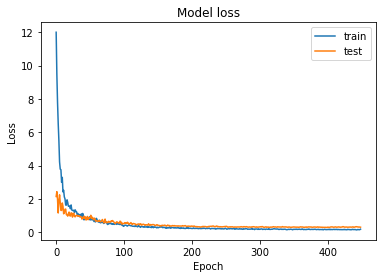

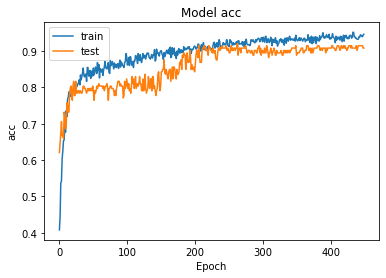

In [156]:
model = Sequential()  # 初始化
input = X_sc.shape[1]
# 隐藏层128
model.add(Dense(128, input_shape=(input,),kernel_initializer=w1_my_init,bias_initializer=b1_my_init))  #
model.add(Activation('relu'))
# Dropout层用于防止过拟合
model.add(Dropout(0.45))
# 隐藏层128
model.add(Dense(128,kernel_initializer=w2_my_init,bias_initializer=b2_my_init))
model.add(Activation('relu'))

model.add(Dense(3,kernel_initializer=w3_my_init,bias_initializer=b3_my_init))
model.add(Activation('softmax'))
# 使用高效的ADAM优化算法
model.compile(loss='categorical_crossentropy', optimizer=Adam(),metrics=['accuracy'])

early_stopping = EarlyStopping(monitor='val_loss', patience=50, verbose=2)

# 训练
history = model.fit(X_train_sc, y_train_c, epochs=500, batch_size=64,shuffle=False,verbose=2,
                   validation_data=(X_test_sc,y_test_c),callbacks=[early_stopping])

# loss曲线
plt.plot(history.history['loss'], label='train')
plt.plot(history.history['val_loss'], label='test')
plt.title('Model loss')
plt.ylabel('Loss')
plt.xlabel('Epoch')
plt.legend()
plt.show()

# acc曲线
plt.plot(history.history['accuracy'], label='train')
plt.plot(history.history['val_accuracy'], label='test')
plt.title('Model acc')
plt.ylabel('acc')
plt.xlabel('Epoch')
plt.legend()
plt.show()

## 选择样本

### 熵

In [157]:
probas_val=model.predict(X_val_sc)

In [158]:
selection=EntropySelection(probas_val,200)

In [159]:
for i in selection:
    X_train=np.vstack([X_train,X_val[i]])
    y_train_c=np.vstack([y_train_c,y_val_c[i]])

In [160]:
X_val=np.delete(X_val,selection,axis=0)
y_val_c=np.delete(y_val_c,selection,axis=0)

In [161]:
X_train.shape,y_train_c.shape,X_val.shape,y_val_c.shape

((931, 10), (931, 3), (532, 10), (532, 3))

### 随机

In [ ]:
probas_val=model.predict(X_val_sc)
selection=RandomSelection(probas_val,200)
for i in selection:
    X_train=np.vstack([X_train,X_val[i]])
    y_train_c=np.vstack([y_train_c,y_val_c[i]])
X_val=np.delete(X_val,selection,axis=0)
y_val_c=np.delete(y_val_c,selection,axis=0)
X_train.shape,y_train_c.shape,X_val.shape,y_val_c.shape

## 更新W，b

In [162]:
X_train_sc,X_val_sc,X_test_sc = normalize(X_train,X_val, X_test)

C:\Users\fairy粥粥粥\AppData\Roaming\Python\Python39\site-packages\sklearn\base.py:443: UserWarning: X has feature names, but MinMaxScaler was fitted without feature names
  warnings.warn(


In [163]:
w1,w2,w3=arithmetic_optimization_algorithm(X_train_sc,y_train_c,iterations = 50, alpha = 5, mu = 0.5, target_function = target_function, verbose = True)

Iteration =  0  loss =  [[2.81783344e+01]
 [3.05422354e-13]
 [3.07909367e+01]
 [3.44169138e-15]
 [2.37393284e+01]
 [3.52458177e+01]
 [4.02485419e+01]
 [2.48356891e-13]
 [2.73225886e-13]
 [3.37551574e+01]
 [1.54765090e-13]
 [4.85863572e-11]
 [4.44048230e+01]
 [2.49023024e-13]
 [3.12883634e+01]
 [3.28992754e+01]
 [2.74123881e+01]
 [1.90403249e-13]
 [1.27231559e-13]
 [5.56129981e+01]
 [5.45030687e-12]
 [3.11528581e-13]
 [8.99280650e-15]
 [3.75045070e+01]
 [3.69037592e+01]
 [1.47992729e-13]
 [5.04644104e-11]
 [1.88182803e-13]
 [3.87428397e+01]
 [3.31956684e-14]
 [2.53216487e+01]
 [3.09526112e+01]
 [3.28292334e+01]
 [5.32760344e+01]
 [2.55240273e-13]
 [3.07357114e+01]
 [4.09619128e+01]
 [2.77042741e+01]
 [2.42467185e+01]
 [7.18314297e-14]
 [3.94172998e+01]
 [4.28051761e+01]
 [2.86992652e-13]
 [3.71924713e-13]
 [5.24034935e+01]
 [5.55111512e-15]
 [3.01232460e+01]
 [2.85882429e-13]
 [2.08388862e-13]
 [2.61464835e+01]
 [5.20382348e+01]
 [5.07181552e+01]
 [2.75852227e+01]
 [5.07007872e+01]
 [2.

更新
Iteration =  1  loss =  [[3.87384383]
 [0.18022746]
 [2.4783355 ]
 [0.19696877]
 [3.74923753]
 [2.88947803]
 [3.44893887]
 [0.10079368]
 [0.11544549]
 [1.98519809]
 [0.06124578]
 [0.09967148]
 [2.62830388]
 [0.1648192 ]
 [1.5767245 ]
 [1.98986473]
 [0.87761214]
 [0.10573944]
 [0.14489757]
 [4.1266779 ]
 [0.14013006]
 [0.10595473]
 [0.22455396]
 [3.33448541]
 [3.43465889]
 [0.12402808]
 [0.14140589]
 [0.08722692]
 [2.76059545]
 [0.1335243 ]
 [0.86610812]
 [1.582007  ]
 [1.68746101]
 [4.40282671]
 [0.11457281]
 [1.59496388]
 [3.03522384]
 [0.9171302 ]
 [4.02261408]
 [0.15250237]
 [3.45368211]
 [2.45786447]
 [0.06435562]
 [0.14853133]
 [3.89935619]
 [0.18567192]
 [2.48012983]
 [0.06759262]
 [0.10397544]
 [0.85235288]
 [4.10091595]
 [3.99197536]
 [0.86930375]
 [3.97303529]
 [0.85059123]
 [0.0981734 ]
 [0.93586185]
 [0.14753053]
 [0.10281892]
 [0.14776067]
 [0.87315044]
 [0.12274122]
 [4.2212527 ]
 [1.88297501]
 [0.09842495]
 [1.54743892]
 [0.92774902]
 [1.8386748 ]
 [3.81132295]
 [0.111

更新
Iteration =  2  loss =  [[5.60445906]
 [3.43209614]
 [0.37142282]
 [3.72682357]
 [5.06181567]
 [0.03144276]
 [2.58393892]
 [3.79896335]
 [3.83645065]
 [0.04450243]
 [4.28426839]
 [3.41330991]
 [0.05380743]
 [3.58272078]
 [0.0488855 ]
 [0.05345845]
 [0.04770688]
 [3.72134743]
 [3.34585097]
 [3.96428597]
 [3.80358225]
 [3.80774192]
 [3.1706308 ]
 [2.46300607]
 [2.2055499 ]
 [3.5851178 ]
 [3.37082663]
 [3.78727002]
 [0.171094  ]
 [3.54025708]
 [0.04575868]
 [0.06276755]
 [0.04259553]
 [3.07766438]
 [3.6657502 ]
 [0.06935799]
 [0.14167431]
 [0.0497929 ]
 [5.38378637]
 [2.62203954]
 [2.51148329]
 [0.03034916]
 [4.09144058]
 [3.48874099]
 [3.2218694 ]
 [3.2604021 ]
 [1.46125593]
 [4.00781687]
 [3.72053568]
 [0.04964828]
 [2.72519485]
 [2.97457609]
 [0.0462415 ]
 [2.50827857]
 [0.05073636]
 [3.46420187]
 [0.0472056 ]
 [3.36109065]
 [3.59213235]
 [3.47216846]
 [0.04699577]
 [3.6987461 ]
 [4.66964781]
 [0.05004037]
 [3.96278102]
 [0.04610705]
 [0.0475536 ]
 [0.03753367]
 [1.89921298]
 [3.809

更新
Iteration =  3  loss =  [[1.04565546]
 [1.16838535]
 [1.04841819]
 [2.24588464]
 [1.11416495]
 [0.98350385]
 [0.63355121]
 [1.28968694]
 [1.2646916 ]
 [1.71462847]
 [1.100833  ]
 [0.96845251]
 [0.66531904]
 [1.14384546]
 [1.68073629]
 [1.39048739]
 [1.48785142]
 [1.13086389]
 [1.19880478]
 [0.96017539]
 [1.270016  ]
 [1.21468045]
 [1.81179752]
 [0.66926825]
 [0.84792679]
 [1.32976602]
 [1.01417876]
 [1.16649616]
 [1.64304331]
 [1.14994602]
 [1.59930818]
 [1.73626555]
 [1.84212843]
 [0.76305979]
 [1.05559397]
 [2.09295711]
 [1.43120677]
 [1.47569733]
 [1.11477046]
 [0.99098154]
 [0.65988778]
 [1.26127958]
 [1.16492405]
 [1.19369305]
 [0.81609269]
 [1.34033667]
 [1.17647461]
 [1.24625384]
 [1.19374133]
 [1.50169586]
 [0.71442427]
 [0.61509305]
 [1.54484664]
 [0.56162827]
 [1.48974466]
 [1.07764956]
 [1.51017403]
 [1.08718552]
 [1.2368463 ]
 [1.10028932]
 [1.51016953]
 [1.1482448 ]
 [1.71241551]
 [2.25016464]
 [1.08606754]
 [2.17344115]
 [1.49485177]
 [2.10097143]
 [0.95419884]
 [1.107

未更新
Iteration =  4  loss =  [[1.04565546]
 [1.16838535]
 [1.04841819]
 [2.24588464]
 [1.11416495]
 [0.98350385]
 [0.63355121]
 [1.28968694]
 [1.2646916 ]
 [1.71462847]
 [1.100833  ]
 [0.96845251]
 [0.66531904]
 [1.14384546]
 [1.68073629]
 [1.39048739]
 [1.48785142]
 [1.13086389]
 [1.19880478]
 [0.96017539]
 [1.270016  ]
 [1.21468045]
 [1.81179752]
 [0.66926825]
 [0.84792679]
 [1.32976602]
 [1.01417876]
 [1.16649616]
 [1.64304331]
 [1.14994602]
 [1.59930818]
 [1.73626555]
 [1.84212843]
 [0.76305979]
 [1.05559397]
 [2.09295711]
 [1.43120677]
 [1.47569733]
 [1.11477046]
 [0.99098154]
 [0.65988778]
 [1.26127958]
 [1.16492405]
 [1.19369305]
 [0.81609269]
 [1.34033667]
 [1.17647461]
 [1.24625384]
 [1.19374133]
 [1.50169586]
 [0.71442427]
 [0.61509305]
 [1.54484664]
 [0.56162827]
 [1.48974466]
 [1.07764956]
 [1.51017403]
 [1.08718552]
 [1.2368463 ]
 [1.10028932]
 [1.51016953]
 [1.1482448 ]
 [1.71241551]
 [2.25016464]
 [1.08606754]
 [2.17344115]
 [1.49485177]
 [2.10097143]
 [0.95419884]
 [1.10

未更新
Iteration =  5  loss =  [[1.04565546]
 [1.16838535]
 [1.04841819]
 [2.24588464]
 [1.11416495]
 [0.98350385]
 [0.63355121]
 [1.28968694]
 [1.2646916 ]
 [1.71462847]
 [1.100833  ]
 [0.96845251]
 [0.66531904]
 [1.14384546]
 [1.68073629]
 [1.39048739]
 [1.48785142]
 [1.13086389]
 [1.19880478]
 [0.96017539]
 [1.270016  ]
 [1.21468045]
 [1.81179752]
 [0.66926825]
 [0.84792679]
 [1.32976602]
 [1.01417876]
 [1.16649616]
 [1.64304331]
 [1.14994602]
 [1.59930818]
 [1.73626555]
 [1.84212843]
 [0.76305979]
 [1.05559397]
 [2.09295711]
 [1.43120677]
 [1.47569733]
 [1.11477046]
 [0.99098154]
 [0.65988778]
 [1.26127958]
 [1.16492405]
 [1.19369305]
 [0.81609269]
 [1.34033667]
 [1.17647461]
 [1.24625384]
 [1.19374133]
 [1.50169586]
 [0.71442427]
 [0.61509305]
 [1.54484664]
 [0.56162827]
 [1.48974466]
 [1.07764956]
 [1.51017403]
 [1.08718552]
 [1.2368463 ]
 [1.10028932]
 [1.51016953]
 [1.1482448 ]
 [1.71241551]
 [2.25016464]
 [1.08606754]
 [2.17344115]
 [1.49485177]
 [2.10097143]
 [0.95419884]
 [1.10

未更新
Iteration =  6  loss =  [[1.04565546]
 [1.16838535]
 [1.04841819]
 [2.24588464]
 [1.11416495]
 [0.98350385]
 [0.63355121]
 [1.28968694]
 [1.2646916 ]
 [1.71462847]
 [1.100833  ]
 [0.96845251]
 [0.66531904]
 [1.14384546]
 [1.68073629]
 [1.39048739]
 [1.48785142]
 [1.13086389]
 [1.19880478]
 [0.96017539]
 [1.270016  ]
 [1.21468045]
 [1.81179752]
 [0.66926825]
 [0.84792679]
 [1.32976602]
 [1.01417876]
 [1.16649616]
 [1.64304331]
 [1.14994602]
 [1.59930818]
 [1.73626555]
 [1.84212843]
 [0.76305979]
 [1.05559397]
 [2.09295711]
 [1.43120677]
 [1.47569733]
 [1.11477046]
 [0.99098154]
 [0.65988778]
 [1.26127958]
 [1.16492405]
 [1.19369305]
 [0.81609269]
 [1.34033667]
 [1.17647461]
 [1.24625384]
 [1.19374133]
 [1.50169586]
 [0.71442427]
 [0.61509305]
 [1.54484664]
 [0.56162827]
 [1.48974466]
 [1.07764956]
 [1.51017403]
 [1.08718552]
 [1.2368463 ]
 [1.10028932]
 [1.51016953]
 [1.1482448 ]
 [1.71241551]
 [2.25016464]
 [1.08606754]
 [2.17344115]
 [1.49485177]
 [2.10097143]
 [0.95419884]
 [1.10

未更新
Iteration =  7  loss =  [[1.04565546]
 [1.16838535]
 [1.04841819]
 [2.24588464]
 [1.11416495]
 [0.98350385]
 [0.63355121]
 [1.28968694]
 [1.2646916 ]
 [1.71462847]
 [1.100833  ]
 [0.96845251]
 [0.66531904]
 [1.14384546]
 [1.68073629]
 [1.39048739]
 [1.48785142]
 [1.13086389]
 [1.19880478]
 [0.96017539]
 [1.270016  ]
 [1.21468045]
 [1.81179752]
 [0.66926825]
 [0.84792679]
 [1.32976602]
 [1.01417876]
 [1.16649616]
 [1.64304331]
 [1.14994602]
 [1.59930818]
 [1.73626555]
 [1.84212843]
 [0.76305979]
 [1.05559397]
 [2.09295711]
 [1.43120677]
 [1.47569733]
 [1.11477046]
 [0.99098154]
 [0.65988778]
 [1.26127958]
 [1.16492405]
 [1.19369305]
 [0.81609269]
 [1.34033667]
 [1.17647461]
 [1.24625384]
 [1.19374133]
 [1.50169586]
 [0.71442427]
 [0.61509305]
 [1.54484664]
 [0.56162827]
 [1.48974466]
 [1.07764956]
 [1.51017403]
 [1.08718552]
 [1.2368463 ]
 [1.10028932]
 [1.51016953]
 [1.1482448 ]
 [1.71241551]
 [2.25016464]
 [1.08606754]
 [2.17344115]
 [1.49485177]
 [2.10097143]
 [0.95419884]
 [1.10

未更新
Iteration =  8  loss =  [[1.04565546]
 [1.16838535]
 [1.04841819]
 [2.24588464]
 [1.11416495]
 [0.98350385]
 [0.63355121]
 [1.28968694]
 [1.2646916 ]
 [1.71462847]
 [1.100833  ]
 [0.96845251]
 [0.66531904]
 [1.14384546]
 [1.68073629]
 [1.39048739]
 [1.48785142]
 [1.13086389]
 [1.19880478]
 [0.96017539]
 [1.270016  ]
 [1.21468045]
 [1.81179752]
 [0.66926825]
 [0.84792679]
 [1.32976602]
 [1.01417876]
 [1.16649616]
 [1.64304331]
 [1.14994602]
 [1.59930818]
 [1.73626555]
 [1.84212843]
 [0.76305979]
 [1.05559397]
 [2.09295711]
 [1.43120677]
 [1.47569733]
 [1.11477046]
 [0.99098154]
 [0.65988778]
 [1.26127958]
 [1.16492405]
 [1.19369305]
 [0.81609269]
 [1.34033667]
 [1.17647461]
 [1.24625384]
 [1.19374133]
 [1.50169586]
 [0.71442427]
 [0.61509305]
 [1.54484664]
 [0.56162827]
 [1.48974466]
 [1.07764956]
 [1.51017403]
 [1.08718552]
 [1.2368463 ]
 [1.10028932]
 [1.51016953]
 [1.1482448 ]
 [1.71241551]
 [2.25016464]
 [1.08606754]
 [2.17344115]
 [1.49485177]
 [2.10097143]
 [0.95419884]
 [1.10

更新
Iteration =  9  loss =  [[4.83135285]
 [0.19262549]
 [1.48613932]
 [0.49381343]
 [4.24377628]
 [0.22004484]
 [4.56578564]
 [0.29025412]
 [0.28597859]
 [0.5596763 ]
 [0.48854509]
 [1.26910989]
 [1.88209716]
 [0.20332247]
 [1.42028147]
 [0.75795222]
 [0.82949486]
 [0.28641859]
 [0.21279055]
 [3.24088662]
 [1.05285699]
 [0.29183554]
 [0.3938479 ]
 [4.18761807]
 [3.93390008]
 [0.24113762]
 [0.9083601 ]
 [0.31549213]
 [1.92154377]
 [1.38657745]
 [0.96359956]
 [1.39779776]
 [1.02966414]
 [2.96859434]
 [0.25367585]
 [1.0753708 ]
 [1.9550203 ]
 [0.59901891]
 [5.35551907]
 [1.13020584]
 [4.35992593]
 [1.54581337]
 [0.4505223 ]
 [0.2163345 ]
 [3.36517904]
 [0.91731965]
 [2.7179818 ]
 [0.41584996]
 [0.28160553]
 [0.91339007]
 [2.43760274]
 [3.62838565]
 [0.59885628]
 [3.74469592]
 [0.89557796]
 [0.28518005]
 [0.54424847]
 [0.91618841]
 [0.29350349]
 [0.21974247]
 [1.25829754]
 [0.24903595]
 [3.8705816 ]
 [0.86457265]
 [0.29975129]
 [1.21404416]
 [0.61250058]
 [0.64496537]
 [3.37287523]
 [0.273

未更新
Iteration =  10  loss =  [[4.83135285]
 [0.19262549]
 [1.48613932]
 [0.49381343]
 [4.24377628]
 [0.22004484]
 [4.56578564]
 [0.29025412]
 [0.28597859]
 [0.5596763 ]
 [0.48854509]
 [1.26910989]
 [1.88209716]
 [0.20332247]
 [1.42028147]
 [0.75795222]
 [0.82949486]
 [0.28641859]
 [0.21279055]
 [3.24088662]
 [1.05285699]
 [0.29183554]
 [0.3938479 ]
 [4.18761807]
 [3.93390008]
 [0.24113762]
 [0.9083601 ]
 [0.31549213]
 [1.92154377]
 [1.38657745]
 [0.96359956]
 [1.39779776]
 [1.02966414]
 [2.96859434]
 [0.25367585]
 [1.0753708 ]
 [1.9550203 ]
 [0.59901891]
 [5.35551907]
 [1.13020584]
 [4.35992593]
 [1.54581337]
 [0.4505223 ]
 [0.2163345 ]
 [3.36517904]
 [0.91731965]
 [2.7179818 ]
 [0.41584996]
 [0.28160553]
 [0.91339007]
 [2.43760274]
 [3.62838565]
 [0.59885628]
 [3.74469592]
 [0.89557796]
 [0.28518005]
 [0.54424847]
 [0.91618841]
 [0.29350349]
 [0.21974247]
 [1.25829754]
 [0.24903595]
 [3.8705816 ]
 [0.86457265]
 [0.29975129]
 [1.21404416]
 [0.61250058]
 [0.64496537]
 [3.37287523]
 [0.2

未更新
Iteration =  11  loss =  [[4.83135285]
 [0.19262549]
 [1.48613932]
 [0.49381343]
 [4.24377628]
 [0.22004484]
 [4.56578564]
 [0.29025412]
 [0.28597859]
 [0.5596763 ]
 [0.48854509]
 [1.26910989]
 [1.88209716]
 [0.20332247]
 [1.42028147]
 [0.75795222]
 [0.82949486]
 [0.28641859]
 [0.21279055]
 [3.24088662]
 [1.05285699]
 [0.29183554]
 [0.3938479 ]
 [4.18761807]
 [3.93390008]
 [0.24113762]
 [0.9083601 ]
 [0.31549213]
 [1.92154377]
 [1.38657745]
 [0.96359956]
 [1.39779776]
 [1.02966414]
 [2.96859434]
 [0.25367585]
 [1.0753708 ]
 [1.9550203 ]
 [0.59901891]
 [5.35551907]
 [1.13020584]
 [4.35992593]
 [1.54581337]
 [0.4505223 ]
 [0.2163345 ]
 [3.36517904]
 [0.91731965]
 [2.7179818 ]
 [0.41584996]
 [0.28160553]
 [0.91339007]
 [2.43760274]
 [3.62838565]
 [0.59885628]
 [3.74469592]
 [0.89557796]
 [0.28518005]
 [0.54424847]
 [0.91618841]
 [0.29350349]
 [0.21974247]
 [1.25829754]
 [0.24903595]
 [3.8705816 ]
 [0.86457265]
 [0.29975129]
 [1.21404416]
 [0.61250058]
 [0.64496537]
 [3.37287523]
 [0.2

未更新
Iteration =  12  loss =  [[4.83135285]
 [0.19262549]
 [1.48613932]
 [0.49381343]
 [4.24377628]
 [0.22004484]
 [4.56578564]
 [0.29025412]
 [0.28597859]
 [0.5596763 ]
 [0.48854509]
 [1.26910989]
 [1.88209716]
 [0.20332247]
 [1.42028147]
 [0.75795222]
 [0.82949486]
 [0.28641859]
 [0.21279055]
 [3.24088662]
 [1.05285699]
 [0.29183554]
 [0.3938479 ]
 [4.18761807]
 [3.93390008]
 [0.24113762]
 [0.9083601 ]
 [0.31549213]
 [1.92154377]
 [1.38657745]
 [0.96359956]
 [1.39779776]
 [1.02966414]
 [2.96859434]
 [0.25367585]
 [1.0753708 ]
 [1.9550203 ]
 [0.59901891]
 [5.35551907]
 [1.13020584]
 [4.35992593]
 [1.54581337]
 [0.4505223 ]
 [0.2163345 ]
 [3.36517904]
 [0.91731965]
 [2.7179818 ]
 [0.41584996]
 [0.28160553]
 [0.91339007]
 [2.43760274]
 [3.62838565]
 [0.59885628]
 [3.74469592]
 [0.89557796]
 [0.28518005]
 [0.54424847]
 [0.91618841]
 [0.29350349]
 [0.21974247]
 [1.25829754]
 [0.24903595]
 [3.8705816 ]
 [0.86457265]
 [0.29975129]
 [1.21404416]
 [0.61250058]
 [0.64496537]
 [3.37287523]
 [0.2

未更新
Iteration =  13  loss =  [[4.83135285]
 [0.19262549]
 [1.48613932]
 [0.49381343]
 [4.24377628]
 [0.22004484]
 [4.56578564]
 [0.29025412]
 [0.28597859]
 [0.5596763 ]
 [0.48854509]
 [1.26910989]
 [1.88209716]
 [0.20332247]
 [1.42028147]
 [0.75795222]
 [0.82949486]
 [0.28641859]
 [0.21279055]
 [3.24088662]
 [1.05285699]
 [0.29183554]
 [0.3938479 ]
 [4.18761807]
 [3.93390008]
 [0.24113762]
 [0.9083601 ]
 [0.31549213]
 [1.92154377]
 [1.38657745]
 [0.96359956]
 [1.39779776]
 [1.02966414]
 [2.96859434]
 [0.25367585]
 [1.0753708 ]
 [1.9550203 ]
 [0.59901891]
 [5.35551907]
 [1.13020584]
 [4.35992593]
 [1.54581337]
 [0.4505223 ]
 [0.2163345 ]
 [3.36517904]
 [0.91731965]
 [2.7179818 ]
 [0.41584996]
 [0.28160553]
 [0.91339007]
 [2.43760274]
 [3.62838565]
 [0.59885628]
 [3.74469592]
 [0.89557796]
 [0.28518005]
 [0.54424847]
 [0.91618841]
 [0.29350349]
 [0.21974247]
 [1.25829754]
 [0.24903595]
 [3.8705816 ]
 [0.86457265]
 [0.29975129]
 [1.21404416]
 [0.61250058]
 [0.64496537]
 [3.37287523]
 [0.2

未更新
Iteration =  14  loss =  [[4.83135285]
 [0.19262549]
 [1.48613932]
 [0.49381343]
 [4.24377628]
 [0.22004484]
 [4.56578564]
 [0.29025412]
 [0.28597859]
 [0.5596763 ]
 [0.48854509]
 [1.26910989]
 [1.88209716]
 [0.20332247]
 [1.42028147]
 [0.75795222]
 [0.82949486]
 [0.28641859]
 [0.21279055]
 [3.24088662]
 [1.05285699]
 [0.29183554]
 [0.3938479 ]
 [4.18761807]
 [3.93390008]
 [0.24113762]
 [0.9083601 ]
 [0.31549213]
 [1.92154377]
 [1.38657745]
 [0.96359956]
 [1.39779776]
 [1.02966414]
 [2.96859434]
 [0.25367585]
 [1.0753708 ]
 [1.9550203 ]
 [0.59901891]
 [5.35551907]
 [1.13020584]
 [4.35992593]
 [1.54581337]
 [0.4505223 ]
 [0.2163345 ]
 [3.36517904]
 [0.91731965]
 [2.7179818 ]
 [0.41584996]
 [0.28160553]
 [0.91339007]
 [2.43760274]
 [3.62838565]
 [0.59885628]
 [3.74469592]
 [0.89557796]
 [0.28518005]
 [0.54424847]
 [0.91618841]
 [0.29350349]
 [0.21974247]
 [1.25829754]
 [0.24903595]
 [3.8705816 ]
 [0.86457265]
 [0.29975129]
 [1.21404416]
 [0.61250058]
 [0.64496537]
 [3.37287523]
 [0.2

未更新
Iteration =  15  loss =  [[4.83135285]
 [0.19262549]
 [1.48613932]
 [0.49381343]
 [4.24377628]
 [0.22004484]
 [4.56578564]
 [0.29025412]
 [0.28597859]
 [0.5596763 ]
 [0.48854509]
 [1.26910989]
 [1.88209716]
 [0.20332247]
 [1.42028147]
 [0.75795222]
 [0.82949486]
 [0.28641859]
 [0.21279055]
 [3.24088662]
 [1.05285699]
 [0.29183554]
 [0.3938479 ]
 [4.18761807]
 [3.93390008]
 [0.24113762]
 [0.9083601 ]
 [0.31549213]
 [1.92154377]
 [1.38657745]
 [0.96359956]
 [1.39779776]
 [1.02966414]
 [2.96859434]
 [0.25367585]
 [1.0753708 ]
 [1.9550203 ]
 [0.59901891]
 [5.35551907]
 [1.13020584]
 [4.35992593]
 [1.54581337]
 [0.4505223 ]
 [0.2163345 ]
 [3.36517904]
 [0.91731965]
 [2.7179818 ]
 [0.41584996]
 [0.28160553]
 [0.91339007]
 [2.43760274]
 [3.62838565]
 [0.59885628]
 [3.74469592]
 [0.89557796]
 [0.28518005]
 [0.54424847]
 [0.91618841]
 [0.29350349]
 [0.21974247]
 [1.25829754]
 [0.24903595]
 [3.8705816 ]
 [0.86457265]
 [0.29975129]
 [1.21404416]
 [0.61250058]
 [0.64496537]
 [3.37287523]
 [0.2

未更新
Iteration =  16  loss =  [[4.83135285]
 [0.19262549]
 [1.48613932]
 [0.49381343]
 [4.24377628]
 [0.22004484]
 [4.56578564]
 [0.29025412]
 [0.28597859]
 [0.5596763 ]
 [0.48854509]
 [1.26910989]
 [1.88209716]
 [0.20332247]
 [1.42028147]
 [0.75795222]
 [0.82949486]
 [0.28641859]
 [0.21279055]
 [3.24088662]
 [1.05285699]
 [0.29183554]
 [0.3938479 ]
 [4.18761807]
 [3.93390008]
 [0.24113762]
 [0.9083601 ]
 [0.31549213]
 [1.92154377]
 [1.38657745]
 [0.96359956]
 [1.39779776]
 [1.02966414]
 [2.96859434]
 [0.25367585]
 [1.0753708 ]
 [1.9550203 ]
 [0.59901891]
 [5.35551907]
 [1.13020584]
 [4.35992593]
 [1.54581337]
 [0.4505223 ]
 [0.2163345 ]
 [3.36517904]
 [0.91731965]
 [2.7179818 ]
 [0.41584996]
 [0.28160553]
 [0.91339007]
 [2.43760274]
 [3.62838565]
 [0.59885628]
 [3.74469592]
 [0.89557796]
 [0.28518005]
 [0.54424847]
 [0.91618841]
 [0.29350349]
 [0.21974247]
 [1.25829754]
 [0.24903595]
 [3.8705816 ]
 [0.86457265]
 [0.29975129]
 [1.21404416]
 [0.61250058]
 [0.64496537]
 [3.37287523]
 [0.2

更新
Iteration =  17  loss =  [[7.15355392e+00]
 [1.28060833e-03]
 [3.59952173e+00]
 [5.16428591e-03]
 [5.81903168e+00]
 [9.17274309e+00]
 [3.78129912e-01]
 [2.69151164e-03]
 [1.99900054e-03]
 [1.06102242e+01]
 [1.50728562e-03]
 [1.77925430e-03]
 [1.68396627e+01]
 [1.13897944e-03]
 [1.19685531e+01]
 [1.06899628e+01]
 [1.16109878e+01]
 [1.31196191e-03]
 [1.10522128e-03]
 [6.43884077e+00]
 [1.77870869e-03]
 [2.15917064e-03]
 [4.92694107e-03]
 [2.77476374e-01]
 [1.23221548e-01]
 [1.94562832e-03]
 [9.32605230e-04]
 [1.71626799e-03]
 [1.54325740e+01]
 [1.70906618e-03]
 [1.10829616e+01]
 [1.07953517e+01]
 [1.11388235e+01]
 [4.85606391e+00]
 [1.67759574e-03]
 [1.19415907e+01]
 [1.41171771e+01]
 [1.12901911e+01]
 [6.05475818e+00]
 [6.18778542e-03]
 [3.56316886e-01]
 [1.15365536e+01]
 [1.61686464e-03]
 [1.80370452e-03]
 [4.60618422e+00]
 [1.97035557e-03]
 [1.25314045e+00]
 [2.14226308e-03]
 [1.93847038e-03]
 [1.07380640e+01]
 [4.80253618e+00]
 [3.73503819e+00]
 [1.18165319e+01]
 [2.83778248e+00]


未更新
Iteration =  18  loss =  [[7.15355392e+00]
 [1.28060833e-03]
 [3.59952173e+00]
 [5.16428591e-03]
 [5.81903168e+00]
 [9.17274309e+00]
 [3.78129912e-01]
 [2.69151164e-03]
 [1.99900054e-03]
 [1.06102242e+01]
 [1.50728562e-03]
 [1.77925430e-03]
 [1.68396627e+01]
 [1.13897944e-03]
 [1.19685531e+01]
 [1.06899628e+01]
 [1.16109878e+01]
 [1.31196191e-03]
 [1.10522128e-03]
 [6.43884077e+00]
 [1.77870869e-03]
 [2.15917064e-03]
 [4.92694107e-03]
 [2.77476374e-01]
 [1.23221548e-01]
 [1.94562832e-03]
 [9.32605230e-04]
 [1.71626799e-03]
 [1.54325740e+01]
 [1.70906618e-03]
 [1.10829616e+01]
 [1.07953517e+01]
 [1.11388235e+01]
 [4.85606391e+00]
 [1.67759574e-03]
 [1.19415907e+01]
 [1.41171771e+01]
 [1.12901911e+01]
 [6.05475818e+00]
 [6.18778542e-03]
 [3.56316886e-01]
 [1.15365536e+01]
 [1.61686464e-03]
 [1.80370452e-03]
 [4.60618422e+00]
 [1.97035557e-03]
 [1.25314045e+00]
 [2.14226308e-03]
 [1.93847038e-03]
 [1.07380640e+01]
 [4.80253618e+00]
 [3.73503819e+00]
 [1.18165319e+01]
 [2.83778248e+00]

更新
Iteration =  19  loss =  [[1.19664579e+00]
 [6.41897447e-01]
 [3.60166445e+00]
 [8.98707502e-01]
 [1.07654547e+00]
 [1.33825387e+00]
 [1.49443498e-01]
 [6.09748195e-01]
 [7.07700545e-01]
 [2.67497020e+00]
 [8.42496853e-01]
 [2.75766505e+00]
 [7.75367936e+00]
 [6.27241420e-01]
 [2.48454828e+00]
 [3.55732573e+00]
 [3.80189855e-01]
 [6.51831147e-01]
 [6.83328714e-01]
 [8.64587523e+00]
 [5.37632593e+00]
 [5.98794721e-01]
 [1.54250516e+00]
 [7.54851241e-02]
 [7.03735045e-02]
 [7.86751730e-01]
 [4.15092618e+00]
 [5.75681767e-01]
 [7.77698757e+00]
 [2.94880424e+00]
 [1.58409244e-01]
 [4.82932090e+00]
 [3.52695567e+00]
 [5.45296685e+00]
 [5.58120208e-01]
 [2.02863405e+00]
 [8.32363682e+00]
 [4.64589107e-01]
 [2.02241351e-01]
 [1.99075606e+00]
 [2.84555017e-01]
 [1.03869914e+00]
 [7.59001720e-01]
 [5.35792515e-01]
 [3.77042630e+00]
 [1.78703978e+00]
 [6.07492066e-05]
 [7.29875391e-01]
 [5.98605742e-01]
 [2.77344308e-01]
 [3.14227239e+00]
 [3.97717493e+00]
 [3.66213583e-01]
 [3.70832490e+00]


未更新
Iteration =  20  loss =  [[1.19664579e+00]
 [6.41897447e-01]
 [3.60166445e+00]
 [8.98707502e-01]
 [1.07654547e+00]
 [1.33825387e+00]
 [1.49443498e-01]
 [6.09748195e-01]
 [7.07700545e-01]
 [2.67497020e+00]
 [8.42496853e-01]
 [2.75766505e+00]
 [7.75367936e+00]
 [6.27241420e-01]
 [2.48454828e+00]
 [3.55732573e+00]
 [3.80189855e-01]
 [6.51831147e-01]
 [6.83328714e-01]
 [8.64587523e+00]
 [5.37632593e+00]
 [5.98794721e-01]
 [1.54250516e+00]
 [7.54851241e-02]
 [7.03735045e-02]
 [7.86751730e-01]
 [4.15092618e+00]
 [5.75681767e-01]
 [7.77698757e+00]
 [2.94880424e+00]
 [1.58409244e-01]
 [4.82932090e+00]
 [3.52695567e+00]
 [5.45296685e+00]
 [5.58120208e-01]
 [2.02863405e+00]
 [8.32363682e+00]
 [4.64589107e-01]
 [2.02241351e-01]
 [1.99075606e+00]
 [2.84555017e-01]
 [1.03869914e+00]
 [7.59001720e-01]
 [5.35792515e-01]
 [3.77042630e+00]
 [1.78703978e+00]
 [6.07492066e-05]
 [7.29875391e-01]
 [5.98605742e-01]
 [2.77344308e-01]
 [3.14227239e+00]
 [3.97717493e+00]
 [3.66213583e-01]
 [3.70832490e+00]

未更新
Iteration =  21  loss =  [[1.19664579e+00]
 [6.41897447e-01]
 [3.60166445e+00]
 [8.98707502e-01]
 [1.07654547e+00]
 [1.33825387e+00]
 [1.49443498e-01]
 [6.09748195e-01]
 [7.07700545e-01]
 [2.67497020e+00]
 [8.42496853e-01]
 [2.75766505e+00]
 [7.75367936e+00]
 [6.27241420e-01]
 [2.48454828e+00]
 [3.55732573e+00]
 [3.80189855e-01]
 [6.51831147e-01]
 [6.83328714e-01]
 [8.64587523e+00]
 [5.37632593e+00]
 [5.98794721e-01]
 [1.54250516e+00]
 [7.54851241e-02]
 [7.03735045e-02]
 [7.86751730e-01]
 [4.15092618e+00]
 [5.75681767e-01]
 [7.77698757e+00]
 [2.94880424e+00]
 [1.58409244e-01]
 [4.82932090e+00]
 [3.52695567e+00]
 [5.45296685e+00]
 [5.58120208e-01]
 [2.02863405e+00]
 [8.32363682e+00]
 [4.64589107e-01]
 [2.02241351e-01]
 [1.99075606e+00]
 [2.84555017e-01]
 [1.03869914e+00]
 [7.59001720e-01]
 [5.35792515e-01]
 [3.77042630e+00]
 [1.78703978e+00]
 [6.07492066e-05]
 [7.29875391e-01]
 [5.98605742e-01]
 [2.77344308e-01]
 [3.14227239e+00]
 [3.97717493e+00]
 [3.66213583e-01]
 [3.70832490e+00]

未更新
Iteration =  22  loss =  [[1.19664579e+00]
 [6.41897447e-01]
 [3.60166445e+00]
 [8.98707502e-01]
 [1.07654547e+00]
 [1.33825387e+00]
 [1.49443498e-01]
 [6.09748195e-01]
 [7.07700545e-01]
 [2.67497020e+00]
 [8.42496853e-01]
 [2.75766505e+00]
 [7.75367936e+00]
 [6.27241420e-01]
 [2.48454828e+00]
 [3.55732573e+00]
 [3.80189855e-01]
 [6.51831147e-01]
 [6.83328714e-01]
 [8.64587523e+00]
 [5.37632593e+00]
 [5.98794721e-01]
 [1.54250516e+00]
 [7.54851241e-02]
 [7.03735045e-02]
 [7.86751730e-01]
 [4.15092618e+00]
 [5.75681767e-01]
 [7.77698757e+00]
 [2.94880424e+00]
 [1.58409244e-01]
 [4.82932090e+00]
 [3.52695567e+00]
 [5.45296685e+00]
 [5.58120208e-01]
 [2.02863405e+00]
 [8.32363682e+00]
 [4.64589107e-01]
 [2.02241351e-01]
 [1.99075606e+00]
 [2.84555017e-01]
 [1.03869914e+00]
 [7.59001720e-01]
 [5.35792515e-01]
 [3.77042630e+00]
 [1.78703978e+00]
 [6.07492066e-05]
 [7.29875391e-01]
 [5.98605742e-01]
 [2.77344308e-01]
 [3.14227239e+00]
 [3.97717493e+00]
 [3.66213583e-01]
 [3.70832490e+00]

未更新
Iteration =  23  loss =  [[1.19664579e+00]
 [6.41897447e-01]
 [3.60166445e+00]
 [8.98707502e-01]
 [1.07654547e+00]
 [1.33825387e+00]
 [1.49443498e-01]
 [6.09748195e-01]
 [7.07700545e-01]
 [2.67497020e+00]
 [8.42496853e-01]
 [2.75766505e+00]
 [7.75367936e+00]
 [6.27241420e-01]
 [2.48454828e+00]
 [3.55732573e+00]
 [3.80189855e-01]
 [6.51831147e-01]
 [6.83328714e-01]
 [8.64587523e+00]
 [5.37632593e+00]
 [5.98794721e-01]
 [1.54250516e+00]
 [7.54851241e-02]
 [7.03735045e-02]
 [7.86751730e-01]
 [4.15092618e+00]
 [5.75681767e-01]
 [7.77698757e+00]
 [2.94880424e+00]
 [1.58409244e-01]
 [4.82932090e+00]
 [3.52695567e+00]
 [5.45296685e+00]
 [5.58120208e-01]
 [2.02863405e+00]
 [8.32363682e+00]
 [4.64589107e-01]
 [2.02241351e-01]
 [1.99075606e+00]
 [2.84555017e-01]
 [1.03869914e+00]
 [7.59001720e-01]
 [5.35792515e-01]
 [3.77042630e+00]
 [1.78703978e+00]
 [6.07492066e-05]
 [7.29875391e-01]
 [5.98605742e-01]
 [2.77344308e-01]
 [3.14227239e+00]
 [3.97717493e+00]
 [3.66213583e-01]
 [3.70832490e+00]

未更新
Iteration =  24  loss =  [[1.19664579e+00]
 [6.41897447e-01]
 [3.60166445e+00]
 [8.98707502e-01]
 [1.07654547e+00]
 [1.33825387e+00]
 [1.49443498e-01]
 [6.09748195e-01]
 [7.07700545e-01]
 [2.67497020e+00]
 [8.42496853e-01]
 [2.75766505e+00]
 [7.75367936e+00]
 [6.27241420e-01]
 [2.48454828e+00]
 [3.55732573e+00]
 [3.80189855e-01]
 [6.51831147e-01]
 [6.83328714e-01]
 [8.64587523e+00]
 [5.37632593e+00]
 [5.98794721e-01]
 [1.54250516e+00]
 [7.54851241e-02]
 [7.03735045e-02]
 [7.86751730e-01]
 [4.15092618e+00]
 [5.75681767e-01]
 [7.77698757e+00]
 [2.94880424e+00]
 [1.58409244e-01]
 [4.82932090e+00]
 [3.52695567e+00]
 [5.45296685e+00]
 [5.58120208e-01]
 [2.02863405e+00]
 [8.32363682e+00]
 [4.64589107e-01]
 [2.02241351e-01]
 [1.99075606e+00]
 [2.84555017e-01]
 [1.03869914e+00]
 [7.59001720e-01]
 [5.35792515e-01]
 [3.77042630e+00]
 [1.78703978e+00]
 [6.07492066e-05]
 [7.29875391e-01]
 [5.98605742e-01]
 [2.77344308e-01]
 [3.14227239e+00]
 [3.97717493e+00]
 [3.66213583e-01]
 [3.70832490e+00]

未更新
Iteration =  25  loss =  [[1.19664579e+00]
 [6.41897447e-01]
 [3.60166445e+00]
 [8.98707502e-01]
 [1.07654547e+00]
 [1.33825387e+00]
 [1.49443498e-01]
 [6.09748195e-01]
 [7.07700545e-01]
 [2.67497020e+00]
 [8.42496853e-01]
 [2.75766505e+00]
 [7.75367936e+00]
 [6.27241420e-01]
 [2.48454828e+00]
 [3.55732573e+00]
 [3.80189855e-01]
 [6.51831147e-01]
 [6.83328714e-01]
 [8.64587523e+00]
 [5.37632593e+00]
 [5.98794721e-01]
 [1.54250516e+00]
 [7.54851241e-02]
 [7.03735045e-02]
 [7.86751730e-01]
 [4.15092618e+00]
 [5.75681767e-01]
 [7.77698757e+00]
 [2.94880424e+00]
 [1.58409244e-01]
 [4.82932090e+00]
 [3.52695567e+00]
 [5.45296685e+00]
 [5.58120208e-01]
 [2.02863405e+00]
 [8.32363682e+00]
 [4.64589107e-01]
 [2.02241351e-01]
 [1.99075606e+00]
 [2.84555017e-01]
 [1.03869914e+00]
 [7.59001720e-01]
 [5.35792515e-01]
 [3.77042630e+00]
 [1.78703978e+00]
 [6.07492066e-05]
 [7.29875391e-01]
 [5.98605742e-01]
 [2.77344308e-01]
 [3.14227239e+00]
 [3.97717493e+00]
 [3.66213583e-01]
 [3.70832490e+00]

未更新
Iteration =  26  loss =  [[1.19664579e+00]
 [6.41897447e-01]
 [3.60166445e+00]
 [8.98707502e-01]
 [1.07654547e+00]
 [1.33825387e+00]
 [1.49443498e-01]
 [6.09748195e-01]
 [7.07700545e-01]
 [2.67497020e+00]
 [8.42496853e-01]
 [2.75766505e+00]
 [7.75367936e+00]
 [6.27241420e-01]
 [2.48454828e+00]
 [3.55732573e+00]
 [3.80189855e-01]
 [6.51831147e-01]
 [6.83328714e-01]
 [8.64587523e+00]
 [5.37632593e+00]
 [5.98794721e-01]
 [1.54250516e+00]
 [7.54851241e-02]
 [7.03735045e-02]
 [7.86751730e-01]
 [4.15092618e+00]
 [5.75681767e-01]
 [7.77698757e+00]
 [2.94880424e+00]
 [1.58409244e-01]
 [4.82932090e+00]
 [3.52695567e+00]
 [5.45296685e+00]
 [5.58120208e-01]
 [2.02863405e+00]
 [8.32363682e+00]
 [4.64589107e-01]
 [2.02241351e-01]
 [1.99075606e+00]
 [2.84555017e-01]
 [1.03869914e+00]
 [7.59001720e-01]
 [5.35792515e-01]
 [3.77042630e+00]
 [1.78703978e+00]
 [6.07492066e-05]
 [7.29875391e-01]
 [5.98605742e-01]
 [2.77344308e-01]
 [3.14227239e+00]
 [3.97717493e+00]
 [3.66213583e-01]
 [3.70832490e+00]

未更新
Iteration =  27  loss =  [[1.19664579e+00]
 [6.41897447e-01]
 [3.60166445e+00]
 [8.98707502e-01]
 [1.07654547e+00]
 [1.33825387e+00]
 [1.49443498e-01]
 [6.09748195e-01]
 [7.07700545e-01]
 [2.67497020e+00]
 [8.42496853e-01]
 [2.75766505e+00]
 [7.75367936e+00]
 [6.27241420e-01]
 [2.48454828e+00]
 [3.55732573e+00]
 [3.80189855e-01]
 [6.51831147e-01]
 [6.83328714e-01]
 [8.64587523e+00]
 [5.37632593e+00]
 [5.98794721e-01]
 [1.54250516e+00]
 [7.54851241e-02]
 [7.03735045e-02]
 [7.86751730e-01]
 [4.15092618e+00]
 [5.75681767e-01]
 [7.77698757e+00]
 [2.94880424e+00]
 [1.58409244e-01]
 [4.82932090e+00]
 [3.52695567e+00]
 [5.45296685e+00]
 [5.58120208e-01]
 [2.02863405e+00]
 [8.32363682e+00]
 [4.64589107e-01]
 [2.02241351e-01]
 [1.99075606e+00]
 [2.84555017e-01]
 [1.03869914e+00]
 [7.59001720e-01]
 [5.35792515e-01]
 [3.77042630e+00]
 [1.78703978e+00]
 [6.07492066e-05]
 [7.29875391e-01]
 [5.98605742e-01]
 [2.77344308e-01]
 [3.14227239e+00]
 [3.97717493e+00]
 [3.66213583e-01]
 [3.70832490e+00]

未更新
Iteration =  28  loss =  [[1.19664579e+00]
 [6.41897447e-01]
 [3.60166445e+00]
 [8.98707502e-01]
 [1.07654547e+00]
 [1.33825387e+00]
 [1.49443498e-01]
 [6.09748195e-01]
 [7.07700545e-01]
 [2.67497020e+00]
 [8.42496853e-01]
 [2.75766505e+00]
 [7.75367936e+00]
 [6.27241420e-01]
 [2.48454828e+00]
 [3.55732573e+00]
 [3.80189855e-01]
 [6.51831147e-01]
 [6.83328714e-01]
 [8.64587523e+00]
 [5.37632593e+00]
 [5.98794721e-01]
 [1.54250516e+00]
 [7.54851241e-02]
 [7.03735045e-02]
 [7.86751730e-01]
 [4.15092618e+00]
 [5.75681767e-01]
 [7.77698757e+00]
 [2.94880424e+00]
 [1.58409244e-01]
 [4.82932090e+00]
 [3.52695567e+00]
 [5.45296685e+00]
 [5.58120208e-01]
 [2.02863405e+00]
 [8.32363682e+00]
 [4.64589107e-01]
 [2.02241351e-01]
 [1.99075606e+00]
 [2.84555017e-01]
 [1.03869914e+00]
 [7.59001720e-01]
 [5.35792515e-01]
 [3.77042630e+00]
 [1.78703978e+00]
 [6.07492066e-05]
 [7.29875391e-01]
 [5.98605742e-01]
 [2.77344308e-01]
 [3.14227239e+00]
 [3.97717493e+00]
 [3.66213583e-01]
 [3.70832490e+00]

未更新
Iteration =  29  loss =  [[1.19664579e+00]
 [6.41897447e-01]
 [3.60166445e+00]
 [8.98707502e-01]
 [1.07654547e+00]
 [1.33825387e+00]
 [1.49443498e-01]
 [6.09748195e-01]
 [7.07700545e-01]
 [2.67497020e+00]
 [8.42496853e-01]
 [2.75766505e+00]
 [7.75367936e+00]
 [6.27241420e-01]
 [2.48454828e+00]
 [3.55732573e+00]
 [3.80189855e-01]
 [6.51831147e-01]
 [6.83328714e-01]
 [8.64587523e+00]
 [5.37632593e+00]
 [5.98794721e-01]
 [1.54250516e+00]
 [7.54851241e-02]
 [7.03735045e-02]
 [7.86751730e-01]
 [4.15092618e+00]
 [5.75681767e-01]
 [7.77698757e+00]
 [2.94880424e+00]
 [1.58409244e-01]
 [4.82932090e+00]
 [3.52695567e+00]
 [5.45296685e+00]
 [5.58120208e-01]
 [2.02863405e+00]
 [8.32363682e+00]
 [4.64589107e-01]
 [2.02241351e-01]
 [1.99075606e+00]
 [2.84555017e-01]
 [1.03869914e+00]
 [7.59001720e-01]
 [5.35792515e-01]
 [3.77042630e+00]
 [1.78703978e+00]
 [6.07492066e-05]
 [7.29875391e-01]
 [5.98605742e-01]
 [2.77344308e-01]
 [3.14227239e+00]
 [3.97717493e+00]
 [3.66213583e-01]
 [3.70832490e+00]

未更新
Iteration =  30  loss =  [[1.19664579e+00]
 [6.41897447e-01]
 [3.60166445e+00]
 [8.98707502e-01]
 [1.07654547e+00]
 [1.33825387e+00]
 [1.49443498e-01]
 [6.09748195e-01]
 [7.07700545e-01]
 [2.67497020e+00]
 [8.42496853e-01]
 [2.75766505e+00]
 [7.75367936e+00]
 [6.27241420e-01]
 [2.48454828e+00]
 [3.55732573e+00]
 [3.80189855e-01]
 [6.51831147e-01]
 [6.83328714e-01]
 [8.64587523e+00]
 [5.37632593e+00]
 [5.98794721e-01]
 [1.54250516e+00]
 [7.54851241e-02]
 [7.03735045e-02]
 [7.86751730e-01]
 [4.15092618e+00]
 [5.75681767e-01]
 [7.77698757e+00]
 [2.94880424e+00]
 [1.58409244e-01]
 [4.82932090e+00]
 [3.52695567e+00]
 [5.45296685e+00]
 [5.58120208e-01]
 [2.02863405e+00]
 [8.32363682e+00]
 [4.64589107e-01]
 [2.02241351e-01]
 [1.99075606e+00]
 [2.84555017e-01]
 [1.03869914e+00]
 [7.59001720e-01]
 [5.35792515e-01]
 [3.77042630e+00]
 [1.78703978e+00]
 [6.07492066e-05]
 [7.29875391e-01]
 [5.98605742e-01]
 [2.77344308e-01]
 [3.14227239e+00]
 [3.97717493e+00]
 [3.66213583e-01]
 [3.70832490e+00]

未更新
Iteration =  31  loss =  [[1.19664579e+00]
 [6.41897447e-01]
 [3.60166445e+00]
 [8.98707502e-01]
 [1.07654547e+00]
 [1.33825387e+00]
 [1.49443498e-01]
 [6.09748195e-01]
 [7.07700545e-01]
 [2.67497020e+00]
 [8.42496853e-01]
 [2.75766505e+00]
 [7.75367936e+00]
 [6.27241420e-01]
 [2.48454828e+00]
 [3.55732573e+00]
 [3.80189855e-01]
 [6.51831147e-01]
 [6.83328714e-01]
 [8.64587523e+00]
 [5.37632593e+00]
 [5.98794721e-01]
 [1.54250516e+00]
 [7.54851241e-02]
 [7.03735045e-02]
 [7.86751730e-01]
 [4.15092618e+00]
 [5.75681767e-01]
 [7.77698757e+00]
 [2.94880424e+00]
 [1.58409244e-01]
 [4.82932090e+00]
 [3.52695567e+00]
 [5.45296685e+00]
 [5.58120208e-01]
 [2.02863405e+00]
 [8.32363682e+00]
 [4.64589107e-01]
 [2.02241351e-01]
 [1.99075606e+00]
 [2.84555017e-01]
 [1.03869914e+00]
 [7.59001720e-01]
 [5.35792515e-01]
 [3.77042630e+00]
 [1.78703978e+00]
 [6.07492066e-05]
 [7.29875391e-01]
 [5.98605742e-01]
 [2.77344308e-01]
 [3.14227239e+00]
 [3.97717493e+00]
 [3.66213583e-01]
 [3.70832490e+00]

未更新
Iteration =  32  loss =  [[1.19664579e+00]
 [6.41897447e-01]
 [3.60166445e+00]
 [8.98707502e-01]
 [1.07654547e+00]
 [1.33825387e+00]
 [1.49443498e-01]
 [6.09748195e-01]
 [7.07700545e-01]
 [2.67497020e+00]
 [8.42496853e-01]
 [2.75766505e+00]
 [7.75367936e+00]
 [6.27241420e-01]
 [2.48454828e+00]
 [3.55732573e+00]
 [3.80189855e-01]
 [6.51831147e-01]
 [6.83328714e-01]
 [8.64587523e+00]
 [5.37632593e+00]
 [5.98794721e-01]
 [1.54250516e+00]
 [7.54851241e-02]
 [7.03735045e-02]
 [7.86751730e-01]
 [4.15092618e+00]
 [5.75681767e-01]
 [7.77698757e+00]
 [2.94880424e+00]
 [1.58409244e-01]
 [4.82932090e+00]
 [3.52695567e+00]
 [5.45296685e+00]
 [5.58120208e-01]
 [2.02863405e+00]
 [8.32363682e+00]
 [4.64589107e-01]
 [2.02241351e-01]
 [1.99075606e+00]
 [2.84555017e-01]
 [1.03869914e+00]
 [7.59001720e-01]
 [5.35792515e-01]
 [3.77042630e+00]
 [1.78703978e+00]
 [6.07492066e-05]
 [7.29875391e-01]
 [5.98605742e-01]
 [2.77344308e-01]
 [3.14227239e+00]
 [3.97717493e+00]
 [3.66213583e-01]
 [3.70832490e+00]

未更新
Iteration =  33  loss =  [[1.19664579e+00]
 [6.41897447e-01]
 [3.60166445e+00]
 [8.98707502e-01]
 [1.07654547e+00]
 [1.33825387e+00]
 [1.49443498e-01]
 [6.09748195e-01]
 [7.07700545e-01]
 [2.67497020e+00]
 [8.42496853e-01]
 [2.75766505e+00]
 [7.75367936e+00]
 [6.27241420e-01]
 [2.48454828e+00]
 [3.55732573e+00]
 [3.80189855e-01]
 [6.51831147e-01]
 [6.83328714e-01]
 [8.64587523e+00]
 [5.37632593e+00]
 [5.98794721e-01]
 [1.54250516e+00]
 [7.54851241e-02]
 [7.03735045e-02]
 [7.86751730e-01]
 [4.15092618e+00]
 [5.75681767e-01]
 [7.77698757e+00]
 [2.94880424e+00]
 [1.58409244e-01]
 [4.82932090e+00]
 [3.52695567e+00]
 [5.45296685e+00]
 [5.58120208e-01]
 [2.02863405e+00]
 [8.32363682e+00]
 [4.64589107e-01]
 [2.02241351e-01]
 [1.99075606e+00]
 [2.84555017e-01]
 [1.03869914e+00]
 [7.59001720e-01]
 [5.35792515e-01]
 [3.77042630e+00]
 [1.78703978e+00]
 [6.07492066e-05]
 [7.29875391e-01]
 [5.98605742e-01]
 [2.77344308e-01]
 [3.14227239e+00]
 [3.97717493e+00]
 [3.66213583e-01]
 [3.70832490e+00]

未更新
Iteration =  34  loss =  [[1.19664579e+00]
 [6.41897447e-01]
 [3.60166445e+00]
 [8.98707502e-01]
 [1.07654547e+00]
 [1.33825387e+00]
 [1.49443498e-01]
 [6.09748195e-01]
 [7.07700545e-01]
 [2.67497020e+00]
 [8.42496853e-01]
 [2.75766505e+00]
 [7.75367936e+00]
 [6.27241420e-01]
 [2.48454828e+00]
 [3.55732573e+00]
 [3.80189855e-01]
 [6.51831147e-01]
 [6.83328714e-01]
 [8.64587523e+00]
 [5.37632593e+00]
 [5.98794721e-01]
 [1.54250516e+00]
 [7.54851241e-02]
 [7.03735045e-02]
 [7.86751730e-01]
 [4.15092618e+00]
 [5.75681767e-01]
 [7.77698757e+00]
 [2.94880424e+00]
 [1.58409244e-01]
 [4.82932090e+00]
 [3.52695567e+00]
 [5.45296685e+00]
 [5.58120208e-01]
 [2.02863405e+00]
 [8.32363682e+00]
 [4.64589107e-01]
 [2.02241351e-01]
 [1.99075606e+00]
 [2.84555017e-01]
 [1.03869914e+00]
 [7.59001720e-01]
 [5.35792515e-01]
 [3.77042630e+00]
 [1.78703978e+00]
 [6.07492066e-05]
 [7.29875391e-01]
 [5.98605742e-01]
 [2.77344308e-01]
 [3.14227239e+00]
 [3.97717493e+00]
 [3.66213583e-01]
 [3.70832490e+00]

未更新
Iteration =  35  loss =  [[1.19664579e+00]
 [6.41897447e-01]
 [3.60166445e+00]
 [8.98707502e-01]
 [1.07654547e+00]
 [1.33825387e+00]
 [1.49443498e-01]
 [6.09748195e-01]
 [7.07700545e-01]
 [2.67497020e+00]
 [8.42496853e-01]
 [2.75766505e+00]
 [7.75367936e+00]
 [6.27241420e-01]
 [2.48454828e+00]
 [3.55732573e+00]
 [3.80189855e-01]
 [6.51831147e-01]
 [6.83328714e-01]
 [8.64587523e+00]
 [5.37632593e+00]
 [5.98794721e-01]
 [1.54250516e+00]
 [7.54851241e-02]
 [7.03735045e-02]
 [7.86751730e-01]
 [4.15092618e+00]
 [5.75681767e-01]
 [7.77698757e+00]
 [2.94880424e+00]
 [1.58409244e-01]
 [4.82932090e+00]
 [3.52695567e+00]
 [5.45296685e+00]
 [5.58120208e-01]
 [2.02863405e+00]
 [8.32363682e+00]
 [4.64589107e-01]
 [2.02241351e-01]
 [1.99075606e+00]
 [2.84555017e-01]
 [1.03869914e+00]
 [7.59001720e-01]
 [5.35792515e-01]
 [3.77042630e+00]
 [1.78703978e+00]
 [6.07492066e-05]
 [7.29875391e-01]
 [5.98605742e-01]
 [2.77344308e-01]
 [3.14227239e+00]
 [3.97717493e+00]
 [3.66213583e-01]
 [3.70832490e+00]

未更新
Iteration =  36  loss =  [[1.19664579e+00]
 [6.41897447e-01]
 [3.60166445e+00]
 [8.98707502e-01]
 [1.07654547e+00]
 [1.33825387e+00]
 [1.49443498e-01]
 [6.09748195e-01]
 [7.07700545e-01]
 [2.67497020e+00]
 [8.42496853e-01]
 [2.75766505e+00]
 [7.75367936e+00]
 [6.27241420e-01]
 [2.48454828e+00]
 [3.55732573e+00]
 [3.80189855e-01]
 [6.51831147e-01]
 [6.83328714e-01]
 [8.64587523e+00]
 [5.37632593e+00]
 [5.98794721e-01]
 [1.54250516e+00]
 [7.54851241e-02]
 [7.03735045e-02]
 [7.86751730e-01]
 [4.15092618e+00]
 [5.75681767e-01]
 [7.77698757e+00]
 [2.94880424e+00]
 [1.58409244e-01]
 [4.82932090e+00]
 [3.52695567e+00]
 [5.45296685e+00]
 [5.58120208e-01]
 [2.02863405e+00]
 [8.32363682e+00]
 [4.64589107e-01]
 [2.02241351e-01]
 [1.99075606e+00]
 [2.84555017e-01]
 [1.03869914e+00]
 [7.59001720e-01]
 [5.35792515e-01]
 [3.77042630e+00]
 [1.78703978e+00]
 [6.07492066e-05]
 [7.29875391e-01]
 [5.98605742e-01]
 [2.77344308e-01]
 [3.14227239e+00]
 [3.97717493e+00]
 [3.66213583e-01]
 [3.70832490e+00]

未更新
Iteration =  37  loss =  [[1.19664579e+00]
 [6.41897447e-01]
 [3.60166445e+00]
 [8.98707502e-01]
 [1.07654547e+00]
 [1.33825387e+00]
 [1.49443498e-01]
 [6.09748195e-01]
 [7.07700545e-01]
 [2.67497020e+00]
 [8.42496853e-01]
 [2.75766505e+00]
 [7.75367936e+00]
 [6.27241420e-01]
 [2.48454828e+00]
 [3.55732573e+00]
 [3.80189855e-01]
 [6.51831147e-01]
 [6.83328714e-01]
 [8.64587523e+00]
 [5.37632593e+00]
 [5.98794721e-01]
 [1.54250516e+00]
 [7.54851241e-02]
 [7.03735045e-02]
 [7.86751730e-01]
 [4.15092618e+00]
 [5.75681767e-01]
 [7.77698757e+00]
 [2.94880424e+00]
 [1.58409244e-01]
 [4.82932090e+00]
 [3.52695567e+00]
 [5.45296685e+00]
 [5.58120208e-01]
 [2.02863405e+00]
 [8.32363682e+00]
 [4.64589107e-01]
 [2.02241351e-01]
 [1.99075606e+00]
 [2.84555017e-01]
 [1.03869914e+00]
 [7.59001720e-01]
 [5.35792515e-01]
 [3.77042630e+00]
 [1.78703978e+00]
 [6.07492066e-05]
 [7.29875391e-01]
 [5.98605742e-01]
 [2.77344308e-01]
 [3.14227239e+00]
 [3.97717493e+00]
 [3.66213583e-01]
 [3.70832490e+00]

未更新
Iteration =  38  loss =  [[1.19664579e+00]
 [6.41897447e-01]
 [3.60166445e+00]
 [8.98707502e-01]
 [1.07654547e+00]
 [1.33825387e+00]
 [1.49443498e-01]
 [6.09748195e-01]
 [7.07700545e-01]
 [2.67497020e+00]
 [8.42496853e-01]
 [2.75766505e+00]
 [7.75367936e+00]
 [6.27241420e-01]
 [2.48454828e+00]
 [3.55732573e+00]
 [3.80189855e-01]
 [6.51831147e-01]
 [6.83328714e-01]
 [8.64587523e+00]
 [5.37632593e+00]
 [5.98794721e-01]
 [1.54250516e+00]
 [7.54851241e-02]
 [7.03735045e-02]
 [7.86751730e-01]
 [4.15092618e+00]
 [5.75681767e-01]
 [7.77698757e+00]
 [2.94880424e+00]
 [1.58409244e-01]
 [4.82932090e+00]
 [3.52695567e+00]
 [5.45296685e+00]
 [5.58120208e-01]
 [2.02863405e+00]
 [8.32363682e+00]
 [4.64589107e-01]
 [2.02241351e-01]
 [1.99075606e+00]
 [2.84555017e-01]
 [1.03869914e+00]
 [7.59001720e-01]
 [5.35792515e-01]
 [3.77042630e+00]
 [1.78703978e+00]
 [6.07492066e-05]
 [7.29875391e-01]
 [5.98605742e-01]
 [2.77344308e-01]
 [3.14227239e+00]
 [3.97717493e+00]
 [3.66213583e-01]
 [3.70832490e+00]

未更新
Iteration =  39  loss =  [[1.19664579e+00]
 [6.41897447e-01]
 [3.60166445e+00]
 [8.98707502e-01]
 [1.07654547e+00]
 [1.33825387e+00]
 [1.49443498e-01]
 [6.09748195e-01]
 [7.07700545e-01]
 [2.67497020e+00]
 [8.42496853e-01]
 [2.75766505e+00]
 [7.75367936e+00]
 [6.27241420e-01]
 [2.48454828e+00]
 [3.55732573e+00]
 [3.80189855e-01]
 [6.51831147e-01]
 [6.83328714e-01]
 [8.64587523e+00]
 [5.37632593e+00]
 [5.98794721e-01]
 [1.54250516e+00]
 [7.54851241e-02]
 [7.03735045e-02]
 [7.86751730e-01]
 [4.15092618e+00]
 [5.75681767e-01]
 [7.77698757e+00]
 [2.94880424e+00]
 [1.58409244e-01]
 [4.82932090e+00]
 [3.52695567e+00]
 [5.45296685e+00]
 [5.58120208e-01]
 [2.02863405e+00]
 [8.32363682e+00]
 [4.64589107e-01]
 [2.02241351e-01]
 [1.99075606e+00]
 [2.84555017e-01]
 [1.03869914e+00]
 [7.59001720e-01]
 [5.35792515e-01]
 [3.77042630e+00]
 [1.78703978e+00]
 [6.07492066e-05]
 [7.29875391e-01]
 [5.98605742e-01]
 [2.77344308e-01]
 [3.14227239e+00]
 [3.97717493e+00]
 [3.66213583e-01]
 [3.70832490e+00]

未更新
Iteration =  40  loss =  [[1.19664579e+00]
 [6.41897447e-01]
 [3.60166445e+00]
 [8.98707502e-01]
 [1.07654547e+00]
 [1.33825387e+00]
 [1.49443498e-01]
 [6.09748195e-01]
 [7.07700545e-01]
 [2.67497020e+00]
 [8.42496853e-01]
 [2.75766505e+00]
 [7.75367936e+00]
 [6.27241420e-01]
 [2.48454828e+00]
 [3.55732573e+00]
 [3.80189855e-01]
 [6.51831147e-01]
 [6.83328714e-01]
 [8.64587523e+00]
 [5.37632593e+00]
 [5.98794721e-01]
 [1.54250516e+00]
 [7.54851241e-02]
 [7.03735045e-02]
 [7.86751730e-01]
 [4.15092618e+00]
 [5.75681767e-01]
 [7.77698757e+00]
 [2.94880424e+00]
 [1.58409244e-01]
 [4.82932090e+00]
 [3.52695567e+00]
 [5.45296685e+00]
 [5.58120208e-01]
 [2.02863405e+00]
 [8.32363682e+00]
 [4.64589107e-01]
 [2.02241351e-01]
 [1.99075606e+00]
 [2.84555017e-01]
 [1.03869914e+00]
 [7.59001720e-01]
 [5.35792515e-01]
 [3.77042630e+00]
 [1.78703978e+00]
 [6.07492066e-05]
 [7.29875391e-01]
 [5.98605742e-01]
 [2.77344308e-01]
 [3.14227239e+00]
 [3.97717493e+00]
 [3.66213583e-01]
 [3.70832490e+00]

未更新
Iteration =  41  loss =  [[1.19664579e+00]
 [6.41897447e-01]
 [3.60166445e+00]
 [8.98707502e-01]
 [1.07654547e+00]
 [1.33825387e+00]
 [1.49443498e-01]
 [6.09748195e-01]
 [7.07700545e-01]
 [2.67497020e+00]
 [8.42496853e-01]
 [2.75766505e+00]
 [7.75367936e+00]
 [6.27241420e-01]
 [2.48454828e+00]
 [3.55732573e+00]
 [3.80189855e-01]
 [6.51831147e-01]
 [6.83328714e-01]
 [8.64587523e+00]
 [5.37632593e+00]
 [5.98794721e-01]
 [1.54250516e+00]
 [7.54851241e-02]
 [7.03735045e-02]
 [7.86751730e-01]
 [4.15092618e+00]
 [5.75681767e-01]
 [7.77698757e+00]
 [2.94880424e+00]
 [1.58409244e-01]
 [4.82932090e+00]
 [3.52695567e+00]
 [5.45296685e+00]
 [5.58120208e-01]
 [2.02863405e+00]
 [8.32363682e+00]
 [4.64589107e-01]
 [2.02241351e-01]
 [1.99075606e+00]
 [2.84555017e-01]
 [1.03869914e+00]
 [7.59001720e-01]
 [5.35792515e-01]
 [3.77042630e+00]
 [1.78703978e+00]
 [6.07492066e-05]
 [7.29875391e-01]
 [5.98605742e-01]
 [2.77344308e-01]
 [3.14227239e+00]
 [3.97717493e+00]
 [3.66213583e-01]
 [3.70832490e+00]

未更新
Iteration =  42  loss =  [[1.19664579e+00]
 [6.41897447e-01]
 [3.60166445e+00]
 [8.98707502e-01]
 [1.07654547e+00]
 [1.33825387e+00]
 [1.49443498e-01]
 [6.09748195e-01]
 [7.07700545e-01]
 [2.67497020e+00]
 [8.42496853e-01]
 [2.75766505e+00]
 [7.75367936e+00]
 [6.27241420e-01]
 [2.48454828e+00]
 [3.55732573e+00]
 [3.80189855e-01]
 [6.51831147e-01]
 [6.83328714e-01]
 [8.64587523e+00]
 [5.37632593e+00]
 [5.98794721e-01]
 [1.54250516e+00]
 [7.54851241e-02]
 [7.03735045e-02]
 [7.86751730e-01]
 [4.15092618e+00]
 [5.75681767e-01]
 [7.77698757e+00]
 [2.94880424e+00]
 [1.58409244e-01]
 [4.82932090e+00]
 [3.52695567e+00]
 [5.45296685e+00]
 [5.58120208e-01]
 [2.02863405e+00]
 [8.32363682e+00]
 [4.64589107e-01]
 [2.02241351e-01]
 [1.99075606e+00]
 [2.84555017e-01]
 [1.03869914e+00]
 [7.59001720e-01]
 [5.35792515e-01]
 [3.77042630e+00]
 [1.78703978e+00]
 [6.07492066e-05]
 [7.29875391e-01]
 [5.98605742e-01]
 [2.77344308e-01]
 [3.14227239e+00]
 [3.97717493e+00]
 [3.66213583e-01]
 [3.70832490e+00]

未更新
Iteration =  43  loss =  [[1.19664579e+00]
 [6.41897447e-01]
 [3.60166445e+00]
 [8.98707502e-01]
 [1.07654547e+00]
 [1.33825387e+00]
 [1.49443498e-01]
 [6.09748195e-01]
 [7.07700545e-01]
 [2.67497020e+00]
 [8.42496853e-01]
 [2.75766505e+00]
 [7.75367936e+00]
 [6.27241420e-01]
 [2.48454828e+00]
 [3.55732573e+00]
 [3.80189855e-01]
 [6.51831147e-01]
 [6.83328714e-01]
 [8.64587523e+00]
 [5.37632593e+00]
 [5.98794721e-01]
 [1.54250516e+00]
 [7.54851241e-02]
 [7.03735045e-02]
 [7.86751730e-01]
 [4.15092618e+00]
 [5.75681767e-01]
 [7.77698757e+00]
 [2.94880424e+00]
 [1.58409244e-01]
 [4.82932090e+00]
 [3.52695567e+00]
 [5.45296685e+00]
 [5.58120208e-01]
 [2.02863405e+00]
 [8.32363682e+00]
 [4.64589107e-01]
 [2.02241351e-01]
 [1.99075606e+00]
 [2.84555017e-01]
 [1.03869914e+00]
 [7.59001720e-01]
 [5.35792515e-01]
 [3.77042630e+00]
 [1.78703978e+00]
 [6.07492066e-05]
 [7.29875391e-01]
 [5.98605742e-01]
 [2.77344308e-01]
 [3.14227239e+00]
 [3.97717493e+00]
 [3.66213583e-01]
 [3.70832490e+00]

未更新
Iteration =  44  loss =  [[1.19664579e+00]
 [6.41897447e-01]
 [3.60166445e+00]
 [8.98707502e-01]
 [1.07654547e+00]
 [1.33825387e+00]
 [1.49443498e-01]
 [6.09748195e-01]
 [7.07700545e-01]
 [2.67497020e+00]
 [8.42496853e-01]
 [2.75766505e+00]
 [7.75367936e+00]
 [6.27241420e-01]
 [2.48454828e+00]
 [3.55732573e+00]
 [3.80189855e-01]
 [6.51831147e-01]
 [6.83328714e-01]
 [8.64587523e+00]
 [5.37632593e+00]
 [5.98794721e-01]
 [1.54250516e+00]
 [7.54851241e-02]
 [7.03735045e-02]
 [7.86751730e-01]
 [4.15092618e+00]
 [5.75681767e-01]
 [7.77698757e+00]
 [2.94880424e+00]
 [1.58409244e-01]
 [4.82932090e+00]
 [3.52695567e+00]
 [5.45296685e+00]
 [5.58120208e-01]
 [2.02863405e+00]
 [8.32363682e+00]
 [4.64589107e-01]
 [2.02241351e-01]
 [1.99075606e+00]
 [2.84555017e-01]
 [1.03869914e+00]
 [7.59001720e-01]
 [5.35792515e-01]
 [3.77042630e+00]
 [1.78703978e+00]
 [6.07492066e-05]
 [7.29875391e-01]
 [5.98605742e-01]
 [2.77344308e-01]
 [3.14227239e+00]
 [3.97717493e+00]
 [3.66213583e-01]
 [3.70832490e+00]

未更新
Iteration =  45  loss =  [[1.19664579e+00]
 [6.41897447e-01]
 [3.60166445e+00]
 [8.98707502e-01]
 [1.07654547e+00]
 [1.33825387e+00]
 [1.49443498e-01]
 [6.09748195e-01]
 [7.07700545e-01]
 [2.67497020e+00]
 [8.42496853e-01]
 [2.75766505e+00]
 [7.75367936e+00]
 [6.27241420e-01]
 [2.48454828e+00]
 [3.55732573e+00]
 [3.80189855e-01]
 [6.51831147e-01]
 [6.83328714e-01]
 [8.64587523e+00]
 [5.37632593e+00]
 [5.98794721e-01]
 [1.54250516e+00]
 [7.54851241e-02]
 [7.03735045e-02]
 [7.86751730e-01]
 [4.15092618e+00]
 [5.75681767e-01]
 [7.77698757e+00]
 [2.94880424e+00]
 [1.58409244e-01]
 [4.82932090e+00]
 [3.52695567e+00]
 [5.45296685e+00]
 [5.58120208e-01]
 [2.02863405e+00]
 [8.32363682e+00]
 [4.64589107e-01]
 [2.02241351e-01]
 [1.99075606e+00]
 [2.84555017e-01]
 [1.03869914e+00]
 [7.59001720e-01]
 [5.35792515e-01]
 [3.77042630e+00]
 [1.78703978e+00]
 [6.07492066e-05]
 [7.29875391e-01]
 [5.98605742e-01]
 [2.77344308e-01]
 [3.14227239e+00]
 [3.97717493e+00]
 [3.66213583e-01]
 [3.70832490e+00]

未更新
Iteration =  46  loss =  [[1.19664579e+00]
 [6.41897447e-01]
 [3.60166445e+00]
 [8.98707502e-01]
 [1.07654547e+00]
 [1.33825387e+00]
 [1.49443498e-01]
 [6.09748195e-01]
 [7.07700545e-01]
 [2.67497020e+00]
 [8.42496853e-01]
 [2.75766505e+00]
 [7.75367936e+00]
 [6.27241420e-01]
 [2.48454828e+00]
 [3.55732573e+00]
 [3.80189855e-01]
 [6.51831147e-01]
 [6.83328714e-01]
 [8.64587523e+00]
 [5.37632593e+00]
 [5.98794721e-01]
 [1.54250516e+00]
 [7.54851241e-02]
 [7.03735045e-02]
 [7.86751730e-01]
 [4.15092618e+00]
 [5.75681767e-01]
 [7.77698757e+00]
 [2.94880424e+00]
 [1.58409244e-01]
 [4.82932090e+00]
 [3.52695567e+00]
 [5.45296685e+00]
 [5.58120208e-01]
 [2.02863405e+00]
 [8.32363682e+00]
 [4.64589107e-01]
 [2.02241351e-01]
 [1.99075606e+00]
 [2.84555017e-01]
 [1.03869914e+00]
 [7.59001720e-01]
 [5.35792515e-01]
 [3.77042630e+00]
 [1.78703978e+00]
 [6.07492066e-05]
 [7.29875391e-01]
 [5.98605742e-01]
 [2.77344308e-01]
 [3.14227239e+00]
 [3.97717493e+00]
 [3.66213583e-01]
 [3.70832490e+00]

未更新
Iteration =  47  loss =  [[1.19664579e+00]
 [6.41897447e-01]
 [3.60166445e+00]
 [8.98707502e-01]
 [1.07654547e+00]
 [1.33825387e+00]
 [1.49443498e-01]
 [6.09748195e-01]
 [7.07700545e-01]
 [2.67497020e+00]
 [8.42496853e-01]
 [2.75766505e+00]
 [7.75367936e+00]
 [6.27241420e-01]
 [2.48454828e+00]
 [3.55732573e+00]
 [3.80189855e-01]
 [6.51831147e-01]
 [6.83328714e-01]
 [8.64587523e+00]
 [5.37632593e+00]
 [5.98794721e-01]
 [1.54250516e+00]
 [7.54851241e-02]
 [7.03735045e-02]
 [7.86751730e-01]
 [4.15092618e+00]
 [5.75681767e-01]
 [7.77698757e+00]
 [2.94880424e+00]
 [1.58409244e-01]
 [4.82932090e+00]
 [3.52695567e+00]
 [5.45296685e+00]
 [5.58120208e-01]
 [2.02863405e+00]
 [8.32363682e+00]
 [4.64589107e-01]
 [2.02241351e-01]
 [1.99075606e+00]
 [2.84555017e-01]
 [1.03869914e+00]
 [7.59001720e-01]
 [5.35792515e-01]
 [3.77042630e+00]
 [1.78703978e+00]
 [6.07492066e-05]
 [7.29875391e-01]
 [5.98605742e-01]
 [2.77344308e-01]
 [3.14227239e+00]
 [3.97717493e+00]
 [3.66213583e-01]
 [3.70832490e+00]

未更新
Iteration =  48  loss =  [[1.19664579e+00]
 [6.41897447e-01]
 [3.60166445e+00]
 [8.98707502e-01]
 [1.07654547e+00]
 [1.33825387e+00]
 [1.49443498e-01]
 [6.09748195e-01]
 [7.07700545e-01]
 [2.67497020e+00]
 [8.42496853e-01]
 [2.75766505e+00]
 [7.75367936e+00]
 [6.27241420e-01]
 [2.48454828e+00]
 [3.55732573e+00]
 [3.80189855e-01]
 [6.51831147e-01]
 [6.83328714e-01]
 [8.64587523e+00]
 [5.37632593e+00]
 [5.98794721e-01]
 [1.54250516e+00]
 [7.54851241e-02]
 [7.03735045e-02]
 [7.86751730e-01]
 [4.15092618e+00]
 [5.75681767e-01]
 [7.77698757e+00]
 [2.94880424e+00]
 [1.58409244e-01]
 [4.82932090e+00]
 [3.52695567e+00]
 [5.45296685e+00]
 [5.58120208e-01]
 [2.02863405e+00]
 [8.32363682e+00]
 [4.64589107e-01]
 [2.02241351e-01]
 [1.99075606e+00]
 [2.84555017e-01]
 [1.03869914e+00]
 [7.59001720e-01]
 [5.35792515e-01]
 [3.77042630e+00]
 [1.78703978e+00]
 [6.07492066e-05]
 [7.29875391e-01]
 [5.98605742e-01]
 [2.77344308e-01]
 [3.14227239e+00]
 [3.97717493e+00]
 [3.66213583e-01]
 [3.70832490e+00]

未更新
Iteration =  49  loss =  [[1.19664579e+00]
 [6.41897447e-01]
 [3.60166445e+00]
 [8.98707502e-01]
 [1.07654547e+00]
 [1.33825387e+00]
 [1.49443498e-01]
 [6.09748195e-01]
 [7.07700545e-01]
 [2.67497020e+00]
 [8.42496853e-01]
 [2.75766505e+00]
 [7.75367936e+00]
 [6.27241420e-01]
 [2.48454828e+00]
 [3.55732573e+00]
 [3.80189855e-01]
 [6.51831147e-01]
 [6.83328714e-01]
 [8.64587523e+00]
 [5.37632593e+00]
 [5.98794721e-01]
 [1.54250516e+00]
 [7.54851241e-02]
 [7.03735045e-02]
 [7.86751730e-01]
 [4.15092618e+00]
 [5.75681767e-01]
 [7.77698757e+00]
 [2.94880424e+00]
 [1.58409244e-01]
 [4.82932090e+00]
 [3.52695567e+00]
 [5.45296685e+00]
 [5.58120208e-01]
 [2.02863405e+00]
 [8.32363682e+00]
 [4.64589107e-01]
 [2.02241351e-01]
 [1.99075606e+00]
 [2.84555017e-01]
 [1.03869914e+00]
 [7.59001720e-01]
 [5.35792515e-01]
 [3.77042630e+00]
 [1.78703978e+00]
 [6.07492066e-05]
 [7.29875391e-01]
 [5.98605742e-01]
 [2.77344308e-01]
 [3.14227239e+00]
 [3.97717493e+00]
 [3.66213583e-01]
 [3.70832490e+00]

未更新
Iteration =  50  loss =  [[1.19664579e+00]
 [6.41897447e-01]
 [3.60166445e+00]
 [8.98707502e-01]
 [1.07654547e+00]
 [1.33825387e+00]
 [1.49443498e-01]
 [6.09748195e-01]
 [7.07700545e-01]
 [2.67497020e+00]
 [8.42496853e-01]
 [2.75766505e+00]
 [7.75367936e+00]
 [6.27241420e-01]
 [2.48454828e+00]
 [3.55732573e+00]
 [3.80189855e-01]
 [6.51831147e-01]
 [6.83328714e-01]
 [8.64587523e+00]
 [5.37632593e+00]
 [5.98794721e-01]
 [1.54250516e+00]
 [7.54851241e-02]
 [7.03735045e-02]
 [7.86751730e-01]
 [4.15092618e+00]
 [5.75681767e-01]
 [7.77698757e+00]
 [2.94880424e+00]
 [1.58409244e-01]
 [4.82932090e+00]
 [3.52695567e+00]
 [5.45296685e+00]
 [5.58120208e-01]
 [2.02863405e+00]
 [8.32363682e+00]
 [4.64589107e-01]
 [2.02241351e-01]
 [1.99075606e+00]
 [2.84555017e-01]
 [1.03869914e+00]
 [7.59001720e-01]
 [5.35792515e-01]
 [3.77042630e+00]
 [1.78703978e+00]
 [6.07492066e-05]
 [7.29875391e-01]
 [5.98605742e-01]
 [2.77344308e-01]
 [3.14227239e+00]
 [3.97717493e+00]
 [3.66213583e-01]
 [3.70832490e+00]

未更新


In [164]:
b1=w1[:,-1]
w1=w1[:,:-1].T

b2=w2[:,-1]
w2=w2[:,:-1].T

b3=w3[:,-1]
w3=w3[:,:-1].T

## 训练ANN

Epoch 1/500
15/15 - 1s - loss: 6.5067 - accuracy: 0.3620 - val_loss: 3.6536 - val_accuracy: 0.4248 - 512ms/epoch - 34ms/step
Epoch 2/500
15/15 - 0s - loss: 4.9346 - accuracy: 0.4060 - val_loss: 2.3950 - val_accuracy: 0.4771 - 67ms/epoch - 4ms/step
Epoch 3/500
15/15 - 0s - loss: 3.9879 - accuracy: 0.4339 - val_loss: 2.0567 - val_accuracy: 0.4967 - 60ms/epoch - 4ms/step
Epoch 4/500
15/15 - 0s - loss: 3.0620 - accuracy: 0.4930 - val_loss: 1.6810 - val_accuracy: 0.5033 - 56ms/epoch - 4ms/step
Epoch 5/500
15/15 - 0s - loss: 2.2945 - accuracy: 0.5575 - val_loss: 1.6122 - val_accuracy: 0.5033 - 62ms/epoch - 4ms/step
Epoch 6/500
15/15 - 0s - loss: 1.9866 - accuracy: 0.6176 - val_loss: 1.4016 - val_accuracy: 0.5359 - 61ms/epoch - 4ms/step
Epoch 7/500
15/15 - 0s - loss: 1.6160 - accuracy: 0.6241 - val_loss: 1.2922 - val_accuracy: 0.5752 - 70ms/epoch - 5ms/step
Epoch 8/500
15/15 - 0s - loss: 1.4811 - accuracy: 0.6627 - val_loss: 1.0382 - val_accuracy: 0.6078 - 56ms/epoch - 4ms/step
Epoch 9/500
15

Epoch 68/500
15/15 - 0s - loss: 0.4075 - accuracy: 0.8314 - val_loss: 0.3409 - val_accuracy: 0.8693 - 62ms/epoch - 4ms/step
Epoch 69/500
15/15 - 0s - loss: 0.3732 - accuracy: 0.8485 - val_loss: 0.3436 - val_accuracy: 0.8693 - 58ms/epoch - 4ms/step
Epoch 70/500
15/15 - 0s - loss: 0.3947 - accuracy: 0.8421 - val_loss: 0.3366 - val_accuracy: 0.8693 - 62ms/epoch - 4ms/step
Epoch 71/500
15/15 - 0s - loss: 0.3879 - accuracy: 0.8561 - val_loss: 0.3413 - val_accuracy: 0.8693 - 57ms/epoch - 4ms/step
Epoch 72/500
15/15 - 0s - loss: 0.4071 - accuracy: 0.8485 - val_loss: 0.3372 - val_accuracy: 0.8693 - 50ms/epoch - 3ms/step
Epoch 73/500
15/15 - 0s - loss: 0.4159 - accuracy: 0.8335 - val_loss: 0.3498 - val_accuracy: 0.8627 - 70ms/epoch - 5ms/step
Epoch 74/500
15/15 - 0s - loss: 0.3853 - accuracy: 0.8561 - val_loss: 0.3434 - val_accuracy: 0.8693 - 60ms/epoch - 4ms/step
Epoch 75/500
15/15 - 0s - loss: 0.3917 - accuracy: 0.8400 - val_loss: 0.3663 - val_accuracy: 0.8497 - 57ms/epoch - 4ms/step
Epoch 76

Epoch 134/500
15/15 - 0s - loss: 0.2894 - accuracy: 0.8883 - val_loss: 0.2911 - val_accuracy: 0.8954 - 62ms/epoch - 4ms/step
Epoch 135/500
15/15 - 0s - loss: 0.3109 - accuracy: 0.8776 - val_loss: 0.2900 - val_accuracy: 0.8954 - 62ms/epoch - 4ms/step
Epoch 136/500
15/15 - 0s - loss: 0.3050 - accuracy: 0.8861 - val_loss: 0.2955 - val_accuracy: 0.8954 - 58ms/epoch - 4ms/step
Epoch 137/500
15/15 - 0s - loss: 0.3024 - accuracy: 0.8711 - val_loss: 0.2971 - val_accuracy: 0.8954 - 56ms/epoch - 4ms/step
Epoch 138/500
15/15 - 0s - loss: 0.3181 - accuracy: 0.8797 - val_loss: 0.2834 - val_accuracy: 0.9085 - 55ms/epoch - 4ms/step
Epoch 139/500
15/15 - 0s - loss: 0.3204 - accuracy: 0.8829 - val_loss: 0.2776 - val_accuracy: 0.9020 - 50ms/epoch - 3ms/step
Epoch 140/500
15/15 - 0s - loss: 0.3127 - accuracy: 0.8722 - val_loss: 0.2876 - val_accuracy: 0.8889 - 67ms/epoch - 4ms/step
Epoch 141/500
15/15 - 0s - loss: 0.3121 - accuracy: 0.8840 - val_loss: 0.2877 - val_accuracy: 0.8889 - 66ms/epoch - 4ms/step


Epoch 200/500
15/15 - 0s - loss: 0.2677 - accuracy: 0.8990 - val_loss: 0.2533 - val_accuracy: 0.8889 - 60ms/epoch - 4ms/step
Epoch 201/500
15/15 - 0s - loss: 0.2654 - accuracy: 0.9055 - val_loss: 0.2529 - val_accuracy: 0.8889 - 59ms/epoch - 4ms/step
Epoch 202/500
15/15 - 0s - loss: 0.2780 - accuracy: 0.9023 - val_loss: 0.2589 - val_accuracy: 0.9085 - 55ms/epoch - 4ms/step
Epoch 203/500
15/15 - 0s - loss: 0.2579 - accuracy: 0.9033 - val_loss: 0.2577 - val_accuracy: 0.9150 - 57ms/epoch - 4ms/step
Epoch 204/500
15/15 - 0s - loss: 0.2743 - accuracy: 0.8958 - val_loss: 0.2590 - val_accuracy: 0.9020 - 54ms/epoch - 4ms/step
Epoch 205/500
15/15 - 0s - loss: 0.2665 - accuracy: 0.9076 - val_loss: 0.2658 - val_accuracy: 0.9216 - 54ms/epoch - 4ms/step
Epoch 206/500
15/15 - 0s - loss: 0.2445 - accuracy: 0.9066 - val_loss: 0.2541 - val_accuracy: 0.9281 - 51ms/epoch - 3ms/step
Epoch 207/500
15/15 - 0s - loss: 0.2679 - accuracy: 0.8904 - val_loss: 0.2612 - val_accuracy: 0.9085 - 52ms/epoch - 3ms/step


Epoch 266/500
15/15 - 0s - loss: 0.2421 - accuracy: 0.9044 - val_loss: 0.2549 - val_accuracy: 0.9216 - 67ms/epoch - 4ms/step
Epoch 267/500
15/15 - 0s - loss: 0.2575 - accuracy: 0.8969 - val_loss: 0.2442 - val_accuracy: 0.9346 - 68ms/epoch - 5ms/step
Epoch 268/500
15/15 - 0s - loss: 0.2380 - accuracy: 0.9162 - val_loss: 0.2480 - val_accuracy: 0.9216 - 65ms/epoch - 4ms/step
Epoch 269/500
15/15 - 0s - loss: 0.2332 - accuracy: 0.9098 - val_loss: 0.2494 - val_accuracy: 0.9150 - 67ms/epoch - 4ms/step
Epoch 270/500
15/15 - 0s - loss: 0.2425 - accuracy: 0.9044 - val_loss: 0.2636 - val_accuracy: 0.9085 - 67ms/epoch - 4ms/step
Epoch 271/500
15/15 - 0s - loss: 0.2428 - accuracy: 0.9173 - val_loss: 0.2555 - val_accuracy: 0.9150 - 66ms/epoch - 4ms/step
Epoch 272/500
15/15 - 0s - loss: 0.2372 - accuracy: 0.9076 - val_loss: 0.2494 - val_accuracy: 0.9346 - 63ms/epoch - 4ms/step
Epoch 273/500
15/15 - 0s - loss: 0.2419 - accuracy: 0.9076 - val_loss: 0.2479 - val_accuracy: 0.9281 - 50ms/epoch - 3ms/step


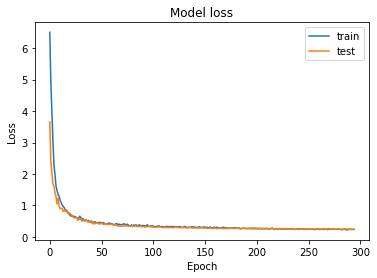

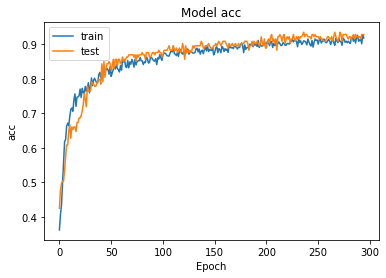

In [165]:
model = Sequential()  # 初始化
input = X_sc.shape[1]
# 隐藏层128
model.add(Dense(128, input_shape=(input,),kernel_initializer=w1_my_init,bias_initializer=b1_my_init))  #
model.add(Activation('relu'))
# Dropout层用于防止过拟合
model.add(Dropout(0.5))
# 隐藏层128
model.add(Dense(128,kernel_initializer=w2_my_init,bias_initializer=b2_my_init))
model.add(Activation('relu'))

model.add(Dense(3,kernel_initializer=w3_my_init,bias_initializer=b3_my_init))
model.add(Activation('softmax'))
# 使用高效的ADAM优化算法
model.compile(loss='categorical_crossentropy', optimizer=Adam(),metrics=['accuracy'])

early_stopping = EarlyStopping(monitor='val_loss', patience=50, verbose=2)

# 训练
history = model.fit(X_train_sc, y_train_c, epochs=500, batch_size=64,shuffle=False,verbose=2,
                   validation_data=(X_test_sc,y_test_c),callbacks=[early_stopping])

# loss曲线
plt.plot(history.history['loss'], label='train')
plt.plot(history.history['val_loss'], label='test')
plt.title('Model loss')
plt.ylabel('Loss')
plt.xlabel('Epoch')
plt.legend()
plt.show()

# acc曲线
plt.plot(history.history['accuracy'], label='train')
plt.plot(history.history['val_accuracy'], label='test')
plt.title('Model acc')
plt.ylabel('acc')
plt.xlabel('Epoch')
plt.legend()
plt.show()

## 选择样本

### 熵

In [166]:
probas_val=model.predict(X_val_sc)

In [167]:
selection=EntropySelection(probas_val,200)

In [168]:
for i in selection:
    X_train=np.vstack([X_train,X_val[i]])
    y_train_c=np.vstack([y_train_c,y_val_c[i]])

In [169]:
X_val=np.delete(X_val,selection,axis=0)
y_val_c=np.delete(y_val_c,selection,axis=0)

In [170]:
X_train.shape,y_train_c.shape,X_val.shape,y_val_c.shape

((1131, 10), (1131, 3), (332, 10), (332, 3))

### 随机

In [835]:
probas_val=model.predict(X_val_sc)
selection=RandomSelection(probas_val,200)
for i in selection:
    X_train=np.vstack([X_train,X_val[i]])
    y_train_c=np.vstack([y_train_c,y_val_c[i]])
X_val=np.delete(X_val,selection,axis=0)
y_val_c=np.delete(y_val_c,selection,axis=0)
X_train.shape,y_train_c.shape,X_val.shape,y_val_c.shape

((1132, 10), (1132, 3), (333, 10), (333, 3))

## 更新W，b

In [171]:
X_train_sc,X_val_sc,X_test_sc = normalize(X_train,X_val, X_test)

C:\Users\fairy粥粥粥\AppData\Roaming\Python\Python39\site-packages\sklearn\base.py:443: UserWarning: X has feature names, but MinMaxScaler was fitted without feature names
  warnings.warn(


In [172]:
w1,w2,w3=arithmetic_optimization_algorithm(X_train_sc,y_train_c,iterations = 50, alpha = 5, mu = 0.5, target_function = target_function, verbose = True)

Iteration =  0  loss =  [[1.86195694e+01]
 [3.51044101e+01]
 [1.25777817e-06]
 ...
 [1.06145463e+01]
 [3.77967057e+01]
 [1.23335426e+01]]
更新
Iteration =  1  loss =  [[1.84748017]
 [0.21828103]
 [1.87564267]
 ...
 [0.44481674]
 [0.20034729]
 [0.66281089]]
未更新
Iteration =  2  loss =  [[1.84748017]
 [0.21828103]
 [1.87564267]
 ...
 [0.44481674]
 [0.20034729]
 [0.66281089]]
未更新
Iteration =  3  loss =  [[1.84748017]
 [0.21828103]
 [1.87564267]
 ...
 [0.44481674]
 [0.20034729]
 [0.66281089]]
未更新
Iteration =  4  loss =  [[1.84748017]
 [0.21828103]
 [1.87564267]
 ...
 [0.44481674]
 [0.20034729]
 [0.66281089]]
未更新
Iteration =  5  loss =  [[1.84748017]
 [0.21828103]
 [1.87564267]
 ...
 [0.44481674]
 [0.20034729]
 [0.66281089]]
未更新
Iteration =  6  loss =  [[1.84748017]
 [0.21828103]
 [1.87564267]
 ...
 [0.44481674]
 [0.20034729]
 [0.66281089]]
更新
Iteration =  7  loss =  [[1.97981191]
 [8.38956056]
 [2.37793144]
 ...
 [0.15337402]
 [9.02925877]
 [0.07314364]]
未更新
Iteration =  8  loss =  [[1.979811

In [173]:
b1=w1[:,-1]
w1=w1[:,:-1].T

b2=w2[:,-1]
w2=w2[:,:-1].T

b3=w3[:,-1]
w3=w3[:,:-1].T

## 训练ANN

Epoch 1/500
18/18 - 0s - loss: 7.3587 - accuracy: 0.4111 - val_loss: 4.5587 - val_accuracy: 0.4118 - 447ms/epoch - 25ms/step
Epoch 2/500
18/18 - 0s - loss: 5.4369 - accuracy: 0.4996 - val_loss: 4.0129 - val_accuracy: 0.4641 - 76ms/epoch - 4ms/step
Epoch 3/500
18/18 - 0s - loss: 4.2831 - accuracy: 0.5579 - val_loss: 3.3282 - val_accuracy: 0.5229 - 59ms/epoch - 3ms/step
Epoch 4/500
18/18 - 0s - loss: 3.3506 - accuracy: 0.6295 - val_loss: 2.9038 - val_accuracy: 0.5817 - 72ms/epoch - 4ms/step
Epoch 5/500
18/18 - 0s - loss: 2.7337 - accuracy: 0.6366 - val_loss: 2.1254 - val_accuracy: 0.6536 - 73ms/epoch - 4ms/step
Epoch 6/500
18/18 - 0s - loss: 2.1043 - accuracy: 0.7073 - val_loss: 2.0582 - val_accuracy: 0.6536 - 72ms/epoch - 4ms/step
Epoch 7/500
18/18 - 0s - loss: 2.3097 - accuracy: 0.6711 - val_loss: 1.8338 - val_accuracy: 0.6601 - 71ms/epoch - 4ms/step
Epoch 8/500
18/18 - 0s - loss: 1.8207 - accuracy: 0.7197 - val_loss: 1.7585 - val_accuracy: 0.6601 - 57ms/epoch - 3ms/step
Epoch 9/500
18

Epoch 68/500
18/18 - 0s - loss: 0.3548 - accuracy: 0.8798 - val_loss: 0.2702 - val_accuracy: 0.9216 - 54ms/epoch - 3ms/step
Epoch 69/500
18/18 - 0s - loss: 0.3485 - accuracy: 0.8638 - val_loss: 0.3052 - val_accuracy: 0.8824 - 64ms/epoch - 4ms/step
Epoch 70/500
18/18 - 0s - loss: 0.3743 - accuracy: 0.8691 - val_loss: 0.2498 - val_accuracy: 0.9412 - 59ms/epoch - 3ms/step
Epoch 71/500
18/18 - 0s - loss: 0.3145 - accuracy: 0.8815 - val_loss: 0.2938 - val_accuracy: 0.8889 - 56ms/epoch - 3ms/step
Epoch 72/500
18/18 - 0s - loss: 0.3178 - accuracy: 0.8780 - val_loss: 0.2595 - val_accuracy: 0.9346 - 59ms/epoch - 3ms/step
Epoch 73/500
18/18 - 0s - loss: 0.3434 - accuracy: 0.8842 - val_loss: 0.2887 - val_accuracy: 0.9150 - 54ms/epoch - 3ms/step
Epoch 74/500
18/18 - 0s - loss: 0.3651 - accuracy: 0.8753 - val_loss: 0.2754 - val_accuracy: 0.9346 - 57ms/epoch - 3ms/step
Epoch 75/500
18/18 - 0s - loss: 0.3133 - accuracy: 0.8789 - val_loss: 0.2888 - val_accuracy: 0.9150 - 54ms/epoch - 3ms/step
Epoch 76

Epoch 134/500
18/18 - 0s - loss: 0.2409 - accuracy: 0.9107 - val_loss: 0.2352 - val_accuracy: 0.9346 - 72ms/epoch - 4ms/step
Epoch 135/500
18/18 - 0s - loss: 0.2508 - accuracy: 0.9019 - val_loss: 0.2251 - val_accuracy: 0.9346 - 74ms/epoch - 4ms/step
Epoch 136/500
18/18 - 0s - loss: 0.2428 - accuracy: 0.9063 - val_loss: 0.2379 - val_accuracy: 0.9346 - 57ms/epoch - 3ms/step
Epoch 137/500
18/18 - 0s - loss: 0.2540 - accuracy: 0.9010 - val_loss: 0.2331 - val_accuracy: 0.9346 - 72ms/epoch - 4ms/step
Epoch 138/500
18/18 - 0s - loss: 0.2503 - accuracy: 0.9107 - val_loss: 0.2331 - val_accuracy: 0.9281 - 60ms/epoch - 3ms/step
Epoch 139/500
18/18 - 0s - loss: 0.2623 - accuracy: 0.8983 - val_loss: 0.2274 - val_accuracy: 0.9281 - 66ms/epoch - 4ms/step
Epoch 140/500
18/18 - 0s - loss: 0.2505 - accuracy: 0.9089 - val_loss: 0.2397 - val_accuracy: 0.9281 - 65ms/epoch - 4ms/step
Epoch 141/500
18/18 - 0s - loss: 0.2324 - accuracy: 0.9160 - val_loss: 0.2375 - val_accuracy: 0.9281 - 65ms/epoch - 4ms/step


Epoch 200/500
18/18 - 0s - loss: 0.2140 - accuracy: 0.9248 - val_loss: 0.2075 - val_accuracy: 0.9412 - 57ms/epoch - 3ms/step
Epoch 201/500
18/18 - 0s - loss: 0.1946 - accuracy: 0.9284 - val_loss: 0.2104 - val_accuracy: 0.9281 - 72ms/epoch - 4ms/step
Epoch 202/500
18/18 - 0s - loss: 0.1945 - accuracy: 0.9248 - val_loss: 0.2109 - val_accuracy: 0.9346 - 59ms/epoch - 3ms/step
Epoch 203/500
18/18 - 0s - loss: 0.1908 - accuracy: 0.9231 - val_loss: 0.2065 - val_accuracy: 0.9412 - 67ms/epoch - 4ms/step
Epoch 204/500
18/18 - 0s - loss: 0.2105 - accuracy: 0.9231 - val_loss: 0.2143 - val_accuracy: 0.9346 - 68ms/epoch - 4ms/step
Epoch 205/500
18/18 - 0s - loss: 0.1959 - accuracy: 0.9257 - val_loss: 0.2155 - val_accuracy: 0.9412 - 70ms/epoch - 4ms/step
Epoch 206/500
18/18 - 0s - loss: 0.1991 - accuracy: 0.9240 - val_loss: 0.2157 - val_accuracy: 0.9346 - 60ms/epoch - 3ms/step
Epoch 207/500
18/18 - 0s - loss: 0.2201 - accuracy: 0.9125 - val_loss: 0.2095 - val_accuracy: 0.9412 - 66ms/epoch - 4ms/step


Epoch 266/500
18/18 - 0s - loss: 0.1910 - accuracy: 0.9275 - val_loss: 0.1992 - val_accuracy: 0.9346 - 66ms/epoch - 4ms/step
Epoch 267/500
18/18 - 0s - loss: 0.1737 - accuracy: 0.9293 - val_loss: 0.1964 - val_accuracy: 0.9412 - 68ms/epoch - 4ms/step
Epoch 268/500
18/18 - 0s - loss: 0.2017 - accuracy: 0.9213 - val_loss: 0.1965 - val_accuracy: 0.9346 - 67ms/epoch - 4ms/step
Epoch 269/500
18/18 - 0s - loss: 0.1698 - accuracy: 0.9399 - val_loss: 0.2032 - val_accuracy: 0.9346 - 71ms/epoch - 4ms/step
Epoch 270/500
18/18 - 0s - loss: 0.1794 - accuracy: 0.9363 - val_loss: 0.2061 - val_accuracy: 0.9281 - 70ms/epoch - 4ms/step
Epoch 271/500
18/18 - 0s - loss: 0.1854 - accuracy: 0.9231 - val_loss: 0.1940 - val_accuracy: 0.9346 - 55ms/epoch - 3ms/step
Epoch 272/500
18/18 - 0s - loss: 0.1741 - accuracy: 0.9302 - val_loss: 0.1909 - val_accuracy: 0.9412 - 77ms/epoch - 4ms/step
Epoch 273/500
18/18 - 0s - loss: 0.1797 - accuracy: 0.9222 - val_loss: 0.1986 - val_accuracy: 0.9412 - 55ms/epoch - 3ms/step


Epoch 332/500
18/18 - 0s - loss: 0.1605 - accuracy: 0.9390 - val_loss: 0.1952 - val_accuracy: 0.9477 - 69ms/epoch - 4ms/step
Epoch 333/500
18/18 - 0s - loss: 0.1709 - accuracy: 0.9310 - val_loss: 0.2027 - val_accuracy: 0.9412 - 61ms/epoch - 3ms/step
Epoch 334/500
18/18 - 0s - loss: 0.1686 - accuracy: 0.9408 - val_loss: 0.2034 - val_accuracy: 0.9412 - 67ms/epoch - 4ms/step
Epoch 335/500
18/18 - 0s - loss: 0.1648 - accuracy: 0.9416 - val_loss: 0.2068 - val_accuracy: 0.9412 - 66ms/epoch - 4ms/step
Epoch 336/500
18/18 - 0s - loss: 0.1618 - accuracy: 0.9355 - val_loss: 0.2013 - val_accuracy: 0.9412 - 66ms/epoch - 4ms/step
Epoch 337/500
18/18 - 0s - loss: 0.1632 - accuracy: 0.9363 - val_loss: 0.1984 - val_accuracy: 0.9412 - 72ms/epoch - 4ms/step
Epoch 338/500
18/18 - 0s - loss: 0.1508 - accuracy: 0.9505 - val_loss: 0.2084 - val_accuracy: 0.9346 - 61ms/epoch - 3ms/step
Epoch 339/500
18/18 - 0s - loss: 0.1515 - accuracy: 0.9425 - val_loss: 0.2044 - val_accuracy: 0.9412 - 66ms/epoch - 4ms/step


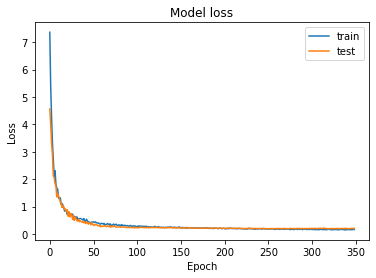

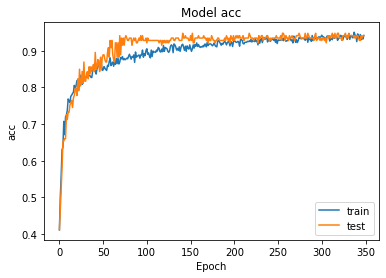

In [175]:
model = Sequential()  # 初始化
input = X_sc.shape[1]
# 隐藏层128
model.add(Dense(128, input_shape=(input,),kernel_initializer=w1_my_init,bias_initializer=b1_my_init))  #
model.add(Activation('relu'))
# Dropout层用于防止过拟合
model.add(Dropout(0.35))
# 隐藏层128
model.add(Dense(128,kernel_initializer=w2_my_init,bias_initializer=b2_my_init))
model.add(Activation('relu'))

model.add(Dense(3,kernel_initializer=w3_my_init,bias_initializer=b3_my_init))
model.add(Activation('softmax'))
# 使用高效的ADAM优化算法
model.compile(loss='categorical_crossentropy', optimizer=Adam(),metrics=['accuracy'])

early_stopping = EarlyStopping(monitor='val_loss', patience=100, verbose=2)

# 训练
history = model.fit(X_train_sc, y_train_c, epochs=500, batch_size=64,shuffle=False,verbose=2,
                   validation_data=(X_test_sc,y_test_c),callbacks=[early_stopping])

# loss曲线
plt.plot(history.history['loss'], label='train')
plt.plot(history.history['val_loss'], label='test')
plt.title('Model loss')
plt.ylabel('Loss')
plt.xlabel('Epoch')
plt.legend()
plt.show()

# acc曲线
plt.plot(history.history['accuracy'], label='train')
plt.plot(history.history['val_accuracy'], label='test')
plt.title('Model acc')
plt.ylabel('acc')
plt.xlabel('Epoch')
plt.legend()
plt.show()

## 选择样本

### 熵

In [176]:
probas_val=model.predict(X_val_sc)

In [177]:
selection=EntropySelection(probas_val,200)

In [178]:
for i in selection:
    X_train=np.vstack([X_train,X_val[i]])
    y_train_c=np.vstack([y_train_c,y_val_c[i]])

In [179]:
X_val=np.delete(X_val,selection,axis=0)
y_val_c=np.delete(y_val_c,selection,axis=0)

In [180]:
X_train.shape,y_train_c.shape,X_val.shape,y_val_c.shape

((1331, 10), (1331, 3), (132, 10), (132, 3))

### 随机

In [840]:
probas_val=model.predict(X_val_sc)
selection=RandomSelection(probas_val,200)
for i in selection:
    X_train=np.vstack([X_train,X_val[i]])
    y_train_c=np.vstack([y_train_c,y_val_c[i]])
X_val=np.delete(X_val,selection,axis=0)
y_val_c=np.delete(y_val_c,selection,axis=0)
X_train.shape,y_train_c.shape,X_val.shape,y_val_c.shape

((1332, 10), (1332, 3), (133, 10), (133, 3))

## 更新W，b

In [181]:
X_train_sc,X_val_sc,X_test_sc = normalize(X_train,X_val, X_test)

C:\Users\fairy粥粥粥\AppData\Roaming\Python\Python39\site-packages\sklearn\base.py:443: UserWarning: X has feature names, but MinMaxScaler was fitted without feature names
  warnings.warn(


In [196]:
w1,w2,w3=arithmetic_optimization_algorithm(X_train_sc,y_train_c,iterations = 50, alpha = 5, mu = 0.5, target_function = target_function, verbose = True)

Iteration =  0  loss =  [[2.48212998e+01]
 [4.82975336e+01]
 [1.25224076e-09]
 ...
 [2.49849096e+01]
 [3.30626934e+01]
 [1.80697384e+01]]
更新
Iteration =  1  loss =  [[1.99653084e-02]
 [4.63671338e+00]
 [7.01127066e+00]
 ...
 [1.17173187e-02]
 [7.47376964e-03]
 [5.93953404e-03]]
更新
Iteration =  2  loss =  [[0.85269943]
 [1.60484456]
 [1.53098396]
 ...
 [1.13855373]
 [1.0744775 ]
 [0.95054982]]
更新
Iteration =  3  loss =  [[0.88630381]
 [1.23503023]
 [3.44255639]
 ...
 [0.86150711]
 [1.45717092]
 [1.17311595]]
更新
Iteration =  4  loss =  [[0.32644084]
 [8.04909728]
 [1.57884945]
 ...
 [0.31293954]
 [0.45388236]
 [0.50245353]]
更新
Iteration =  5  loss =  [[0.07316829]
 [2.40314909]
 [3.04453318]
 ...
 [0.10014835]
 [0.20075368]
 [0.22944714]]
未更新
Iteration =  6  loss =  [[0.07316829]
 [2.40314909]
 [3.04453318]
 ...
 [0.10014835]
 [0.20075368]
 [0.22944714]]
更新
Iteration =  7  loss =  [[1.36934333]
 [0.52041577]
 [1.33563006]
 ...
 [0.90283116]
 [0.54088948]
 [0.51675804]]
未更新
Iteration =  8

In [197]:
b1=w1[:,-1]
w1=w1[:,:-1].T

b2=w2[:,-1]
w2=w2[:,:-1].T

b3=w3[:,-1]
w3=w3[:,:-1].T

## 训练ANN

Epoch 1/800
21/21 - 1s - loss: 3.0287 - accuracy: 0.4936 - val_loss: 0.9661 - val_accuracy: 0.6863 - 530ms/epoch - 25ms/step
Epoch 2/800
21/21 - 0s - loss: 1.0399 - accuracy: 0.7183 - val_loss: 0.7464 - val_accuracy: 0.7516 - 80ms/epoch - 4ms/step
Epoch 3/800
21/21 - 0s - loss: 0.7222 - accuracy: 0.7874 - val_loss: 0.7643 - val_accuracy: 0.7320 - 66ms/epoch - 3ms/step
Epoch 4/800
21/21 - 0s - loss: 0.6351 - accuracy: 0.8114 - val_loss: 0.8625 - val_accuracy: 0.7124 - 66ms/epoch - 3ms/step
Epoch 5/800
21/21 - 0s - loss: 0.5787 - accuracy: 0.8182 - val_loss: 0.5431 - val_accuracy: 0.7843 - 73ms/epoch - 3ms/step
Epoch 6/800
21/21 - 0s - loss: 0.5885 - accuracy: 0.8234 - val_loss: 0.4308 - val_accuracy: 0.8235 - 60ms/epoch - 3ms/step
Epoch 7/800
21/21 - 0s - loss: 0.4824 - accuracy: 0.8467 - val_loss: 0.4917 - val_accuracy: 0.8105 - 72ms/epoch - 3ms/step
Epoch 8/800
21/21 - 0s - loss: 0.4653 - accuracy: 0.8505 - val_loss: 0.4180 - val_accuracy: 0.8366 - 68ms/epoch - 3ms/step
Epoch 9/800
21

Epoch 68/800
21/21 - 0s - loss: 0.2054 - accuracy: 0.9204 - val_loss: 0.3413 - val_accuracy: 0.8693 - 65ms/epoch - 3ms/step
Epoch 69/800
21/21 - 0s - loss: 0.2080 - accuracy: 0.9128 - val_loss: 0.2911 - val_accuracy: 0.8824 - 63ms/epoch - 3ms/step
Epoch 70/800
21/21 - 0s - loss: 0.1982 - accuracy: 0.9219 - val_loss: 0.3052 - val_accuracy: 0.8824 - 53ms/epoch - 3ms/step
Epoch 71/800
21/21 - 0s - loss: 0.2088 - accuracy: 0.9136 - val_loss: 0.3387 - val_accuracy: 0.8562 - 70ms/epoch - 3ms/step
Epoch 72/800
21/21 - 0s - loss: 0.1909 - accuracy: 0.9324 - val_loss: 0.3369 - val_accuracy: 0.8562 - 58ms/epoch - 3ms/step
Epoch 73/800
21/21 - 0s - loss: 0.2066 - accuracy: 0.9189 - val_loss: 0.3429 - val_accuracy: 0.8497 - 65ms/epoch - 3ms/step
Epoch 74/800
21/21 - 0s - loss: 0.2004 - accuracy: 0.9234 - val_loss: 0.3037 - val_accuracy: 0.8627 - 60ms/epoch - 3ms/step
Epoch 75/800
21/21 - 0s - loss: 0.2003 - accuracy: 0.9159 - val_loss: 0.2912 - val_accuracy: 0.8627 - 64ms/epoch - 3ms/step
Epoch 76

Epoch 134/800
21/21 - 0s - loss: 0.1434 - accuracy: 0.9467 - val_loss: 0.2647 - val_accuracy: 0.8954 - 67ms/epoch - 3ms/step
Epoch 135/800
21/21 - 0s - loss: 0.1485 - accuracy: 0.9452 - val_loss: 0.2900 - val_accuracy: 0.8824 - 67ms/epoch - 3ms/step
Epoch 136/800
21/21 - 0s - loss: 0.1592 - accuracy: 0.9414 - val_loss: 0.2449 - val_accuracy: 0.9020 - 59ms/epoch - 3ms/step
Epoch 137/800
21/21 - 0s - loss: 0.1586 - accuracy: 0.9467 - val_loss: 0.2574 - val_accuracy: 0.9085 - 59ms/epoch - 3ms/step
Epoch 138/800
21/21 - 0s - loss: 0.1552 - accuracy: 0.9444 - val_loss: 0.2663 - val_accuracy: 0.9020 - 57ms/epoch - 3ms/step
Epoch 139/800
21/21 - 0s - loss: 0.1436 - accuracy: 0.9429 - val_loss: 0.2570 - val_accuracy: 0.8954 - 64ms/epoch - 3ms/step
Epoch 140/800
21/21 - 0s - loss: 0.1513 - accuracy: 0.9444 - val_loss: 0.2586 - val_accuracy: 0.8954 - 62ms/epoch - 3ms/step
Epoch 141/800
21/21 - 0s - loss: 0.1507 - accuracy: 0.9459 - val_loss: 0.2559 - val_accuracy: 0.8954 - 57ms/epoch - 3ms/step


Epoch 200/800
21/21 - 0s - loss: 0.1293 - accuracy: 0.9542 - val_loss: 0.2462 - val_accuracy: 0.9085 - 63ms/epoch - 3ms/step
Epoch 201/800
21/21 - 0s - loss: 0.1293 - accuracy: 0.9549 - val_loss: 0.2339 - val_accuracy: 0.9150 - 63ms/epoch - 3ms/step
Epoch 202/800
21/21 - 0s - loss: 0.1207 - accuracy: 0.9609 - val_loss: 0.2353 - val_accuracy: 0.9150 - 54ms/epoch - 3ms/step
Epoch 203/800
21/21 - 0s - loss: 0.1202 - accuracy: 0.9519 - val_loss: 0.2364 - val_accuracy: 0.9150 - 71ms/epoch - 3ms/step
Epoch 204/800
21/21 - 0s - loss: 0.1235 - accuracy: 0.9549 - val_loss: 0.2446 - val_accuracy: 0.8889 - 58ms/epoch - 3ms/step
Epoch 205/800
21/21 - 0s - loss: 0.1137 - accuracy: 0.9579 - val_loss: 0.2492 - val_accuracy: 0.9085 - 52ms/epoch - 2ms/step
Epoch 206/800
21/21 - 0s - loss: 0.1283 - accuracy: 0.9542 - val_loss: 0.2489 - val_accuracy: 0.8954 - 67ms/epoch - 3ms/step
Epoch 207/800
21/21 - 0s - loss: 0.1229 - accuracy: 0.9564 - val_loss: 0.2439 - val_accuracy: 0.9085 - 55ms/epoch - 3ms/step


Epoch 266/800
21/21 - 0s - loss: 0.1113 - accuracy: 0.9617 - val_loss: 0.2179 - val_accuracy: 0.9281 - 65ms/epoch - 3ms/step
Epoch 267/800
21/21 - 0s - loss: 0.1126 - accuracy: 0.9602 - val_loss: 0.2320 - val_accuracy: 0.9150 - 58ms/epoch - 3ms/step
Epoch 268/800
21/21 - 0s - loss: 0.1111 - accuracy: 0.9624 - val_loss: 0.2167 - val_accuracy: 0.9216 - 67ms/epoch - 3ms/step
Epoch 269/800
21/21 - 0s - loss: 0.1033 - accuracy: 0.9662 - val_loss: 0.2197 - val_accuracy: 0.9281 - 66ms/epoch - 3ms/step
Epoch 270/800
21/21 - 0s - loss: 0.1085 - accuracy: 0.9654 - val_loss: 0.2173 - val_accuracy: 0.9281 - 70ms/epoch - 3ms/step
Epoch 271/800
21/21 - 0s - loss: 0.1120 - accuracy: 0.9647 - val_loss: 0.2265 - val_accuracy: 0.9281 - 62ms/epoch - 3ms/step
Epoch 272/800
21/21 - 0s - loss: 0.1101 - accuracy: 0.9617 - val_loss: 0.2242 - val_accuracy: 0.9216 - 66ms/epoch - 3ms/step
Epoch 273/800
21/21 - 0s - loss: 0.1105 - accuracy: 0.9609 - val_loss: 0.2296 - val_accuracy: 0.9216 - 74ms/epoch - 4ms/step


Epoch 332/800
21/21 - 0s - loss: 0.1005 - accuracy: 0.9639 - val_loss: 0.2093 - val_accuracy: 0.9477 - 77ms/epoch - 4ms/step
Epoch 333/800
21/21 - 0s - loss: 0.1011 - accuracy: 0.9647 - val_loss: 0.2213 - val_accuracy: 0.9346 - 64ms/epoch - 3ms/step
Epoch 334/800
21/21 - 0s - loss: 0.0987 - accuracy: 0.9677 - val_loss: 0.2186 - val_accuracy: 0.9150 - 65ms/epoch - 3ms/step
Epoch 335/800
21/21 - 0s - loss: 0.0973 - accuracy: 0.9654 - val_loss: 0.2173 - val_accuracy: 0.9346 - 70ms/epoch - 3ms/step
Epoch 336/800
21/21 - 0s - loss: 0.0989 - accuracy: 0.9639 - val_loss: 0.2267 - val_accuracy: 0.9216 - 67ms/epoch - 3ms/step
Epoch 337/800
21/21 - 0s - loss: 0.1036 - accuracy: 0.9602 - val_loss: 0.2277 - val_accuracy: 0.9281 - 71ms/epoch - 3ms/step
Epoch 338/800
21/21 - 0s - loss: 0.0984 - accuracy: 0.9669 - val_loss: 0.2258 - val_accuracy: 0.9346 - 68ms/epoch - 3ms/step
Epoch 339/800
21/21 - 0s - loss: 0.1024 - accuracy: 0.9632 - val_loss: 0.2259 - val_accuracy: 0.9216 - 69ms/epoch - 3ms/step


Epoch 398/800
21/21 - 0s - loss: 0.0913 - accuracy: 0.9677 - val_loss: 0.2216 - val_accuracy: 0.9216 - 67ms/epoch - 3ms/step
Epoch 399/800
21/21 - 0s - loss: 0.0840 - accuracy: 0.9684 - val_loss: 0.2239 - val_accuracy: 0.9346 - 68ms/epoch - 3ms/step
Epoch 400/800
21/21 - 0s - loss: 0.0981 - accuracy: 0.9609 - val_loss: 0.2245 - val_accuracy: 0.9477 - 69ms/epoch - 3ms/step
Epoch 401/800
21/21 - 0s - loss: 0.0942 - accuracy: 0.9715 - val_loss: 0.2202 - val_accuracy: 0.9216 - 68ms/epoch - 3ms/step
Epoch 402/800
21/21 - 0s - loss: 0.0935 - accuracy: 0.9662 - val_loss: 0.2265 - val_accuracy: 0.9281 - 68ms/epoch - 3ms/step
Epoch 403/800
21/21 - 0s - loss: 0.0943 - accuracy: 0.9677 - val_loss: 0.2102 - val_accuracy: 0.9346 - 70ms/epoch - 3ms/step
Epoch 404/800
21/21 - 0s - loss: 0.0924 - accuracy: 0.9684 - val_loss: 0.2159 - val_accuracy: 0.9412 - 70ms/epoch - 3ms/step
Epoch 405/800
21/21 - 0s - loss: 0.0975 - accuracy: 0.9647 - val_loss: 0.2104 - val_accuracy: 0.9346 - 57ms/epoch - 3ms/step


Epoch 464/800
21/21 - 0s - loss: 0.0823 - accuracy: 0.9715 - val_loss: 0.2045 - val_accuracy: 0.9412 - 85ms/epoch - 4ms/step
Epoch 465/800
21/21 - 0s - loss: 0.0872 - accuracy: 0.9692 - val_loss: 0.2069 - val_accuracy: 0.9412 - 67ms/epoch - 3ms/step
Epoch 466/800
21/21 - 0s - loss: 0.0841 - accuracy: 0.9677 - val_loss: 0.2235 - val_accuracy: 0.9412 - 68ms/epoch - 3ms/step
Epoch 467/800
21/21 - 0s - loss: 0.0839 - accuracy: 0.9699 - val_loss: 0.2135 - val_accuracy: 0.9346 - 65ms/epoch - 3ms/step
Epoch 468/800
21/21 - 0s - loss: 0.0861 - accuracy: 0.9715 - val_loss: 0.2056 - val_accuracy: 0.9346 - 84ms/epoch - 4ms/step
Epoch 469/800
21/21 - 0s - loss: 0.0803 - accuracy: 0.9707 - val_loss: 0.2300 - val_accuracy: 0.9412 - 83ms/epoch - 4ms/step
Epoch 470/800
21/21 - 0s - loss: 0.0884 - accuracy: 0.9647 - val_loss: 0.2223 - val_accuracy: 0.9412 - 68ms/epoch - 3ms/step
Epoch 471/800
21/21 - 0s - loss: 0.0869 - accuracy: 0.9654 - val_loss: 0.2082 - val_accuracy: 0.9412 - 83ms/epoch - 4ms/step


Epoch 530/800
21/21 - 0s - loss: 0.0810 - accuracy: 0.9707 - val_loss: 0.2188 - val_accuracy: 0.9477 - 66ms/epoch - 3ms/step
Epoch 531/800
21/21 - 0s - loss: 0.0784 - accuracy: 0.9684 - val_loss: 0.2095 - val_accuracy: 0.9542 - 84ms/epoch - 4ms/step
Epoch 532/800
21/21 - 0s - loss: 0.0798 - accuracy: 0.9677 - val_loss: 0.2061 - val_accuracy: 0.9477 - 72ms/epoch - 3ms/step
Epoch 533/800
21/21 - 0s - loss: 0.0803 - accuracy: 0.9699 - val_loss: 0.2102 - val_accuracy: 0.9477 - 58ms/epoch - 3ms/step
Epoch 534/800
21/21 - 0s - loss: 0.0839 - accuracy: 0.9707 - val_loss: 0.2114 - val_accuracy: 0.9412 - 77ms/epoch - 4ms/step
Epoch 535/800
21/21 - 0s - loss: 0.0835 - accuracy: 0.9692 - val_loss: 0.2097 - val_accuracy: 0.9477 - 69ms/epoch - 3ms/step
Epoch 536/800
21/21 - 0s - loss: 0.0790 - accuracy: 0.9715 - val_loss: 0.2042 - val_accuracy: 0.9542 - 67ms/epoch - 3ms/step
Epoch 537/800
21/21 - 0s - loss: 0.0796 - accuracy: 0.9692 - val_loss: 0.2169 - val_accuracy: 0.9477 - 67ms/epoch - 3ms/step


Epoch 596/800
21/21 - 0s - loss: 0.0835 - accuracy: 0.9669 - val_loss: 0.2240 - val_accuracy: 0.9412 - 84ms/epoch - 4ms/step
Epoch 597/800
21/21 - 0s - loss: 0.0739 - accuracy: 0.9737 - val_loss: 0.2297 - val_accuracy: 0.9542 - 82ms/epoch - 4ms/step
Epoch 598/800
21/21 - 0s - loss: 0.0811 - accuracy: 0.9707 - val_loss: 0.2140 - val_accuracy: 0.9412 - 68ms/epoch - 3ms/step
Epoch 599/800
21/21 - 0s - loss: 0.0671 - accuracy: 0.9760 - val_loss: 0.2228 - val_accuracy: 0.9542 - 80ms/epoch - 4ms/step
Epoch 600/800
21/21 - 0s - loss: 0.0702 - accuracy: 0.9775 - val_loss: 0.2255 - val_accuracy: 0.9477 - 68ms/epoch - 3ms/step
Epoch 601/800
21/21 - 0s - loss: 0.0810 - accuracy: 0.9707 - val_loss: 0.2279 - val_accuracy: 0.9477 - 81ms/epoch - 4ms/step
Epoch 602/800
21/21 - 0s - loss: 0.0767 - accuracy: 0.9699 - val_loss: 0.2116 - val_accuracy: 0.9477 - 67ms/epoch - 3ms/step
Epoch 603/800
21/21 - 0s - loss: 0.0707 - accuracy: 0.9745 - val_loss: 0.2133 - val_accuracy: 0.9542 - 66ms/epoch - 3ms/step


Epoch 662/800
21/21 - 0s - loss: 0.0853 - accuracy: 0.9699 - val_loss: 0.2277 - val_accuracy: 0.9477 - 66ms/epoch - 3ms/step
Epoch 663/800
21/21 - 0s - loss: 0.0725 - accuracy: 0.9684 - val_loss: 0.2319 - val_accuracy: 0.9346 - 84ms/epoch - 4ms/step
Epoch 664/800
21/21 - 0s - loss: 0.0687 - accuracy: 0.9767 - val_loss: 0.2413 - val_accuracy: 0.9412 - 80ms/epoch - 4ms/step
Epoch 665/800
21/21 - 0s - loss: 0.0736 - accuracy: 0.9699 - val_loss: 0.2380 - val_accuracy: 0.9477 - 69ms/epoch - 3ms/step
Epoch 666/800
21/21 - 0s - loss: 0.0667 - accuracy: 0.9775 - val_loss: 0.2263 - val_accuracy: 0.9477 - 68ms/epoch - 3ms/step
Epoch 667/800
21/21 - 0s - loss: 0.0770 - accuracy: 0.9707 - val_loss: 0.2504 - val_accuracy: 0.9477 - 73ms/epoch - 3ms/step
Epoch 668/800
21/21 - 0s - loss: 0.0704 - accuracy: 0.9737 - val_loss: 0.2584 - val_accuracy: 0.9346 - 68ms/epoch - 3ms/step
Epoch 669/800
21/21 - 0s - loss: 0.0681 - accuracy: 0.9760 - val_loss: 0.2373 - val_accuracy: 0.9542 - 65ms/epoch - 3ms/step


Epoch 728/800
21/21 - 0s - loss: 0.0684 - accuracy: 0.9797 - val_loss: 0.2541 - val_accuracy: 0.9477 - 80ms/epoch - 4ms/step
Epoch 729/800
21/21 - 0s - loss: 0.0708 - accuracy: 0.9715 - val_loss: 0.2490 - val_accuracy: 0.9542 - 67ms/epoch - 3ms/step
Epoch 730/800
21/21 - 0s - loss: 0.0696 - accuracy: 0.9707 - val_loss: 0.2397 - val_accuracy: 0.9542 - 67ms/epoch - 3ms/step
Epoch 731/800
21/21 - 0s - loss: 0.0705 - accuracy: 0.9760 - val_loss: 0.2326 - val_accuracy: 0.9542 - 69ms/epoch - 3ms/step
Epoch 732/800
21/21 - 0s - loss: 0.0797 - accuracy: 0.9722 - val_loss: 0.2415 - val_accuracy: 0.9412 - 66ms/epoch - 3ms/step
Epoch 733/800
21/21 - 0s - loss: 0.0689 - accuracy: 0.9760 - val_loss: 0.2327 - val_accuracy: 0.9477 - 73ms/epoch - 3ms/step
Epoch 734/800
21/21 - 0s - loss: 0.0723 - accuracy: 0.9730 - val_loss: 0.2317 - val_accuracy: 0.9608 - 60ms/epoch - 3ms/step
Epoch 735/800
21/21 - 0s - loss: 0.0718 - accuracy: 0.9730 - val_loss: 0.2232 - val_accuracy: 0.9542 - 68ms/epoch - 3ms/step


Epoch 794/800
21/21 - 0s - loss: 0.0668 - accuracy: 0.9707 - val_loss: 0.2329 - val_accuracy: 0.9477 - 68ms/epoch - 3ms/step
Epoch 795/800
21/21 - 0s - loss: 0.0714 - accuracy: 0.9715 - val_loss: 0.2442 - val_accuracy: 0.9608 - 68ms/epoch - 3ms/step
Epoch 796/800
21/21 - 0s - loss: 0.0712 - accuracy: 0.9715 - val_loss: 0.2342 - val_accuracy: 0.9477 - 65ms/epoch - 3ms/step
Epoch 797/800
21/21 - 0s - loss: 0.0732 - accuracy: 0.9745 - val_loss: 0.2607 - val_accuracy: 0.9477 - 71ms/epoch - 3ms/step
Epoch 798/800
21/21 - 0s - loss: 0.0751 - accuracy: 0.9715 - val_loss: 0.2494 - val_accuracy: 0.9542 - 59ms/epoch - 3ms/step
Epoch 799/800
21/21 - 0s - loss: 0.0699 - accuracy: 0.9737 - val_loss: 0.2365 - val_accuracy: 0.9542 - 82ms/epoch - 4ms/step
Epoch 800/800
21/21 - 0s - loss: 0.0763 - accuracy: 0.9730 - val_loss: 0.2329 - val_accuracy: 0.9542 - 66ms/epoch - 3ms/step


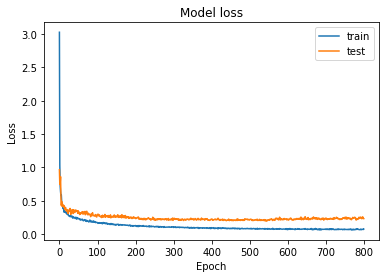

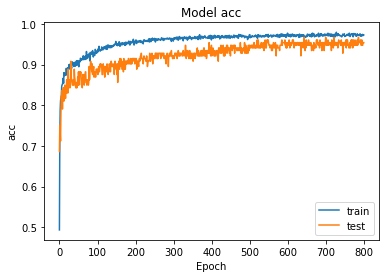

In [224]:
model = Sequential()  # 初始化
input = X_sc.shape[1]
# 隐藏层128
model.add(Dense(128, input_shape=(input,),kernel_initializer=w1_my_init,bias_initializer=b1_my_init))  #
model.add(Activation('relu'))
# Dropout层用于防止过拟合
model.add(Dropout(0.05))
# 隐藏层128
model.add(Dense(128,kernel_initializer=w2_my_init,bias_initializer=b2_my_init))
model.add(Activation('relu'))

model.add(Dense(3,kernel_initializer=w3_my_init,bias_initializer=b3_my_init))
model.add(Activation('softmax'))
# 使用高效的ADAM优化算法
model.compile(loss='categorical_crossentropy', optimizer=Adam(),metrics=['accuracy'])

early_stopping = EarlyStopping(monitor='val_loss', patience=500, verbose=2)

# 训练
history = model.fit(X_train_sc, y_train_c,epochs=800, batch_size=64,shuffle=False,verbose=2,
                   validation_data=(X_test_sc,y_test_c),callbacks=[early_stopping])

# loss曲线
plt.plot(history.history['loss'], label='train')
plt.plot(history.history['val_loss'], label='test')
plt.title('Model loss')
plt.ylabel('Loss')
plt.xlabel('Epoch')
plt.legend()
plt.show()

# acc曲线
plt.plot(history.history['accuracy'], label='train')
plt.plot(history.history['val_accuracy'], label='test')
plt.title('Model acc')
plt.ylabel('acc')
plt.xlabel('Epoch')
plt.legend()
plt.show()

In [861]:
preds=model.predict(X_test_sc)

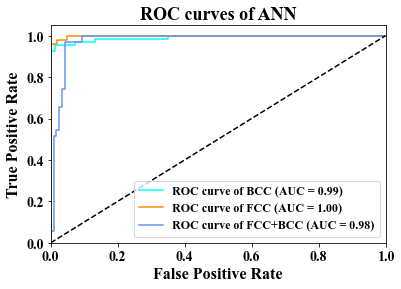

In [799]:
from itertools import cycle
fpr = dict()
tpr = dict()
roc_auc = dict()
preds=model.predict(X_test_sc)
for i in range(3):
    fpr[i], tpr[i], _ = roc_curve(y_test_c[:, i], preds[:, i])
    roc_auc[i] = auc(fpr[i], tpr[i])

colors = cycle(['aqua', 'darkorange', 'cornflowerblue'])
phases = ['BCC','FCC','FCC+BCC']
for i, color in zip(range(3), colors):
    plt.plot(fpr[i], tpr[i], color=color,label='ROC curve of {0} (AUC = {1:0.2f})'.format(phases[i], roc_auc[i]))

plt.plot([0, 1], [0, 1], 'k--')
plt.xlim([0.0, 1.0])
plt.ylim([0.0, 1.05])
plt.xlabel('False Positive Rate',fontproperties={'family':'Times New Roman'  #'serif', 
#         ,'style':'italic'
        ,'weight':'bold'  # 'normal' 
#         ,'color':'red'
        ,'size':16
       })
plt.ylabel('True Positive Rate',fontproperties={'family':'Times New Roman'  #'serif', 
#         ,'style':'italic'
        ,'weight':'bold'  # 'normal' 
#         ,'color':'red'
        ,'size':16
       })
plt.title('ROC curves of ANN',fontproperties={'family':'Times New Roman'  #'serif', 
#         ,'style':'italic'
        ,'weight':'bold'  # 'normal' 
#         ,'color':'red'
        ,'size':18
       })
plt.legend(loc="lower right",prop={'family':'Times New Roman'  #'serif', 
#         ,'style':'italic'
        ,'weight':'bold'  # 'normal' 
#         ,'color':'red'
        ,'size':12
       })
plt.xticks(fontproperties={'family':'Times New Roman'  #'serif', 
#         ,'style':'italic'
        ,'weight':'bold'  # 'normal' 
#         ,'color':'red'
        ,'size':14
       })
plt.yticks(fontproperties={'family':'Times New Roman'  #'serif', 
#         ,'style':'italic'
        ,'weight':'bold'  # 'normal' 
#         ,'color':'red'
        ,'size':14
       })
plt.savefig("ANN_ROC.png", dpi=300,format="png")
plt.show()

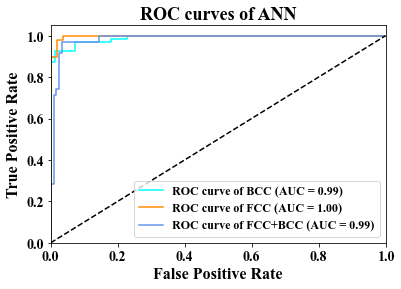

In [862]:
from itertools import cycle
fpr = dict()
tpr = dict()
roc_auc = dict()
preds=model.predict(X_test_sc)
for i in range(3):
    fpr[i], tpr[i], _ = roc_curve(y_test_c[:, i], preds[:, i])
    roc_auc[i] = auc(fpr[i], tpr[i])

colors = cycle(['aqua', 'darkorange', 'cornflowerblue'])
phases = ['BCC','FCC','FCC+BCC']
for i, color in zip(range(3), colors):
    plt.plot(fpr[i], tpr[i], color=color,label='ROC curve of {0} (AUC = {1:0.2f})'.format(phases[i], roc_auc[i]))

plt.plot([0, 1], [0, 1], 'k--')
plt.xlim([0.0, 1.0])
plt.ylim([0.0, 1.05])
plt.xlabel('False Positive Rate',fontproperties={'family':'Times New Roman'  #'serif', 
#         ,'style':'italic'
        ,'weight':'bold'  # 'normal' 
#         ,'color':'red'
        ,'size':16
       })
plt.ylabel('True Positive Rate',fontproperties={'family':'Times New Roman'  #'serif', 
#         ,'style':'italic'
        ,'weight':'bold'  # 'normal' 
#         ,'color':'red'
        ,'size':16
       })
plt.title('ROC curves of ANN',fontproperties={'family':'Times New Roman'  #'serif', 
#         ,'style':'italic'
        ,'weight':'bold'  # 'normal' 
#         ,'color':'red'
        ,'size':18
       })
plt.legend(loc="lower right",prop={'family':'Times New Roman'  #'serif', 
#         ,'style':'italic'
        ,'weight':'bold'  # 'normal' 
#         ,'color':'red'
        ,'size':12
       })
plt.xticks(fontproperties={'family':'Times New Roman'  #'serif', 
#         ,'style':'italic'
        ,'weight':'bold'  # 'normal' 
#         ,'color':'red'
        ,'size':14
       })
plt.yticks(fontproperties={'family':'Times New Roman'  #'serif', 
#         ,'style':'italic'
        ,'weight':'bold'  # 'normal' 
#         ,'color':'red'
        ,'size':14
       })
plt.savefig("ANN_ROC_random.png", dpi=300,format="png")
plt.show()